# Import GitHub Repo

In [ ]:
!git clone https://github.com/ai4ai-lab/Factored-Action-Spaces-for-OPE.git

#Enable importing code from parent directory
import os, sys
main_folder = os.path.abspath('./Factored-Action-Spaces-for-OPE')
sys.path.insert(1, main_folder)

Cloning into 'Factored-Action-Spaces-Empirical-Simulation'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (361/361), done.
remote: Compressing objects: 100% (255/255), done.
remote: Total 361 (delta 131), reused 299 (delta 74), pack-reused 0
Receiving objects: 100% (361/361), 7.76 MiB | 10.69 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [ ]:
#Change our working directory
if os.getcwd() == '/content':
  os.chdir('./Factored-Action-Spaces-for-OPE')

# Quick Links

- Vs Episodes for Policy Divergence 1.44 [here](#vs_ep_pd_1_44)

- Vs Episodes for Policy Divergence 2.56 [here](#vs_ep_pd_2_56)

- Vs Episodes for Policy Divergence 3.61 [here](#vs_ep_pd_3_61)

- Vs Policy Divergence for 1000 and 100000 Episodes [here](#vs_pd_ep_1e3_1e5)

- Vs $\beta$ for 1000 and 100000 Episodes [here](#vs_beta_ep_1e3_1e5)

- Coverage Graphs [here](#coverage)

# 1-step-MDP

## Varying Number of Episodes: Policy Divergence 1.44

**Note**: Restart the runtime before running all code in this section

### Generate Data Set

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

Policy divergence: 1.44
Start state: state, start state no: 0


### Run Estimates on Collected Data Sets

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 1.44
VERSION_NUMBER = 1

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')


  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means = np.zeros((9, 7))
biases = np.zeros((9, 7))
vars = np.zeros((9, 7))
MSEs = np.zeros((9, 7))

#### 100 runs, 10 episodes

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 10)
gc.collect()

Mean on policy Q estimate: 1.199. Variance of on policy Q estimate: 0.037499
Mean off policy IS estimate: 1.1798399999999998. Bias1: 0.019160000000000378. Bias2: 0.019160000000000288. Variance: 0.12059965439999999. MSE: 0.12096676
Mean off policy PDIS estimate: 1.1798399999999998. Bias1: 0.019160000000000378. Bias2: 0.019160000000000288 Variance: 0.12059965439999999. MSE: 0.12096676
Mean off policy PDWIS estimate: 1.1625205834746388. Bias1: 0.03647941652536118. Bias2: 0.03647941652536124. Variance: 0.05933508858217966. MSE: 0.060665836412210454
Mean off policy DecIS estimate: 1.1891999999999998. Bias1: 0.009799999999999576. Bias2: 0.009800000000000253. Variance: 0.07951535999999998. MSE: 0.07961139999999997
Mean off policy DecPDIS estimate: 1.1891999999999998. Bias1: 0.009799999999999576. Bias2: 0.009800000000000253. Variance: 0.07951535999999998. MSE: 0.07961139999999997
Mean off policy DecPDWIS estimate: 1.1714769867813342. Bias1: 0.027523013218665668. Bias2: 0.027523013218665904. Va

0

#### 1000 runs, 50 episodes

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 50)
gc.collect()

Mean on policy Q estimate: 1.1839999999999997. Variance of on policy Q estimate: 0.007712000000000001
Mean off policy IS estimate: 1.2088320000000001. Bias1: 0.02483200000000028. Bias2: 0.02483200000000041. Variance: 0.02056214937599998. MSE: 0.021178777599999993
Mean off policy PDIS estimate: 1.2088320000000001. Bias1: 0.02483200000000028. Bias2: 0.02483200000000041 Variance: 0.02056214937599998. MSE: 0.021178777599999993
Mean off policy PDWIS estimate: 1.2015574510858973. Bias1: 0.017557451085897534. Bias2: 0.01755745108589757. Variance: 0.009290193961962618. MSE: 0.009598458050596302
Mean off policy DecIS estimate: 1.2107999999999999. Bias1: 0.026800000000000393. Bias2: 0.026800000000000157. Variance: 0.014093280000000001. MSE: 0.014811520000000022
Mean off policy DecPDIS estimate: 1.2107999999999999. Bias1: 0.026800000000000393. Bias2: 0.026800000000000157. Variance: 0.014093280000000001. MSE: 0.014811520000000022
Mean off policy DecPDWIS estimate: 1.2044238236669156. Bias1: 0.0204

0

#### 1000 runs, 100 episodes

In [ ]:
means[2, :], biases[2, :], vars[2, :], MSEs[2, :] = evaluate_PE(100, 100)
gc.collect()

Mean on policy Q estimate: 1.2008999999999999. Variance of on policy Q estimate: 0.003976190000000002
Mean off policy IS estimate: 1.2028799999999997. Bias1: 0.0019800000000002884. Bias2: 0.0019799999999998708. Variance: 0.010708070400000012. MSE: 0.010711990800000014
Mean off policy PDIS estimate: 1.2028799999999997. Bias1: 0.0019800000000002884. Bias2: 0.0019799999999998708 Variance: 0.010708070400000012. MSE: 0.010711990800000014
Mean off policy PDWIS estimate: 1.199741138748205. Bias1: 0.0011588612517945405. Bias2: 0.0011588612517947627. Variance: 0.004747269271401352. MSE: 0.004748612230802263
Mean off policy DecIS estimate: 1.2039600000000001. Bias1: 0.0030600000000000466. Bias2: 0.0030600000000002847. Variance: 0.007027358400000004. MSE: 0.007036722000000004
Mean off policy DecPDIS estimate: 1.2039600000000001. Bias1: 0.0030600000000000466. Bias2: 0.0030600000000002847. Variance: 0.007027358400000004. MSE: 0.007036722000000004
Mean off policy DecPDWIS estimate: 1.201266947838021

0

#### 1000 runs, 500 episodes

In [ ]:
means[3, :], biases[3, :], vars[3, :], MSEs[3, :] = evaluate_PE(100, 500)
gc.collect()

Mean on policy Q estimate: 1.2006599999999998. Variance of on policy Q estimate: 0.0009656844000000017
Mean off policy IS estimate: 1.1948543999999999. Bias1: 0.0058055999999998146. Bias2: 0.005805599999999966. Variance: 0.0019606398566399995. MSE: 0.0019943448479999974
Mean off policy PDIS estimate: 1.1948543999999999. Bias1: 0.0058055999999998146. Bias2: 0.005805599999999966 Variance: 0.0019606398566399995. MSE: 0.0019943448479999974
Mean off policy PDWIS estimate: 1.1960958693426522. Bias1: 0.004564130657347624. Bias2: 0.00456413065734762. Variance: 0.0009001350275730722. MSE: 0.0009209663162304127
Mean off policy DecIS estimate: 1.1964000000000001. Bias1: 0.004259999999999851. Bias2: 0.0042599999999997085. Variance: 0.0012718655999999994. MSE: 0.0012900131999999981
Mean off policy DecPDIS estimate: 1.1964000000000001. Bias1: 0.004259999999999851. Bias2: 0.0042599999999997085. Variance: 0.0012718655999999994. MSE: 0.0012900131999999981
Mean off policy DecPDWIS estimate: 1.1968009646

0

#### 1000 runs, 1000 episodes

In [ ]:
means[4, :], biases[4, :], vars[4, :], MSEs[4, :] = evaluate_PE(100, 1000)
gc.collect()

Mean on policy Q estimate: 1.20025. Variance of on policy Q estimate: 0.0004219075000000013
Mean off policy IS estimate: 1.1932608. Bias1: 0.006989199999999954. Bias2: 0.006989200000000029. Variance: 0.0010017051033599992. MSE: 0.0010505540199999986
Mean off policy PDIS estimate: 1.1932608. Bias1: 0.006989199999999954. Bias2: 0.006989200000000029 Variance: 0.0010017051033599992. MSE: 0.0010505540199999986
Mean off policy PDWIS estimate: 1.1952193810362268. Bias1: 0.005030618963773385. Bias2: 0.005030618963773215. Variance: 0.0004638416881936261. MSE: 0.0004891488153523025
Mean off policy DecIS estimate: 1.1949839999999998. Bias1: 0.005266000000000115. Bias2: 0.005266000000000215. Variance: 0.0006382765439999995. MSE: 0.0006660073000000007
Mean off policy DecPDIS estimate: 1.1949839999999998. Bias1: 0.005266000000000115. Bias2: 0.005266000000000215. Variance: 0.0006382765439999995. MSE: 0.0006660073000000007
Mean off policy DecPDWIS estimate: 1.195832753840336. Bias1: 0.0044172461596643

0

#### 1000 runs, 5000 episodes

In [ ]:
means[5, :], biases[5, :], vars[5, :], MSEs[5, :] = evaluate_PE(100, 5000)
gc.collect()

Mean on policy Q estimate: 1.19895. Variance of on policy Q estimate: 9.560589999999978e-05
Mean off policy IS estimate: 1.1989785599999998. Bias1: 2.8560000000587147e-05. Bias2: 2.8559999999844266e-05. Variance: 0.00022671424880639962. MSE: 0.00022671506447999965
Mean off policy PDIS estimate: 1.1989785599999998. Bias1: 2.8560000000587147e-05. Bias2: 2.8559999999844266e-05 Variance: 0.00022671424880639962. MSE: 0.00022671506447999965
Mean off policy PDWIS estimate: 1.1992861149647844. Bias1: 0.00033611496478475983. Bias2: 0.000336114964784473. Variance: 0.00010169062475058778. MSE: 0.00010180359802014004
Mean off policy DecIS estimate: 1.1990928000000003. Bias1: 0.00014279999999989876. Bias2: 0.00014280000000033155. Variance: 0.00016035906816000013. MSE: 0.0001603794600000001
Mean off policy DecPDIS estimate: 1.1990928000000003. Bias1: 0.00014279999999989876. Bias2: 0.00014280000000033155. Variance: 0.00016035906816000013. MSE: 0.0001603794600000001
Mean off policy DecPDWIS estimate: 

0

#### 1000 runs, 10000 episodes

In [ ]:
means[6, :], biases[6, :], vars[6, :], MSEs[6, :] = evaluate_PE(100, 10000)
gc.collect()

Mean on policy Q estimate: 1.1992720000000001. Variance of on policy Q estimate: 5.505481600000005e-05
Mean off policy IS estimate: 1.2003916799999998. Bias1: 0.0011196799999999801. Bias2: 0.0011196799999997342. Variance: 0.00011131521269760001. MSE: 0.00011256889599999997
Mean off policy PDIS estimate: 1.2003916799999998. Bias1: 0.0011196799999999801. Bias2: 0.0011196799999997342 Variance: 0.00011131521269760001. MSE: 0.00011256889599999997
Mean off policy PDWIS estimate: 1.2002289510872266. Bias1: 0.0009569510872262327. Bias2: 0.0009569510872264875. Variance: 4.9836672777074504e-05. MSE: 5.075242816041797e-05
Mean off policy DecIS estimate: 1.2003996. Bias1: 0.0011275999999998188. Bias2: 0.0011275999999997843. Variance: 7.861451183999986e-05. MSE: 7.988599359999945e-05
Mean off policy DecPDIS estimate: 1.2003996. Bias1: 0.0011275999999998188. Bias2: 0.0011275999999997843. Variance: 7.861451183999986e-05. MSE: 7.988599359999945e-05
Mean off policy DecPDWIS estimate: 1.200297316308939.

0

#### 1000 runs, 50000 episodes

In [ ]:
means[7, :], biases[7, :], vars[7, :], MSEs[7, :] = evaluate_PE(100, 50000)
gc.collect()

Mean on policy Q estimate: 1.2001104000000002. Variance of on policy Q estimate: 8.581787839999995e-06
Mean off policy IS estimate: 1.1997536640000002. Bias1: 0.000356736000000147. Bias2: 0.00035673600000007966. Variance: 2.516494458470412e-05. MSE: 2.5292205158400225e-05
Mean off policy PDIS estimate: 1.1997536640000002. Bias1: 0.000356736000000147. Bias2: 0.00035673600000007966 Variance: 2.516494458470412e-05. MSE: 2.5292205158400225e-05
Mean off policy PDWIS estimate: 1.199822694249342. Bias1: 0.00028770575065817166. Bias2: 0.00028770575065828474. Variance: 1.1389515941689317e-05. MSE: 1.14722905406511e-05
Mean off policy DecIS estimate: 1.1998476. Bias1: 0.000262800000000303. Bias2: 0.0002628000000002295. Variance: 1.6812407519999992e-05. MSE: 1.688147136000015e-05
Mean off policy DecPDIS estimate: 1.1998476. Bias1: 0.000262800000000303. Bias2: 0.0002628000000002295. Variance: 1.6812407519999992e-05. MSE: 1.688147136000015e-05
Mean off policy DecPDWIS estimate: 1.1998735052168792. 

0

#### 1000 runs 100000 episodes

In [ ]:
means[8, :], biases[8, :], vars[8, :], MSEs[8, :] = evaluate_PE(100, 100000)
gc.collect()

Mean on policy Q estimate: 1.1998403000000002. Variance of on policy Q estimate: 4.17392890999998e-06
Mean off policy IS estimate: 1.1995035840000001. Bias1: 0.00033671600000009533. Bias2: 0.0003367160000000702. Variance: 1.3817518009343848e-05. MSE: 1.3930895673999912e-05
Mean off policy PDIS estimate: 1.1995035840000001. Bias1: 0.00033671600000009533. Bias2: 0.0003367160000000702 Variance: 1.3817518009343848e-05. MSE: 1.3930895673999912e-05
Mean off policy PDWIS estimate: 1.1996466566383994. Bias1: 0.00019364336160081815. Bias2: 0.00019364336160077045. Variance: 6.2343869701255006e-06. MSE: 6.271884721617566e-06
Mean off policy DecIS estimate: 1.1997101999999997. Bias1: 0.00013010000000026982. Bias2: 0.00013010000000046595. Variance: 9.298821239999878e-06. MSE: 9.315747249999948e-06
Mean off policy DecPDIS estimate: 1.1997101999999997. Bias1: 0.00013010000000026982. Bias2: 0.00013010000000046595. Variance: 9.298821239999878e-06. MSE: 9.315747249999948e-06
Mean off policy DecPDWIS est

0

#### Write out the readings dict (to copy and paste)

In [ ]:
biases_dict = {
      'On Policy': list(biases[:, 0]),
      'OPE IS': list(biases[:, 1]),
      'OPE PDIS': list(biases[:, 2]),
      'OPE PDWIS': list(biases[:, 3]),
      'OPE DecIS': list(biases[:, 4]),
      'OPE DecPDIS': list(biases[:, 5]),
      'OPE DecPDWIS': list(biases[:, 6]),
  }

vars_dict = {
      'On Policy': list(vars[:, 0]),
      'OPE IS': list(vars[:, 1]),
      'OPE PDIS': list(vars[:, 2]),
      'OPE PDWIS': list(vars[:, 3]),
      'OPE DecIS': list(vars[:, 4]),
      'OPE DecPDIS': list(vars[:, 5]),
      'OPE DecPDWIS': list(vars[:, 6]),
  }

MSEs_dict = {
      'On Policy': list(MSEs[:, 0]),
      'OPE IS': list(MSEs[:, 1]),
      'OPE PDIS': list(MSEs[:, 2]),
      'OPE PDWIS': list(MSEs[:, 3]),
      'OPE DecIS': list(MSEs[:, 4]),
      'OPE DecPDIS': list(MSEs[:, 5]),
      'OPE DecPDWIS': list(MSEs[:, 6]),
  }

print(biases_dict)
print()
print(vars_dict)
print()
print(MSEs_dict)

{'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'OPE IS': [0.019160000000000378, 0.02483200000000028, 0.0019800000000002884, 0.0058055999999998146, 0.006989199999999954, 2.8560000000587147e-05, 0.0011196799999999801, 0.000356736000000147, 0.00033671600000009533], 'OPE PDIS': [0.019160000000000378, 0.02483200000000028, 0.0019800000000002884, 0.0058055999999998146, 0.006989199999999954, 2.8560000000587147e-05, 0.0011196799999999801, 0.000356736000000147, 0.00033671600000009533], 'OPE PDWIS': [0.03647941652536118, 0.017557451085897534, 0.0011588612517945405, 0.004564130657347624, 0.005030618963773385, 0.00033611496478475983, 0.0009569510872262327, 0.00028770575065817166, 0.00019364336160081815], 'OPE DecIS': [0.009799999999999576, 0.026800000000000393, 0.0030600000000000466, 0.004259999999999851, 0.005266000000000115, 0.00014279999999989876, 0.0011275999999998188, 0.000262800000000303, 0.00013010000000026982], 'OPE DecPDIS': [0.009799999999999576, 0.026800000000000393, 0.0030

### Plot Graphs
<a id='vs_ep_pd_1_44'></a>

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

def calculate_ESS(variances, episodes):
  ESS = {}
  on_policy_vars = variances['On Policy']
  for key in variances.keys():
    ESS[key] = []
    for ind in range(len(on_policy_vars)):
      ESS[key].append(episodes[ind] * on_policy_vars[ind]/variances[key][ind])
  return ESS

def generate_mean_std(readings, legend):
  arrays = None
  for r_dict in readings:
    add_val = np.expand_dims(np.array(r_dict[legend]), axis=0)
    if arrays is None:
      arrays = add_val
    else:
      arrays = np.concatenate((arrays, add_val), axis=0)

  return np.mean(arrays, axis=0), np.std(arrays, axis=0)

def plot_graphs(readings, label, low_ylim, up_ylim):
  EPISODES = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

  colours = {
      'On Policy': 'k',
      'OPE PDIS': 'b',
      'OPE PDWIS': 'tab:purple',
      'OPE DecPDIS': 'r',
      'OPE DecPDWIS': 'tab:orange'
  }

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error ($Variance \ + \ Bias^2$)',
      'ESS': 'Effective Sample Size'
  }

  legend_list = ['OPE PDIS', 'OPE PDWIS', 'OPE DecPDIS', 'OPE DecPDWIS']

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
  for legend in legend_list:
    mean_reading, std_reading = generate_mean_std(readings, legend)
    plt.errorbar(EPISODES, mean_reading, yerr=std_reading, color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Number of Episodes')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-vs-episodes-policy-divergence-1-44.pdf', dpi=300)
  plt.show()


#### Bias

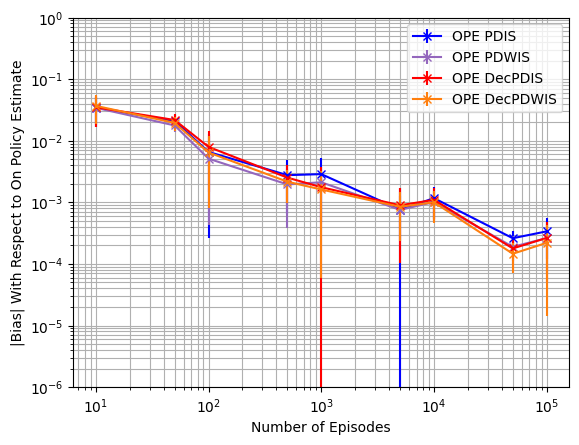

In [ ]:
biases1 = {
      'On Policy': [0]*9,
      'OPE IS': [0.05612000000000001, 0.02883200000000001, 0.018983999999999817, 0.0026680000000002327, 0.0008591999999997992, 0.002509519999999769, 0.0012865600000002793, 0.00023072799999992213, 0.00015364799999979987],
      'OPE PDIS': [0.05612000000000001, 0.02883200000000001, 0.018983999999999817, 0.0026680000000002327, 0.0008591999999997992, 0.002509519999999769, 0.0012865600000002793, 0.00023072799999992213, 0.00015364799999979987],
      'OPE PDWIS': [0.028196661394496114, 0.023514264694179554, 0.01421006750003727, 0.0013477346296857711, 0.001387975028066672, 0.0015014170654031756, 0.000976925774973871, 0.00013762311587956456, 0.00012693903183216346],
      'OPE DecIS': [0.05899999999999998, 0.027200000000000005, 0.020039999999999954, 0.003052000000000154, 0.00010800000000006319, 0.0020803999999996943, 0.0012880000000001779, 0.00017068000000009808, 0.00026087999999997664],
      'OPE DecPDIS': [0.05899999999999998, 0.027200000000000005, 0.020039999999999954, 0.003052000000000154, 0.00010800000000006319, 0.0020803999999996943, 0.0012880000000001779, 0.00017068000000009808, 0.00026087999999997664],
      'OPE DecPDWIS': [0.03695140909394507, 0.023969939069283828, 0.015752472365728094, 0.0018371328286206333, 0.0008323188508281259, 0.0015377479751163222, 0.0010478341618387406, 0.0001313171748104051, 0.00018031730028734448],
  }

biases2 = {
 'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'OPE IS': [0.012280000000000513, 0.020272000000000068, 0.0036400000000000876, 0.0006615999999999289, 0.004194799999999832, 9.296000000036386e-05, 0.0022708000000000172, 0.00021950399999992598, 0.00015280799999950467],
 'OPE PDIS': [0.012280000000001089, 0.02027200000000021, 0.003639999999999895, 0.0006616000000001481, 0.004194799999999893, 9.296000000003032e-05, 0.002270799999999915, 0.0002195039999998582, 0.00015280799999959258],
 'OPE PDWIS': [0.028562737217843196, 0.02077587668129173, 0.004079045520675838, 0.0004930888953749412, 0.0028183207226756064, 0.0006813228683567144, 0.0019063470121052529, 0.00018927688616439563, 0.0001198765640984646],
 'OPE DecIS': [0.02260000000000044, 0.02368000000000014, 0.008559999999999632, 0.0014119999999999621, 0.0028579999999996993, 0.00048800000000036173, 0.0020068000000000867, 0.00014184000000002993, 8.375999999982262e-05],
 'OPE DecPDIS': [0.02260000000000044, 0.02368000000000014, 0.008559999999999632, 0.0014119999999999621, 0.0028579999999996993, 0.00048800000000036173, 0.0020068000000000867, 0.00014184000000002993, 8.375999999982262e-05],
 'OPE DecPDWIS': [0.03818968654201079, 0.024784232859300526, 0.009088543601782214, 0.0019569570754059307, 0.002179483961233676, 0.0007877427489802527, 0.0018436607373594931, 0.00013599508329180865, 7.411042484350417e-05]
 }

biases3 = {
    'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'OPE IS': [0.053079999999999995, 0.014136000000000058, 0.005451999999999895, 0.004406400000000114, 0.0011827999999997757, 0.0010915199999998269, 0.0007941600000000153, 0.00014835199999995393, 0.00029938399999959275],
    'OPE PDIS': [0.053079999999999995, 0.014136000000000058, 0.005451999999999895, 0.004406400000000114, 0.0011827999999997757, 0.0010915199999998269, 0.0007941600000000153, 0.00014835199999995393, 0.00029938399999959275],
    'OPE PDWIS': [0.06296234392107859, 0.013135820789458661, 0.0040340892262723, 0.002865099602387299, 0.0010476284579655206, 0.0011467711565012013, 0.0009464367615881216, 4.807990477402005e-05, 0.0002345124450890639],
    'OPE DecIS': [0.05260000000000006, 0.01596000000000007, 0.005619999999999499, 0.003768000000000063, 0.00024199999999924664, 0.0015815999999998197, 0.0008483999999999124, 8.192000000007014e-05, 0.00016903999999979787],
    'OPE DecPDIS': [0.05260000000000006, 0.01596000000000007, 0.005619999999999499, 0.003768000000000063, 0.00024199999999924664, 0.0015815999999998197, 0.0008483999999999124, 8.192000000007014e-05, 0.00016903999999979787],
    'OPE DecPDWIS': [0.0684144346408214, 0.01664111443481242, 0.005815636357761799, 0.0028274720772273484, 0.0003434659416367981, 0.0015391025124564083, 0.0009198451722849935, 1.8577292740531115e-05, 0.00014812637711494842]
}

biases4 = {
    'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'OPE IS': [0.031360000000000304, 0.016671999999999822, 0.0028160000000003647, 0.00026959999999954186, 0.0011176000000000276, 8.47200000001989e-05, 0.0003671600000001454, 0.0003508400000003183, 0.0007475560000000551],
    'OPE PDIS': [0.031360000000000304, 0.016671999999999822, 0.0028160000000003647, 0.00026959999999954186, 0.0011176000000000276, 8.47200000001989e-05, 0.0003671600000001454, 0.0003508400000003183, 0.0007475560000000551],
    'OPE PDWIS': [0.014894427686291631, 0.013532851481144298, 0.002086850999110075, 0.0004941783184416296, 0.00029319182110985165, 0.0001012609899021232, 0.0002692116037412155, 0.0002843253786986113, 0.000638817663338035],
    'OPE DecIS': [0.03039999999999989, 0.014799999999999596, 0.002360000000000497, 9.999999999861885e-05, 0.0003280000000003332, 0.00017880000000010412, 0.00021620000000003456, 0.00023492000000013984, 0.0006773799999998718],
    'OPE DecPDIS': [0.03039999999999989, 0.014799999999999596, 0.002360000000000497, 9.999999999861885e-05, 0.0003280000000003332, 0.00017880000000010412, 0.00021620000000003456, 0.00023492000000013984, 0.0006773799999998718],
    'OPE DecPDWIS': [0.012952824952825, 0.01163580014352151, 0.0012074860326321, 0.0003289311484513827, 0.000308512723957573, 7.919928553081309e-05, 0.0001698616762226016, 0.00020869287856188214, 0.0006238037739641454]
}

biases5 = {
    'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'OPE IS': [0.019160000000000378, 0.02483200000000028, 0.0019800000000002884, 0.0058055999999998146, 0.006989199999999954, 2.8560000000587147e-05, 0.0011196799999999801, 0.000356736000000147, 0.00033671600000009533],
    'OPE PDIS': [0.019160000000000378, 0.02483200000000028, 0.0019800000000002884, 0.0058055999999998146, 0.006989199999999954, 2.8560000000587147e-05, 0.0011196799999999801, 0.000356736000000147, 0.00033671600000009533],
    'OPE PDWIS': [0.03647941652536118, 0.017557451085897534, 0.0011588612517945405, 0.004564130657347624, 0.005030618963773385, 0.00033611496478475983, 0.0009569510872262327, 0.00028770575065817166, 0.00019364336160081815],
    'OPE DecIS': [0.009799999999999576, 0.026800000000000393, 0.0030600000000000466, 0.004259999999999851, 0.005266000000000115, 0.00014279999999989876, 0.0011275999999998188, 0.000262800000000303, 0.00013010000000026982],
    'OPE DecPDIS': [0.009799999999999576, 0.026800000000000393, 0.0030600000000000466, 0.004259999999999851, 0.005266000000000115, 0.00014279999999989876, 0.0011275999999998188, 0.000262800000000303, 0.00013010000000026982],
    'OPE DecPDWIS': [0.027523013218665668, 0.02042382366691572, 0.0003669478380220205, 0.0038590353533443796, 0.004417246159664326, 0.00028019493954374916, 0.0010253163089390333, 0.00023689478312105075, 7.439137017125407e-05]
}

biases = [biases1, biases2, biases3, biases4, biases5]

plot_graphs(biases, 'bias', 10**(-6), 10**(0))

Process readings for policy divergence plot

In [ ]:
def print_specific_mean_std(r_dict_list):
  r_1000 = np.zeros((5, 7))
  r_100000 = np.zeros((5, 7))

  for r in range(len(r_dict_list)):
    r_dict = r_dict_list[r]
    legends = list(r_dict.keys())
    for l in range(len(legends)):
      legend = legends[l]
      r_1000[r, l] = r_dict[legend][4]
      r_100000[r, l] = r_dict[legend][-1]

  print('1000 EPISODES')
  print(list(np.mean(r_1000, axis = 0)))
  print(list(np.std(r_1000, axis = 0)))
  print('\n100000 EPISODES')
  print(list(np.mean(r_100000, axis = 0)))
  print(list(np.std(r_100000, axis = 0)))

print_specific_mean_std(biases)

1000 EPISODES
[0.0, 0.0028687199999998777, 0.00286871999999989, 0.0021155469987182074, 0.0017603999999998917, 0.0017603999999998917, 0.0016162055274640999]
[0.0, 0.00239515184186726, 0.0023951518418672667, 0.0016722634268590993, 0.002028876102673659, 0.002028876102673659, 0.0015561179942837594]

100000 EPISODES
[0.0, 0.00033802239999980953, 0.00033802239999982715, 0.00026275781319170903, 0.0002642319999999478, 0.0002642319999999478, 0.00022014984927623934]
[0.0, 0.0002179498545572048, 0.00021794985455718985, 0.00019279907253017502, 0.00021462784482910154, 0.00021462784482910154, 0.00020605026141051782]


#### Variance

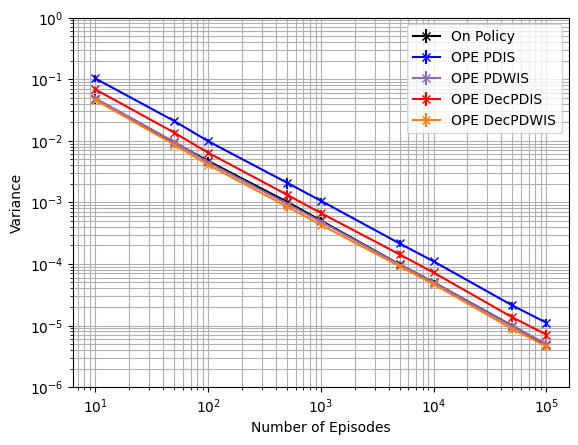

In [ ]:
vars1 = {
      'On Policy': [0.050875000000000004, 0.010656960000000002, 0.005896039999999998, 0.0010015084000000013, 0.0005751776000000008, 9.530807600000008e-05, 4.694874400000001e-05, 9.28949355999997e-06, 5.508006560000028e-06],
      'OPE IS': [0.10857922560000001, 0.022924210175999975, 0.010307718144000014, 0.0025339115519999993, 0.0011380189593599992, 0.0001883343568896, 0.00011209430384639984, 1.8242594390016054e-05, 1.1691006160895931e-05],
      'OPE PDIS': [0.10857922560000001, 0.022924210175999975, 0.010307718144000014, 0.0025339115519999993, 0.0011380189593599992, 0.0001883343568896, 0.00011209430384639984, 1.8242594390016054e-05, 1.1691006160895931e-05],
      'OPE PDWIS': [0.05070222213520985, 0.010141036181600487, 0.004545583452065055, 0.0011567179717237902, 0.0005217692839830126, 8.614151114472685e-05, 5.129025906136583e-05, 8.414563416101902e-06, 5.339152916051879e-06],
      'OPE DecIS': [0.07113599999999995, 0.015281280000000003, 0.007217510400000003, 0.0016701327359999987, 0.0007511240159999984, 0.00012193415423999956, 6.994439999999983e-05, 1.1296429689600044e-05, 7.452491097599944e-06],
      'OPE DecPDIS': [0.07113599999999995, 0.015281280000000003, 0.007217510400000003, 0.0016701327359999987, 0.0007511240159999984, 0.00012193415423999956, 6.994439999999983e-05, 1.1296429689600044e-05, 7.452491097599944e-06],
      'OPE DecPDWIS': [0.04687199842832505, 0.009615915209985344, 0.004437824548822238, 0.001091305187446642, 0.0004909223894393333, 8.028798196360361e-05, 4.720040040581919e-05, 7.62774987791756e-06, 4.968916133728696e-06],
  }

vars2 = {
         'On Policy': [0.04253899999999998, 0.00951824, 0.00487116, 0.0010492844000000012, 0.0005708971000000014, 9.979198400000015e-05, 5.18789000000002e-05, 1.0842022239999978e-05, 5.1018723599999745e-06],
         'OPE IS': [0.08354396159999997, 0.02124173721599998, 0.009620352000000013, 0.0015956844134399977, 0.0008887846809599996, 0.00020789132451840047, 9.940478976000033e-05, 1.6908033245183836e-05, 9.528718887936173e-06],
         'OPE PDIS': [0.08354396159999997, 0.02124173721599998, 0.009620352000000013, 0.0015956844134399977, 0.0008887846809599996, 0.00020789132451840047, 9.940478976000033e-05, 1.6908033245183836e-05, 9.528718887936173e-06],
         'OPE PDWIS': [0.03920664837234275, 0.009838275673823824, 0.00445170756459724, 0.0007264152589163586, 0.000408063498153245, 9.40944919268563e-05, 4.536931998056939e-05, 7.627189677202588e-06, 4.3159739924334475e-06],
         'OPE DecIS': [0.05686703999999997, 0.013138041599999999, 0.005798750400000007, 0.0010471080959999991, 0.0005445128159999997, 0.0001392357600000004, 6.478373375999994e-05, 1.1713925606400084e-05, 6.5279291183999585e-06],
         'OPE DecPDIS': [0.05686703999999997, 0.013138041599999999, 0.005798750400000007, 0.0010471080959999991, 0.0005445128159999997, 0.0001392357600000004, 6.478373375999994e-05, 1.1713925606400084e-05, 6.5279291183999585e-06],
         'OPE DecPDWIS': [0.037463098772677526, 0.008488254291043567, 0.003724197832518935, 0.0006670363340235172, 0.0003473760791805003, 8.907789687766388e-05, 4.149303970520548e-05, 7.501872831262186e-06, 4.178034598895594e-06]
  }

vars3 = {
    'On Policy': [0.04693899999999998, 0.010307000000000002, 0.004754590000000001, 0.001150201600000002, 0.0005260139000000014, 9.099599999999989e-05, 4.293599599999997e-05, 9.387293440000007e-06, 4.72930043999999e-06],
    'OPE IS': [0.0925019136, 0.017913544703999983, 0.008702954496000009, 0.0017409893990400016, 0.0011488343961599992, 0.00019133471784960016, 0.00011959571773440042, 2.2590291050496105e-05, 9.17219320934405e-06],
    'OPE PDIS': [0.0925019136, 0.017913544703999983, 0.008702954496000009, 0.0017409893990400016, 0.0011488343961599992, 0.00019133471784960016, 0.00011959571773440042, 2.2590291050496105e-05, 9.17219320934405e-06],
    'OPE PDWIS': [0.04509625532838567, 0.008327494847830188, 0.0039945150286662765, 0.0007920035318997096, 0.0005254120208698233, 8.662174628724971e-05, 5.4350359035923076e-05, 1.0393888341339815e-05, 4.2057692773463635e-06],
    'OPE DecIS': [0.06375743999999997, 0.011616998399999998, 0.005855889600000005, 0.0011155800959999989, 0.0007208789759999993, 0.00012929252544000006, 7.737741503999994e-05, 1.3822938777600159e-05, 5.842571486399929e-06],
    'OPE DecPDIS': [0.06375743999999997, 0.011616998399999998, 0.005855889600000005, 0.0011155800959999989, 0.0007208789759999993, 0.00012929252544000006, 7.737741503999994e-05, 1.3822938777600159e-05, 5.842571486399929e-06],
    'OPE DecPDWIS': [0.04386763042104493, 0.007482243173689387, 0.0037808488200591476, 0.0007097726758541041, 0.000459989235094706, 8.258119153459775e-05, 4.9453474853090485e-05, 8.852257233965412e-06, 3.739841050726464e-06]
  }

vars4 = {
    'On Policy': [0.06259999999999999, 0.008829439999999997, 0.004022640000000003, 0.0009492044000000015, 0.0004465324000000009, 0.00010926791599999976, 5.507821099999988e-05, 1.1269093560000128e-05, 4.613504989999957e-06],
    'OPE IS': [0.10729175039999998, 0.022155964415999974, 0.009894841344000009, 0.002609180835839999, 0.001133140746239999, 0.0002607447638016, 0.00010843046461440017, 2.303085404160026e-05, 1.143555359846388e-05],
    'OPE PDIS': [0.10729175039999998, 0.022155964415999974, 0.009894841344000009, 0.002609180835839999, 0.001133140746239999, 0.0002607447638016, 0.00010843046461440017, 2.303085404160026e-05, 1.143555359846388e-05],
    'OPE PDWIS': [0.04935595961129551, 0.010382889408471752, 0.004600342380700498, 0.0012078554874409104, 0.0005256644270147465, 0.00011922380457853628, 4.9022153811638955e-05, 1.0571402220721975e-05, 5.313066964028039e-06],
    'OPE DecIS': [0.06960383999999997, 0.013759200000000004, 0.006122462400000003, 0.0015581231999999999, 0.0007038977759999999, 0.00016408475136000004, 7.219897776000019e-05, 1.4346275961599898e-05, 6.603241881599877e-06],
    'OPE DecPDIS': [0.06960383999999997, 0.013759200000000004, 0.006122462400000003, 0.0015581231999999999, 0.0007038977759999999, 0.00016408475136000004, 7.219897776000019e-05, 1.4346275961599898e-05, 6.603241881599877e-06],
    'OPE DecPDWIS': [0.04642532839772641, 0.0087724338511068, 0.003954829768377336, 0.0010008480614603407, 0.0004531779444107993, 0.00010496887145334441, 4.6165007644572864e-05, 9.182075193923289e-06, 4.2238461500574416e-06]
  }

vars5 = {
    'On Policy': [0.037499, 0.007712000000000001, 0.003976190000000002, 0.0009656844000000017, 0.0004219075000000013, 9.560589999999978e-05, 5.505481600000005e-05, 8.581787839999995e-06, 4.17392890999998e-06],
    'OPE IS': [0.12059965439999999, 0.02056214937599998, 0.010708070400000012, 0.0019606398566399995, 0.0010017051033599992, 0.00022671424880639962, 0.00011131521269760001, 2.516494458470412e-05, 1.3817518009343848e-05],
    'OPE PDIS': [0.12059965439999999, 0.02056214937599998, 0.010708070400000012, 0.0019606398566399995, 0.0010017051033599992, 0.00022671424880639962, 0.00011131521269760001, 2.516494458470412e-05, 1.3817518009343848e-05],
    'OPE PDWIS': [0.05933508858217966, 0.009290193961962618, 0.004747269271401352, 0.0009001350275730722, 0.0004638416881936261, 0.00010169062475058778, 4.9836672777074504e-05, 1.1389515941689317e-05, 6.2343869701255006e-06],
    'OPE DecIS': [0.07951535999999998, 0.014093280000000001, 0.007027358400000004, 0.0012718655999999994, 0.0006382765439999995, 0.00016035906816000013, 7.861451183999986e-05, 1.6812407519999992e-05, 9.298821239999878e-06],
    'OPE DecPDIS': [0.07951535999999998, 0.014093280000000001, 0.007027358400000004, 0.0012718655999999994, 0.0006382765439999995, 0.00016035906816000013, 7.861451183999986e-05, 1.6812407519999992e-05, 9.298821239999878e-06],
    'OPE DecPDWIS': [0.05431578653462609, 0.00897808652016839, 0.0044356586415365525, 0.0008160046769748484, 0.00041114615287857583, 0.00010271260000867011, 5.0286354622588814e-05, 1.0765127539759626e-05, 5.953053291425709e-06]
  }

vars = [vars1, vars2, vars3, vars4, vars5]

plot_graphs(vars, 'var', 10**(-6), 10**0)

Process readings for policy divergence plot

In [ ]:
print_specific_mean_std(vars)

1000 EPISODES
[0.0005081057000000012, 0.0010620967772159995, 0.0010620967772159995, 0.0004889501836428908, 0.0006717380255999994, 0.0006717380255999994, 0.00043252236020078295]
[6.321946577904625e-05, 0.00010199909293326349, 0.00010199909293326349, 4.674951768883348e-05, 7.356241259287966e-05, 7.356241259287966e-05, 4.959531671766188e-05]

100000 EPISODES
[4.825322651999986e-06, 1.1128997973196777e-05, 1.1128997973196777e-05, 5.081670023997046e-06, 7.145010964799918e-06, 7.145010964799918e-06, 4.6127382449667815e-06]
[4.5187118816901563e-07, 1.6749894073544037e-06, 1.6749894073544037e-06, 7.486108297618735e-07, 1.1919811301515036e-06, 1.1919811301515036e-06, 7.778767184214051e-07]


#### MSE

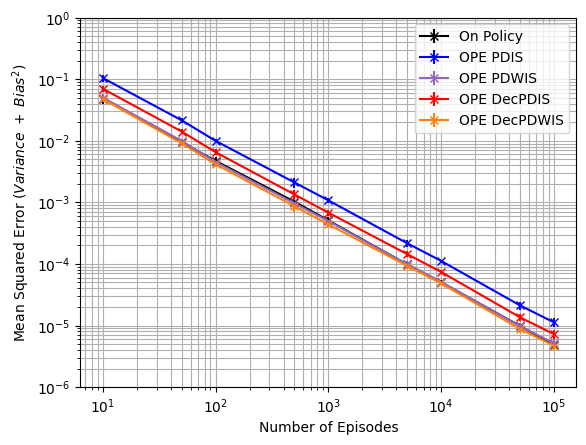

In [ ]:
MSEs1 = {
      'On Policy': [0.050875000000000004, 0.010656960000000002, 0.005896039999999998, 0.0010015084000000013, 0.0005751776000000008, 9.530807600000008e-05, 4.694874400000001e-05, 9.28949355999997e-06, 5.508006560000028e-06],
      'OPE IS': [0.11172868000000001, 0.023755494399999976, 0.010668110400000007, 0.0025410297760000006, 0.0011387571839999988, 0.00019463204751999884, 0.00011374954048000056, 1.8295829800000018e-05, 1.171461386879987e-05],
      'OPE PDIS': [0.11172868000000001, 0.023755494399999976, 0.010668110400000007, 0.0025410297760000006, 0.0011387571839999988, 0.00019463204751999884, 0.00011374954048000056, 1.8295829800000018e-05, 1.171461386879987e-05],
      'OPE PDWIS': [0.051497273849005716, 0.010693956825708426, 0.004747509470420671, 0.0011585343603558445, 0.0005236957586615493, 8.839576434901073e-05, 5.224464303117413e-05, 8.433503538126303e-06, 5.355266433854366e-06],
      'OPE DecIS': [0.07461699999999995, 0.016021120000000003, 0.007619112000000001, 0.0016794474399999997, 0.0007511356799999984, 0.0001262622183999983, 7.160334400000013e-05, 1.1325561352000078e-05, 7.5205494719999315e-06],
      'OPE DecPDIS': [0.07461699999999995, 0.016021120000000003, 0.007619112000000001, 0.0016794474399999997, 0.0007511356799999984, 0.0001262622183999983, 7.160334400000013e-05, 1.1325561352000078e-05, 7.5205494719999315e-06],
      'OPE DecPDWIS': [0.048237405062353134, 0.010190473188970523, 0.004685964934455265, 0.0010946802444766377, 0.0004916151441087771, 8.265265079857796e-05, 4.829835683653548e-05, 7.644994078317746e-06, 5.001430462511612e-06],
  }

MSEs2 = {
    'On Policy': [0.04253899999999998, 0.00951824, 0.00487116, 0.0010492844000000012, 0.0005708971000000014, 9.979198400000015e-05, 5.18789000000002e-05, 1.0842022239999978e-05, 5.1018723599999745e-06],
    'OPE IS': [0.08369475999999999, 0.021652691199999987, 0.009633601600000012, 0.001596122127999998, 0.0009063810279999987, 0.00020789996608000047, 0.00010456132239999994, 1.6956215251199773e-05, 9.552069172800049e-06],
    'OPE PDIS': [0.08369475999999999, 0.021652691199999987, 0.009633601600000012, 0.001596122127999998, 0.0009063810279999987, 0.00020789996608000047, 0.00010456132239999994, 1.6956215251199773e-05, 9.552069172800049e-06],
    'OPE PDWIS': [0.040022478329718315, 0.010269912725700065, 0.004468346176956985, 0.0007266583955751007, 0.00041600642984910777, 9.455869277780212e-05, 4.9003478911132016e-05, 7.663015416838678e-06, 4.330344383053501e-06],
    'OPE DecIS': [0.05737779999999999, 0.013698784000000006, 0.005872024000000001, 0.001049101839999999, 0.000552680979999998, 0.00013947390400000076, 6.881098000000029e-05, 1.1734044192000092e-05, 6.534944855999929e-06],
    'OPE DecPDIS': [0.05737779999999999, 0.013698784000000006, 0.005872024000000001, 0.001049101839999999, 0.000552680979999998, 0.00013947390400000076, 6.881098000000029e-05, 1.1734044192000092e-05, 6.534944855999929e-06],
    'OPE DecPDWIS': [0.038921550930854566, 0.009102512489467598, 0.0038067994573204316, 0.0006708660150184985, 0.00035212622951777514, 8.969843551623485e-05, 4.489212461968643e-05, 7.520367493941732e-06, 4.183526953966079e-06]
  }

MSEs3 = {
    'On Policy': [0.04693899999999998, 0.010307000000000002, 0.004754590000000001, 0.001150201600000002, 0.0005260139000000014, 9.099599999999989e-05, 4.293599599999997e-05, 9.387293440000007e-06, 4.72930043999999e-06],
    'OPE IS': [0.0953194, 0.018113371199999985, 0.008732678800000008, 0.0017604057600000026, 0.0011502334119999986, 0.0001925261337599998, 0.00012022640784000044, 2.261229936640009e-05, 9.261823988799806e-06],
    'OPE PDIS': [0.0953194, 0.018113371199999985, 0.008732678800000008, 0.0017604057600000026, 0.0011502334119999986, 0.0001925261337599998, 0.00012022640784000044, 2.261229936640009e-05, 9.261823988799806e-06],
    'OPE PDWIS': [0.04906051208042185, 0.008500044635642962, 0.004010788904551803, 0.0008002123276313095, 0.0005265095462557625, 8.793683037263282e-05, 5.524610157960849e-05, 1.0396200018582894e-05, 4.260765364248015e-06],
    'OPE DecIS': [0.06652419999999998, 0.01187172, 0.005887473999999999, 0.0011297779199999994, 0.000720937539999999, 0.0001317939839999995, 7.809719759999979e-05, 1.382964966400017e-05, 5.871146007999861e-06],
    'OPE DecPDIS': [0.06652419999999998, 0.01187172, 0.005887473999999999, 0.0011297779199999994, 0.000720937539999999, 0.0001317939839999995, 7.809719759999979e-05, 1.382964966400017e-05, 5.871146007999861e-06],
    'OPE DecPDWIS': [0.04854816528826816, 0.007759169863321909, 0.0038146704463048685, 0.0007177672742016045, 0.0004601072039477705, 8.495002807844738e-05, 5.0299589994066495e-05, 8.85260234977098e-06, 3.761782474323664e-06]
  }

MSEs4 = {
    'On Policy': [0.06259999999999999, 0.008829439999999997, 0.004022640000000003, 0.0009492044000000015, 0.0004465324000000009, 0.00010926791599999976, 5.507821099999988e-05, 1.1269093560000128e-05, 4.613504989999957e-06],
    'OPE IS': [0.1082752, 0.02243391999999997, 0.00990277120000001, 0.002609253519999999, 0.001134389775999999, 0.00026075194128000005, 0.00010856527108000027, 2.3153942747200482e-05, 1.1994393571599963e-05],
    'OPE PDIS': [0.1082752, 0.02243391999999997, 0.00990277120000001, 0.002609253519999999, 0.001134389775999999, 0.00026075194128000005, 0.00010856527108000027, 2.3153942747200482e-05, 1.1994393571599963e-05],
    'OPE PDWIS': [0.04957780358739768, 0.010566027477682462, 0.004604697327792985, 0.0012080996996513282, 0.0005257503884587122, 0.00011923405836661223, 4.909462869922787e-05, 1.0652243141694084e-05, 5.721154971020706e-06],
    'OPE DecIS': [0.07052799999999997, 0.013978239999999992, 0.0061280320000000055, 0.0015581331999999996, 0.0007040053600000001, 0.00016411672080000008, 7.22457202000002e-05, 1.4401463367999964e-05, 7.062085545999703e-06],
    'OPE DecPDIS': [0.07052799999999997, 0.013978239999999992, 0.0061280320000000055, 0.0015581331999999996, 0.0007040053600000001, 0.00016411672080000008, 7.22457202000002e-05, 1.4401463367999964e-05, 7.062085545999703e-06],
    'OPE DecPDWIS': [0.046593104071984935, 0.008907825696086774, 0.003956287790896337, 0.0010009562571607622, 0.00045327312451164304, 0.000104975143980173, 4.6193860633622016e-05, 9.225627911485733e-06, 4.612977298469352e-06]
  }

MSEs5 = {
    'On Policy': [0.037499, 0.007712000000000001, 0.003976190000000002, 0.0009656844000000017, 0.0004219075000000013, 9.560589999999978e-05, 5.505481600000005e-05, 8.581787839999995e-06, 4.17392890999998e-06],
    'OPE IS': [0.12096676, 0.021178777599999993, 0.010711990800000014, 0.0019943448479999974, 0.0010505540199999986, 0.00022671506447999965, 0.00011256889599999997, 2.5292205158400225e-05, 1.3930895673999912e-05],
    'OPE PDIS': [0.12096676, 0.021178777599999993, 0.010711990800000014, 0.0019943448479999974, 0.0010505540199999986, 0.00022671506447999965, 0.00011256889599999997, 2.5292205158400225e-05, 1.3930895673999912e-05],
    'OPE PDWIS': [0.060665836412210454, 0.009598458050596302, 0.004748612230802263, 0.0009209663162304127, 0.0004891488153523025, 0.00010180359802014004, 5.075242816041797e-05, 1.14722905406511e-05, 6.271884721617566e-06],
    'OPE DecIS': [0.07961139999999997, 0.014811520000000022, 0.007036722000000004, 0.0012900131999999981, 0.0006660073000000007, 0.0001603794600000001, 7.988599359999945e-05, 1.688147136000015e-05, 9.315747249999948e-06],
    'OPE DecPDIS': [0.07961139999999997, 0.014811520000000022, 0.007036722000000004, 0.0012900131999999981, 0.0006660073000000007, 0.0001603794600000001, 7.988599359999945e-05, 1.688147136000015e-05, 9.315747249999948e-06],
    'OPE DecPDWIS': [0.055073302791260936, 0.009395219093345657, 0.0044357932922523815, 0.0008308968308332102, 0.00043065821651364506, 0.00010279110921281604, 5.133762815596518e-05, 1.0821246678029596e-05, 5.958587367381666e-06]
  }

MSEs = [MSEs1, MSEs2, MSEs3, MSEs4, MSEs5]

plot_graphs(MSEs, 'MSE', 10**(-6), 10**0)

Process readings for policy divergence plot

In [ ]:
print_specific_mean_std(MSEs)

1000 EPISODES
[0.0005081057000000012, 0.0010760630839999987, 0.0010760630839999987, 0.0004962221877154869, 0.0006789533719999991, 0.0006789533719999991, 0.00043755598371992215]
[6.321946577904625e-05, 9.195270871991071e-05, 9.195270871991071e-05, 4.249384951654431e-05, 6.886635726571032e-05, 6.886635726571032e-05, 4.6954874008671106e-05]

100000 EPISODES
[4.825322651999986e-06, 1.1290759255199919e-05, 1.1290759255199919e-05, 5.1878831747588315e-06, 7.260894626399875e-06, 7.260894626399875e-06, 4.703660911330475e-06]
[4.5187118816901563e-07, 1.7195752854956678e-06, 1.7195752854956678e-06, 7.851592872216118e-07, 1.1651411318374902e-06, 1.1651411318374902e-06, 7.522506174209901e-07]


#### ESS

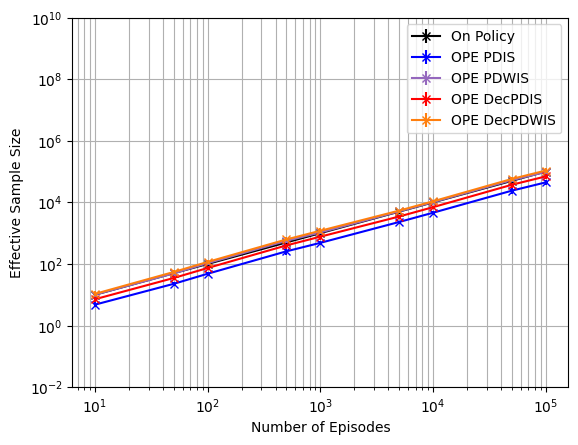

In [ ]:
EPISODES = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

vars1 = {
      'On Policy': [0.050875000000000004, 0.010656960000000002, 0.005896039999999998, 0.0010015084000000013, 0.0005751776000000008, 9.530807600000008e-05, 4.694874400000001e-05, 9.28949355999997e-06, 5.508006560000028e-06],
      'OPE IS': [0.10857922560000001, 0.022924210175999975, 0.010307718144000014, 0.0025339115519999993, 0.0011380189593599992, 0.0001883343568896, 0.00011209430384639984, 1.8242594390016054e-05, 1.1691006160895931e-05],
      'OPE PDIS': [0.10857922560000001, 0.022924210175999975, 0.010307718144000014, 0.0025339115519999993, 0.0011380189593599992, 0.0001883343568896, 0.00011209430384639984, 1.8242594390016054e-05, 1.1691006160895931e-05],
      'OPE PDWIS': [0.05070222213520985, 0.010141036181600487, 0.004545583452065055, 0.0011567179717237902, 0.0005217692839830126, 8.614151114472685e-05, 5.129025906136583e-05, 8.414563416101902e-06, 5.339152916051879e-06],
      'OPE DecIS': [0.07113599999999995, 0.015281280000000003, 0.007217510400000003, 0.0016701327359999987, 0.0007511240159999984, 0.00012193415423999956, 6.994439999999983e-05, 1.1296429689600044e-05, 7.452491097599944e-06],
      'OPE DecPDIS': [0.07113599999999995, 0.015281280000000003, 0.007217510400000003, 0.0016701327359999987, 0.0007511240159999984, 0.00012193415423999956, 6.994439999999983e-05, 1.1296429689600044e-05, 7.452491097599944e-06],
      'OPE DecPDWIS': [0.04687199842832505, 0.009615915209985344, 0.004437824548822238, 0.001091305187446642, 0.0004909223894393333, 8.028798196360361e-05, 4.720040040581919e-05, 7.62774987791756e-06, 4.968916133728696e-06],
  }

ESS1 = calculate_ESS(vars1, EPISODES)

vars2 = {
         'On Policy': [0.04253899999999998, 0.00951824, 0.00487116, 0.0010492844000000012, 0.0005708971000000014, 9.979198400000015e-05, 5.18789000000002e-05, 1.0842022239999978e-05, 5.1018723599999745e-06],
         'OPE IS': [0.08354396159999997, 0.02124173721599998, 0.009620352000000013, 0.0015956844134399977, 0.0008887846809599996, 0.00020789132451840047, 9.940478976000033e-05, 1.6908033245183836e-05, 9.528718887936173e-06],
         'OPE PDIS': [0.08354396159999997, 0.02124173721599998, 0.009620352000000013, 0.0015956844134399977, 0.0008887846809599996, 0.00020789132451840047, 9.940478976000033e-05, 1.6908033245183836e-05, 9.528718887936173e-06],
         'OPE PDWIS': [0.03920664837234275, 0.009838275673823824, 0.00445170756459724, 0.0007264152589163586, 0.000408063498153245, 9.40944919268563e-05, 4.536931998056939e-05, 7.627189677202588e-06, 4.3159739924334475e-06],
         'OPE DecIS': [0.05686703999999997, 0.013138041599999999, 0.005798750400000007, 0.0010471080959999991, 0.0005445128159999997, 0.0001392357600000004, 6.478373375999994e-05, 1.1713925606400084e-05, 6.5279291183999585e-06],
         'OPE DecPDIS': [0.05686703999999997, 0.013138041599999999, 0.005798750400000007, 0.0010471080959999991, 0.0005445128159999997, 0.0001392357600000004, 6.478373375999994e-05, 1.1713925606400084e-05, 6.5279291183999585e-06],
         'OPE DecPDWIS': [0.037463098772677526, 0.008488254291043567, 0.003724197832518935, 0.0006670363340235172, 0.0003473760791805003, 8.907789687766388e-05, 4.149303970520548e-05, 7.501872831262186e-06, 4.178034598895594e-06]
  }

ESS2 = calculate_ESS(vars2, EPISODES)

vars3 = {
    'On Policy': [0.04693899999999998, 0.010307000000000002, 0.004754590000000001, 0.001150201600000002, 0.0005260139000000014, 9.099599999999989e-05, 4.293599599999997e-05, 9.387293440000007e-06, 4.72930043999999e-06],
    'OPE IS': [0.0925019136, 0.017913544703999983, 0.008702954496000009, 0.0017409893990400016, 0.0011488343961599992, 0.00019133471784960016, 0.00011959571773440042, 2.2590291050496105e-05, 9.17219320934405e-06],
    'OPE PDIS': [0.0925019136, 0.017913544703999983, 0.008702954496000009, 0.0017409893990400016, 0.0011488343961599992, 0.00019133471784960016, 0.00011959571773440042, 2.2590291050496105e-05, 9.17219320934405e-06],
    'OPE PDWIS': [0.04509625532838567, 0.008327494847830188, 0.0039945150286662765, 0.0007920035318997096, 0.0005254120208698233, 8.662174628724971e-05, 5.4350359035923076e-05, 1.0393888341339815e-05, 4.2057692773463635e-06],
    'OPE DecIS': [0.06375743999999997, 0.011616998399999998, 0.005855889600000005, 0.0011155800959999989, 0.0007208789759999993, 0.00012929252544000006, 7.737741503999994e-05, 1.3822938777600159e-05, 5.842571486399929e-06],
    'OPE DecPDIS': [0.06375743999999997, 0.011616998399999998, 0.005855889600000005, 0.0011155800959999989, 0.0007208789759999993, 0.00012929252544000006, 7.737741503999994e-05, 1.3822938777600159e-05, 5.842571486399929e-06],
    'OPE DecPDWIS': [0.04386763042104493, 0.007482243173689387, 0.0037808488200591476, 0.0007097726758541041, 0.000459989235094706, 8.258119153459775e-05, 4.9453474853090485e-05, 8.852257233965412e-06, 3.739841050726464e-06]
  }

ESS3 = calculate_ESS(vars3, EPISODES)

vars4 = {
    'On Policy': [0.06259999999999999, 0.008829439999999997, 0.004022640000000003, 0.0009492044000000015, 0.0004465324000000009, 0.00010926791599999976, 5.507821099999988e-05, 1.1269093560000128e-05, 4.613504989999957e-06],
    'OPE IS': [0.10729175039999998, 0.022155964415999974, 0.009894841344000009, 0.002609180835839999, 0.001133140746239999, 0.0002607447638016, 0.00010843046461440017, 2.303085404160026e-05, 1.143555359846388e-05],
    'OPE PDIS': [0.10729175039999998, 0.022155964415999974, 0.009894841344000009, 0.002609180835839999, 0.001133140746239999, 0.0002607447638016, 0.00010843046461440017, 2.303085404160026e-05, 1.143555359846388e-05],
    'OPE PDWIS': [0.04935595961129551, 0.010382889408471752, 0.004600342380700498, 0.0012078554874409104, 0.0005256644270147465, 0.00011922380457853628, 4.9022153811638955e-05, 1.0571402220721975e-05, 5.313066964028039e-06],
    'OPE DecIS': [0.06960383999999997, 0.013759200000000004, 0.006122462400000003, 0.0015581231999999999, 0.0007038977759999999, 0.00016408475136000004, 7.219897776000019e-05, 1.4346275961599898e-05, 6.603241881599877e-06],
    'OPE DecPDIS': [0.06960383999999997, 0.013759200000000004, 0.006122462400000003, 0.0015581231999999999, 0.0007038977759999999, 0.00016408475136000004, 7.219897776000019e-05, 1.4346275961599898e-05, 6.603241881599877e-06],
    'OPE DecPDWIS': [0.04642532839772641, 0.0087724338511068, 0.003954829768377336, 0.0010008480614603407, 0.0004531779444107993, 0.00010496887145334441, 4.6165007644572864e-05, 9.182075193923289e-06, 4.2238461500574416e-06]
  }

ESS4 = calculate_ESS(vars4, EPISODES)

vars5 = {
    'On Policy': [0.037499, 0.007712000000000001, 0.003976190000000002, 0.0009656844000000017, 0.0004219075000000013, 9.560589999999978e-05, 5.505481600000005e-05, 8.581787839999995e-06, 4.17392890999998e-06],
    'OPE IS': [0.12059965439999999, 0.02056214937599998, 0.010708070400000012, 0.0019606398566399995, 0.0010017051033599992, 0.00022671424880639962, 0.00011131521269760001, 2.516494458470412e-05, 1.3817518009343848e-05],
    'OPE PDIS': [0.12059965439999999, 0.02056214937599998, 0.010708070400000012, 0.0019606398566399995, 0.0010017051033599992, 0.00022671424880639962, 0.00011131521269760001, 2.516494458470412e-05, 1.3817518009343848e-05],
    'OPE PDWIS': [0.05933508858217966, 0.009290193961962618, 0.004747269271401352, 0.0009001350275730722, 0.0004638416881936261, 0.00010169062475058778, 4.9836672777074504e-05, 1.1389515941689317e-05, 6.2343869701255006e-06],
    'OPE DecIS': [0.07951535999999998, 0.014093280000000001, 0.007027358400000004, 0.0012718655999999994, 0.0006382765439999995, 0.00016035906816000013, 7.861451183999986e-05, 1.6812407519999992e-05, 9.298821239999878e-06],
    'OPE DecPDIS': [0.07951535999999998, 0.014093280000000001, 0.007027358400000004, 0.0012718655999999994, 0.0006382765439999995, 0.00016035906816000013, 7.861451183999986e-05, 1.6812407519999992e-05, 9.298821239999878e-06],
    'OPE DecPDWIS': [0.05431578653462609, 0.00897808652016839, 0.0044356586415365525, 0.0008160046769748484, 0.00041114615287857583, 0.00010271260000867011, 5.0286354622588814e-05, 1.0765127539759626e-05, 5.953053291425709e-06]
  }

ESS5 = calculate_ESS(vars5, EPISODES)

ESS = [ESS1, ESS2, ESS3, ESS4, ESS5]

plot_graphs(ESS, 'ESS', 10**(-2), 10**10)

Process readings for policy divergence plot

In [ ]:
print_specific_mean_std(ESS)

1000 EPISODES
[1000.0, 484.17550631175146, 484.17550631175146, 1052.320403327778, 767.8552679961202, 767.8552679961202, 1194.0253394512067]
[5.084229945850415e-14, 87.45819578272811, 87.45819578272811, 193.31802807131672, 147.94012314717577, 147.94012314717577, 235.27167301932204]

100000 EPISODES
[100000.0, 44553.51483602528, 44553.51483602528, 97520.56695923042, 69552.44777408153, 69552.44777408153, 107751.5184562304]
[9.203439287865707e-12, 8485.121677136523, 8485.121677136523, 18608.84241304122, 12893.968959704896, 12893.968959704896, 19922.177730307492]


## Varying Number of Episodes: Policy Divergence 2.56

**Note**: Restart the runtime before running all code in this section

### Rewrite Evaluation Policy

In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH = 'configs/1-step-MDP/evaluation-policy.csv'

HORIZONTAL_REWARD_PATH = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'

VERTICAL_REWARD_PATH = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write everything
main_data = [['state', 'up,right', 0.64],
             ['state', 'up,left', 0.16],
             ['state', 'down,right', 0.16],
             ['state', 'down,left', 0.04]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH)

horizontal_data = [['state', 'right', 0.8],
                   ['state', 'left', 0.2]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH)

vertical_data = [['state', 'up', 0.8],
                 ['state', 'down', 0.2]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH)

### Generate Data Set

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

Policy divergence: 2.56
Start state: state, start state no: 0


### Run Estimates on Collected Data Sets

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 2.56
VERSION_NUMBER = 4

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means = np.zeros((9, 7))
biases = np.zeros((9, 7))
vars = np.zeros((9, 7))
MSEs = np.zeros((9, 7))

#### 100 runs, 10 episodes

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 10)
gc.collect()

Mean on policy Q estimate: 1.636. Variance of on policy Q estimate: 0.027903999999999998
Mean off policy IS estimate: 1.55072. Bias1: 0.08528000000000072. Bias2: 0.0852799999999998. Variance: 0.5382844416. MSE: 0.5455571200000001
Mean off policy PDIS estimate: 1.55072. Bias1: 0.08528000000000072. Bias2: 0.0852799999999998 Variance: 0.5382844416. MSE: 0.5455571200000001
Mean off policy PDWIS estimate: 1.513153239040734. Bias1: 0.122846760959266. Bias2: 0.12284676095926583. Variance: 0.07041986114331643. MSE: 0.08551118782149947
Mean off policy DecIS estimate: 1.544. Bias1: 0.09200000000000015. Bias2: 0.09199999999999986. Variance: 0.16454399999999997. MSE: 0.173008
Mean off policy DecPDIS estimate: 1.544. Bias1: 0.09200000000000015. Bias2: 0.09199999999999986. Variance: 0.16454399999999997. MSE: 0.173008
Mean off policy DecPDWIS estimate: 1.5308823766002435. Bias1: 0.10511762339975646. Bias2: 0.10511762339975639. Variance: 0.032931007816118296. MSE: 0.04398072256533132


0

#### 1000 runs, 50 episodes

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 50)
gc.collect()

Mean on policy Q estimate: 1.6028. Variance of on policy Q estimate: 0.005568159999999999
Mean off policy IS estimate: 1.5404800000000003. Bias1: 0.062320000000000174. Bias2: 0.06231999999999971. Variance: 0.09285918720000003. MSE: 0.09674296960000005
Mean off policy PDIS estimate: 1.5404800000000003. Bias1: 0.062320000000000174. Bias2: 0.06231999999999971 Variance: 0.09285918720000003. MSE: 0.09674296960000005
Mean off policy PDWIS estimate: 1.5748557157052656. Bias1: 0.027944284294734344. Bias2: 0.02794428429473439. Variance: 0.00903741323505434. MSE: 0.009818296259799277
Mean off policy DecIS estimate: 1.5510400000000002. Bias1: 0.051759999999999896. Bias2: 0.051759999999999806. Variance: 0.0281693184. MSE: 0.03084841599999999
Mean off policy DecPDIS estimate: 1.5510400000000002. Bias1: 0.051759999999999896. Bias2: 0.051759999999999806. Variance: 0.0281693184. MSE: 0.03084841599999999
Mean off policy DecPDWIS estimate: 1.5706715053118716. Bias1: 0.03212849468812825. Bias2: 0.0321284

0

#### 1000 runs, 100 episodes

In [ ]:
means[2, :], biases[2, :], vars[2, :], MSEs[2, :] = evaluate_PE(100, 100)
gc.collect()

Mean on policy Q estimate: 1.6071. Variance of on policy Q estimate: 0.003096589999999996
Mean off policy IS estimate: 1.5894400000000002. Bias1: 0.017660000000000314. Bias2: 0.017659999999999787. Variance: 0.050200063999999996. MSE: 0.05051193960000001
Mean off policy PDIS estimate: 1.5894400000000002. Bias1: 0.017660000000000314. Bias2: 0.017659999999999787 Variance: 0.050200063999999996. MSE: 0.05051193960000001
Mean off policy PDWIS estimate: 1.593638938670602. Bias1: 0.01346106132939815. Bias2: 0.01346106132939795. Variance: 0.004383536504463332. MSE: 0.00456473667657715
Mean off policy DecIS estimate: 1.5822399999999999. Bias1: 0.02486000000000025. Bias2: 0.024860000000000104. Variance: 0.013260262399999993. MSE: 0.013878282000000006
Mean off policy DecPDIS estimate: 1.5822399999999999. Bias1: 0.02486000000000025. Bias2: 0.024860000000000104. Variance: 0.013260262399999993. MSE: 0.013878282000000006
Mean off policy DecPDWIS estimate: 1.5884332916401718. Bias1: 0.01866670835982805

0

#### 1000 runs, 500 episodes

In [ ]:
means[3, :], biases[3, :], vars[3, :], MSEs[3, :] = evaluate_PE(100, 500)
gc.collect()

Mean on policy Q estimate: 1.6023200000000002. Variance of on policy Q estimate: 0.0006952575999999979
Mean off policy IS estimate: 1.6066816000000006. Bias1: 0.004361600000000234. Bias2: 0.00436160000000041. Variance: 0.007985187389440002. MSE: 0.008004210944000004
Mean off policy PDIS estimate: 1.6066816000000006. Bias1: 0.004361600000000234. Bias2: 0.00436160000000041 Variance: 0.007985187389440002. MSE: 0.008004210944000004
Mean off policy PDWIS estimate: 1.601180890005075. Bias1: 0.001139109994925145. Bias2: 0.0011391099949251693. Variance: 0.0006576275652694942. MSE: 0.0006589251368500326
Mean off policy DecIS estimate: 1.6021119999999995. Bias1: 0.00020800000000039485. Bias2: 0.0002080000000006521. Variance: 0.002819117055999998. MSE: 0.002819160319999998
Mean off policy DecPDIS estimate: 1.6021119999999995. Bias1: 0.00020800000000039485. Bias2: 0.0002080000000006521. Variance: 0.002819117055999998. MSE: 0.002819160319999998
Mean off policy DecPDWIS estimate: 1.599968989733878. 

0

#### 1000 runs, 1000 episodes

In [ ]:
means[4, :], biases[4, :], vars[4, :], MSEs[4, :] = evaluate_PE(100, 1000)
gc.collect()

Mean on policy Q estimate: 1.60267. Variance of on policy Q estimate: 0.00029592109999999986
Mean off policy IS estimate: 1.6041024000000002. Bias1: 0.0014324000000005967. Bias2: 0.0014324000000001114. Variance: 0.005037908746240001. MSE: 0.005039960516000003
Mean off policy PDIS estimate: 1.6041024000000002. Bias1: 0.0014324000000005967. Bias2: 0.0014324000000001114 Variance: 0.005037908746240001. MSE: 0.005039960516000003
Mean off policy PDWIS estimate: 1.6007397769333755. Bias1: 0.0019302230666246893. Bias2: 0.0019302230666244924. Variance: 0.0004097898758918319. MSE: 0.00041351563697876193
Mean off policy DecIS estimate: 1.601136. Bias1: 0.0015340000000001754. Bias2: 0.0015340000000001464. Variance: 0.0014898327039999995. MSE: 0.00149218586
Mean off policy DecPDIS estimate: 1.601136. Bias1: 0.0015340000000001754. Bias2: 0.0015340000000001464. Variance: 0.0014898327039999995. MSE: 0.00149218586
Mean off policy DecPDWIS estimate: 1.5999299910694509. Bias1: 0.0027400089305491173. Bias

0

#### 1000 runs, 5000 episodes

In [ ]:
means[5, :], biases[5, :], vars[5, :], MSEs[5, :] = evaluate_PE(100, 5000)
gc.collect()

Mean on policy Q estimate: 1.6024180000000001. Variance of on policy Q estimate: 5.051127600000005e-05
Mean off policy IS estimate: 1.6004646400000002. Bias1: 0.0019533600000000506. Bias2: 0.001953359999999904. Variance: 0.0007831819567103999. MSE: 0.0007869975720000001
Mean off policy PDIS estimate: 1.6004646400000002. Bias1: 0.0019533600000000506. Bias2: 0.001953359999999904 Variance: 0.0007831819567103999. MSE: 0.0007869975720000001
Mean off policy PDWIS estimate: 1.5999807506443886. Bias1: 0.002437249355611198. Bias2: 0.002437249355611515. Variance: 6.376275704186862e-05. MSE: 6.970294146329582e-05
Mean off policy DecIS estimate: 1.6004512. Bias1: 0.0019668000000000914. Bias2: 0.0019668000000001573. Variance: 0.00024135085055999997. MSE: 0.0002452191528000003
Mean off policy DecPDIS estimate: 1.6004512. Bias1: 0.0019668000000000914. Bias2: 0.0019668000000001573. Variance: 0.00024135085055999997. MSE: 0.0002452191528000003
Mean off policy DecPDWIS estimate: 1.6000863623259967. Bias1

0

#### 1000 runs, 10000 episodes

In [ ]:
means[6, :], biases[6, :], vars[6, :], MSEs[6, :] = evaluate_PE(100, 10000)
gc.collect()

Mean on policy Q estimate: 1.601909. Variance of on policy Q estimate: 2.3545218999999927e-05
Mean off policy IS estimate: 1.6004512000000002. Bias1: 0.0014577999999998681. Bias2: 0.0014577999999998426. Variance: 0.00044910865408000016. MSE: 0.0004512338349199998
Mean off policy PDIS estimate: 1.6004512000000002. Bias1: 0.0014577999999998681. Bias2: 0.0014577999999998426 Variance: 0.00044910865408000016. MSE: 0.0004512338349199998
Mean off policy PDWIS estimate: 1.6000030705445343. Bias1: 0.0019059294554654848. Bias2: 0.001905929455465749. Variance: 3.786444232235492e-05. MSE: 4.149700941156588e-05
Mean off policy DecIS estimate: 1.6005039999999997. Bias1: 0.0014050000000001255. Bias2: 0.0014050000000003227. Variance: 0.00012238969600000018. MSE: 0.00012436372100000054
Mean off policy DecPDIS estimate: 1.6005039999999997. Bias1: 0.0014050000000001255. Bias2: 0.0014050000000003227. Variance: 0.00012238969600000018. MSE: 0.00012436372100000054
Mean off policy DecPDWIS estimate: 1.6001605

0

#### 1000 runs, 50000 episodes

In [ ]:
means[7, :], biases[7, :], vars[7, :], MSEs[7, :] = evaluate_PE(100, 50000)
gc.collect()

Mean on policy Q estimate: 1.6001824000000002. Variance of on policy Q estimate: 7.676490240000012e-06
Mean off policy IS estimate: 1.6003114240000003. Bias1: 0.0001290240000000568. Bias2: 0.0001290240000000331. Variance: 8.832670451302379e-05. MSE: 8.83433517055998e-05
Mean off policy PDIS estimate: 1.6003114240000003. Bias1: 0.0001290240000000568. Bias2: 0.0001290240000000331 Variance: 8.832670451302379e-05. MSE: 8.83433517055998e-05
Mean off policy PDWIS estimate: 1.60008246985139. Bias1: 9.99301486103367e-05. Bias2: 9.993014861020555e-05. Variance: 7.202348790573135e-06. MSE: 7.212334825174419e-06
Mean off policy DecIS estimate: 1.6001295999999996. Bias1: 5.2800000000378376e-05. Bias2: 5.280000000063012e-05. Variance: 2.6269744639999942e-05. MSE: 2.6272532479999982e-05
Mean off policy DecPDIS estimate: 1.6001295999999996. Bias1: 5.2800000000378376e-05. Bias2: 5.280000000063012e-05. Variance: 2.6269744639999942e-05. MSE: 2.6272532479999982e-05
Mean off policy DecPDWIS estimate: 1.60

0

#### 1000 runs 100000 episodes

In [ ]:
means[8, :], biases[8, :], vars[8, :], MSEs[8, :] = evaluate_PE(100, 100000)
gc.collect()

Mean on policy Q estimate: 1.6000228. Variance of on policy Q estimate: 3.5360961599999843e-06
Mean off policy IS estimate: 1.6001658240000003. Bias1: 0.0001430240000001311. Bias2: 0.00014302400000021365. Variance: 4.3521150234623826e-05. MSE: 4.3541606099199864e-05
Mean off policy PDIS estimate: 1.6001658240000003. Bias1: 0.0001430240000001311. Bias2: 0.00014302400000021365 Variance: 4.3521150234623826e-05. MSE: 4.3541606099199864e-05
Mean off policy PDWIS estimate: 1.6000632519159814. Bias1: 4.045191598153982e-05. Bias2: 4.0451915981343234e-05. Variance: 3.6245753774713043e-06. MSE: 3.626211734977882e-06
Mean off policy DecIS estimate: 1.59999024. Bias1: 3.2560000000137904e-05. Bias2: 3.256000000018133e-05. Variance: 1.3179770342400033e-05. MSE: 1.3180830496000042e-05
Mean off policy DecPDIS estimate: 1.59999024. Bias1: 3.2560000000137904e-05. Bias2: 3.256000000018133e-05. Variance: 1.3179770342400033e-05. MSE: 1.3180830496000042e-05
Mean off policy DecPDWIS estimate: 1.5999920669916

0

#### Write out the readings dict (to copy and paste)

In [ ]:
biases_dict = {
      'On Policy': list(biases[:, 0]),
      'OPE IS': list(biases[:, 1]),
      'OPE PDIS': list(biases[:, 2]),
      'OPE PDWIS': list(biases[:, 3]),
      'OPE DecIS': list(biases[:, 4]),
      'OPE DecPDIS': list(biases[:, 5]),
      'OPE DecPDWIS': list(biases[:, 6]),
  }

vars_dict = {
      'On Policy': list(vars[:, 0]),
      'OPE IS': list(vars[:, 1]),
      'OPE PDIS': list(vars[:, 2]),
      'OPE PDWIS': list(vars[:, 3]),
      'OPE DecIS': list(vars[:, 4]),
      'OPE DecPDIS': list(vars[:, 5]),
      'OPE DecPDWIS': list(vars[:, 6]),
  }

MSEs_dict = {
      'On Policy': list(MSEs[:, 0]),
      'OPE IS': list(MSEs[:, 1]),
      'OPE PDIS': list(MSEs[:, 2]),
      'OPE PDWIS': list(MSEs[:, 3]),
      'OPE DecIS': list(MSEs[:, 4]),
      'OPE DecPDIS': list(MSEs[:, 5]),
      'OPE DecPDWIS': list(MSEs[:, 6]),
  }

print(biases_dict)
print()
print(vars_dict)
print()
print(MSEs_dict)

{'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'OPE IS': [0.08528000000000072, 0.062320000000000174, 0.017660000000000314, 0.004361600000000234, 0.0014324000000005967, 0.0019533600000000506, 0.0014577999999998681, 0.0001290240000000568, 0.0001430240000001311], 'OPE PDIS': [0.08528000000000072, 0.062320000000000174, 0.017660000000000314, 0.004361600000000234, 0.0014324000000005967, 0.0019533600000000506, 0.0014577999999998681, 0.0001290240000000568, 0.0001430240000001311], 'OPE PDWIS': [0.122846760959266, 0.027944284294734344, 0.01346106132939815, 0.001139109994925145, 0.0019302230666246893, 0.002437249355611198, 0.0019059294554654848, 9.99301486103367e-05, 4.045191598153982e-05], 'OPE DecIS': [0.09200000000000015, 0.051759999999999896, 0.02486000000000025, 0.00020800000000039485, 0.0015340000000001754, 0.0019668000000000914, 0.0014050000000001255, 5.2800000000378376e-05, 3.2560000000137904e-05], 'OPE DecPDIS': [0.09200000000000015, 0.051759999999999896, 0.0248600000000002

### Plot Graphs

<a id='vs_ep_pd_2_56'></a>

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def calculate_ESS(variances, episodes):
  ESS = {}
  on_policy_vars = variances['On Policy']
  for key in variances.keys():
    ESS[key] = []
    for ind in range(len(on_policy_vars)):
      ESS[key].append(episodes[ind] * on_policy_vars[ind]/variances[key][ind])
  return ESS

def generate_mean_std(readings, legend):
  arrays = None
  for r_dict in readings:
    add_val = np.expand_dims(np.array(r_dict[legend]), axis=0)
    if arrays is None:
      arrays = add_val
    else:
      arrays = np.concatenate((arrays, add_val), axis=0)

  return np.mean(arrays, axis=0), np.std(arrays, axis=0)

def plot_graphs(readings, label, low_ylim, up_ylim):
  EPISODES = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

  colours = {
      'On Policy': 'k',
      'OPE PDIS': 'b',
      'OPE PDWIS': 'tab:purple',
      'OPE DecPDIS': 'r',
      'OPE DecPDWIS': 'tab:orange'
  }

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error ($Variance \ + \ Bias^2$)',
      'ESS': 'Effective Sample Size'
  }

  legend_list = ['OPE PDIS', 'OPE PDWIS', 'OPE DecPDIS', 'OPE DecPDWIS']

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
  for legend in legend_list:
    mean_reading, std_reading = generate_mean_std(readings, legend)
    plt.errorbar(EPISODES, mean_reading, yerr=std_reading, color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Number of Episodes')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-vs-episodes-policy-divergence-2-56.pdf', dpi=300)
  plt.show()


#### Bias

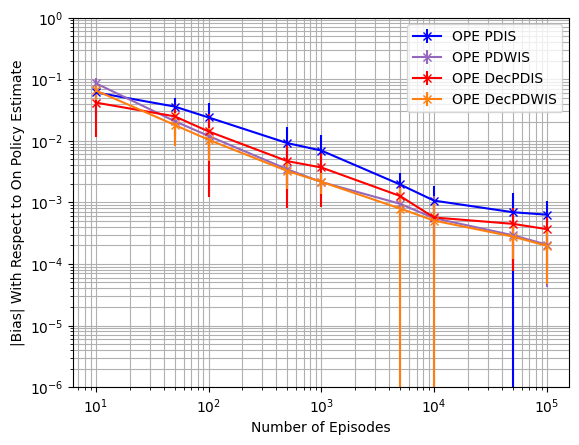

In [ ]:
biases1 = {
      'On Policy': [0, 0, 0, 0, 0, 0, 0, 0, 0],
      'OPE IS': [0.0641599999999999, 0.03517600000000002, 0.012207999999999764, 0.0190928000000001, 0.013068399999999583, 0.0014799999999997912, 0.00011884000000042824, 0.0012231040000001785, 0.0005951079999997517],
      'OPE PDIS': [0.0641599999999999, 0.03517600000000002, 0.012207999999999764, 0.0190928000000001, 0.013068399999999583, 0.0014799999999997912, 0.00011884000000042824, 0.0012231040000001785, 0.0005951079999997517],
      'OPE PDWIS': [0.06821108836903578, 0.021199375942521376, 0.009253448732232336, 0.006998283588205942, 0.0031022012506945504, 0.00017044438119832617, 0.00038072129455297407, 0.00039647553145045333, 0.00022177186409466643],
      'OPE DecIS': [0.039200000000000075, 0.021159999999999766, 0.00056000000000255, 0.008648000000000355, 0.0066939999999998615, 0.0009711999999995707, 9.139999999970148e-05, 0.00042304000000051924, 0.0001273000000001634],
      'OPE DecPDIS': [0.039200000000000075, 0.021159999999999766, 0.00056000000000255, 0.008648000000000355, 0.0066939999999998615, 0.0009711999999995707, 9.139999999970148e-05, 0.00042304000000051924, 0.0001273000000001634],
      'OPE DecPDWIS': [0.049266745780123904, 0.01674434493122185, 0.005182842059774436, 0.0054044209377246, 0.0025433679629499758, 0.0002417812299608322, 0.0003829277133162052, 0.0002823244182159393, 0.0001399913241459938],
  }

biases2 = {
    'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'OPE IS': [0.10760000000000074, 0.028440000000000784, 0.011131999999999725, 0.0014504000000000955, 0.0003204000000015414, 0.0024104800000001214, 0.0005030000000003136, 0.0018738560000002462, 0.0009976520000002458],
    'OPE PDIS': [0.10760000000000074, 0.028440000000000784, 0.011131999999999725, 0.0014504000000000955, 0.0003204000000015414, 0.0024104800000001214, 0.0005030000000003136, 0.0018738560000002462, 0.0009976520000002458],
    'OPE PDWIS': [0.08446945539785024, 0.018419765367401912, 0.0065483876603635895, 0.001685679223859439, 0.0006979722577873795, 0.00099249168761246, 6.011729976485481e-05, 0.0006378455360597177, 0.00041584214040400654],
    'OPE DecIS': [0.0500000000000003, 0.016920000000000265, 0.0022999999999988273, 0.0001640000000002492, 0.002682000000000061, 0.002229999999999985, 0.0005365999999999982, 0.001139839999999954, 0.0008054599999999396],
    'OPE DecPDIS': [0.0500000000000003, 0.016920000000000265, 0.0022999999999988273, 0.0001640000000002492, 0.002682000000000061, 0.002229999999999985, 0.0005365999999999982, 0.001139839999999954, 0.0008054599999999396],
    'OPE DecPDWIS': [0.06216954764972364, 0.015346339130678253, 0.0029573632456377443, 0.0009341717319661618, 0.001938648103454357, 0.0012929464629148916, 0.00012244104571357736, 0.0005729759262737557, 0.000472951957364794]
  }

biases3 = {
    'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'OPE IS': [0.00267999999998443, 0.026064000000000614, 0.058903999999999984, 0.01673280000000005, 0.012083600000000359, 0.000361200000000307, 0.0008640000000003173, 0.00010021599999969674, 0.0012211799999999801],
    'OPE PDIS': [0.00267999999998443, 0.026064000000000614, 0.058903999999999984, 0.01673280000000005, 0.012083600000000359, 0.000361200000000307, 0.0008640000000003173, 0.00010021599999969674, 0.0012211799999999801],
    'OPE PDWIS': [0.07005069893353966, 0.0066677753742458695, 0.014025717607126127, 0.003633545823557606, 0.002983904483103479, 0.0004633652856935549, 6.877893512478565e-05, 0.00018535214766253195, 0.0003489693739746393],
    'OPE DecIS': [0.00019999999998205888, 0.015120000000000357, 0.033559999999999764, 0.008783999999999834, 0.0073220000000000255, 0.00037800000000004193, 0.0005135999999999625, 0.0002148399999994668, 0.0005395800000002672],
    'OPE DecPDIS': [0.00019999999998205888, 0.015120000000000357, 0.033559999999999764, 0.008783999999999834, 0.0073220000000000255, 0.00037800000000004193, 0.0005135999999999625, 0.0002148399999994668, 0.0005395800000002672],
    'OPE DecPDWIS': [0.051851024610037974, 0.0022577418796297087, 0.01356248533286211, 0.0028488270444712365, 0.002870547894262452, 1.9215270791639666e-05, 2.1613927394840994e-06, 0.0002268274617424218, 0.0002083513924415709]
  }

biases4 = {
    'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'OPE IS': [0.04464000000000085, 0.02739199999999935, 0.019483999999999644, 0.004075200000000166, 0.007734800000000039, 0.003537119999999861, 0.002389920000000298, 0.00012822400000023237, 0.00019275599999956072],
    'OPE PDIS': [0.04464000000000085, 0.02739199999999935, 0.019483999999999644, 0.004075200000000166, 0.007734800000000039, 0.003537119999999861, 0.002389920000000298, 0.00012822400000023237, 0.00019275599999956072],
    'OPE PDWIS': [0.08280475749604761, 0.029737551011477844, 0.016470249241358873, 0.0037148052543184004, 0.0019680528941378676, 0.0006689736336640467, 0.0003524780322208926, 0.000141134158631912, 1.9696713555473903e-06],
    'OPE DecIS': [0.026400000000000458, 0.01951999999999936, 0.009499999999999911, 0.005496000000000238, 0.00016999999999996716, 0.000789599999999722, 0.0002903999999999416, 0.000406880000000156, 0.0003304199999999015],
    'OPE DecPDIS': [0.026400000000000458, 0.01951999999999936, 0.009499999999999911, 0.005496000000000238, 0.00016999999999996716, 0.000789599999999722, 0.0002903999999999416, 0.000406880000000156, 0.0003304199999999015],
    'OPE DecPDWIS': [0.058567413241637244, 0.023771518397492735, 0.011483928799157493, 0.0045818853883965675, 0.0006856223507613076, 7.447097377445107e-05, 0.00026916365747627264, 0.00016834346454297627, 0.0001326132008405232]
  }

biases5 = {
    'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'OPE IS': [0.08528000000000072, 0.062320000000000174, 0.017660000000000314, 0.004361600000000234, 0.0014324000000005967, 0.0019533600000000506, 0.0014577999999998681, 0.0001290240000000568, 0.0001430240000001311],
    'OPE PDIS': [0.08528000000000072, 0.062320000000000174, 0.017660000000000314, 0.004361600000000234, 0.0014324000000005967, 0.0019533600000000506, 0.0014577999999998681, 0.0001290240000000568, 0.0001430240000001311],
    'OPE PDWIS': [0.122846760959266, 0.027944284294734344, 0.01346106132939815, 0.001139109994925145, 0.0019302230666246893, 0.002437249355611198, 0.0019059294554654848, 9.99301486103367e-05, 4.045191598153982e-05],
    'OPE DecIS': [0.09200000000000015, 0.051759999999999896, 0.02486000000000025, 0.00020800000000039485, 0.0015340000000001754, 0.0019668000000000914, 0.0014050000000001255, 5.2800000000378376e-05, 3.2560000000137904e-05],
    'OPE DecPDIS': [0.09200000000000015, 0.051759999999999896, 0.02486000000000025, 0.00020800000000039485, 0.0015340000000001754, 0.0019668000000000914, 0.0014050000000001255, 5.2800000000378376e-05, 3.2560000000137904e-05],
    'OPE DecPDWIS': [0.10511762339975646, 0.03212849468812825, 0.018666708359828053, 0.002351010266122346, 0.0027400089305491173, 0.0023316376740036243, 0.001748456101988662, 0.00013914434157008033, 3.073300834166486e-05]
  }

biases = [biases1, biases2, biases3, biases4, biases5]

plot_graphs(biases, 'bias', 10**(-6), 10**(0))

Process readings for policy divergence plot

In [ ]:
print_specific_mean_std(biases)

1000 EPISODES
[0.0, 0.006927920000000425, 0.006927920000000425, 0.002136470790469593, 0.0036804000000000186, 0.0036804000000000186, 0.002155639048395442]
[0.0, 0.0052687312865237635, 0.0052687312865237635, 0.000870742203541588, 0.002837949231399276, 0.002837949231399276, 0.0008013676671489098]

100000 EPISODES
[0.0, 0.0006299439999999339, 0.0006299439999999339, 0.0002058009931620799, 0.0003670640000000819, 0.0003670640000000819, 0.00019692817662690936]
[0.0, 0.00042759961683809565, 0.00042759961683809565, 0.00016355859047533668, 0.00028024107747433313, 0.00028024107747433313, 0.00014921037003813231]


#### Variance

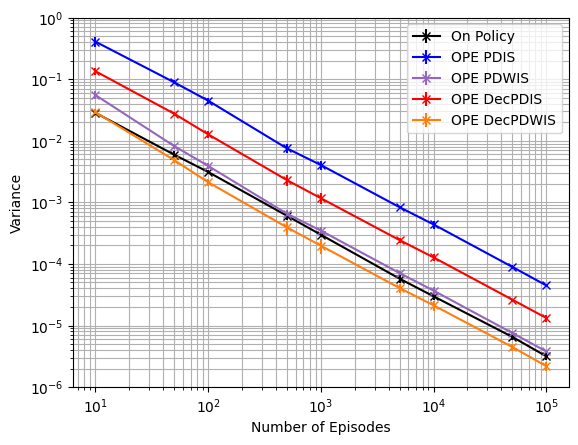

In [ ]:
vars1 = {
      'On Policy': [0.026984000000000005, 0.006242999999999999, 0.003239839999999995, 0.000534519999999999, 0.00028815310000000044, 7.180825599999986e-05, 3.225567500000008e-05, 6.104864960000011e-06, 2.7906509100000265e-06],
      'OPE IS': [0.3056287744, 0.08439088742400001, 0.035339022335999996, 0.00953382076416, 0.004762659389439997, 0.0009196687769600013, 0.00046500861501440035, 9.919608669798412e-05, 4.934624579993559e-05],
      'OPE PDIS': [0.3056287744, 0.08439088742400001, 0.035339022335999996, 0.00953382076416, 0.004762659389439997, 0.0009196687769600013, 0.00046500861501440035, 9.919608669798412e-05, 4.934624579993559e-05],
      'OPE PDWIS': [0.04969996128486537, 0.00814427682028917, 0.003219223735842545, 0.0008418946078206132, 0.00041468059846899865, 7.676046167360836e-05, 3.867180466953386e-05, 8.667941388635246e-06, 4.024259214963614e-06],
      'OPE DecIS': [0.12829695999999996, 0.027395174400000007, 0.012413414399999987, 0.0027978792959999976, 0.001417775104000001, 0.0002822793113600003, 0.00013989135103999975, 2.6360743014399998e-05, 1.597529792000005e-05],
      'OPE DecPDIS': [0.12829695999999996, 0.027395174400000007, 0.012413414399999987, 0.0027978792959999976, 0.001417775104000001, 0.0002822793113600003, 0.00013989135103999975, 2.6360743014399998e-05, 1.597529792000005e-05],
      'OPE DecPDWIS': [0.03191826179731874, 0.00536217954325048, 0.0022255039738622914, 0.0005566876810321786, 0.0002778617228582865, 5.315939774532688e-05, 2.6875530284868543e-05, 5.605673882876833e-06, 2.8788860575623594e-06],
  }

vars2 = {
    'On Policy': [0.026403999999999997, 0.006370999999999999, 0.0031521899999999966, 0.0007408523999999981, 0.0002991499000000004, 5.04802999999999e-05, 2.9897978999999878e-05, 6.655111039999953e-06, 2.5700317099999894e-06],
    'OPE IS': [0.39555071999999997, 0.09122119680000002, 0.047686270976000006, 0.007407116451839999, 0.0037794981478399985, 0.000808519997849599, 0.00046327065599999944, 9.002656679526461e-05, 4.802265569689576e-05],
    'OPE PDIS': [0.39555071999999997, 0.09122119680000002, 0.047686270976000006, 0.007407116451839999, 0.0037794981478399985, 0.000808519997849599, 0.00046327065599999944, 9.002656679526461e-05, 4.802265569689576e-05],
    'OPE PDWIS': [0.0549031675190161, 0.008382656562578198, 0.004081380611975186, 0.0006242012703255731, 0.0003288383109708733, 6.676298270182463e-05, 3.9088929558834206e-05, 7.491754090130986e-06, 4.000473045271029e-06],
    'OPE DecIS': [0.139776, 0.030747033600000005, 0.01544191999999999, 0.0021894051840000003, 0.001122415616, 0.0002536171520000001, 0.00013484600063999995, 2.7125904486399845e-05, 1.4223562854399833e-05],
    'OPE DecPDIS': [0.139776, 0.030747033600000005, 0.01544191999999999, 0.0021894051840000003, 0.001122415616, 0.0002536171520000001, 0.00013484600063999995, 2.7125904486399845e-05, 1.4223562854399833e-05],
    'OPE DecPDWIS': [0.03235984850983109, 0.00539726636853368, 0.0025636174771375662, 0.0003529239191453534, 0.00017977101247138017, 4.0607378748713307e-05, 2.150439147807981e-05, 4.331490564131356e-06, 2.2731695499098274e-06]
  }

vars3 = {
    'On Policy': [0.032458999999999995, 0.004566559999999996, 0.002692839999999998, 0.0005309823999999989, 0.00026592190000000027, 5.5643499999999895e-05, 2.835541600000001e-05, 5.335407159999992e-06, 3.1856307499999585e-06],
    'OPE IS': [0.36533493759999996, 0.09785722470400003, 0.04686440038400001, 0.005667704668159995, 0.003351405527040001, 0.0008102895206400002, 0.0005010839449600003, 9.122303329894417e-05, 4.207485050879988e-05],
    'OPE PDIS': [0.36533493759999996, 0.09785722470400003, 0.04686440038400001, 0.005667704668159995, 0.003351405527040001, 0.0008102895206400002, 0.0005010839449600003, 9.122303329894417e-05, 4.207485050879988e-05],
    'OPE PDWIS': [0.048815454988195076, 0.00862138112021011, 0.003959573124653245, 0.0005224460505461575, 0.00029018141235546236, 7.218761506440225e-05, 4.196857176648729e-05, 7.4367397558211135e-06, 3.672209572628512e-06],
    'OPE DecIS': [0.12219136000000001, 0.02733045760000001, 0.010972774399999982, 0.001500852224, 0.0009226690560000001, 0.00022690483200000052, 0.00014638238463999994, 2.7475403878399803e-05, 1.1177806233600026e-05],
    'OPE DecPDIS': [0.12219136000000001, 0.02733045760000001, 0.010972774399999982, 0.001500852224, 0.0009226690560000001, 0.00022690483200000052, 0.00014638238463999994, 2.7475403878399803e-05, 1.1177806233600026e-05],
    'OPE DecPDWIS': [0.02538593560999832, 0.004419748574634202, 0.0017416977406381864, 0.00024017372189803936, 0.0001488494905035267, 3.6238238021593606e-05, 2.343275591082066e-05, 4.391184183162693e-06, 1.7902050434853556e-06]
  }

vars4 = {
    'On Policy': [0.02845599999999999, 0.006959999999999998, 0.0033973099999999967, 0.0005307599999999981, 0.00034282589999999987, 5.967457599999996e-05, 3.509405600000013e-05, 6.905146239999922e-06, 3.7488301899999903e-06],
    'OPE IS': [0.4290555904, 0.07793834393600002, 0.044154732543999986, 0.007050124328960001, 0.0032632904089600003, 0.0008453021024256012, 0.0003107225972735999, 7.865607472742415e-05, 4.1086547492864046e-05],
    'OPE PDIS': [0.4290555904, 0.07793834393600002, 0.044154732543999986, 0.007050124328960001, 0.0032632904089600003, 0.0008453021024256012, 0.0003107225972735999, 7.865607472742415e-05, 4.1086547492864046e-05],
    'OPE PDWIS': [0.052373236198773473, 0.006857715086975, 0.003924270250351908, 0.00062292205334404, 0.000297741944740882, 7.555760906880895e-05, 2.6767130820779756e-05, 7.037565925259502e-06, 3.6943638762725993e-06],
    'OPE DecIS': [0.11832063999999999, 0.0239799296, 0.011499519999999987, 0.0021843107839999995, 0.0008915968000000008, 0.00021427129343999996, 9.486822144000041e-05, 2.4288692121599774e-05, 1.1832499097600142e-05],
    'OPE DecPDIS': [0.11832063999999999, 0.0239799296, 0.011499519999999987, 0.0021843107839999995, 0.0008915968000000008, 0.00021427129343999996, 9.486822144000041e-05, 2.4288692121599774e-05, 1.1832499097600142e-05],
    'OPE DecPDWIS': [0.02302240671346826, 0.004069676599400435, 0.00188910251750709, 0.00035547509603326593, 0.0001426375590875493, 3.4248595063196385e-05, 1.5141628130083003e-05, 3.883417621859599e-06, 1.8958176569310235e-06]
  }

vars5 = {
    'On Policy': [0.027903999999999998, 0.005568159999999999, 0.003096589999999996, 0.0006952575999999979, 0.00029592109999999986, 5.051127600000005e-05, 2.3545218999999927e-05, 7.676490240000012e-06, 3.5360961599999843e-06],
    'OPE IS': [0.5382844416, 0.09285918720000003, 0.050200063999999996, 0.007985187389440002, 0.005037908746240001, 0.0007831819567103999, 0.00044910865408000016, 8.832670451302379e-05, 4.3521150234623826e-05],
    'OPE PDIS': [0.5382844416, 0.09285918720000003, 0.050200063999999996, 0.007985187389440002, 0.005037908746240001, 0.0007831819567103999, 0.00044910865408000016, 8.832670451302379e-05, 4.3521150234623826e-05],
    'OPE PDWIS': [0.07041986114331643, 0.00903741323505434, 0.004383536504463332, 0.0006576275652694942, 0.0004097898758918319, 6.376275704186862e-05, 3.786444232235492e-05, 7.202348790573135e-06, 3.6245753774713043e-06],
    'OPE DecIS': [0.16454399999999997, 0.0281693184, 0.013260262399999993, 0.002819117055999998, 0.0014898327039999995, 0.00024135085055999997, 0.00012238969600000018, 2.6269744639999942e-05, 1.3179770342400033e-05],
    'OPE DecPDIS': [0.16454399999999997, 0.0281693184, 0.013260262399999993, 0.002819117055999998, 0.0014898327039999995, 0.00024135085055999997, 0.00012238969600000018, 2.6269744639999942e-05, 1.3179770342400033e-05],
    'OPE DecPDWIS': [0.032931007816118296, 0.005017617861370493, 0.002203318232843413, 0.00045970547126453573, 0.00024066937227411062, 3.877492684647573e-05, 1.95970611485784e-05, 4.210166591241135e-06, 2.1100028951594655e-06]
  }

vars = [vars1, vars2, vars3, vars4, vars5]

plot_graphs(vars, 'var', 10**(-6), 10**0)

Process readings for policy divergence plot

In [ ]:
print_specific_mean_std(vars)

1000 EPISODES
[0.0002983943800000001, 0.004038952443904, 0.004038952443904, 0.00034824642848560965, 0.0011688578560000002, 0.0011688578560000002, 0.00019795783143897067]
[2.506070097713934e-05, 0.0007298430412194917, 0.0007298430412194917, 5.385168309719912e-05, 0.0002468295563648766, 0.0002468295563648766, 5.293699963369436e-05]

100000 EPISODES
[3.1662479439999904e-06, 4.4810289946623825e-05, 4.4810289946623825e-05, 3.8031762173214125e-06, 1.3277787289600015e-05, 1.3277787289600015e-05, 2.1896162406096064e-06]
[4.411603787821225e-07, 3.283442010869216e-06, 3.283442010869216e-06, 1.7244963192030635e-07, 1.71344335975982e-06, 1.71344335975982e-06, 3.8321253450027744e-07]


#### MSE

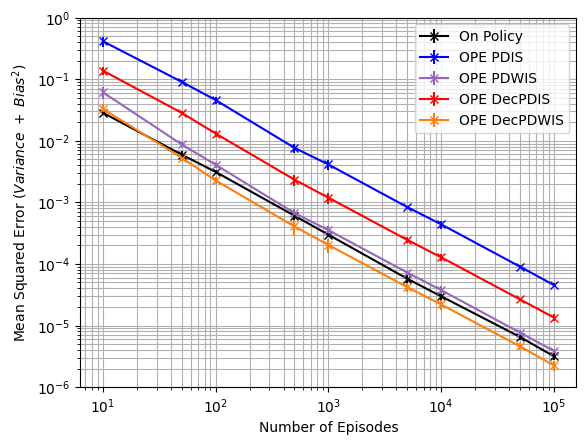

In [ ]:
MSEs1 = {
      'On Policy': [0.026984000000000005, 0.006242999999999999, 0.003239839999999995, 0.000534519999999999, 0.00028815310000000044, 7.180825599999986e-05, 3.225567500000008e-05, 6.104864960000011e-06, 2.7906509100000265e-06],
      'OPE IS': [0.30974528, 0.08562823840000001, 0.03548805759999999, 0.009898355776000003, 0.0049334424679999865, 0.0009218591769600007, 0.00046502273796000045, 0.00010069207009280056, 4.97003993315993e-05],
      'OPE PDIS': [0.30974528, 0.08562823840000001, 0.03548805759999999, 0.009898355776000003, 0.0049334424679999865, 0.0009218591769600007, 0.00046502273796000045, 0.00010069207009280056, 4.97003993315993e-05],
      'OPE PDWIS': [0.04504720870837696, 0.008593690360641525, 0.0033048500492825973, 0.0008908705810015659, 0.0004243042510688095, 7.678951296069044e-05, 3.8816753373659954e-05, 8.825134235674166e-06, 4.073441974667754e-06],
      'OPE DecIS': [0.12983359999999997, 0.027842919999999997, 0.01241372799999999, 0.0028726672000000037, 0.001462584739999999, 0.0002832225407999995, 0.0001398997049999997, 2.6539705856000437e-05, 1.599150321000007e-05],
      'OPE DecPDIS': [0.12983359999999997, 0.027842919999999997, 0.01241372799999999, 0.0028726672000000037, 0.001462584739999999, 0.0002832225407999995, 0.0001398997049999997, 2.6539705856000437e-05, 1.599150321000007e-05],
      'OPE DecPDWIS': [0.029491049557555386,0.005642552630426215, 0.0022523658256788583, 0.0005858954467042947, 0.0002843304434532468, 5.321785590848825e-05, 2.702216391849412e-05, 5.685380959997801e-06, 2.8984836283985343e-06],
  }

MSEs2 = {
    'On Policy': [0.026403999999999997, 0.006370999999999999, 0.0031521899999999966, 0.0007408523999999981, 0.0002991499000000004, 5.04802999999999e-05, 2.9897978999999878e-05, 6.655111039999953e-06, 2.5700317099999894e-06],
    'OPE IS': [0.4071284800000001, 0.09203003040000006, 0.0478101924, 0.007409220111999999, 0.0037796008039999995, 0.0008143304116799996, 0.00046352366499999976, 9.353790310400153e-05, 4.901796521000025e-05],
    'OPE PDIS': [0.4071284800000001, 0.09203003040000006, 0.0478101924, 0.007409220111999999, 0.0037796008039999995, 0.0008143304116799996, 0.00046352366499999976, 9.353790310400153e-05, 4.901796521000025e-05],
    'OPE PDWIS': [0.06203825641422551, 0.008721944318768337, 0.004124261992925588, 0.0006270427847713245, 0.00032932547624351413, 6.774802245180446e-05, 3.909254364856522e-05, 7.898601018002295e-06, 4.1733977310068144e-06],
    'OPE DecIS': [0.14227600000000004, 0.031033320000000014, 0.015447209999999984, 0.0021894320800000004, 0.0011296087400000003, 0.000258590052, 0.00013513394019999995, 2.842513971199974e-05, 1.4872328665999736e-05],
    'OPE DecPDIS': [0.14227600000000004, 0.031033320000000014, 0.015447209999999984, 0.0021894320800000004, 0.0011296087400000003, 0.000258590052, 0.00013513394019999995, 2.842513971199974e-05, 1.4872328665999736e-05],
    'OPE DecPDWIS': [0.03622490116480235, 0.005632776493247466, 0.0025723634745042153, 0.00035379659597015807, 0.00018352936894040734, 4.2279089304677436e-05, 2.1519383287755245e-05, 4.6597919762206245e-06, 2.4968531038850173e-06]
  }

MSEs3 = {
    'On Policy': [0.032458999999999995, 0.004566559999999996, 0.002692839999999998, 0.0005309823999999989, 0.00026592190000000027, 5.5643499999999895e-05, 2.835541600000001e-05, 5.335407159999992e-06, 3.1856307499999585e-06],
    'OPE IS': [0.3653421199999999, 0.09853655680000006, 0.05033408160000001, 0.005947691263999997, 0.0034974189160000098, 0.0008104199860800005, 0.0005018304409600008, 9.123307654560011e-05, 4.356613110119983e-05],
    'OPE PDIS': [0.3653421199999999, 0.09853655680000006, 0.05033408160000001, 0.005947691263999997, 0.0034974189160000098, 0.0008104199860800005, 0.0005018304409600008, 9.123307654560011e-05, 4.356613110119983e-05],
    'OPE PDWIS': [0.05372255540927249, 0.00866584034865151, 0.004156293879048093, 0.0005356487057980504, 0.0002990850983197474, 7.240232245238812e-05, 4.197330230840419e-05, 7.4710951744642266e-06, 3.793989196600764e-06],
    'OPE DecIS': [0.1221914, 0.02755907200000002, 0.012099047999999966, 0.001578010879999997, 0.0009762807400000005, 0.00022704771600000055, 0.0001466461695999999, 2.7521560103999574e-05, 1.1468952810000315e-05],
    'OPE DecPDIS': [0.1221914, 0.02755907200000002, 0.012099047999999966, 0.001578010879999997, 0.0009762807400000005, 0.00022704771600000055, 0.0001466461695999999, 2.7521560103999574e-05, 1.1468952810000315e-05],
    'OPE DecPDWIS': [0.028074464363109085, 0.0044248459730292355, 0.0019256387490422862, 0.0002482895374273501, 0.0001570895357167813, 3.62386072482252e-05, 2.3432760582439236e-05, 4.442634880563203e-06, 1.833615346217697e-06]
  }

MSEs4 = {
    'On Policy': [0.02845599999999999, 0.006959999999999998, 0.0033973099999999967, 0.0005307599999999981, 0.00034282589999999987, 5.967457599999996e-05, 3.509405600000013e-05, 6.905146239999922e-06, 3.7488301899999903e-06],
    'OPE IS': [0.4310483200000001, 0.07868866559999999, 0.04453435879999997, 0.007066731584000003, 0.003323117540000001, 0.0008578133203200003, 0.00031643431488000135, 7.86725161216002e-05, 4.1123702368399877e-05],
    'OPE PDIS': [0.4310483200000001, 0.07868866559999999, 0.04453435879999997, 0.007066731584000003, 0.003323117540000001, 0.0008578133203200003, 0.00031643431488000135, 7.86725161216002e-05, 4.1123702368399877e-05],
    'OPE PDWIS': [0.05922986406275273, 0.0077420370271352465, 0.004195539360424391, 0.0006367218314215516, 0.00030161517693500645, 7.600513479134662e-05, 2.689137158397807e-05, 7.05748477599224e-06, 3.694367755877848e-06],
    'OPE DecIS': [0.11901760000000002, 0.024360959999999977, 0.011589769999999985, 0.002214516800000002, 0.0008916257000000008, 0.00021489476159999952, 9.495255360000038e-05, 2.44542434559999e-05, 1.1941676474000077e-05],
    'OPE DecPDIS': [0.11901760000000002, 0.024360959999999977, 0.011589769999999985, 0.002214516800000002, 0.0008916257000000008, 0.00021489476159999952, 9.495255360000038e-05, 2.44542434559999e-05, 1.1941676474000077e-05],
    'OPE DecPDWIS': [0.026452548607284965, 0.004634761686322771, 0.002020983138171209, 0.0003764687697456679, 0.00014310763709541276, 3.42541409891313e-05, 1.5214077204589007e-05, 3.911757143913931e-06, 1.9134039179681924e-06]
  }

MSEs5 = {
    'On Policy': [0.027903999999999998, 0.005568159999999999, 0.003096589999999996, 0.0006952575999999979, 0.00029592109999999986, 5.051127600000005e-05, 2.3545218999999927e-05, 7.676490240000012e-06, 3.5360961599999843e-06],
    'OPE IS': [0.5455571200000001, 0.09674296960000005, 0.05051193960000001, 0.008004210944000004, 0.005039960516000003, 0.0007869975720000001, 0.0004512338349199998, 8.83433517055998e-05, 4.3541606099199864e-05],
    'OPE PDIS': [0.5455571200000001, 0.09674296960000005, 0.05051193960000001, 0.008004210944000004, 0.005039960516000003, 0.0007869975720000001, 0.0004512338349199998, 8.83433517055998e-05, 4.3541606099199864e-05],
    'OPE PDWIS': [0.08551118782149947, 0.009818296259799277, 0.00456473667657715, 0.0006589251368500326, 0.00041351563697876193, 6.970294146329582e-05, 4.149700941156588e-05, 7.212334825174419e-06, 3.626211734977882e-06],
    'OPE DecIS': [0.173008, 0.03084841599999999, 0.013878282000000006, 0.002819160319999998, 0.00149218586, 0.0002452191528000003, 0.00012436372100000054, 2.6272532479999982e-05, 1.3180830496000042e-05],
    'OPE DecPDIS': [0.173008, 0.03084841599999999, 0.013878282000000006, 0.002819160319999998, 0.00149218586, 0.0002452191528000003, 0.00012436372100000054, 2.6272532479999982e-05, 1.3180830496000042e-05],
    'OPE DecPDWIS': [0.04398072256533132, 0.0060498580322955785, 0.0025517642338342876, 0.0004652327205359484, 0.00024817702121359954, 4.4211461089308764e-05, 2.2654159889159787e-05, 4.229527739032106e-06, 2.1109474129611944e-06]
  }

MSEs = [MSEs1, MSEs2, MSEs3, MSEs4, MSEs5]

plot_graphs(MSEs, 'MSE', 10**(-6), 10**0)

Process readings for policy divergence plot

In [ ]:
print_specific_mean_std(MSEs)

1000 EPISODES
[0.0002983943800000001, 0.0041147080487999995, 0.0041147080487999995, 0.00035356912790916793, 0.0011904571560000003, 0.0011904571560000003, 0.00020324680128388953]
[2.506070097713934e-05, 0.0007275130857730442, 0.0007275130857730442, 5.4502327925057586e-05, 0.0002465635572369078, 0.0002465635572369078, 5.427572397033761e-05]

100000 EPISODES
[3.1662479439999904e-06, 4.5389960822079826e-05, 4.5389960822079826e-05, 3.872281678626212e-06, 1.349105833120005e-05, 1.349105833120005e-05, 2.2506606818861272e-06]
[4.411603787821225e-07, 3.3670766908127237e-06, 3.3670766908127237e-06, 2.1422877282069597e-07, 1.7173158426879232e-06, 1.7173158426879232e-06, 3.968561484978098e-07]


#### ESS

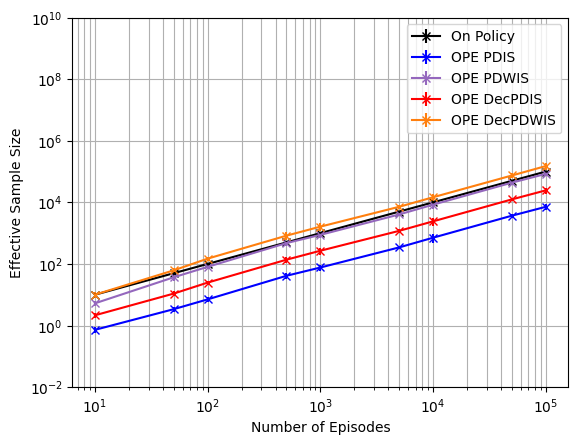

In [ ]:
EPISODES = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

vars1 = {
      'On Policy': [0.026984000000000005, 0.006242999999999999, 0.003239839999999995, 0.000534519999999999, 0.00028815310000000044, 7.180825599999986e-05, 3.225567500000008e-05, 6.104864960000011e-06, 2.7906509100000265e-06],
      'OPE IS': [0.3056287744, 0.08439088742400001, 0.035339022335999996, 0.00953382076416, 0.004762659389439997, 0.0009196687769600013, 0.00046500861501440035, 9.919608669798412e-05, 4.934624579993559e-05],
      'OPE PDIS': [0.3056287744, 0.08439088742400001, 0.035339022335999996, 0.00953382076416, 0.004762659389439997, 0.0009196687769600013, 0.00046500861501440035, 9.919608669798412e-05, 4.934624579993559e-05],
      'OPE PDWIS': [0.04969996128486537, 0.00814427682028917, 0.003219223735842545, 0.0008418946078206132, 0.00041468059846899865, 7.676046167360836e-05, 3.867180466953386e-05, 8.667941388635246e-06, 4.024259214963614e-06],
      'OPE DecIS': [0.12829695999999996, 0.027395174400000007, 0.012413414399999987, 0.0027978792959999976, 0.001417775104000001, 0.0002822793113600003, 0.00013989135103999975, 2.6360743014399998e-05, 1.597529792000005e-05],
      'OPE DecPDIS': [0.12829695999999996, 0.027395174400000007, 0.012413414399999987, 0.0027978792959999976, 0.001417775104000001, 0.0002822793113600003, 0.00013989135103999975, 2.6360743014399998e-05, 1.597529792000005e-05],
      'OPE DecPDWIS': [0.03191826179731874, 0.00536217954325048, 0.0022255039738622914, 0.0005566876810321786, 0.0002778617228582865, 5.315939774532688e-05, 2.6875530284868543e-05, 5.605673882876833e-06, 2.8788860575623594e-06],
  }

ESS1 = calculate_ESS(vars1, EPISODES)

vars2 = {
    'On Policy': [0.026403999999999997, 0.006370999999999999, 0.0031521899999999966, 0.0007408523999999981, 0.0002991499000000004, 5.04802999999999e-05, 2.9897978999999878e-05, 6.655111039999953e-06, 2.5700317099999894e-06],
    'OPE IS': [0.39555071999999997, 0.09122119680000002, 0.047686270976000006, 0.007407116451839999, 0.0037794981478399985, 0.000808519997849599, 0.00046327065599999944, 9.002656679526461e-05, 4.802265569689576e-05],
    'OPE PDIS': [0.39555071999999997, 0.09122119680000002, 0.047686270976000006, 0.007407116451839999, 0.0037794981478399985, 0.000808519997849599, 0.00046327065599999944, 9.002656679526461e-05, 4.802265569689576e-05],
    'OPE PDWIS': [0.0549031675190161, 0.008382656562578198, 0.004081380611975186, 0.0006242012703255731, 0.0003288383109708733, 6.676298270182463e-05, 3.9088929558834206e-05, 7.491754090130986e-06, 4.000473045271029e-06],
    'OPE DecIS': [0.139776, 0.030747033600000005, 0.01544191999999999, 0.0021894051840000003, 0.001122415616, 0.0002536171520000001, 0.00013484600063999995, 2.7125904486399845e-05, 1.4223562854399833e-05],
    'OPE DecPDIS': [0.139776, 0.030747033600000005, 0.01544191999999999, 0.0021894051840000003, 0.001122415616, 0.0002536171520000001, 0.00013484600063999995, 2.7125904486399845e-05, 1.4223562854399833e-05],
    'OPE DecPDWIS': [0.03235984850983109, 0.00539726636853368, 0.0025636174771375662, 0.0003529239191453534, 0.00017977101247138017, 4.0607378748713307e-05, 2.150439147807981e-05, 4.331490564131356e-06, 2.2731695499098274e-06]
  }

ESS2 = calculate_ESS(vars2, EPISODES)

vars3 = {
    'On Policy': [0.032458999999999995, 0.004566559999999996, 0.002692839999999998, 0.0005309823999999989, 0.00026592190000000027, 5.5643499999999895e-05, 2.835541600000001e-05, 5.335407159999992e-06, 3.1856307499999585e-06],
    'OPE IS': [0.36533493759999996, 0.09785722470400003, 0.04686440038400001, 0.005667704668159995, 0.003351405527040001, 0.0008102895206400002, 0.0005010839449600003, 9.122303329894417e-05, 4.207485050879988e-05],
    'OPE PDIS': [0.36533493759999996, 0.09785722470400003, 0.04686440038400001, 0.005667704668159995, 0.003351405527040001, 0.0008102895206400002, 0.0005010839449600003, 9.122303329894417e-05, 4.207485050879988e-05],
    'OPE PDWIS': [0.048815454988195076, 0.00862138112021011, 0.003959573124653245, 0.0005224460505461575, 0.00029018141235546236, 7.218761506440225e-05, 4.196857176648729e-05, 7.4367397558211135e-06, 3.672209572628512e-06],
    'OPE DecIS': [0.12219136000000001, 0.02733045760000001, 0.010972774399999982, 0.001500852224, 0.0009226690560000001, 0.00022690483200000052, 0.00014638238463999994, 2.7475403878399803e-05, 1.1177806233600026e-05],
    'OPE DecPDIS': [0.12219136000000001, 0.02733045760000001, 0.010972774399999982, 0.001500852224, 0.0009226690560000001, 0.00022690483200000052, 0.00014638238463999994, 2.7475403878399803e-05, 1.1177806233600026e-05],
    'OPE DecPDWIS': [0.02538593560999832, 0.004419748574634202, 0.0017416977406381864, 0.00024017372189803936, 0.0001488494905035267, 3.6238238021593606e-05, 2.343275591082066e-05, 4.391184183162693e-06, 1.7902050434853556e-06]
  }

ESS3 = calculate_ESS(vars3, EPISODES)

vars4 = {
    'On Policy': [0.02845599999999999, 0.006959999999999998, 0.0033973099999999967, 0.0005307599999999981, 0.00034282589999999987, 5.967457599999996e-05, 3.509405600000013e-05, 6.905146239999922e-06, 3.7488301899999903e-06],
    'OPE IS': [0.4290555904, 0.07793834393600002, 0.044154732543999986, 0.007050124328960001, 0.0032632904089600003, 0.0008453021024256012, 0.0003107225972735999, 7.865607472742415e-05, 4.1086547492864046e-05],
    'OPE PDIS': [0.4290555904, 0.07793834393600002, 0.044154732543999986, 0.007050124328960001, 0.0032632904089600003, 0.0008453021024256012, 0.0003107225972735999, 7.865607472742415e-05, 4.1086547492864046e-05],
    'OPE PDWIS': [0.052373236198773473, 0.006857715086975, 0.003924270250351908, 0.00062292205334404, 0.000297741944740882, 7.555760906880895e-05, 2.6767130820779756e-05, 7.037565925259502e-06, 3.6943638762725993e-06],
    'OPE DecIS': [0.11832063999999999, 0.0239799296, 0.011499519999999987, 0.0021843107839999995, 0.0008915968000000008, 0.00021427129343999996, 9.486822144000041e-05, 2.4288692121599774e-05, 1.1832499097600142e-05],
    'OPE DecPDIS': [0.11832063999999999, 0.0239799296, 0.011499519999999987, 0.0021843107839999995, 0.0008915968000000008, 0.00021427129343999996, 9.486822144000041e-05, 2.4288692121599774e-05, 1.1832499097600142e-05],
    'OPE DecPDWIS': [0.02302240671346826, 0.004069676599400435, 0.00188910251750709, 0.00035547509603326593, 0.0001426375590875493, 3.4248595063196385e-05, 1.5141628130083003e-05, 3.883417621859599e-06, 1.8958176569310235e-06]
  }

ESS4 = calculate_ESS(vars4, EPISODES)

vars5 = {
    'On Policy': [0.027903999999999998, 0.005568159999999999, 0.003096589999999996, 0.0006952575999999979, 0.00029592109999999986, 5.051127600000005e-05, 2.3545218999999927e-05, 7.676490240000012e-06, 3.5360961599999843e-06],
    'OPE IS': [0.5382844416, 0.09285918720000003, 0.050200063999999996, 0.007985187389440002, 0.005037908746240001, 0.0007831819567103999, 0.00044910865408000016, 8.832670451302379e-05, 4.3521150234623826e-05],
    'OPE PDIS': [0.5382844416, 0.09285918720000003, 0.050200063999999996, 0.007985187389440002, 0.005037908746240001, 0.0007831819567103999, 0.00044910865408000016, 8.832670451302379e-05, 4.3521150234623826e-05],
    'OPE PDWIS': [0.07041986114331643, 0.00903741323505434, 0.004383536504463332, 0.0006576275652694942, 0.0004097898758918319, 6.376275704186862e-05, 3.786444232235492e-05, 7.202348790573135e-06, 3.6245753774713043e-06],
    'OPE DecIS': [0.16454399999999997, 0.0281693184, 0.013260262399999993, 0.002819117055999998, 0.0014898327039999995, 0.00024135085055999997, 0.00012238969600000018, 2.6269744639999942e-05, 1.3179770342400033e-05],
    'OPE DecPDIS': [0.16454399999999997, 0.0281693184, 0.013260262399999993, 0.002819117055999998, 0.0014898327039999995, 0.00024135085055999997, 0.00012238969600000018, 2.6269744639999942e-05, 1.3179770342400033e-05],
    'OPE DecPDWIS': [0.032931007816118296, 0.005017617861370493, 0.002203318232843413, 0.00045970547126453573, 0.00024066937227411062, 3.877492684647573e-05, 1.95970611485784e-05, 4.210166591241135e-06, 2.1100028951594655e-06]
  }

ESS5 = calculate_ESS(vars5, EPISODES)

ESS = [ESS1, ESS2, ESS3, ESS4, ESS5]

plot_graphs(ESS, 'ESS', 10**(-2), 10**10)

Process readings for policy divergence plot

In [ ]:
print_specific_mean_std(ESS)

1000 EPISODES
[1000.0, 76.55875961863579, 76.55875961863579, 878.9088333528504, 268.222139639273, 268.222139639273, 1624.1329661838026]
[8.806144583576081e-14, 16.74449476814894, 16.74449476814894, 164.3553850313498, 67.80924225534956, 67.80924225534956, 476.59078265822603]

100000 EPISODES
[100000.0, 7165.505441211765, 7165.505441211765, 83874.3630544086, 24509.837948084943, 24509.837948084943, 150654.33934576812]
[6.507814330688531e-12, 1448.633259526067, 1448.633259526067, 14844.238378531752, 5723.871278667344, 5723.871278667344, 38853.71264554653]


## Varying Number of Episodes: Policy Divergence 3.61

**Note**: Restart the runtime before running all code in this section

### Rewrite Evaluation Policy

In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH = 'configs/1-step-MDP/evaluation-policy.csv'

HORIZONTAL_REWARD_PATH = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'

VERTICAL_REWARD_PATH = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write everything
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH)

### Generate Data Set

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

Policy divergence: 3.61
Start state: state, start state no: 0


### Run Estimates on Collected Data Sets

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 3.61
VERSION_NUMBER = 5

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means = np.zeros((9, 7))
biases = np.zeros((9, 7))
vars = np.zeros((9, 7))
MSEs = np.zeros((9, 7))

#### 100 runs, 10 episodes

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 10)
gc.collect()

Mean on policy Q estimate: 1.906. Variance of on policy Q estimate: 0.011363999999999999
Mean off policy IS estimate: 1.96327. Bias1: 0.05726999999999992. Bias2: 0.057270000000000154. Variance: 1.0016021171. MSE: 1.00488197
Mean off policy PDIS estimate: 1.96327. Bias1: 0.05726999999999992. Bias2: 0.057270000000000154 Variance: 1.0016021171. MSE: 1.00488197
Mean off policy PDWIS estimate: 1.8250803816858987. Bias1: 0.08091961831410167. Bias2: 0.08091961831410122. Variance: 0.055150737671347726. MSE: 0.061698722299447624
Mean off policy DecIS estimate: 1.9170999999999998. Bias1: 0.011100000000000563. Bias2: 0.011099999999999888. Variance: 0.16612859. MSE: 0.1662518
Mean off policy DecPDIS estimate: 1.9170999999999998. Bias1: 0.011100000000000563. Bias2: 0.011099999999999888. Variance: 0.16612859. MSE: 0.1662518
Mean off policy DecPDWIS estimate: 1.8788993591834875. Bias1: 0.027100640816512214. Bias2: 0.027100640816512422. Variance: 0.004902548985930416. MSE: 0.005636993718596024


0

#### 1000 runs, 50 episodes

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 50)
gc.collect()

Mean on policy Q estimate: 1.9036. Variance of on policy Q estimate: 0.0022590399999999978
Mean off policy IS estimate: 1.8558059999999998. Bias1: 0.04779400000000022. Bias2: 0.047794000000000114. Variance: 0.17706693476399998. MSE: 0.1793512012
Mean off policy PDIS estimate: 1.8558059999999998. Bias1: 0.04779400000000022. Bias2: 0.047794000000000114 Variance: 0.17706693476399998. MSE: 0.1793512012
Mean off policy PDWIS estimate: 1.8903417146028445. Bias1: 0.013258285397155626. Bias2: 0.013258285397155456. Variance: 0.0012271952833957326. MSE: 0.0014029774150681627
Mean off policy DecIS estimate: 1.88214. Bias1: 0.021460000000000028. Bias2: 0.021460000000000035. Variance: 0.032185460400000004. MSE: 0.032645992000000006
Mean off policy DecPDIS estimate: 1.88214. Bias1: 0.021460000000000028. Bias2: 0.021460000000000035. Variance: 0.032185460400000004. MSE: 0.032645992000000006
Mean off policy DecPDWIS estimate: 1.894843175326385. Bias1: 0.008756824673615153. Bias2: 0.008756824673614938. 

0

#### 1000 runs, 100 episodes

In [ ]:
means[2, :], biases[2, :], vars[2, :], MSEs[2, :] = evaluate_PE(100, 100)
gc.collect()

Mean on policy Q estimate: 1.9032000000000002. Variance of on policy Q estimate: 0.0011617599999999974
Mean off policy IS estimate: 1.9028309999999997. Bias1: 0.00036899999998498816. Bias2: 0.0003690000000005078. Variance: 0.07725584073899999. MSE: 0.07725597689999998
Mean off policy PDIS estimate: 1.9028309999999997. Bias1: 0.00036899999998498816. Bias2: 0.0003690000000005078 Variance: 0.07725584073899999. MSE: 0.07725597689999998
Mean off policy PDWIS estimate: 1.8975745980204537. Bias1: 0.005625401979545823. Bias2: 0.005625401979546529. Variance: 0.0004313694972730731. MSE: 0.0004630146447045512
Mean off policy DecIS estimate: 1.9009500000000004. Bias1: 0.0022499999999999686. Bias2: 0.0022499999999998632. Variance: 0.013518547500000002. MSE: 0.013523610000000002
Mean off policy DecPDIS estimate: 1.9009500000000004. Bias1: 0.0022499999999999686. Bias2: 0.0022499999999998632. Variance: 0.013518547500000002. MSE: 0.013523610000000002
Mean off policy DecPDWIS estimate: 1.898558233094704

0

#### 1000 runs, 500 episodes

In [ ]:
means[3, :], biases[3, :], vars[3, :], MSEs[3, :] = evaluate_PE(100, 500)
gc.collect()

Mean on policy Q estimate: 1.90052. Variance of on policy Q estimate: 0.00016756960000000005
Mean off policy IS estimate: 1.9323075999999997. Bias1: 0.03178759999999998. Bias2: 0.031787599999999694. Variance: 0.022916424342239984. MSE: 0.023926875855999983
Mean off policy PDIS estimate: 1.9323075999999997. Bias1: 0.03178759999999998. Bias2: 0.031787599999999694 Variance: 0.022916424342239984. MSE: 0.023926875855999983
Mean off policy PDWIS estimate: 1.9014460468806105. Bias1: 0.0009260468806102656. Bias2: 0.0009260468806104871. Variance: 0.00011470512395686094. MSE: 0.00011556268678194894
Mean off policy DecIS estimate: 1.9111720000000003. Bias1: 0.010652000000000045. Bias2: 0.010652000000000328. Variance: 0.0037791848160000025. MSE: 0.0038926499200000035
Mean off policy DecPDIS estimate: 1.9111720000000003. Bias1: 0.010652000000000045. Bias2: 0.010652000000000328. Variance: 0.0037791848160000025. MSE: 0.0038926499200000035
Mean off policy DecPDWIS estimate: 1.9007609833293122. Bias1: 

0

#### 1000 runs, 1000 episodes

In [ ]:
means[4, :], biases[4, :], vars[4, :], MSEs[4, :] = evaluate_PE(100, 1000)
gc.collect()

Mean on policy Q estimate: 1.8995999999999995. Variance of on policy Q estimate: 0.00010162000000000013
Mean off policy IS estimate: 1.9099769000000004. Bias1: 0.010376900000000537. Bias2: 0.01037690000000091. Variance: 0.011758593437389997. MSE: 0.011866273491000008
Mean off policy PDIS estimate: 1.9099769000000004. Bias1: 0.010376900000000537. Bias2: 0.01037690000000091 Variance: 0.011758593437389997. MSE: 0.011866273491000008
Mean off policy PDWIS estimate: 1.9005564860301194. Bias1: 0.0009564860301200266. Bias2: 0.0009564860301198852. Variance: 5.808970074752038e-05. MSE: 5.900456627333515e-05
Mean off policy DecIS estimate: 1.9005890000000003. Bias1: 0.0009890000000001957. Bias2: 0.0009890000000007948. Variance: 0.0020851861789999986. MSE: 0.002086164299999999
Mean off policy DecPDIS estimate: 1.9005890000000003. Bias1: 0.0009890000000001957. Bias2: 0.0009890000000007948. Variance: 0.0020851861789999986. MSE: 0.002086164299999999
Mean off policy DecPDWIS estimate: 1.89985839645803

0

#### 1000 runs, 5000 episodes

In [ ]:
means[5, :], biases[5, :], vars[5, :], MSEs[5, :] = evaluate_PE(100, 5000)
gc.collect()

Mean on policy Q estimate: 1.899846. Variance of on policy Q estimate: 1.548148400000001e-05
Mean off policy IS estimate: 1.90485754. Bias1: 0.005011540000000087. Bias2: 0.0050115400000001475. Variance: 0.0017417313148683996. MSE: 0.0017668468480400005
Mean off policy PDIS estimate: 1.90485754. Bias1: 0.005011540000000087. Bias2: 0.0050115400000001475 Variance: 0.0017417313148683996. MSE: 0.0017668468480400005
Mean off policy PDWIS estimate: 1.900367659957495. Bias1: 0.000521659957495272. Bias2: 0.0005216599574950909. Variance: 8.099692819312406e-06. MSE: 8.371821930566375e-06
Mean off policy DecIS estimate: 1.9006954000000003. Bias1: 0.0008494000000000053. Bias2: 0.0008494000000003332. Variance: 0.00038370561483999985. MSE: 0.00038442709519999986
Mean off policy DecPDIS estimate: 1.9006954000000003. Bias1: 0.0008494000000000053. Bias2: 0.0008494000000003332. Variance: 0.00038370561483999985. MSE: 0.00038442709519999986
Mean off policy DecPDWIS estimate: 1.9000342542839548. Bias1: 0.00

0

#### 1000 runs, 10000 episodes

In [ ]:
means[6, :], biases[6, :], vars[6, :], MSEs[6, :] = evaluate_PE(100, 10000)
gc.collect()

Mean on policy Q estimate: 1.8997130000000002. Variance of on policy Q estimate: 1.1235130999999922e-05
Mean off policy IS estimate: 1.9060763899999995. Bias1: 0.006363389999999766. Bias2: 0.006363389999999303. Variance: 0.0007446765737979001. MSE: 0.0007851693060899972
Mean off policy PDIS estimate: 1.9060763899999995. Bias1: 0.006363389999999766. Bias2: 0.006363389999999303 Variance: 0.0007446765737979001. MSE: 0.0007851693060899972
Mean off policy PDWIS estimate: 1.900456976551635. Bias1: 0.0007439765516349062. Bias2: 0.0007439765516348285. Variance: 3.7068141018354905e-06. MSE: 4.260315211218057e-06
Mean off policy DecIS estimate: 1.9013927000000004. Bias1: 0.0016796999999998386. Bias2: 0.0016797000000001727. Variance: 0.00015582135771000056. MSE: 0.00015864274980000002
Mean off policy DecPDIS estimate: 1.9013927000000004. Bias1: 0.0016796999999998386. Bias2: 0.0016797000000001727. Variance: 0.00015582135771000056. MSE: 0.00015864274980000002
Mean off policy DecPDWIS estimate: 1.90

0

#### 1000 runs, 50000 episodes

In [ ]:
means[7, :], biases[7, :], vars[7, :], MSEs[7, :] = evaluate_PE(100, 50000)
gc.collect()

Mean on policy Q estimate: 1.8999522. Variance of on policy Q estimate: 1.7966631599999745e-06
Mean off policy IS estimate: 1.9008949760000002. Bias1: 0.0009427759999999822. Bias2: 0.0009427760000002561. Variance: 0.00016381480107062463. MSE: 0.0001647036276568006
Mean off policy PDIS estimate: 1.9008949760000002. Bias1: 0.0009427759999999822. Bias2: 0.0009427760000002561 Variance: 0.00016381480107062463. MSE: 0.0001647036276568006
Mean off policy PDWIS estimate: 1.9001309115844527. Bias1: 0.00017871158445285966. Bias2: 0.00017871158445270652. Variance: 7.169188380659728e-07. MSE: 7.488566684836243e-07
Mean off policy DecIS estimate: 1.8994832. Bias1: 0.0004689999999999508. Bias2: 0.0004690000000000527. Variance: 3.6212660880000164e-05. MSE: 3.643262188000012e-05
Mean off policy DecPDIS estimate: 1.8994832. Bias1: 0.0004689999999999508. Bias2: 0.0004690000000000527. Variance: 3.6212660880000164e-05. MSE: 3.643262188000012e-05
Mean off policy DecPDWIS estimate: 1.899944893927576. Bias1:

0

#### 1000 runs 100000 episodes

In [ ]:
means[8, :], biases[8, :], vars[8, :], MSEs[8, :] = evaluate_PE(100, 100000)
gc.collect()

Mean on policy Q estimate: 1.9000139000000003. Variance of on policy Q estimate: 1.037521789999992e-06
Mean off policy IS estimate: 1.8991638100000001. Bias1: 0.0008500900000003171. Bias2: 0.0008500900000001366. Variance: 9.75261157532996e-05. MSE: 9.824876876140015e-05
Mean off policy PDIS estimate: 1.8991638100000001. Bias1: 0.0008500900000003171. Bias2: 0.0008500900000001366 Variance: 9.75261157532996e-05. MSE: 9.824876876140015e-05
Mean off policy PDWIS estimate: 1.899977614424006. Bias1: 3.628557599437341e-05. Bias2: 3.6285575994332575e-05. Variance: 4.5991458477733177e-07. MSE: 4.612312278025752e-07
Mean off policy DecIS estimate: 1.8992852199999999. Bias1: 0.0007286800000002315. Bias2: 0.0007286800000003701. Variance: 2.1003382731599836e-05. MSE: 2.1534357274000173e-05
Mean off policy DecPDIS estimate: 1.8992852199999999. Bias1: 0.0007286800000002315. Bias2: 0.0007286800000003701. Variance: 2.1003382731599836e-05. MSE: 2.1534357274000173e-05
Mean off policy DecPDWIS estimate: 1.

0

#### Write out the readings dict (to copy and paste)

In [ ]:
biases_dict = {
      'On Policy': list(biases[:, 0]),
      'OPE IS': list(biases[:, 1]),
      'OPE PDIS': list(biases[:, 2]),
      'OPE PDWIS': list(biases[:, 3]),
      'OPE DecIS': list(biases[:, 4]),
      'OPE DecPDIS': list(biases[:, 5]),
      'OPE DecPDWIS': list(biases[:, 6]),
  }

vars_dict = {
      'On Policy': list(vars[:, 0]),
      'OPE IS': list(vars[:, 1]),
      'OPE PDIS': list(vars[:, 2]),
      'OPE PDWIS': list(vars[:, 3]),
      'OPE DecIS': list(vars[:, 4]),
      'OPE DecPDIS': list(vars[:, 5]),
      'OPE DecPDWIS': list(vars[:, 6]),
  }

MSEs_dict = {
      'On Policy': list(MSEs[:, 0]),
      'OPE IS': list(MSEs[:, 1]),
      'OPE PDIS': list(MSEs[:, 2]),
      'OPE PDWIS': list(MSEs[:, 3]),
      'OPE DecIS': list(MSEs[:, 4]),
      'OPE DecPDIS': list(MSEs[:, 5]),
      'OPE DecPDWIS': list(MSEs[:, 6]),
  }

print(biases_dict)
print()
print(vars_dict)
print()
print(MSEs_dict)

{'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'OPE IS': [0.05726999999999992, 0.04779400000000022, 0.00036899999998498816, 0.03178759999999998, 0.010376900000000537, 0.005011540000000087, 0.006363389999999766, 0.0009427759999999822, 0.0008500900000003171], 'OPE PDIS': [0.05726999999999992, 0.04779400000000022, 0.00036899999998498816, 0.03178759999999998, 0.010376900000000537, 0.005011540000000087, 0.006363389999999766, 0.0009427759999999822, 0.0008500900000003171], 'OPE PDWIS': [0.08091961831410167, 0.013258285397155626, 0.005625401979545823, 0.0009260468806102656, 0.0009564860301200266, 0.000521659957495272, 0.0007439765516349062, 0.00017871158445285966, 3.628557599437341e-05], 'OPE DecIS': [0.011100000000000563, 0.021460000000000028, 0.0022499999999999686, 0.010652000000000045, 0.0009890000000001957, 0.0008494000000000053, 0.0016796999999998386, 0.0004689999999999508, 0.0007286800000002315], 'OPE DecPDIS': [0.011100000000000563, 0.021460000000000028, 0.0022499999999999

### Plot Graphs
<a id='vs_ep_pd_3_61'></a>

In [ ]:
import pickle
import matplotlib.pyplot as plt

def calculate_ESS(variances, episodes):
  ESS = {}
  on_policy_vars = variances['On Policy']
  for key in variances.keys():
    ESS[key] = []
    for ind in range(len(on_policy_vars)):
      ESS[key].append(episodes[ind] * on_policy_vars[ind]/variances[key][ind])
  return ESS


def generate_mean_std(readings, legend):
  arrays = None
  for r_dict in readings:
    add_val = np.expand_dims(np.array(r_dict[legend]), axis=0)
    if arrays is None:
      arrays = add_val
    else:
      arrays = np.concatenate((arrays, add_val), axis=0)

  return np.mean(arrays, axis=0), np.std(arrays, axis=0)

def plot_graphs(readings, label, low_ylim, up_ylim):
  EPISODES = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

  colours = {
      'On Policy': 'k',
      'OPE PDIS': 'b',
      'OPE PDWIS': 'tab:purple',
      'OPE DecPDIS': 'r',
      'OPE DecPDWIS': 'tab:orange'
  }

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error ($Variance \ + \ Bias^2$)',
      'ESS': 'Effective Sample Size'
  }

  legend_list = ['OPE PDIS', 'OPE PDWIS', 'OPE DecPDIS', 'OPE DecPDWIS']

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
  for legend in legend_list:
    mean_reading, std_reading = generate_mean_std(readings, legend)
    plt.errorbar(EPISODES, mean_reading, yerr=std_reading, color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Number of Episodes')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-vs-episodes-policy-divergence-3-61.pdf', dpi=300)
  plt.show()

#### Bias

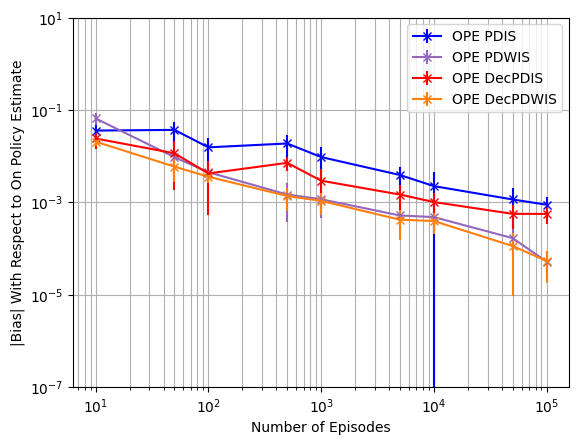

In [ ]:
biases1 = {
    'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'OPE IS': [0.05726999999999992, 0.04779400000000022, 0.00036899999998498816, 0.03178759999999998, 0.010376900000000537, 0.005011540000000087, 0.006363389999999766, 0.0009427759999999822, 0.0008500900000003171],
    'OPE PDIS': [0.05726999999999992, 0.04779400000000022, 0.00036899999998498816, 0.03178759999999998, 0.010376900000000537, 0.005011540000000087, 0.006363389999999766, 0.0009427759999999822, 0.0008500900000003171],
    'OPE PDWIS': [0.08091961831410167, 0.013258285397155626, 0.005625401979545823, 0.0009260468806102656, 0.0009564860301200266, 0.000521659957495272, 0.0007439765516349062, 0.00017871158445285966, 3.628557599437341e-05],
    'OPE DecIS': [0.011100000000000563, 0.021460000000000028, 0.0022499999999999686, 0.010652000000000045, 0.0009890000000001957, 0.0008494000000000053, 0.0016796999999998386, 0.0004689999999999508, 0.0007286800000002315],
    'OPE DecPDIS': [0.011100000000000563, 0.021460000000000028, 0.0022499999999999686, 0.010652000000000045, 0.0009890000000001957, 0.0008494000000000053, 0.0016796999999998386, 0.0004689999999999508, 0.0007286800000002315],
    'OPE DecPDWIS': [0.027100640816512214, 0.008756824673615153, 0.004641766905296195, 0.00024098332931233687, 0.0002583964580336662, 0.0001882542839548094, 0.00041124142621337526, 7.306072423994604e-06, 8.728458472604357e-05]
  }

biases2 = {
    'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'OPE IS': [0.01006999999999402, 0.016232000000002297, 0.011850999999999867, 0.024277599999999643, 0.017481000000000236, 0.006942960000000024, 0.0014889499999997946, 0.0022513740000000932, 0.001416014999999846],
    'OPE PDIS': [0.01006999999999402, 0.016232000000002297, 0.011850999999999867, 0.024277599999999643, 0.017481000000000236, 0.006942960000000024, 0.0014889499999997946, 0.0022513740000000932, 0.001416014999999846],
    'OPE PDWIS': [0.08207935394963572, 0.014656166519881695, 0.0058855822182363364, 0.003529619780854857, 0.002206427693441246, 0.0007615854217615307, 0.00034808332492380125, 0.00026158476517555533, 6.846218547000472e-05],
    'OPE DecIS': [0.03229999999999961, 0.002920000000001215, 0.0002900000000038346, 0.0082719999999995, 0.006366000000000094, 0.002811599999999994, 0.001497499999999681, 0.0005253000000001609, 0.00043532999999993424],
    'OPE DecPDIS': [0.03229999999999961, 0.002920000000001215, 0.0002900000000038346, 0.0082719999999995, 0.006366000000000094, 0.002811599999999994, 0.001497499999999681, 0.0005253000000001609, 0.00043532999999993424],
    'OPE DecPDWIS': [0.021002467183700944, 0.008937987599715296, 0.003316383665031445, 0.0023577826784766075, 0.0015093147272557518, 0.0005503663813561295, 0.0004453637650781178, 0.00013082441362443996, 1.3837061959557202e-05]
  }

biases3 = {
    'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'OPE IS': [0.03197000000000173, 0.017778000000001525, 0.015549999999999077, 0.0011619999999976235, 0.0032784999999996883, 0.002196319999999856, 5.487999999885757e-05, 0.00048492200000004455, 0.00014138899999993724],
    'OPE PDIS': [0.03197000000000173, 0.017778000000001525, 0.015549999999999077, 0.0011619999999976235, 0.0032784999999996883, 0.002196319999999856, 5.487999999885757e-05, 0.00048492200000004455, 0.00014138899999993724],
    'OPE PDWIS': [0.05998533190246969, 0.009514626536442819, 0.0025583132075067414, 0.0005392926735762445, 0.0007139006907925657, 5.454318755348471e-05, 0.00010673304867026993, 3.05741752801582e-05, 2.910955223486107e-07],
    'OPE DecIS': [0.03129999999999964, 0.001020000000001291, 0.003579999999999613, 0.0032839999999995694, 0.00022700000000117263, 0.0007051999999998064, 0.00024640000000023486, 0.00044353999999990846, 0.00029106999999995624],
    'OPE DecPDIS': [0.03129999999999964, 0.001020000000001291, 0.003579999999999613, 0.0032839999999995694, 0.00022700000000117263, 0.0007051999999998064, 0.00024640000000023486, 0.00044353999999990846, 0.00029106999999995624],
    'OPE DecPDWIS': [0.014945980321773576, 0.004658335289516388, 0.0020930966146313597, 0.0009812037884380375, 0.0008676526431940162, 9.393953653408717e-05, 6.956184936701572e-05, 6.282334684679081e-05, 6.49738513172959e-05]
  }

biases4 = {
    'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'OPE IS': [0.036019999999998685, 0.06407200000000023, 0.030473000000000444, 0.020688200000000344, 0.015197599999999895, 0.0018186400000003745, 0.0004951500000002535, 3.578199999953641e-05, 0.0007829940000000854],
    'OPE PDIS': [0.036019999999998685, 0.06407200000000023, 0.030473000000000444, 0.020688200000000344, 0.015197599999999895, 0.0018186400000003745, 0.0004951500000002535, 3.578199999953641e-05, 0.0007829940000000854],
    'OPE PDWIS': [0.07245810703542387, 0.0024166042260067074, 0.0028806967772460968, 0.0006895063118721247, 0.0002302411319575024, 0.0008592778815301342, 0.0007211111837626654, 0.00028495123542947575, 8.902745811111786e-05],
    'OPE DecIS': [0.03260000000000121, 0.02440000000000049, 0.011150000000000593, 0.006974000000000048, 0.004663999999999929, 0.0007516000000003839, 0.00036690000000008893, 0.0002577400000000462, 0.00044886000000014716],
    'OPE DecPDIS': [0.03260000000000121, 0.02440000000000049, 0.011150000000000593, 0.006974000000000048, 0.004663999999999929, 0.0007516000000003839, 0.00036690000000008893, 0.0002577400000000462, 0.00044886000000014716],
    'OPE DecPDWIS': [0.02014605319857291, 0.00032541209616227044, 0.003438431392800499, 0.0016550417640202079, 0.0009275613857723579, 0.000832622569967827, 0.0006451077999537876, 0.0003048342835890017, 9.27045778495583e-05]
  }

biases5 = {
    'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'OPE IS': [0.043329999999999376, 0.038861999999999106, 0.019209999999999738, 0.01595080000000047, 0.0014160000000003105, 0.0035476000000002257, 0.0028218200000000313, 0.0020472280000000506, 0.0012442170000002922],
    'OPE PDIS': [0.043329999999999376, 0.038861999999999106, 0.019209999999999738, 0.01595080000000047, 0.0014160000000003105, 0.0035476000000002257, 0.0028218200000000313, 0.0020472280000000506, 0.0012442170000002922],
    'OPE PDWIS': [0.03163271718138722, 0.0076407426013780635, 0.005445856600732677, 0.0016854382017444567, 0.0017165420606223393, 0.00040005743124052706, 0.0004758650900312956, 8.241901848404108e-05, 6.634495703244178e-05],
    'OPE DecIS': [0.013100000000000629, 0.007739999999999488, 0.0038200000000003457, 0.0065800000000006, 0.002441999999999857, 0.002248000000000187, 0.0012793999999999497, 0.0011190399999999698, 0.0009027300000001705],
    'OPE DecPDIS': [0.013100000000000629, 0.007739999999999488, 0.0038200000000003457, 0.0065800000000006, 0.002441999999999857, 0.002248000000000187, 0.0012793999999999497, 0.0011190399999999698, 0.0009027300000001705],
    'OPE DecPDWIS': [0.019547444179834852, 0.006939024168564022, 0.004385900437420866, 0.0016223347726500301, 0.001814893309436203, 0.00043598173953327565, 0.00039873422086119975, 5.994245729789268e-05, 9.931870888659867e-06]
  }

biases = [biases1, biases2, biases3, biases4, biases5]

plot_graphs(biases, 'bias', 10**(-7), 10**(1))

Process readings for policy divergence plot

In [ ]:
print_specific_mean_std(biases)

1000 EPISODES
[0.0, 0.009550000000000135, 0.009550000000000135, 0.001164719521386736, 0.0029376000000002496, 0.0029376000000002496, 0.001075563704738399]
[0.0, 0.0063399302617615965, 0.0063399302617615965, 0.0007084508022082055, 0.002285799518767708, 0.002285799518767708, 0.0005417826536418994]

100000 EPISODES
[0.0, 0.0008869410000000955, 0.0008869410000000955, 5.208225442605727e-05, 0.000561334000000088, 0.000561334000000088, 5.374638934822297e-05]
[0.0, 0.0004417185070531001, 0.0004417185070531001, 3.088214400599959e-05, 0.00022186750592198084, 0.00022186750592198084, 3.544311877708429e-05]


#### Variance

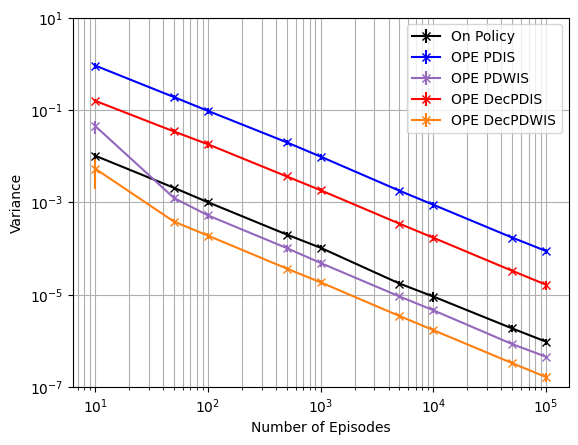

In [ ]:
vars1 = {
    'On Policy': [0.011363999999999999, 0.0022590399999999978, 0.0011617599999999974, 0.00016756960000000005, 0.00010162000000000013, 1.548148400000001e-05, 1.1235130999999922e-05, 1.7966631599999745e-06, 1.037521789999992e-06],
    'OPE IS': [1.0016021171, 0.17706693476399998, 0.07725584073899999, 0.022916424342239984, 0.011758593437389997, 0.0017417313148683996, 0.0007446765737979001, 0.00016381480107062463, 9.75261157532996e-05],
    'OPE PDIS': [1.0016021171, 0.17706693476399998, 0.07725584073899999, 0.022916424342239984, 0.011758593437389997, 0.0017417313148683996, 0.0007446765737979001, 0.00016381480107062463, 9.75261157532996e-05],
    'OPE PDWIS': [0.055150737671347726, 0.0012271952833957326, 0.0004313694972730731, 0.00011470512395686094, 5.808970074752038e-05, 8.099692819312406e-06, 3.7068141018354905e-06, 7.169188380659728e-07, 4.5991458477733177e-07],
    'OPE DecIS': [0.16612859, 0.032185460400000004, 0.013518547500000002, 0.0037791848160000025, 0.0020851861789999986, 0.00038370561483999985, 0.00015582135771000056, 3.6212660880000164e-05, 2.1003382731599836e-05],
    'OPE DecPDIS': [0.16612859, 0.032185460400000004, 0.013518547500000002, 0.0037791848160000025, 0.0020851861789999986, 0.00038370561483999985, 0.00015582135771000056, 3.6212660880000164e-05, 2.1003382731599836e-05],
    'OPE DecPDWIS': [0.004902548985930416, 0.00040314309126757104, 0.00013978498940795148, 3.6783909491545074e-05, 2.083264321017639e-05, 3.84027551704927e-06, 1.5485624905355594e-06, 3.626328840375774e-07, 2.103213352949624e-07]
  }

vars2 = {
    'On Policy': [0.008199999999999999, 0.001981559999999997, 0.0009567599999999978, 0.00017916160000000004, 7.951160000000018e-05, 1.4745836000000028e-05, 6.075699999999956e-06, 2.215259960000019e-06, 1.029698750000019e-06],
    'OPE IS': [0.9245026251000001, 0.1869467437759999, 0.08203192849900001, 0.01669633225023999, 0.007685623936999999, 0.0018923063678783988, 0.0008176835364475003, 0.00016119944686212437, 7.696076319267531e-05],
    'OPE PDIS': [0.9245026251000001, 0.1869467437759999, 0.08203192849900001, 0.01669633225023999, 0.007685623936999999, 0.0018923063678783988, 0.0008176835364475003, 0.00016119944686212437, 7.696076319267531e-05],
    'OPE PDWIS': [0.05947452724976092, 0.001142442710663764, 0.00048293659543023116, 8.714537796065437e-05, 3.741366555760993e-05, 1.0200683430776504e-05, 4.4250025090067836e-06, 8.520093903647919e-07, 4.4784003267703087e-07],
    'OPE DecIS': [0.17476371000000002, 0.033042185599999996, 0.015933781900000006, 0.0035079727359999986, 0.0015855712039999992, 0.0003948475910400004, 0.00017799059874999977, 3.0006013150000014e-05, 1.2404994301099705e-05],
    'OPE DecPDIS': [0.17476371000000002, 0.033042185599999996, 0.015933781900000006, 0.0035079727359999986, 0.0015855712039999992, 0.0003948475910400004, 0.00017799059874999977, 3.0006013150000014e-05, 1.2404994301099705e-05],
    'OPE DecPDWIS': [0.004178343170654985, 0.0003578382076507192, 0.00018322212408390626, 3.5788899350705734e-05, 1.606215906562056e-05, 3.979140476134114e-06, 1.777893577526061e-06, 3.0007111504103036e-07, 1.2419995864016762e-07]
  }

vars3 = {
    'On Policy': [0.012098999999999995, 0.0021300399999999962, 0.0011256399999999974, 0.00023405759999999966, 0.0001098324, 1.982548399999992e-05, 7.76732399999993e-06, 1.5046697600000089e-06, 7.086991599999994e-07],
    'OPE IS': [0.7369284691, 0.167070711916, 0.10395287410000005, 0.019740353620000012, 0.010514103610750003, 0.0019722318210175995, 0.0010874484115255992, 0.00016787612766471652, 0.00010106381512057861],
    'OPE PDIS': [0.7369284691, 0.167070711916, 0.10395287410000005, 0.019740353620000012, 0.010514103610750003, 0.0019722318210175995, 0.0010874484115255992, 0.00016787612766471652, 0.00010106381512057861],
    'OPE PDWIS': [0.035471952463906976, 0.0012561102786474928, 0.00046724059982999086, 9.461240938322728e-05, 4.7504146523297074e-05, 1.015332544910507e-05, 5.021273389029269e-06, 7.997937411446005e-07, 4.64176376915021e-07],
    'OPE DecIS': [0.13938571, 0.029876215599999995, 0.02273274760000001, 0.0039902283040000016, 0.002077400131000002, 0.00033233694656000006, 0.0002093590042400004, 3.454850445239984e-05, 2.038566317709991e-05],
    'OPE DecPDIS': [0.13938571, 0.029876215599999995, 0.02273274760000001, 0.0039902283040000016, 0.002077400131000002, 0.00033233694656000006, 0.0002093590042400004, 3.454850445239984e-05, 2.038566317709991e-05],
    'OPE DecPDWIS': [0.0022264728595489127, 0.00032490668455592987, 0.00023700449053275802, 4.034616761127722e-05, 2.0787685171064826e-05, 3.312220094287994e-06, 2.0960428740395986e-06, 3.456891837333672e-07, 2.0393331276267627e-07]
  }

vars4 = {
    'On Policy': [0.009963999999999999, 0.002045439999999997, 0.000806749999999997, 0.00023051959999999963, 0.00011376160000000011, 2.071303599999997e-05, 1.1429074999999933e-05, 1.6043270400000039e-06, 1.1099929600000066e-06],
    'OPE IS': [1.1226896396, 0.23590926041599997, 0.10329769917099998, 0.023534883520759987, 0.010059984054239997, 0.0017180355066303997, 0.0008579717429275002, 0.00017262546336087678, 9.048732620996399e-05],
    'OPE PDIS': [1.1226896396, 0.23590926041599997, 0.10329769917099998, 0.023534883520759987, 0.010059984054239997, 0.0017180355066303997, 0.0008579717429275002, 0.00017262546336087678, 9.048732620996399e-05],
    'OPE PDWIS': [0.05246701888798655, 0.0015658071781103403, 0.0006285738894581453, 0.00013321508503472083, 5.887960507870849e-05, 9.004598810399863e-06, 4.721775753753225e-06, 9.199917097256305e-07, 4.873398462942312e-07],
    'OPE DecIS': [0.17690443999999997, 0.04100960000000001, 0.018579767500000007, 0.0037352395640000025, 0.0015495217439999997, 0.00029814579903999984, 0.00013832039538999992, 2.7797706260400127e-05, 1.3758508676400009e-05],
    'OPE DecPDIS': [0.17690443999999997, 0.04100960000000001, 0.018579767500000007, 0.0037352395640000025, 0.0015495217439999997, 0.00029814579903999984, 0.00013832039538999992, 2.7797706260400127e-05, 1.3758508676400009e-05],
    'OPE DecPDWIS': [0.011974009912100188, 0.00045161536883373107, 0.00019818722344322183, 3.905934060355431e-05, 1.6080574285397318e-05, 2.9952279896380093e-06, 1.3844129623123697e-06, 2.782671546400064e-07, 1.373859596643068e-07]
  }

vars5 = {
    'On Policy': [0.009383999999999998, 0.0018969599999999972, 0.0009824399999999978, 0.00019277440000000002, 0.00011388910000000004, 1.6586383999999984e-05, 9.127800000000037e-06, 2.2088110000000216e-06, 9.226917600000116e-07],
    'OPE IS': [0.7793864010999999, 0.18113925735599998, 0.11035029950000004, 0.016795115539359997, 0.008713740745999992, 0.0015960778924000002, 0.0009177977474076007, 0.00019677202931761524, 7.495230502801084e-05],
    'OPE PDIS': [0.7793864010999999, 0.18113925735599998, 0.11035029950000004, 0.016795115539359997, 0.008713740745999992, 0.0015960778924000002, 0.0009177977474076007, 0.00019677202931761524, 7.495230502801084e-05],
    'OPE PDWIS': [0.02188906645384188, 0.0010142547002253194, 0.0006025594944932495, 8.233606944554318e-05, 4.124153730821385e-05, 8.467152829938873e-06, 5.131226479407649e-06, 9.881648144529703e-07, 4.0634360628258144e-07],
    'OPE DecIS': [0.13002859, 0.0346287084, 0.01948519160000001, 0.0031884964, 0.0018329760560000005, 0.0003186243760000002, 0.00017298875964000002, 3.640506463839984e-05, 1.468201046510005e-05],
    'OPE DecPDIS': [0.13002859, 0.0346287084, 0.01948519160000001, 0.0031884964, 0.0018329760560000005, 0.0003186243760000002, 0.00017298875964000002, 3.640506463839984e-05, 1.468201046510005e-05],
    'OPE DecPDWIS': [0.003513046448374534, 0.0003760693003938372, 0.000194266426509197, 3.228441079181774e-05, 1.9048425319867204e-05, 3.2017583912085577e-06, 1.7497383819888254e-06, 3.655598803856886e-07, 1.4704656327486368e-07]
  }

vars = [vars1, vars2, vars3, vars4, vars5]

plot_graphs(vars, 'var', 10**(-7), 10**1)

Process readings for policy divergence plot

In [ ]:
print_specific_mean_std(vars)

1000 EPISODES
[0.0001037229400000001, 0.009746409157075997, 0.009746409157075997, 4.862573104306994e-05, 0.0018261310628, 0.0018261310628, 1.856229741042526e-05]
[1.2900095708730178e-05, 0.001417731239607418, 0.001417731239607418, 8.674137844242778e-06, 0.0002300757756515347, 0.0002300757756515347, 2.1332033420399294e-06]

100000 EPISODES
[9.617208840000055e-07, 8.819806506090568e-05, 8.819806506090568e-05, 4.531228893892393e-07, 1.6446911870259902e-05, 1.6446911870259902e-05, 1.6457742592739537e-07]
[1.399247236722852e-07, 1.0578354154150833e-05, 1.0578354154150833e-05, 2.6665771151721417e-08, 3.5483707502444255e-06, 3.5483707502444255e-06, 3.554838370511206e-08]


#### MSE

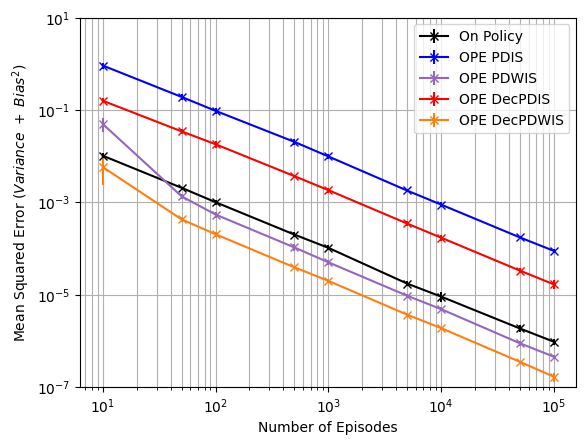

In [ ]:
MSEs1 = {
    'On Policy': [0.011363999999999999, 0.0022590399999999978, 0.0011617599999999974, 0.00016756960000000005, 0.00010162000000000013, 1.548148400000001e-05, 1.1235130999999922e-05, 1.7966631599999745e-06, 1.037521789999992e-06],
    'OPE IS': [1.00488197, 0.1793512012, 0.07725597689999998, 0.023926875855999983, 0.011866273491000008, 0.0017668468480400005, 0.0007851693060899972, 0.0001647036276568006, 9.824876876140015e-05],
    'OPE PDIS': [1.00488197, 0.1793512012, 0.07725597689999998, 0.023926875855999983, 0.011866273491000008, 0.0017668468480400005, 0.0007851693060899972, 0.0001647036276568006, 9.824876876140015e-05],
    'OPE PDWIS': [0.061698722299447624, 0.0014029774150681627, 0.0004630146447045512, 0.00011556268678194894, 5.900456627333515e-05, 8.371821930566375e-06, 4.260315211218057e-06, 7.488566684836243e-07, 4.612312278025752e-07],
    'OPE DecIS': [0.1662518, 0.032645992000000006, 0.013523610000000002, 0.0038926499200000035, 0.002086164299999999, 0.00038442709519999986, 0.00015864274980000002, 3.643262188000012e-05, 2.1534357274000173e-05],
    'OPE DecPDIS': [0.1662518, 0.032645992000000006, 0.013523610000000002, 0.0038926499200000035, 0.002086164299999999, 0.00038442709519999986, 0.00015864274980000002, 3.643262188000012e-05, 2.1534357274000173e-05],
    'OPE DecPDWIS': [0.005636993718596024, 0.0004798250696320062, 0.0001613309894110545, 3.684198245655153e-05, 2.0899411939700736e-05, 3.875715192476608e-06, 1.7176820011695704e-06, 3.6268626273184205e-07, 2.179399340257603e-07]
  }

MSEs2 = {
    'On Policy': [0.008199999999999999, 0.001981559999999997, 0.0009567599999999978, 0.00017916160000000004, 7.951160000000018e-05, 1.4745836000000028e-05, 6.075699999999956e-06, 2.215259960000019e-06, 1.029698750000019e-06],
    'OPE IS': [0.92460403, 0.18721022159999998, 0.08217237470000001, 0.017285734111999972, 0.007991209298000007, 0.0019405110614399992, 0.0008199005085499997, 0.0001662681317500008, 7.896586167289988e-05],
    'OPE PDIS': [0.92460403, 0.18721022159999998, 0.08217237470000001, 0.017285734111999972, 0.007991209298000007, 0.0019405110614399992, 0.0008199005085499997, 0.0001662681317500008, 7.896586167289988e-05],
    'OPE PDWIS': [0.0662115475945505, 0.001357245927722265, 0.0005175766734778509, 9.960359375805626e-05, 4.2281988723994385e-05, 1.0780695785416192e-05, 4.546164510096792e-06, 9.204359797367423e-07, 4.525271035163602e-07],
    'OPE DecIS': [0.175807, 0.033050712, 0.01593386600000001, 0.0035763987199999903, 0.0016260971600000004, 0.00040275268560000036, 0.00018023310499999882, 3.0281953240000183e-05, 1.2594506509999648e-05],
    'OPE DecPDIS': [0.175807, 0.033050712, 0.01593386600000001, 0.0035763987199999903, 0.0016260971600000004, 0.00040275268560000036, 0.00018023310499999882, 3.0281953240000183e-05, 1.2594506509999648e-05],
    'OPE DecPDWIS': [0.00461944679845742, 0.0004377258299833836, 0.00019422052469759366, 4.134803850963006e-05, 1.8340190011531663e-05, 4.282043629861154e-06, 1.976242460770618e-06, 3.171861422412089e-07, 1.2439142292384024e-07]
  }

MSEs3 = {
    'On Policy': [0.012098999999999995, 0.0021300399999999962, 0.0011256399999999974, 0.00023405759999999966, 0.0001098324, 1.982548399999992e-05, 7.76732399999993e-06, 1.5046697600000089e-06, 7.086991599999994e-07],
    'OPE IS': [0.7379505500000001, 0.16738676920000006, 0.10419467660000002, 0.019741703864000006, 0.010524852173000001, 0.001977055642559999, 0.001087451423339999, 0.00016811127701080056, 0.00010108380596989959],
    'OPE PDIS': [0.7379505500000001, 0.16738676920000006, 0.10419467660000002, 0.019741703864000006, 0.010524852173000001, 0.001977055642559999, 0.001087451423339999, 0.00016811127701080056, 0.00010108380596989959],
    'OPE PDWIS': [0.039070192507356424, 0.0013466383967754747, 0.0004737855662976943, 9.490324597100029e-05, 4.8013800719611177e-05, 1.0156300408413564e-05, 5.032665332707719e-06, 8.007285213386623e-07, 4.6417646165162413e-07],
    'OPE DecIS': [0.14036539999999997, 0.029877255999999998, 0.022745564000000006, 0.004001012959999999, 0.0020774516600000027, 0.0003328342535999998, 0.00020941971720000053, 3.4745232183999756e-05, 2.0470384921999886e-05],
    'OPE DecPDIS': [0.14036539999999997, 0.029877255999999998, 0.022745564000000006, 0.004001012959999999, 0.0020774516600000027, 0.0003328342535999998, 0.00020941971720000053, 3.4745232183999756e-05, 2.0470384921999886e-05],
    'OPE DecPDWIS': [0.0024498551873277557, 0.0003466067722254836, 0.00024138554397093928, 4.130892848572238e-05, 2.154050628030639e-05, 3.321044730812233e-06, 2.100881724926958e-06, 3.4963595664239936e-07, 2.0815491411767835e-07]
  }

MSEs4 = {
    'On Policy': [0.009963999999999999, 0.002045439999999997, 0.000806749999999997, 0.00023051959999999963, 0.00011376160000000011, 2.071303599999997e-05, 1.1429074999999933e-05, 1.6043270400000039e-06, 1.1099929600000066e-06],
    'OPE IS': [1.1239870799999998, 0.2400144816, 0.10422630290000001, 0.02396288514, 0.010290951099999994, 0.001721342958080001, 0.0008582169164500005, 0.00017262674371240074, 9.110040581400013e-05],
    'OPE PDIS': [1.1239870799999998, 0.2400144816, 0.10422630290000001, 0.02396288514, 0.010290951099999994, 0.001721342958080001, 0.0008582169164500005, 0.00017262674371240074, 9.110040581400013e-05],
    'OPE PDWIS': [0.05771719616314349, 0.0015716471540954938, 0.0006368723033805813, 0.00013369050398883233, 5.893261605755356e-05, 9.742957288086778e-06, 5.241777093100817e-06, 1.001188916298415e-06, 4.95265734591958e-07],
    'OPE DecIS': [0.17796720000000005, 0.04160496000000003, 0.01870409000000002, 0.003783876240000003, 0.001571274639999999, 0.0002987107016000004, 0.00013845501099999998, 2.786413616800015e-05, 1.3959983976000141e-05],
    'OPE DecPDIS': [0.17796720000000005, 0.04160496000000003, 0.01870409000000002, 0.003783876240000003, 0.001571274639999999, 0.0002987107016000004, 0.00013845501099999998, 2.786413616800015e-05, 1.3959983976000141e-05],
    'OPE DecPDWIS': [0.012379873371579917, 0.0004517212618660598, 0.0002100100338862178, 4.1798503844205434e-05, 1.6940944409773255e-05, 3.6884883336578382e-06, 1.8005770358735857e-06, 3.7119109509122633e-07, 1.4598009841857163e-07]
  }

MSEs5 = {
    'On Policy': [0.009383999999999998, 0.0018969599999999972, 0.0009824399999999978, 0.00019277440000000002, 0.00011388910000000004, 1.6586383999999984e-05, 9.127800000000037e-06, 2.2088110000000216e-06, 9.226917600000116e-07],
    'OPE IS': [0.7812638899999998, 0.1826495123999999, 0.11071932360000003, 0.017049543560000012, 0.008715745801999993, 0.0016086633581600019, 0.0009257604155200009, 0.00020096317180159944, 7.650038097110056e-05],
    'OPE PDIS': [0.7812638899999998, 0.1826495123999999, 0.11071932360000003, 0.017049543560000012, 0.008715745801999993, 0.0016086633581600019, 0.0009257604155200009, 0.00020096317180159944, 7.650038097110056e-05],
    'OPE PDWIS': [0.02288969525011951, 0.001072635647725833, 0.0006322168486089932, 8.517677137744277e-05, 4.418805395409944e-05, 8.627198778229642e-06, 5.357674063318142e-06, 9.94957709060843e-07, 4.10745259606218e-07],
    'OPE DecIS': [0.13020020000000002, 0.03468861599999999, 0.019499784000000013, 0.003231792800000008, 0.0018389394199999998, 0.00032367788000000106, 0.0001746256239999999, 3.765731515999977e-05, 1.5496931918000358e-05],
    'OPE DecPDIS': [0.13020020000000002, 0.03468861599999999, 0.019499784000000013, 0.003231792800000008, 0.0018389394199999998, 0.00032367788000000106, 0.0001746256239999999, 3.765731515999977e-05, 1.5496931918000358e-05],
    'OPE DecPDWIS': [0.003895149022338293, 0.00042421935680575284, 0.00021350254915616555, 3.491638090636717e-05, 2.2342263044503497e-05, 3.3918384684150187e-06, 1.9087273608746134e-06, 3.691529785725983e-07, 1.471452053342127e-07]
  }

MSEs = [MSEs1, MSEs2, MSEs3, MSEs4, MSEs5]

plot_graphs(MSEs, 'MSE', 10**(-7), 10**(1))

Process readings for policy divergence plot

In [ ]:
print_specific_mean_std(MSEs)

1000 EPISODES
[0.0001037229400000001, 0.009877806372799999, 0.009877806372799999, 5.048420514571874e-05, 0.0018399854360000001, 0.0018399854360000001, 2.0012663137163106e-05]
[1.2900095708730178e-05, 0.001374990298597353, 0.001374990298597353, 7.1692813135665435e-06, 0.0002167713178756949, 0.0002167713178756949, 2.038641024471408e-06]

100000 EPISODES
[9.617208840000055e-07, 8.917984463786005e-05, 8.917984463786005e-05, 4.5678915743374706e-07, 1.681123292000004e-05, 1.681123292000004e-05, 1.6872231496401267e-07]
[1.399247236722852e-07, 9.927058801776963e-06, 9.927058801776963e-06, 2.7177037635943682e-08, 3.5590753382978948e-06, 3.5590753382978948e-06, 3.721642638560167e-08]


#### ESS

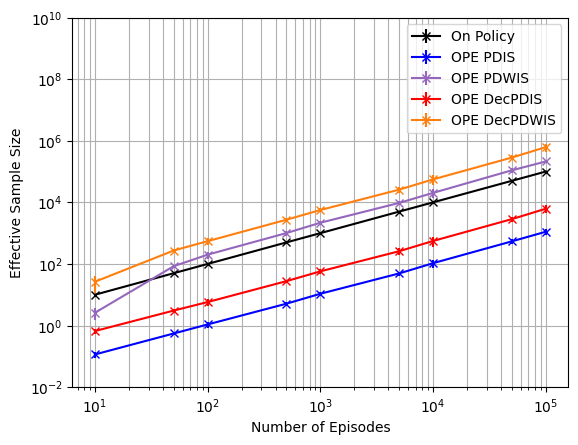

In [ ]:
EPISODES = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

vars1 = {
    'On Policy': [0.011363999999999999, 0.0022590399999999978, 0.0011617599999999974, 0.00016756960000000005, 0.00010162000000000013, 1.548148400000001e-05, 1.1235130999999922e-05, 1.7966631599999745e-06, 1.037521789999992e-06],
    'OPE IS': [1.0016021171, 0.17706693476399998, 0.07725584073899999, 0.022916424342239984, 0.011758593437389997, 0.0017417313148683996, 0.0007446765737979001, 0.00016381480107062463, 9.75261157532996e-05],
    'OPE PDIS': [1.0016021171, 0.17706693476399998, 0.07725584073899999, 0.022916424342239984, 0.011758593437389997, 0.0017417313148683996, 0.0007446765737979001, 0.00016381480107062463, 9.75261157532996e-05],
    'OPE PDWIS': [0.055150737671347726, 0.0012271952833957326, 0.0004313694972730731, 0.00011470512395686094, 5.808970074752038e-05, 8.099692819312406e-06, 3.7068141018354905e-06, 7.169188380659728e-07, 4.5991458477733177e-07],
    'OPE DecIS': [0.16612859, 0.032185460400000004, 0.013518547500000002, 0.0037791848160000025, 0.0020851861789999986, 0.00038370561483999985, 0.00015582135771000056, 3.6212660880000164e-05, 2.1003382731599836e-05],
    'OPE DecPDIS': [0.16612859, 0.032185460400000004, 0.013518547500000002, 0.0037791848160000025, 0.0020851861789999986, 0.00038370561483999985, 0.00015582135771000056, 3.6212660880000164e-05, 2.1003382731599836e-05],
    'OPE DecPDWIS': [0.004902548985930416, 0.00040314309126757104, 0.00013978498940795148, 3.6783909491545074e-05, 2.083264321017639e-05, 3.84027551704927e-06, 1.5485624905355594e-06, 3.626328840375774e-07, 2.103213352949624e-07]
  }

ESS1 = calculate_ESS(vars1, EPISODES)

vars2 = {
    'On Policy': [0.008199999999999999, 0.001981559999999997, 0.0009567599999999978, 0.00017916160000000004, 7.951160000000018e-05, 1.4745836000000028e-05, 6.075699999999956e-06, 2.215259960000019e-06, 1.029698750000019e-06],
    'OPE IS': [0.9245026251000001, 0.1869467437759999, 0.08203192849900001, 0.01669633225023999, 0.007685623936999999, 0.0018923063678783988, 0.0008176835364475003, 0.00016119944686212437, 7.696076319267531e-05],
    'OPE PDIS': [0.9245026251000001, 0.1869467437759999, 0.08203192849900001, 0.01669633225023999, 0.007685623936999999, 0.0018923063678783988, 0.0008176835364475003, 0.00016119944686212437, 7.696076319267531e-05],
    'OPE PDWIS': [0.05947452724976092, 0.001142442710663764, 0.00048293659543023116, 8.714537796065437e-05, 3.741366555760993e-05, 1.0200683430776504e-05, 4.4250025090067836e-06, 8.520093903647919e-07, 4.4784003267703087e-07],
    'OPE DecIS': [0.17476371000000002, 0.033042185599999996, 0.015933781900000006, 0.0035079727359999986, 0.0015855712039999992, 0.0003948475910400004, 0.00017799059874999977, 3.0006013150000014e-05, 1.2404994301099705e-05],
    'OPE DecPDIS': [0.17476371000000002, 0.033042185599999996, 0.015933781900000006, 0.0035079727359999986, 0.0015855712039999992, 0.0003948475910400004, 0.00017799059874999977, 3.0006013150000014e-05, 1.2404994301099705e-05],
    'OPE DecPDWIS': [0.004178343170654985, 0.0003578382076507192, 0.00018322212408390626, 3.5788899350705734e-05, 1.606215906562056e-05, 3.979140476134114e-06, 1.777893577526061e-06, 3.0007111504103036e-07, 1.2419995864016762e-07]
  }

ESS2 = calculate_ESS(vars2, EPISODES)

vars3 = {
    'On Policy': [0.012098999999999995, 0.0021300399999999962, 0.0011256399999999974, 0.00023405759999999966, 0.0001098324, 1.982548399999992e-05, 7.76732399999993e-06, 1.5046697600000089e-06, 7.086991599999994e-07],
    'OPE IS': [0.7369284691, 0.167070711916, 0.10395287410000005, 0.019740353620000012, 0.010514103610750003, 0.0019722318210175995, 0.0010874484115255992, 0.00016787612766471652, 0.00010106381512057861],
    'OPE PDIS': [0.7369284691, 0.167070711916, 0.10395287410000005, 0.019740353620000012, 0.010514103610750003, 0.0019722318210175995, 0.0010874484115255992, 0.00016787612766471652, 0.00010106381512057861],
    'OPE PDWIS': [0.035471952463906976, 0.0012561102786474928, 0.00046724059982999086, 9.461240938322728e-05, 4.7504146523297074e-05, 1.015332544910507e-05, 5.021273389029269e-06, 7.997937411446005e-07, 4.64176376915021e-07],
    'OPE DecIS': [0.13938571, 0.029876215599999995, 0.02273274760000001, 0.0039902283040000016, 0.002077400131000002, 0.00033233694656000006, 0.0002093590042400004, 3.454850445239984e-05, 2.038566317709991e-05],
    'OPE DecPDIS': [0.13938571, 0.029876215599999995, 0.02273274760000001, 0.0039902283040000016, 0.002077400131000002, 0.00033233694656000006, 0.0002093590042400004, 3.454850445239984e-05, 2.038566317709991e-05],
    'OPE DecPDWIS': [0.0022264728595489127, 0.00032490668455592987, 0.00023700449053275802, 4.034616761127722e-05, 2.0787685171064826e-05, 3.312220094287994e-06, 2.0960428740395986e-06, 3.456891837333672e-07, 2.0393331276267627e-07]
  }

ESS3 = calculate_ESS(vars3, EPISODES)

vars4 = {
    'On Policy': [0.009963999999999999, 0.002045439999999997, 0.000806749999999997, 0.00023051959999999963, 0.00011376160000000011, 2.071303599999997e-05, 1.1429074999999933e-05, 1.6043270400000039e-06, 1.1099929600000066e-06],
    'OPE IS': [1.1226896396, 0.23590926041599997, 0.10329769917099998, 0.023534883520759987, 0.010059984054239997, 0.0017180355066303997, 0.0008579717429275002, 0.00017262546336087678, 9.048732620996399e-05],
    'OPE PDIS': [1.1226896396, 0.23590926041599997, 0.10329769917099998, 0.023534883520759987, 0.010059984054239997, 0.0017180355066303997, 0.0008579717429275002, 0.00017262546336087678, 9.048732620996399e-05],
    'OPE PDWIS': [0.05246701888798655, 0.0015658071781103403, 0.0006285738894581453, 0.00013321508503472083, 5.887960507870849e-05, 9.004598810399863e-06, 4.721775753753225e-06, 9.199917097256305e-07, 4.873398462942312e-07],
    'OPE DecIS': [0.17690443999999997, 0.04100960000000001, 0.018579767500000007, 0.0037352395640000025, 0.0015495217439999997, 0.00029814579903999984, 0.00013832039538999992, 2.7797706260400127e-05, 1.3758508676400009e-05],
    'OPE DecPDIS': [0.17690443999999997, 0.04100960000000001, 0.018579767500000007, 0.0037352395640000025, 0.0015495217439999997, 0.00029814579903999984, 0.00013832039538999992, 2.7797706260400127e-05, 1.3758508676400009e-05],
    'OPE DecPDWIS': [0.011974009912100188, 0.00045161536883373107, 0.00019818722344322183, 3.905934060355431e-05, 1.6080574285397318e-05, 2.9952279896380093e-06, 1.3844129623123697e-06, 2.782671546400064e-07, 1.373859596643068e-07]
  }

ESS4 = calculate_ESS(vars4, EPISODES)

vars5 = {
    'On Policy': [0.009383999999999998, 0.0018969599999999972, 0.0009824399999999978, 0.00019277440000000002, 0.00011388910000000004, 1.6586383999999984e-05, 9.127800000000037e-06, 2.2088110000000216e-06, 9.226917600000116e-07],
    'OPE IS': [0.7793864010999999, 0.18113925735599998, 0.11035029950000004, 0.016795115539359997, 0.008713740745999992, 0.0015960778924000002, 0.0009177977474076007, 0.00019677202931761524, 7.495230502801084e-05],
    'OPE PDIS': [0.7793864010999999, 0.18113925735599998, 0.11035029950000004, 0.016795115539359997, 0.008713740745999992, 0.0015960778924000002, 0.0009177977474076007, 0.00019677202931761524, 7.495230502801084e-05],
    'OPE PDWIS': [0.02188906645384188, 0.0010142547002253194, 0.0006025594944932495, 8.233606944554318e-05, 4.124153730821385e-05, 8.467152829938873e-06, 5.131226479407649e-06, 9.881648144529703e-07, 4.0634360628258144e-07],
    'OPE DecIS': [0.13002859, 0.0346287084, 0.01948519160000001, 0.0031884964, 0.0018329760560000005, 0.0003186243760000002, 0.00017298875964000002, 3.640506463839984e-05, 1.468201046510005e-05],
    'OPE DecPDIS': [0.13002859, 0.0346287084, 0.01948519160000001, 0.0031884964, 0.0018329760560000005, 0.0003186243760000002, 0.00017298875964000002, 3.640506463839984e-05, 1.468201046510005e-05],
    'OPE DecPDWIS': [0.003513046448374534, 0.0003760693003938372, 0.000194266426509197, 3.228441079181774e-05, 1.9048425319867204e-05, 3.2017583912085577e-06, 1.7497383819888254e-06, 3.655598803856886e-07, 1.4704656327486368e-07]
  }

ESS5 = calculate_ESS(vars5, EPISODES)

ESS = [ESS1, ESS2, ESS3, ESS4, ESS5]

plot_graphs(ESS, 'ESS', 10**(-2), 10**10)

Process readings for policy divergence plot

In [ ]:
print_specific_mean_std(ESS)

1000 EPISODES
[1000.0, 10.762454168054884, 10.762454168054884, 2176.0489074598377, 57.46040498802366, 57.46040498802366, 5633.0191124941375]
[0.0, 1.4416939121037389, 1.4416939121037389, 347.97212541012203, 9.242945363977176, 9.242945363977176, 819.2603890619581]

100000 EPISODES
[100000.0, 1112.1507991820836, 1112.1507991820836, 212606.40393109634, 6213.822219642947, 6213.822219642947, 621060.8019474361]
[0.0, 223.34762196417023, 223.34762196417023, 29996.310838219822, 1839.1901098220108, 1839.1901098220108, 184053.97128382747]


## Policy Divergence 4.46

**Note**: Restart the runtime before running all code in this section

In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.2025],
             ['state', 'up,left', 0.2475],
             ['state', 'down,right', 0.2475],
             ['state', 'down,left', 0.3025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.45],
                   ['state', 'left', 0.55]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.45],
                 ['state', 'down', 0.55]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

### Generate Data Set

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

Policy divergence: 4.4567901234567895
Start state: state, start state no: 0


### Run Estimates on Collected Data Sets

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 4.46
VERSION_NUMBER = 5

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means_pd_4 = np.zeros((2, 7))
biases_pd_4 = np.zeros((2, 7))
vars_pd_4 = np.zeros((2, 7))
MSEs_pd_4 = np.zeros((2, 7))

#### 100 runs, 1000 episodes

In [ ]:
means_pd_4[0, :], biases_pd_4[0, :], vars_pd_4[0, :], MSEs_pd_4[0, :] = evaluate_PE(100, 1000)
gc.collect()

Mean on policy Q estimate: 1.8999999999999997. Variance of on policy Q estimate: 8.042e-05
Mean off policy IS estimate: 1.8905174859708185. Bias1: 0.009482514029180922. Bias2: 0.00948251402918121. Variance: 0.012362424579343249. MSE: 0.012452342651656862
Mean off policy PDIS estimate: 1.8905174859708185. Bias1: 0.009482514029180922. Bias2: 0.00948251402918121 Variance: 0.012362424579343249. MSE: 0.012452342651656862
Mean off policy PDWIS estimate: 1.898835281492403. Bias1: 0.0011647185075967916. Bias2: 0.001164718507596696. Variance: 5.5687947660788984e-05. MSE: 5.704451686272748e-05
Mean off policy DecIS estimate: 1.8989022222222218. Bias1: 0.001097777777777509. Bias2: 0.0010977777777778641. Variance: 0.002151602785185181. MSE: 0.002152807901234563
Mean off policy DecPDIS estimate: 1.8989022222222218. Bias1: 0.001097777777777509. Bias2: 0.0010977777777778641. Variance: 0.002151602785185181. MSE: 0.002152807901234563
Mean off policy DecPDWIS estimate: 1.899723416416048. Bias1: 0.000276

0

#### 100 runs 100000 episodes

In [ ]:
means_pd_4[1, :], biases_pd_4[1, :], vars_pd_4[1, :], MSEs_pd_4[1, :] = evaluate_PE(100, 100000)
gc.collect()

Mean on policy Q estimate: 1.8999673999999995. Variance of on policy Q estimate: 9.690932400000106e-07
Mean off policy IS estimate: 1.8997378213243539. Bias1: 0.0002295786756455229. Bias2: 0.0002295786756456586. Variance: 0.00014271032254112436. MSE: 0.00014276302890943552
Mean off policy PDIS estimate: 1.8997378213243539. Bias1: 0.0002295786756455229. Bias2: 0.0002295786756456586 Variance: 0.00014271032254112436. MSE: 0.00014276302890943552
Mean off policy PDWIS estimate: 1.8999782905558964. Bias1: 1.0890555896713057e-05. Bias2: 1.0890555896869714e-05. Variance: 6.097332807227936e-07. MSE: 6.098518849305331e-07
Mean off policy DecIS estimate: 1.8999214666666666. Bias1: 4.5933333332969024e-05. Bias2: 4.593333333291483e-05. Variance: 2.5200688713086262e-05. MSE: 2.520279858419734e-05
Mean off policy DecPDIS estimate: 1.8999214666666666. Bias1: 4.5933333332969024e-05. Bias2: 4.593333333291483e-05. Variance: 2.5200688713086262e-05. MSE: 2.520279858419734e-05
Mean off policy DecPDWIS estim

0

Print out values to copy-paste

In [ ]:
print(biases_pd_4[0,:])
print()
print(vars_pd_4[0,:])
print()
print(MSEs_pd_4[0,:])
print()
print(biases_pd_4[1,:])
print()
print(vars_pd_4[1,:])
print()
print(MSEs_pd_4[1,:])

[0.         0.00948251 0.00948251 0.00116472 0.00109778 0.00109778
 0.00027658]

[8.04200000e-05 1.23624246e-02 1.23624246e-02 5.56879477e-05
 2.15160279e-03 2.15160279e-03 1.76484454e-05]

[8.04200000e-05 1.24523427e-02 1.24523427e-02 5.70445169e-05
 2.15280790e-03 2.15280790e-03 1.77249439e-05]

[0.00000000e+00 2.29578676e-04 2.29578676e-04 1.08905559e-05
 4.59333333e-05 4.59333333e-05 2.34894612e-05]

[9.69093240e-07 1.42710323e-04 1.42710323e-04 6.09733281e-07
 2.52006887e-05 2.52006887e-05 2.08443706e-07]

[9.69093240e-07 1.42763029e-04 1.42763029e-04 6.09851885e-07
 2.52027986e-05 2.52027986e-05 2.08995461e-07]


Hold values here and print the means and stds out

In [ ]:
def ESS_on_list(lst, N):
  on_policy_var  = lst[0]
  ESS_list = np.zeros(len(lst))
  ESS_list[0] = N
  for id in range(1, len(lst)):
    ESS_list[id] = (N * on_policy_var)/lst[id]
  return ESS_list

In [ ]:
biases1000 = np.array([[0., 0.00490443, 0.00490443, 0.0010474, 0.00198333, 0.00198333, 0.00156854],
                       [0., 0.01223677, 0.01223677, 0.00158285, 0.00413778, 0.00413778, 0.00090323],
                       [0., 0.02530275, 0.02530275, 0.00235686, 0.00386111, 0.00386111, 0.00085368],
                       [0.00000000e+00, 3.31343434e-03, 3.31343434e-03, 1.61918532e-04, 1.97000000e-03, 1.97000000e-03, 3.43507988e-05],
                       [0., 0.00948251, 0.00948251, 0.00116472, 0.00109778, 0.00109778, 0.00027658]])

vars1000 = np.array([[7.41875000e-05, 1.02211078e-02, 1.02211078e-02, 4.66782636e-05, 1.72410926e-03, 1.72410926e-03, 1.45511881e-05],
                     [1.14975600e-04, 1.32721304e-02, 1.32721304e-02, 6.24676639e-05, 1.98412553e-03, 1.98412553e-03, 1.71081095e-05],
                     [7.04800000e-05, 1.37542554e-02, 1.37542554e-02, 5.40654654e-05, 2.92395515e-03, 2.92395515e-03, 2.42572665e-05],
                     [7.42051000e-05, 1.19345056e-02, 1.19345056e-02, 5.31498244e-05, 1.94971198e-03, 1.94971198e-03, 1.57284121e-05],
                     [8.04200000e-05, 1.23624246e-02, 1.23624246e-02, 5.56879477e-05, 2.15160279e-03, 2.15160279e-03, 1.76484454e-05]])

MSEs1000 = np.array([[7.41875000e-05, 1.02451613e-02, 1.02451613e-02, 4.77753097e-05, 1.72804287e-03, 1.72804287e-03, 1.70115154e-05],
                     [1.14975600e-04, 1.34218689e-02, 1.34218689e-02, 6.49730841e-05, 2.00124673e-03, 2.00124673e-03, 1.79239337e-05],
                     [7.04800000e-05, 1.43944846e-02, 1.43944846e-02, 5.96202704e-05, 2.93886333e-03, 2.93886333e-03, 2.49860370e-05],
                     [7.42051000e-05, 1.19454844e-02, 1.19454844e-02, 5.31760421e-05, 1.95359288e-03, 1.95359288e-03, 1.57295921e-05],
                     [8.04200000e-05, 1.24523427e-02, 1.24523427e-02, 5.70445169e-05, 2.15280790e-03, 2.15280790e-03, 1.77249439e-05]])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.011047978867999998, 0.011047978867999998, 0.0012627497064, 0.00261, 0.00261, 0.0007272761597599999]
[0.0, 0.00780549535784909, 0.00780549535784909, 0.0007165690652600911, 0.0011822446936061925, 0.0011822446936061925, 0.0005362714085054195]
Var:
[8.285363999999999e-05, 0.01230888476, 0.01230888476, 5.4409833e-05, 0.002146700942, 0.002146700942, 1.785868432e-05]
[1.6375280830397997e-05, 0.0012262770775456411, 0.0012262770775456411, 5.060545269086542e-06, 0.00041181725981311637, 0.00041181725981311637, 3.377188412118352e-06]
MSE:
[8.285363999999999e-05, 0.01249186838, 0.01249186838, 5.6517844640000006e-05, 0.002154910742, 0.002154910742, 1.8675204419999997e-05]
[1.6375280830397997e-05, 0.0014023294822622528, 0.0014023294822622528, 5.813657454394391e-06, 0.000414956328416948, 0.000414956328416948, 3.2477223926436135e-06]
ESS:
[1000.0, 6.7536642574515415, 6.7536642574515415, 1514.7543823126805, 40.103570721904205, 40.103570721904205, 4799.822212279667]
[0.0, 1.1750731149682303

In [ ]:
biases100000 = np.array([[0.00000000e+00, 8.59121773e-04, 8.59121773e-04, 9.60552058e-05, 3.42944444e-04, 3.42944444e-04, 7.12991095e-05],
                         [0.00000000e+00, 9.93012346e-05, 9.93012346e-05, 4.07176355e-05, 3.80155556e-04, 3.80155556e-04, 1.07035201e-04],
                         [0.00000000e+00, 4.60334680e-04, 4.60334680e-04, 1.92070638e-05, 3.02222222e-06, 3.02222222e-06, 1.99518469e-05],
                         [0., 0.00123447, 0.00123447, 0.00012979, 0.00068398, 0.00068398, 0.00012849],
                         [0.00000000e+00, 2.29578676e-04, 2.29578676e-04, 1.08905559e-05, 4.59333333e-05, 4.59333333e-05, 2.34894612e-05]])

vars100000 = np.array([[1.06442139e-06, 1.47566008e-04, 1.47566008e-04, 6.78099901e-07, 2.09421325e-05, 2.09421325e-05, 1.72767498e-07],
                       [1.18078300e-06, 1.57151068e-04, 1.57151068e-04, 6.50964925e-07, 2.53944382e-05, 2.53944382e-05, 2.09348679e-07],
                       [8.09702910e-07, 1.09042343e-04, 1.09042343e-04, 4.90237342e-07, 2.13513788e-05, 2.13513788e-05, 1.76403283e-07],
                       [9.01990510e-07, 1.26544776e-04, 1.26544776e-04, 5.81613635e-07, 2.35925210e-05, 2.35925210e-05, 1.95291924e-07],
                       [9.69093240e-07, 1.42710323e-04, 1.42710323e-04, 6.09733281e-07, 2.52006887e-05, 2.52006887e-05, 2.08443706e-07]])

MSEs100000 = np.array([[1.06442139e-06, 1.48304098e-04, 1.48304098e-04, 6.87326503e-07, 2.10597434e-05, 2.10597434e-05, 1.77851061e-07],
                       [1.18078300e-06, 1.57160929e-04, 1.57160929e-04, 6.52622851e-07, 2.55389565e-05, 2.55389565e-05, 2.20805214e-07],
                       [8.09702910e-07, 1.09254251e-04, 1.09254251e-04, 4.90606253e-07, 2.13513880e-05, 2.13513880e-05, 1.76801360e-07],
                       [9.01990510e-07, 1.28068682e-04, 1.28068682e-04, 5.98458386e-07, 2.40603466e-05, 2.40603466e-05, 2.11800354e-07],
                       [9.69093240e-07, 1.42763029e-04, 1.42763029e-04, 6.09851885e-07, 2.52027986e-05, 2.52027986e-05, 2.08995461e-07]])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.0005765612727200001, 0.0005765612727200001, 5.93320922e-05, 0.000291207111104, 0.000291207111104, 7.005312372e-05]
[0.0, 0.00041817867401813596, 0.00041817867401813596, 4.607819915203502e-05, 0.0002482212222899755, 0.0002482212222899755, 4.3502661151112595e-05]
Var:
[9.8519821e-07, 0.0001366029036, 0.0001366029036, 6.021298168e-07, 2.329623184e-05, 2.329623184e-05, 1.92451018e-07]
[1.2846105561510645e-07, 1.69733185996515e-05, 1.69733185996515e-05, 6.504609717211443e-08, 1.8676964516143778e-06, 1.8676964516143778e-06, 1.5455345495055916e-08]
MSE:
[9.8519821e-07, 0.0001371101978, 0.0001371101978, 6.077731755999999e-07, 2.3442646619999997e-05, 2.3442646619999997e-05, 1.9925069e-07]
[1.2846105561510645e-07, 1.6834443881542313e-05, 1.6834443881542313e-05, 6.657236569855881e-08, 1.8934515437468273e-06, 1.8934515437468273e-06, 1.8324675560612e-08]
ESS:
[100000.0, 721.4184037402914, 721.4184037402914, 163509.539273789, 4238.686415318495, 4238.686415318495, 513184.0811153529]
[0.

## Policy Divergence 5.64

**Note**: Restart the runtime before running all code in this section

In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.16],
             ['state', 'up,left', 0.24],
             ['state', 'down,right', 0.24],
             ['state', 'down,left', 0.36]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.4],
                   ['state', 'left', 0.6]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.4],
                 ['state', 'down', 0.6]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

### Generate Data Set

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

Policy divergence: 5.640625
Start state: state, start state no: 0


### Run Estimates on Collected Data Sets

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 5.64
VERSION_NUMBER = 4

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means_pd_5 = np.zeros((2, 7))
biases_pd_5 = np.zeros((2, 7))
vars_pd_5 = np.zeros((2, 7))
MSEs_pd_5 = np.zeros((2, 7))

#### 100 runs, 1000 episodes

In [ ]:
means_pd_5[0, :], biases_pd_5[0, :], vars_pd_5[0, :], MSEs_pd_5[0, :] = evaluate_PE(100, 1000)
gc.collect()

Mean on policy Q estimate: 1.89883. Variance of on policy Q estimate: 0.00011818110000000002
Mean off policy IS estimate: 1.9048826041666664. Bias1: 0.006052604166666553. Bias2: 0.00605260416666642. Variance: 0.014039389537445742. MSE: 0.014076023554644091
Mean off policy PDIS estimate: 1.9048826041666664. Bias1: 0.006052604166666553. Bias2: 0.00605260416666642 Variance: 0.014039389537445742. MSE: 0.014076023554644091
Mean off policy PDWIS estimate: 1.8996261723715029. Bias1: 0.0007961723715024959. Bias2: 0.0007961723715028679. Variance: 5.260200969389963e-05. MSE: 5.323590013904354e-05
Mean off policy DecIS estimate: 1.9050349999999994. Bias1: 0.006204999999999515. Bias2: 0.00620499999999935. Variance: 0.002491157212499999. MSE: 0.002529659237499993
Mean off policy DecPDIS estimate: 1.9050349999999994. Bias1: 0.006204999999999515. Bias2: 0.00620499999999935. Variance: 0.002491157212499999. MSE: 0.002529659237499993
Mean off policy DecPDWIS estimate: 1.9002202814651996. Bias1: 0.001390

0

#### 100 runs 100000 episodes

In [ ]:
means_pd_5[1, :], biases_pd_5[1, :], vars_pd_5[1, :], MSEs_pd_5[1, :] = evaluate_PE(100, 100000)
gc.collect()

Mean on policy Q estimate: 1.8999567. Variance of on policy Q estimate: 7.835341099999983e-07
Mean off policy IS estimate: 1.8986232322916665. Bias1: 0.0013334677083333625. Bias2: 0.0013334677083334245. Variance: 0.00013248450673838046. MSE: 0.0001342626428675483
Mean off policy PDIS estimate: 1.8986232322916665. Bias1: 0.0013334677083333625. Bias2: 0.0013334677083334245 Variance: 0.00013248450673838046. MSE: 0.0001342626428675483
Mean off policy PDWIS estimate: 1.8999518701467475. Bias1: 4.82985325280427e-06. Bias2: 4.829853252452665e-06. Variance: 5.626493503561915e-07. MSE: 5.626726778386352e-07
Mean off policy DecIS estimate: 1.8990754124999996. Bias1: 0.0008812875000002442. Bias2: 0.0008812875000003828. Variance: 2.124978278296864e-05. MSE: 2.202645044062532e-05
Mean off policy DecPDIS estimate: 1.8990754124999996. Bias1: 0.0008812875000002442. Bias2: 0.0008812875000003828. Variance: 2.124978278296864e-05. MSE: 2.202645044062532e-05
Mean off policy DecPDWIS estimate: 1.89992074653

0

Print out values to copy-paste

In [ ]:
print(biases_pd_5[0,:])
print()
print(vars_pd_5[0,:])
print()
print(MSEs_pd_5[0,:])
print()
print(biases_pd_5[1,:])
print()
print(vars_pd_5[1,:])
print()
print(MSEs_pd_5[1,:])

[0.         0.0060526  0.0060526  0.00079617 0.006205   0.006205
 0.00139028]

[1.18181100e-04 1.40393895e-02 1.40393895e-02 5.26020097e-05
 2.49115721e-03 2.49115721e-03 1.70983141e-05]

[1.18181100e-04 1.40760236e-02 1.40760236e-02 5.32359001e-05
 2.52965924e-03 2.52965924e-03 1.90311966e-05]

[0.00000000e+00 1.33346771e-03 1.33346771e-03 4.82985325e-06
 8.81287500e-04 8.81287500e-04 3.59534677e-05]

[7.83534110e-07 1.32484507e-04 1.32484507e-04 5.62649350e-07
 2.12497828e-05 2.12497828e-05 1.47948709e-07]

[7.83534110e-07 1.34262643e-04 1.34262643e-04 5.62672678e-07
 2.20264504e-05 2.20264504e-05 1.49241361e-07]


Hold values here and print the means and stds out

In [ ]:
biases1000 = np.array([[0.00000000e+00, 2.31928125e-02, 2.31928125e-02, 7.59653860e-05, 3.27250000e-03, 3.27250000e-03, 1.09145186e-03],
                       [0., 0.01027615, 0.01027615, 0.00131116, 0.00516, 0.00516, 0.00105376],
                       [0., 0.00103531, 0.00103531, 0.00028929, 0.002165, 0.002165, 0.00038582],
                       [0., 0.00038698, 0.00038698, 0.00039841, 0.000375,  0.000375, 0.00057798],
                       [0., 0.0060526,  0.0060526,  0.00079617, 0.006205,  0.006205, 0.00139028]])

vars1000 = np.array([[8.83424000e-05, 1.79863035e-02, 1.79863035e-02, 6.55556464e-05, 2.77648484e-03, 2.77648484e-03, 1.94663038e-05],
                     [7.98419000e-05, 1.46047974e-02, 1.46047974e-02, 6.15754931e-05, 2.46890156e-03, 2.46890156e-03, 1.75051202e-05],
                     [1.09799600e-04, 1.89854660e-02, 1.89854660e-02, 7.60484058e-05, 2.94279077e-03, 2.94279077e-03, 2.09101364e-05],
                     [1.15827500e-04, 1.37204689e-02, 1.37204689e-02, 5.21746323e-05, 2.88630781e-03, 2.88630781e-03, 1.98675403e-05],
                     [1.18181100e-04, 1.40393895e-02, 1.40393895e-02, 5.26020097e-05, 2.49115721e-03, 2.49115721e-03, 1.70983141e-05]])

MSEs1000 = np.array([[8.83424000e-05, 1.85242101e-02, 1.85242101e-02, 6.55614172e-05, 2.78719410e-03, 2.78719410e-03, 2.06575710e-05],
                     [7.98419000e-05, 1.47103966e-02, 1.47103966e-02, 6.32946423e-05, 2.49552716e-03, 2.49552716e-03, 1.86155406e-05],
                     [1.09799600e-04, 1.89865379e-02, 1.89865379e-02, 7.61320952e-05, 2.94747800e-03, 2.94747800e-03, 2.10589946e-05],
                     [1.15827500e-04, 1.37206186e-02, 1.37206186e-02, 5.23333629e-05, 2.88644844e-03, 2.88644844e-03, 2.02015978e-05],
                     [1.18181100e-04, 1.40760236e-02, 1.40760236e-02, 5.32359001e-05, 2.52965924e-03, 2.52965924e-03, 1.90311966e-05]])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.0081887705, 0.0081887705, 0.0005741990772, 0.0034354999999999998, 0.0034354999999999998, 0.0008998583719999999]
[0.0, 0.008319634439695111, 0.008319634439695111, 0.0004365075681551171, 0.0020809339249481225, 0.0020809339249481225, 0.00036571800152713504]
Var:
[0.0001023985, 0.01586728506, 0.01586728506, 6.159123745999999e-05, 0.0027131284380000004, 0.0027131284380000004, 1.8969482960000003e-05]
[1.54310008472555e-05, 0.0021797792740732465, 0.0021797792740732465, 8.87924738927816e-06, 0.00019782209648966584, 0.00019782209648966584, 1.4467276801581242e-06]
MSE:
[0.0001023985, 0.01600355736, 0.01600355736, 6.211148354000001e-05, 0.0027292613879999995, 0.0027292613879999995, 1.991298012e-05]
[1.54310008472555e-05, 0.0022738216142319545, 0.0022738216142319545, 8.76660804280755e-06, 0.0001844750199966673, 0.0001844750199966673, 9.393568455447425e-07]
ESS:
[1000.0, 6.60431961586071, 6.60431961586071, 1710.9512528342434, 37.80774540471951, 37.80774540471951, 5418.429566891382]
[0

In [ ]:
biases100000 = np.array([[0., 0.00204828, 0.00204828, 0.00031909, 0.00071634, 0.00071634, 0.00024493],
                         [0.00000000e+00, 1.05027500e-03, 1.05027500e-03, 7.77727888e-05, 3.13550000e-04, 3.13550000e-04, 3.80425422e-05],
                         [0.00000000e+00, 3.74969792e-04, 3.74969792e-04, 4.67871341e-05, 1.06100000e-04, 1.06100000e-04, 2.96167951e-05],
                         [0.00000000e+00, 1.68238958e-03, 1.68238958e-03, 8.66980002e-05, 1.06366250e-03, 1.06366250e-03, 1.11891505e-04],
                         [0.00000000e+00, 1.33346771e-03, 1.33346771e-03, 4.82985325e-06, 8.81287500e-04, 8.81287500e-04, 3.59534677e-05]])

vars100000 = np.array([[8.29564510e-07, 1.76807087e-04, 1.76807087e-04, 6.61134684e-07, 2.86050743e-05, 2.86050743e-05, 1.98589061e-07],
                       [8.67002750e-07, 1.34421688e-04, 1.34421688e-04, 4.79206902e-07, 2.55673977e-05, 2.55673977e-05, 1.77307864e-07],
                       [8.78133640e-07, 1.10849726e-04, 1.10849726e-04, 4.51501917e-07, 2.37134808e-05, 2.37134808e-05, 1.64545787e-07],
                       [8.23765710e-07, 1.85885299e-04, 1.85885299e-04, 6.28724644e-07, 3.16911076e-05, 3.16911076e-05, 2.20683989e-07],
                       [7.83534110e-07, 1.32484507e-04, 1.32484507e-04, 5.62649350e-07, 2.12497828e-05, 2.12497828e-05, 1.47948709e-07]])

MSEs100000 = np.array([[8.29564510e-07, 1.81002526e-04, 1.81002526e-04, 7.62951165e-07, 2.91182137e-05, 2.91182137e-05, 2.58581981e-07],
                       [8.67002750e-07, 1.35524765e-04, 1.35524765e-04, 4.85255509e-07, 2.56657113e-05, 2.56657113e-05, 1.78755099e-07],
                       [8.78133640e-07, 1.10990328e-04, 1.10990328e-04, 4.53690953e-07, 2.37247380e-05, 2.37247380e-05, 1.65422942e-07],
                       [8.23765710e-07, 1.88715734e-04, 1.88715734e-04, 6.36241188e-07, 3.28224855e-05, 3.28224855e-05, 2.33203698e-07],
                       [7.83534110e-07, 1.34262643e-04, 1.34262643e-04, 5.62672678e-07, 2.20264504e-05, 2.20264504e-05, 1.49241361e-07]])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.0012978764164, 0.0012978764164, 0.00010703555526999999, 0.0006161879999999999, 0.0006161879999999999, 9.208686200000001e-05]
[0.0, 0.0005701378342482128, 0.0005701378342482128, 0.00010982976914874255, 0.0003556180881064685, 0.0003556180881064685, 8.213099833171263e-05]
Var:
[8.36400144e-07, 0.00014808966140000002, 0.00014808966140000002, 5.566434994e-07, 2.6165368640000003e-05, 2.6165368640000003e-05, 1.81815082e-07]
[3.370274928828426e-08, 2.8531904542070757e-05, 2.8531904542070757e-05, 8.14878497370652e-08, 3.6610998931176617e-06, 3.6610998931176617e-06, 2.5525019439517645e-08]
MSE:
[8.36400144e-07, 0.0001500991992, 0.0001500991992, 5.801622986e-07, 2.6671519780000002e-05, 2.6671519780000002e-05, 1.970410162e-07]
[3.370274928828426e-08, 2.9795861519114652e-05, 2.9795861519114652e-05, 1.1123380629549609e-07, 3.87537181517267e-06, 3.87537181517267e-06, 4.174665094276124e-08]
ESS:
[100000.0, 588.1873451088017, 588.1873451088017, 154234.34725498786, 3256.1647646611245, 3256

## Policy Divergence 10.03

**Note**: Restart the runtime before running all code in this section

In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.09],
             ['state', 'up,left', 0.21],
             ['state', 'down,right', 0.21],
             ['state', 'down,left', 0.49]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.3],
                   ['state', 'left', 0.7]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.3],
                 ['state', 'down', 0.7]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

### Generate Data Set

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

Policy divergence: 10.027777777777779
Start state: state, start state no: 0


### Run Estimates on Collected Data Sets

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 10.03
VERSION_NUMBER = 2

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means_pd_6 = np.zeros((2, 7))
biases_pd_6 = np.zeros((2, 7))
vars_pd_6 = np.zeros((2, 7))
MSEs_pd_6 = np.zeros((2, 7))

#### 100 runs, 1000 episodes

In [ ]:
means_pd_6[0, :], biases_pd_6[0, :], vars_pd_6[0, :], MSEs_pd_6[0, :] = evaluate_PE(100, 1000)
gc.collect()

Mean on policy Q estimate: 1.8995999999999997. Variance of on policy Q estimate: 8.440000000000021e-05
Mean off policy IS estimate: 1.8912826190476186. Bias1: 0.008317380952381184. Bias2: 0.008317380952381104. Variance: 0.036682717666156474. MSE: 0.03675189649206351
Mean off policy PDIS estimate: 1.8912826190476186. Bias1: 0.008317380952381184. Bias2: 0.008317380952381104 Variance: 0.036682717666156474. MSE: 0.03675189649206351
Mean off policy PDWIS estimate: 1.898771692053981. Bias1: 0.000828307946018501. Bias2: 0.0008283079460187359. Variance: 0.0001362409021688582. MSE: 0.0001369269962222956
Mean off policy DecIS estimate: 1.8932233333333333. Bias1: 0.006376666666666444. Bias2: 0.006376666666666475. Variance: 0.004087125677777779. MSE: 0.004127787555555554
Mean off policy DecPDIS estimate: 1.8932233333333333. Bias1: 0.006376666666666444. Bias2: 0.006376666666666475. Variance: 0.004087125677777779. MSE: 0.004127787555555554
Mean off policy DecPDWIS estimate: 1.8991933645405428. Bias1

0

#### 100 runs 100000 episodes

In [ ]:
means_pd_6[1, :], biases_pd_6[1, :], vars_pd_6[1, :], MSEs_pd_6[1, :] = evaluate_PE(100, 100000)
gc.collect()

Mean on policy Q estimate: 1.8999608000000001. Variance of on policy Q estimate: 1.0885893599999786e-06
Mean off policy IS estimate: 1.8981134432539684. Bias1: 0.0018473567460320563. Bias2: 0.0018473567460317586. Variance: 0.0003318487316259108. MSE: 0.000335261458573021
Mean off policy PDIS estimate: 1.8981134432539684. Bias1: 0.0018473567460320563. Bias2: 0.0018473567460317586 Variance: 0.0003318487316259108. MSE: 0.000335261458573021
Mean off policy PDWIS estimate: 1.8998859242802235. Bias1: 7.487571977664777e-05. Bias2: 7.487571977660146e-05. Variance: 1.1033307869508232e-06. MSE: 1.1089371603628943e-06
Mean off policy DecIS estimate: 1.89955065. Bias1: 0.00041015000000015636. Bias2: 0.00041015000000022006. Variance: 4.283557199416677e-05. MSE: 4.30037950166669e-05
Mean off policy DecPDIS estimate: 1.89955065. Bias1: 0.00041015000000015636. Bias2: 0.00041015000000022006. Variance: 4.283557199416677e-05. MSE: 4.30037950166669e-05
Mean off policy DecPDWIS estimate: 1.8999648639310251

0

Print out values to copy-paste

In [ ]:
print(biases_pd_6[0,:])
print()
print(vars_pd_6[0,:])
print()
print(MSEs_pd_6[0,:])
print()
print(biases_pd_6[1,:])
print()
print(vars_pd_6[1,:])
print()
print(MSEs_pd_6[1,:])

[0.         0.00831738 0.00831738 0.00082831 0.00637667 0.00637667
 0.00040664]

[8.44000000e-05 3.66827177e-02 3.66827177e-02 1.36240902e-04
 4.08712568e-03 4.08712568e-03 2.15936263e-05]

[8.44000000e-05 3.67518965e-02 3.67518965e-02 1.36926996e-04
 4.12778756e-03 4.12778756e-03 2.17589787e-05]

[0.00000000e+00 1.84735675e-03 1.84735675e-03 7.48757198e-05
 4.10150000e-04 4.10150000e-04 4.06393102e-06]

[1.08858936e-06 3.31848732e-04 3.31848732e-04 1.10333079e-06
 4.28355720e-05 4.28355720e-05 2.18910918e-07]

[1.08858936e-06 3.35261459e-04 3.35261459e-04 1.10893716e-06
 4.30037950e-05 4.30037950e-05 2.18927434e-07]


Hold values here and print the means and stds out

In [ ]:
biases1000 = np.array([[0.00000000e+00, 1.05757937e-03, 1.05757937e-03, 1.06647068e-03, 1.28500000e-03, 1.28500000e-03, 5.21285403e-05],
                       [0., 0.04380714,  0.04380714, 0.00247386, 0.00958,  0.00958, 0.00112826],
                       [0., 0.0096773,  0.0096773,  0.00124222, 0.00164,  0.00164,  0.00017488],
                       [0.00000000e+00, 2.90615476e-02, 2.90615476e-02, 1.69077895e-03, 7.15500000e-03, 7.15500000e-03, 6.57873370e-05],
                       [0., 0.00831738, 0.00831738, 0.00082831, 0.00637667, 0.00637667, 0.00040664]])

vars1000 = np.array([[9.00424000e-05, 4.15895538e-02, 4.15895538e-02, 1.43092050e-04, 5.68515936e-03, 5.68515936e-03, 2.85855487e-05],
                     [1.02934400e-04, 3.20091402e-02, 3.20091402e-02, 9.67712886e-05, 4.40282018e-03, 4.40282018e-03, 2.29079948e-05],
                     [7.47124000e-05, 3.25542779e-02, 3.25542779e-02, 1.15581663e-04, 4.41001611e-03, 4.41001611e-03, 2.28509120e-05],
                     [9.44536000e-05, 3.48024518e-02, 3.48024518e-02, 1.22217118e-04, 4.55609576e-03, 4.55609576e-03, 2.37000848e-05],
                     [8.44000000e-05, 3.66827177e-02, 3.66827177e-02, 1.36240902e-04, 4.08712568e-03, 4.08712568e-03, 2.15936263e-05]])

MSEs1000 = np.array([[9.00424000e-05, 4.15906723e-02, 4.15906723e-02, 1.44229410e-04, 5.68681059e-03, 5.68681059e-03, 2.85882661e-05],
                     [1.02934400e-04, 3.39282060e-02, 3.39282060e-02, 1.02891270e-04, 4.49459658e-03, 4.49459658e-03, 2.41809613e-05],
                     [7.47124000e-05, 3.26479281e-02, 3.26479281e-02, 1.17124784e-04, 4.41270571e-03, 4.41270571e-03, 2.28814959e-05],
                     [9.44536000e-05, 3.56470253e-02, 3.56470253e-02, 1.25075852e-04, 4.60728979e-03, 4.60728979e-03, 2.37044127e-05],
                     [8.44000000e-05, 3.67518965e-02, 3.67518965e-02, 1.36926996e-04, 4.12778756e-03, 4.12778756e-03, 2.17589787e-05]])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.018384189394, 0.018384189394, 0.0014603279260000002, 0.005207333999999999, 0.005207333999999999, 0.00036553917546000006]
[0.0, 0.015733368266157156, 0.015733368266157156, 0.0005800855447062024, 0.003237021265024992, 0.003237021265024992, 0.0004019603577576966]
Var:
[8.930856e-05, 0.03552762828, 0.03552762828, 0.00012278060432, 0.004628243418000001, 0.004628243418000001, 2.392763332e-05]
[9.484886098124743e-06, 0.003459121979830044, 0.003459121979830044, 1.6262602598785193e-05, 0.0005501861127971515, 0.0005501861127971515, 2.424645718368535e-06]
MSE:
[8.930856e-05, 0.03611314564, 0.03611314564, 0.0001252496624, 0.004665838045999999, 0.004665838045999999, 2.4222822940000002e-05]
[9.484886098124743e-06, 0.003079294171510418, 0.003079294171510418, 1.457760274357692e-05, 0.0005345485531874452, 0.0005345485531874452, 2.332264231353192e-06]
ESS:
[1000.0, 2.5381239585555346, 2.5381239585555346, 746.3356813671778, 19.508067801133983, 19.508067801133983, 3761.359952961559]
[0.0, 0.

In [ ]:
biases100000 = np.array([[0.00000000e+00, 2.53126944e-03, 2.53126944e-03, 1.47115104e-04, 6.03983333e-04, 6.03983333e-04, 4.27089758e-05],
                         [0.00000000e+00, 5.36521429e-04, 5.36521429e-04, 9.69979799e-05, 3.28566667e-04, 3.28566667e-04, 1.66095135e-04],
                         [0.00000000e+00, 5.11437698e-04, 5.11437698e-04, 5.94367290e-05, 2.78650000e-04, 2.78650000e-04, 4.63962564e-05],
                         [0.00000000e+00, 4.44529762e-04, 4.44529762e-04, 9.87673425e-05, 1.01516667e-04, 1.01516667e-04, 1.41187861e-04],
                         [0.00000000e+00, 1.84735675e-03, 1.84735675e-03, 7.48757198e-05, 4.10150000e-04, 4.10150000e-04, 4.06393102e-06]])

vars100000 = np.array([[7.48075310e-07, 3.62486184e-04, 3.62486184e-04, 1.17336948e-06, 4.08403450e-05, 4.08403450e-05, 2.08603257e-07],
                       [9.18465640e-07, 2.66815140e-04, 2.66815140e-04, 8.92080432e-07, 3.50083316e-05, 3.50083316e-05, 1.78982662e-07],
                       [9.00113390e-07, 3.52445584e-04, 3.52445584e-04, 1.18243642e-06, 3.89104727e-05, 3.89104727e-05, 1.98435330e-07],
                       [1.05144776e-06, 3.12351513e-04, 3.12351513e-04, 1.09362600e-06, 3.34380312e-05, 3.34380312e-05, 1.70410694e-07],
                       [1.08858936e-06, 3.31848732e-04, 3.31848732e-04, 1.10333079e-06, 4.28355720e-05, 4.28355720e-05, 2.18910918e-07]])

MSEs100000 = np.array([[7.48075310e-07, 3.68893509e-04, 3.68893509e-04, 1.19501234e-06, 4.12051409e-05, 4.12051409e-05, 2.10427314e-07],
                       [9.18465640e-07, 2.67102996e-04, 2.67102996e-04, 9.01489040e-07, 3.51162876e-05, 3.51162876e-05, 2.06570256e-07],
                       [9.00113390e-07, 3.52707152e-04, 3.52707152e-04, 1.18596914e-06, 3.89881186e-05, 3.89881186e-05, 2.00587943e-07],
                       [1.05144776e-06, 3.12549120e-04, 3.12549120e-04, 1.10338099e-06, 3.34483369e-05, 3.34483369e-05, 1.90344707e-07],
                       [1.08858936e-06, 3.35261459e-04, 3.35261459e-04, 1.10893716e-06, 4.30037950e-05, 4.30037950e-05, 2.18927434e-07]])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.0011742230158, 0.0011742230158, 9.543857504000001e-05, 0.00034457333339999997, 0.00034457333339999997, 8.009043184399999e-05]
[0.0, 0.0008570978890992275, 0.0008570978890992275, 2.967470308388249e-05, 0.0001644825154429059, 0.0001644825154429059, 6.235768494225286e-05]
Var:
[9.413382919999999e-07, 0.0003251894306, 0.0003251894306, 1.0889686244e-06, 3.82065505e-05, 3.82065505e-05, 1.9506857219999998e-07]
[1.2114470928302126e-07, 3.3913601810596364e-05, 3.3913601810596364e-05, 1.0474030408116658e-07, 3.516464145306616e-06, 3.516464145306616e-06, 1.8054072494894266e-08]
MSE:
[9.413382919999999e-07, 0.0003273028472, 0.0003273028472, 1.098957734e-06, 3.8352335800000004e-05, 3.8352335800000004e-05, 2.053715308e-07]
[1.2114470928302126e-07, 3.5440643063890765e-05, 3.5440643063890765e-05, 1.0574545981261675e-07, 3.5972212209023492e-06, 3.5972212209023492e-06, 9.585911987858463e-09]
ESS:
[100000.0, 294.13164422321125, 294.13164422321125, 87528.59427762675, 2490.870136671832, 2490.

## Policy Divergence 22.56

**Note**: Restart the runtime before running all code in this section

In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.04],
             ['state', 'up,left', 0.16],
             ['state', 'down,right', 0.16],
             ['state', 'down,left', 0.64]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.2],
                   ['state', 'left', 0.8]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.2],
                 ['state', 'down', 0.8]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

### Generate Data Set

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

Policy divergence: 22.5625
Start state: state, start state no: 0


### Run Estimates on Collected Data Sets

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 22.56
VERSION_NUMBER = 3

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means_pd_7 = np.zeros((2, 7))
biases_pd_7 = np.zeros((2, 7))
vars_pd_7 = np.zeros((2, 7))
MSEs_pd_7 = np.zeros((2, 7))

#### 100 runs, 1000 episodes

In [ ]:
means_pd_7[0, :], biases_pd_7[0, :], vars_pd_7[0, :], MSEs_pd_7[0, :] = evaluate_PE(100, 1000)
gc.collect()

Mean on policy Q estimate: 1.9005099999999997. Variance of on policy Q estimate: 8.338990000000017e-05
Mean off policy IS estimate: 1.9125934375. Bias1: 0.012083437500000608. Bias2: 0.012083437500000294. Variance: 0.07142485152822264. MSE: 0.07157086099003906
Mean off policy PDIS estimate: 1.9125934375. Bias1: 0.012083437500000608. Bias2: 0.012083437500000294 Variance: 0.07142485152822264. MSE: 0.07157086099003906
Mean off policy PDWIS estimate: 1.899685483630247. Bias1: 0.0008245163697527004. Bias2: 0.0008245163697526703. Variance: 0.0002094589345379712. MSE: 0.00021013876178196136
Mean off policy DecIS estimate: 1.8877449999999991. Bias1: 0.012765000000000231. Bias2: 0.012765000000000581. Variance: 0.006943916224999989. MSE: 0.007106861449999995
Mean off policy DecPDIS estimate: 1.8877449999999991. Bias1: 0.012765000000000231. Bias2: 0.012765000000000581. Variance: 0.006943916224999989. MSE: 0.007106861449999995
Mean off policy DecPDWIS estimate: 1.8987664081275426. Bias1: 0.00174359

0

#### 100 runs 100000 episodes

In [ ]:
means_pd_7[1, :], biases_pd_7[1, :], vars_pd_7[1, :], MSEs_pd_7[1, :] = evaluate_PE(100, 100000)
gc.collect()

Mean on policy Q estimate: 1.9001149000000002. Variance of on policy Q estimate: 1.0382629899999798e-06
Mean off policy IS estimate: 1.8962950296874999. Bias1: 0.0038198703125001867. Bias2: 0.0038198703125003064. Variance: 0.0006743061990018038. MSE: 0.0006888976082061241
Mean off policy PDIS estimate: 1.8962950296874999. Bias1: 0.0038198703125001867. Bias2: 0.0038198703125003064 Variance: 0.0006743061990018038. MSE: 0.0006888976082061241
Mean off policy PDWIS estimate: 1.8997210170554126. Bias1: 0.00039388294458782015. Bias2: 0.00039388294458753137. Variance: 2.075550371651925e-06. MSE: 2.230694145689097e-06
Mean off policy DecIS estimate: 1.9004992250000001. Bias1: 0.0003843249999995376. Bias2: 0.00038432499999996317. Variance: 7.660584683687488e-05. MSE: 7.675355254249952e-05
Mean off policy DecPDIS estimate: 1.9004992250000001. Bias1: 0.0003843249999995376. Bias2: 0.00038432499999996317. Variance: 7.660584683687488e-05. MSE: 7.675355254249952e-05
Mean off policy DecPDWIS estimate: 

0

Print out values to copy-paste

In [ ]:
print(biases_pd_7[0,:])
print()
print(vars_pd_7[0,:])
print()
print(MSEs_pd_7[0,:])
print()
print(biases_pd_7[1,:])
print()
print(vars_pd_7[1,:])
print()
print(MSEs_pd_7[1,:])

[0.         0.01208344 0.01208344 0.00082452 0.012765   0.012765
 0.00174359]

[8.33899000e-05 7.14248515e-02 7.14248515e-02 2.09458935e-04
 6.94391622e-03 6.94391622e-03 2.75981718e-05]

[8.33899000e-05 7.15708610e-02 7.15708610e-02 2.10138762e-04
 7.10686145e-03 7.10686145e-03 3.06382844e-05]

[0.00000000e+00 3.81987031e-03 3.81987031e-03 3.93882945e-04
 3.84325000e-04 3.84325000e-04 8.80947468e-05]

[1.03826299e-06 6.74306199e-04 6.74306199e-04 2.07555037e-06
 7.66058468e-05 7.66058468e-05 2.97721933e-07]

[1.03826299e-06 6.88897608e-04 6.88897608e-04 2.23069415e-06
 7.67535525e-05 7.67535525e-05 3.05482618e-07]


Hold values here and print the means and stds out

In [ ]:
biases1000 = np.array([[0., 0.00485672, 0.00485672, 0.00079051, 0.0066825, 0.0066825, 0.00125718],
                       [0., 0.00308422, 0.00308422, 0.00132765, 0.0098975, 0.0098975, 0.00174304],
                       [0., 0.03141563, 0.03141563, 0.00055424, 0.002025,   0.002025, 0.00068725],
                       [0., 0.00345781, 0.00345781, 0.00403445, 0.01195,    0.01195,  0.0008025 ],
                       [0., 0.01208344,  0.01208344, 0.00082452, 0.012765,   0.012765, 0.00174359]])

vars1000 = np.array([[1.09481900e-04, 8.61241840e-02, 8.61241840e-02, 2.28319420e-04, 8.84400137e-03, 8.84400137e-03, 3.54792438e-05],
                     [1.14257600e-04, 1.03053639e-01, 1.03053639e-01, 3.02393450e-04, 8.47892207e-03, 8.47892207e-03, 3.23292217e-05],
                     [9.98075000e-05, 8.00069581e-02, 8.00069581e-02, 2.38682106e-04, 7.61552062e-03, 7.61552062e-03, 3.10879308e-05],
                     [1.03034400e-04, 7.32993818e-02, 7.32993818e-02, 2.39248993e-04, 8.05847665e-03, 8.05847665e-03, 3.15125596e-05],
                     [8.33899000e-05, 7.14248515e-02, 7.14248515e-02, 2.09458935e-04, 6.94391622e-03, 6.94391622e-03, 2.75981718e-05]])

MSEs1000 = np.array([[1.09481900e-04, 8.61477718e-02, 8.61477718e-02, 2.28944319e-04, 8.88865717e-03, 8.88865717e-03, 3.70597376e-05],
                     [1.14257600e-04, 1.03063151e-01, 1.03063151e-01, 3.04156112e-04, 8.57688257e-03, 8.57688257e-03, 3.53674209e-05],
                     [9.98075000e-05, 8.09938996e-02, 8.09938996e-02, 2.38989292e-04, 7.61962125e-03, 7.61962125e-03, 3.15602445e-05],
                     [1.03034400e-04, 7.33113383e-02, 7.33113383e-02, 2.55525794e-04, 8.20127915e-03, 8.20127915e-03, 3.21565599e-05],
                     [8.33899000e-05, 7.15708610e-02, 7.15708610e-02, 2.10138762e-04, 7.10686145e-03, 7.10686145e-03, 3.06382844e-05]])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.010979564, 0.010979564, 0.0015062740000000002, 0.008664, 0.008664, 0.001246712]
[0.0, 0.010726171679988347, 0.010726171679988347, 0.0012889573908954478, 0.003927853930583468, 0.003927853930583468, 0.0004480314363702618]
Var:
[0.00010199426, 0.08278180288, 0.08278180288, 0.0002436205808, 0.007988167386, 0.007988167386, 3.160142554e-05]
[1.0568257020455169e-05, 0.011390480841182035, 0.011390480841182035, 3.1301415408366984e-05, 0.0006644639148282009, 0.0006644639148282009, 2.5244712800197957e-06]
MSE:
[0.00010199426, 0.08301740434, 0.08301740434, 0.0002475508558, 0.008078660318, 0.008078660318, 3.3356449460000004e-05]
[1.0568257020455169e-05, 0.011322162367954898, 0.011322162367954898, 3.189646694432687e-05, 0.0006441219754666495, 0.0006441219754666495, 2.4418377377823747e-06]
ESS:
[1000.0, 1.2401198820820523, 1.2401198820820523, 420.8590170410762, 12.751082932805767, 12.751082932805767, 3224.336864584942]
[0.0, 0.1009583677294775, 0.1009583677294775, 34.38249937835336, 0.5

In [ ]:
biases100000 = np.array([[0., 0.00479802, 0.00479802, 0.00024795, 0.00121102, 0.00121102, 0.00010424],
                         [0.00000000e+00, 4.11695781e-03, 4.11695781e-03, 1.00716673e-04, 9.79250000e-05, 9.79250000e-05, 1.75629134e-04],
                         [0.00000000e+00, 1.37079687e-04, 1.37079687e-04, 8.25130874e-05, 3.22775000e-04, 3.22775000e-04, 1.23151970e-04],
                         [0.00000000e+00, 1.36537656e-03, 1.36537656e-03, 1.91536416e-04, 1.19750000e-05, 1.19750000e-05, 7.79546358e-05],
                         [0.00000000e+00, 3.81987031e-03, 3.81987031e-03, 3.93882945e-04, 3.84325000e-04, 3.84325000e-04, 8.80947468e-05]])

vars100000 = np.array([[9.17458840e-07, 6.17778990e-04, 6.17778990e-04, 1.79631704e-06, 7.21691965e-05, 7.21691965e-05, 2.81647290e-07],
                       [1.01325436e-06, 8.65263966e-04, 8.65263966e-04, 2.41385782e-06, 6.96924207e-05, 6.96924207e-05, 2.73163961e-07],
                       [1.07288696e-06, 8.50534634e-04, 8.50534634e-04, 2.48119522e-06, 8.66727903e-05, 8.66727903e-05, 3.39923812e-07],
                       [1.09888291e-06, 9.46889186e-04, 9.46889186e-04, 3.07589179e-06, 6.04461223e-05, 6.04461223e-05, 2.35532914e-07],
                       [1.03826299e-06, 6.74306199e-04, 6.74306199e-04, 2.07555037e-06, 7.66058468e-05, 7.66058468e-05, 2.97721933e-07]])

MSEs100000 = np.array([[9.17458840e-07, 6.40799959e-04, 6.40799959e-04, 1.85779666e-06, 7.36357781e-05, 7.36357781e-05, 2.92512371e-07],
                       [1.01325436e-06, 8.82213307e-04, 8.82213307e-04, 2.42400167e-06, 6.97020100e-05, 6.97020100e-05, 3.04009554e-07],
                       [1.07288696e-06, 8.50553425e-04, 8.50553425e-04, 2.48800363e-06, 8.67769740e-05, 8.67769740e-05, 3.55090219e-07],
                       [1.09888291e-06, 9.48753439e-04, 9.48753439e-04, 3.11257799e-06, 6.04462657e-05, 6.04462657e-05, 2.41609839e-07],
                       [1.03826299e-06, 6.88897608e-04, 6.88897608e-04, 2.23069415e-06, 7.67535525e-05, 7.67535525e-05, 3.05482618e-07]])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.0028474608734000003, 0.0028474608734000003, 0.00020331982428, 0.00040560399999999995, 0.00040560399999999995, 0.00011381409731999999]
[0.0, 0.001783514708568757, 0.001783514708568757, 0.00011275342886335356, 0.0004255863082431106, 0.0004255863082431106, 3.448867622018987e-05]
Var:
[1.028149212e-06, 0.000790954595, 0.000790954595, 2.368562448e-06, 7.311727532e-05, 7.311727532e-05, 2.85597982e-07]
[6.257991004132285e-08, 0.00012408376105879713, 0.00012408376105879713, 4.308998711854391e-07, 8.591958086692426e-06, 8.591958086692426e-06, 3.398531998493241e-08]
MSE:
[1.028149212e-06, 0.0008022435476, 0.0008022435476, 2.42261482e-06, 7.346291606e-05, 7.346291606e-05, 2.9974092019999995e-07]
[6.257991004132285e-08, 0.00011756316538337133, 0.00011756316538337133, 4.0894495796417934e-07, 8.6220636657524e-06, 8.6220636657524e-06, 3.61834429838138e-08]
ESS:
[100000.0, 132.35645773300294, 132.35645773300294, 44408.179217528916, 1427.2600510096188, 1427.2600510096188, 365518.673879506

## Policy Divergence 90.25

**Note**: Restart the runtime before running all code in this section

In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.01],
             ['state', 'up,left', 0.09],
             ['state', 'down,right', 0.09],
             ['state', 'down,left', 0.81]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.1],
                   ['state', 'left', 0.9]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.1],
                 ['state', 'down', 0.9]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

### Generate Data Set

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

Policy divergence: 90.25
Start state: state, start state no: 0


### Run Estimates on Collected Data Sets

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 90.25
VERSION_NUMBER = 2

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means_pd_8 = np.zeros((2, 7))
biases_pd_8 = np.zeros((2, 7))
vars_pd_8 = np.zeros((2, 7))
MSEs_pd_8 = np.zeros((2, 7))

#### 100 runs, 1000 episodes

In [ ]:
means_pd_8[0, :], biases_pd_8[0, :], vars_pd_8[0, :], MSEs_pd_8[0, :] = evaluate_PE(100, 1000)
gc.collect()

Mean on policy Q estimate: 1.9002299999999996. Variance of on policy Q estimate: 7.791710000000008e-05
Mean off policy IS estimate: 1.8992083333333332. Bias1: 0.0010216666666070854. Bias2: 0.0010216666666664764. Variance: 0.25169337545524695. MSE: 0.2516944192580246
Mean off policy PDIS estimate: 1.8992083333333332. Bias1: 0.0010216666666070854. Bias2: 0.0010216666666664764 Variance: 0.25169337545524695. MSE: 0.2516944192580246
Mean off policy PDWIS estimate: 1.893487252196401. Bias1: 0.006742747803598502. Bias2: 0.0067427478035986255. Variance: 0.001014113536530483. MSE: 0.0010595781844734155
Mean off policy DecIS estimate: 1.8857499999999994. Bias1: 0.014480000000000257. Bias2: 0.01448000000000027. Variance: 0.013699047499999981. MSE: 0.013908717899999989
Mean off policy DecPDIS estimate: 1.8857499999999994. Bias1: 0.014480000000000257. Bias2: 0.01448000000000027. Variance: 0.013699047499999981. MSE: 0.013908717899999989
Mean off policy DecPDWIS estimate: 1.898273027010226. Bias1: 0.

0

#### 100 runs 100000 episodes

In [ ]:
means_pd_8[1, :], biases_pd_8[1, :], vars_pd_8[1, :], MSEs_pd_8[1, :] = evaluate_PE(100, 100000)
gc.collect()

Mean on policy Q estimate: 1.9000312. Variance of on policy Q estimate: 1.0829805599999837e-06
Mean off policy IS estimate: 1.8961659583333332. Bias1: 0.0038652416666666856. Bias2: 0.0038652416666666856. Variance: 0.0033993273182613766. MSE: 0.003414267411403113
Mean off policy PDIS estimate: 1.8961659583333332. Bias1: 0.0038652416666666856. Bias2: 0.0038652416666666856 Variance: 0.0033993273182613766. MSE: 0.003414267411403113
Mean off policy PDWIS estimate: 1.8997313588661373. Bias1: 0.00029984113386273694. Bias2: 0.0002998411338626106. Variance: 8.680835396778507e-06. MSE: 8.770740102334599e-06
Mean off policy DecIS estimate: 1.8994632499999997. Bias1: 0.0005679500000001935. Bias2: 0.0005679500000002058. Variance: 0.0002119543586874996. MSE: 0.00021227692588999983
Mean off policy DecPDIS estimate: 1.8994632499999997. Bias1: 0.0005679500000001935. Bias2: 0.0005679500000002058. Variance: 0.0002119543586874996. MSE: 0.00021227692588999983
Mean off policy DecPDWIS estimate: 1.8999596388

0

Print out values to copy-paste

In [ ]:
print(biases_pd_8[0,:])
print()
print(vars_pd_8[0,:])
print()
print(MSEs_pd_8[0,:])
print()
print(biases_pd_8[1,:])
print()
print(vars_pd_8[1,:])
print()
print(MSEs_pd_8[1,:])

[0.         0.00102167 0.00102167 0.00674275 0.01448    0.01448
 0.00195697]

[7.79171000e-05 2.51693375e-01 2.51693375e-01 1.01411354e-03
 1.36990475e-02 1.36990475e-02 4.47215374e-05]

[7.79171000e-05 2.51694419e-01 2.51694419e-01 1.05957818e-03
 1.39087179e-02 1.39087179e-02 4.85512807e-05]

[0.00000000e+00 3.86524167e-03 3.86524167e-03 2.99841134e-04
 5.67950000e-04 5.67950000e-04 7.15611840e-05]

[1.08298056e-06 3.39932732e-03 3.39932732e-03 8.68083540e-06
 2.11954359e-04 2.11954359e-04 6.52216587e-07]

[1.08298056e-06 3.41426741e-03 3.41426741e-03 8.77074010e-06
 2.12276926e-04 2.12276926e-04 6.57337590e-07]


Hold values here and print the means and stds out

In [ ]:
biases1000 = np.array([[0., 0.00359028, 0.00359028, 0.01042299, 0.004395, 0.004395, 0.00097106],
                       [0., 0.02492861, 0.02492861, 0.0154831,  0.028815, 0.028815, 0.00111341],
                       [0., 0.00102167, 0.00102167, 0.00674275, 0.01448,  0.01448, 0.00195697],
                       [0., 0.01002389, 0.01002389, 0.00937955, 0.02743,  0.02743, 0.00211896],
                       [0., 0.04972111, 0.04972111, 0.00797429, 0.01778,  0.01778, 0.00038397]])

vars1000 = np.array([[9.93524000e-05, 3.03114556e-01, 3.03114556e-01, 1.68097469e-03, 1.76194985e-02, 1.76194985e-02, 5.63667870e-05],
                     [1.05761900e-04, 3.42428670e-01, 3.42428670e-01, 3.29085370e-03, 1.24210985e-02, 1.24210985e-02, 3.86210437e-05],
                     [7.79171000e-05, 2.51693375e-01, 2.51693375e-01, 1.01411354e-03, 1.36990475e-02, 1.36990475e-02, 4.47215374e-05],
                     [9.83800000e-05, 3.34842721e-01, 3.34842721e-01, 1.45412165e-03, 1.39826491e-02, 1.39826491e-02, 3.87473572e-05],
                     [8.79500000e-05, 3.62040090e-01, 3.62040090e-01, 1.43734225e-03, 1.61560496e-02, 1.61560496e-02, 4.74714562e-05]])

MSEs1000 = np.array([[9.93524000e-05, 3.03127446e-01, 3.03127446e-01, 1.78961351e-03, 1.76388145e-02, 1.76388145e-02, 5.73097531e-05],
                     [1.05761900e-04, 3.43050105e-01, 3.43050105e-01, 3.53058023e-03, 1.32514027e-02, 1.32514027e-02, 3.98607338e-05],
                     [7.79171000e-05, 2.51694419e-01, 2.51694419e-01, 1.05957818e-03, 1.39087179e-02, 1.39087179e-02, 4.85512807e-05],
                     [9.83800000e-05, 3.34943200e-01, 3.34943200e-01, 1.54209769e-03, 1.47350540e-02, 1.47350540e-02, 4.32373466e-05],
                     [8.79500000e-05, 3.64512278e-01, 3.64512278e-01, 1.50093155e-03, 1.64721780e-02, 1.64721780e-02, 4.76188884e-05]])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.017857112, 0.017857112, 0.010000536, 0.018580000000000003, 0.018580000000000003, 0.001308874]
[0.0, 0.017964712199536513, 0.017964712199536513, 0.0030113598749641327, 0.00896372634566674, 0.00896372634566674, 0.0006456066349906885]
Var:
[9.387228e-05, 0.31882388240000004, 0.31882388240000004, 0.0017754811660000002, 0.01477566864, 0.01477566864, 4.51856363e-05]
[9.811783607357025e-06, 0.038560907008999286, 0.038560907008999286, 0.0007877278613538821, 0.0018614410268098464, 0.0018614410268098464, 6.557496552096681e-06]
MSE:
[9.387228e-05, 0.31946548960000004, 0.31946548960000004, 0.0018845602320000001, 0.015201233419999998, 0.015201233419999998, 4.731560052e-05]
[9.811783607357025e-06, 0.03920422535108237, 0.03920422535108237, 0.0008559723895410127, 0.0016276892273854656, 0.0016276892273854656, 5.894220350252937e-06]
ESS:
[1000.0, 0.29658799553945026, 0.29658799553945026, 59.384036435650685, 6.4641785026613, 6.4641785026613, 2127.0069092030517]
[0.0, 0.02890874206039136, 0.

In [ ]:
biases100000 = np.array([[0.00000000e+00, 2.09098611e-03, 2.09098611e-03, 2.63480799e-05, 2.87550000e-04, 2.87550000e-04, 5.20682446e-05],
                         [0.00000000e+00, 4.21958333e-04, 4.21958333e-04, 1.98880805e-04, 1.23215000e-03, 1.23215000e-03, 1.89596203e-05],
                         [0.00000000e+00, 3.86524167e-03, 3.86524167e-03, 2.99841134e-04, 5.67950000e-04, 5.67950000e-04, 7.15611840e-05],
                         [0.00000000e+00, 1.55060278e-03, 1.55060278e-03, 6.88865509e-05, 1.50500000e-05, 1.50500000e-05, 7.53732255e-05],
                         [0., 0.00529294, 0.00529294, 0.0002926,  0.00150935, 0.00150935, 0.00022482]])

vars100000 = np.array([[7.70472990e-07, 2.96639404e-03, 2.96639404e-03, 7.92041071e-06, 1.33150932e-04, 1.33150932e-04, 4.10408632e-07],
                       [1.18670011e-06, 3.06742617e-03, 3.06742617e-03, 7.98344625e-06, 1.63666219e-04, 1.63666219e-04, 5.02161232e-07],
                       [1.08298056e-06, 3.39932732e-03, 3.39932732e-03, 8.68083540e-06, 2.11954359e-04, 2.11954359e-04, 6.52216587e-07],
                       [9.91587710e-07, 3.69763838e-03, 3.69763838e-03, 8.92379841e-06, 2.05876924e-04, 2.05876924e-04, 6.38018958e-07],
                       [1.07577475e-06, 3.18636874e-03, 3.18636874e-03, 8.14727845e-06, 1.46985275e-04, 1.46985275e-04, 4.49058709e-07]])

MSEs100000 = np.array([[7.70472990e-07, 2.97076626e-03, 2.97076626e-03, 7.92110493e-06, 1.33233617e-04, 1.33233617e-04, 4.13119734e-07],
                       [1.18670011e-06, 3.06760422e-03, 3.06760422e-03, 8.02299982e-06, 1.65184413e-04, 1.65184413e-04, 5.02520699e-07],
                       [1.08298056e-06, 3.41426741e-03, 3.41426741e-03, 8.77074010e-06, 2.12276926e-04, 2.12276926e-04, 6.57337590e-07],
                       [9.91587710e-07, 3.70004275e-03, 3.70004275e-03, 8.92854377e-06, 2.05877150e-04, 2.05877150e-04, 6.43700081e-07],
                       [1.07577475e-06, 3.21438391e-03, 3.21438391e-03, 8.23289458e-06, 1.49263413e-04, 1.49263413e-04, 4.99602902e-07]])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.0026443457785999998, 0.0026443457785999998, 0.00017731131396000002, 0.0007224099999999999, 0.0007224099999999999, 8.855645488e-05]
[0.0, 0.0017289953588978191, 0.0017289953588978191, 0.00011253098076002057, 0.0005643454105421608, 0.0005643454105421608, 7.100070333571904e-05]
Var:
[1.021503224e-06, 0.0032634309300000005, 0.0032634309300000005, 8.331153844e-06, 0.0001723267418, 0.0001723267418, 5.303728236e-07]
[1.3994712492945434e-07, 0.00026061131960897644, 0.00026061131960897644, 3.9923061650829734e-07, 3.1457595072839034e-05, 3.1457595072839034e-05, 9.821698359323267e-08]
MSE:
[1.021503224e-06, 0.0032734129099999997, 0.0032734129099999997, 8.37525664e-06, 0.0001731671038, 0.0001731671038, 5.432562012e-07]
[1.3994712492945434e-07, 0.00026049554507722947, 0.00026049554507722947, 4.0327147541503327e-07, 3.107834766906997e-05, 3.107834766906997e-05, 9.338525368134008e-08]
ESS:
[100000.0, 31.4195566051806, 31.4195566051806, 12276.710984790221, 605.6406892781972, 605.64068927

## Policy Divergence 361.0

**Note**: Restart the runtime before running all code in this section

In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.0025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.9025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.05],
                   ['state', 'left', 0.95]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.05],
                 ['state', 'down', 0.95]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

### Generate Data Set

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

Policy divergence: 361.0
Start state: state, start state no: 0


### Run Estimates on Collected Data Sets

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 361.0
VERSION_NUMBER = 4

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means_pd_9 = np.zeros((2, 7))
biases_pd_9 = np.zeros((2, 7))
vars_pd_9 = np.zeros((2, 7))
MSEs_pd_9 = np.zeros((2, 7))

#### 100 runs, 1000 episodes

In [ ]:
means_pd_9[0, :], biases_pd_9[0, :], vars_pd_9[0, :], MSEs_pd_9[0, :] = evaluate_PE(100, 1000)
gc.collect()

Mean on policy Q estimate: 1.90103. Variance of on policy Q estimate: 8.94891000000004e-05
Mean off policy IS estimate: 1.9499899999999997. Bias1: 0.04895999999999848. Bias2: 0.04895999999999967. Variance: 1.2748229299. MSE: 1.2772200114999999
Mean off policy PDIS estimate: 1.9499899999999997. Bias1: 0.04895999999999848. Bias2: 0.04895999999999967 Variance: 1.2748229299. MSE: 1.2772200114999999
Mean off policy PDWIS estimate: 1.8268776424604483. Bias1: 0.07415235753955123. Bias2: 0.07415235753955174. Variance: 0.05007468008223542. MSE: 0.05557325221090886
Mean off policy DecIS estimate: 1.8922099999999997. Bias1: 0.00882000000000031. Bias2: 0.008820000000000272. Variance: 0.02287364589999998. MSE: 0.022951438299999984
Mean off policy DecPDIS estimate: 1.8922099999999997. Bias1: 0.00882000000000031. Bias2: 0.008820000000000272. Variance: 0.02287364589999998. MSE: 0.022951438299999984
Mean off policy DecPDWIS estimate: 1.8978821438977165. Bias1: 0.003147856102283495. Bias2: 0.00314785610

0

#### 100 runs 100000 episodes

In [ ]:
means_pd_9[1, :], biases_pd_9[1, :], vars_pd_9[1, :], MSEs_pd_9[1, :] = evaluate_PE(100, 100000)
gc.collect()

Mean on policy Q estimate: 1.9000293000000006. Variance of on policy Q estimate: 8.33484509999994e-07
Mean off policy IS estimate: 1.886172. Bias1: 0.01385730000000055. Bias2: 0.013857300000000627. Variance: 0.013210762509999998. MSE: 0.013402787273290013
Mean off policy PDIS estimate: 1.886172. Bias1: 0.01385730000000055. Bias2: 0.013857300000000627 Variance: 0.013210762509999998. MSE: 0.013402787273290013
Mean off policy PDWIS estimate: 1.898866173886527. Bias1: 0.001163126113473751. Bias2: 0.0011631261134736892. Variance: 3.461786428803448e-05. MSE: 3.5970726643879036e-05
Mean off policy DecIS estimate: 1.9012919999999998. Bias1: 0.0012626999999990963. Bias2: 0.0012626999999991728. Variance: 0.00026596674999999957. MSE: 0.0002675611612899973
Mean off policy DecPDIS estimate: 1.9012919999999998. Bias1: 0.0012626999999990963. Bias2: 0.0012626999999991728. Variance: 0.00026596674999999957. MSE: 0.0002675611612899973
Mean off policy DecPDWIS estimate: 1.900053715258707. Bias1: 2.4415258

0

Print out values to copy-paste

In [ ]:
print(biases_pd_9[0,:])
print()
print(vars_pd_9[0,:])
print()
print(MSEs_pd_9[0,:])
print()
print(biases_pd_9[1,:])
print()
print(vars_pd_9[1,:])
print()
print(MSEs_pd_9[1,:])

[0.         0.04896    0.04896    0.07415236 0.00882    0.00882
 0.00314786]

[8.94891000e-05 1.27482293e+00 1.27482293e+00 5.00746801e-02
 2.28736459e-02 2.28736459e-02 7.67487015e-05]

[8.94891000e-05 1.27722001e+00 1.27722001e+00 5.55732522e-02
 2.29514383e-02 2.29514383e-02 8.66576996e-05]

[0.00000000e+00 1.38573000e-02 1.38573000e-02 1.16312611e-03
 1.26270000e-03 1.26270000e-03 2.44152587e-05]

[8.33484510e-07 1.32107625e-02 1.32107625e-02 3.46178643e-05
 2.65966750e-04 2.65966750e-04 7.37151864e-07]

[8.33484510e-07 1.34027873e-02 1.34027873e-02 3.59707266e-05
 2.67561161e-04 2.67561161e-04 7.37747969e-07]


Hold values here and print the means and stds out

In [ ]:
biases1000 = np.array([[0., 0.09562, 0.09562, 0.09138548, 0.01498, 0.01498, 0.003888],
                       [0., 0.01683, 0.01683, 0.06954847, 0.03069, 0.03069, 0.0003353],
                       [0., 0.01628, 0.01628, 0.08530121, 0.01196, 0.01196, 0.00358875],
                       [0., 0.04446, 0.04446, 0.06828083, 0.02196, 0.02196, 0.00297073],
                       [0., 0.04896, 0.04896, 0.07415236, 0.00882, 0.00882, 0.00314786]])

vars1000 = np.array([[1.13870000e-04, 1.34339058e+00, 1.34339058e+00, 5.64589752e-02, 4.04036976e-02, 4.04036976e-02, 1.29905897e-04],
                     [8.96404000e-05, 1.40556685e+00, 1.40556685e+00, 4.23898741e-02, 3.56036611e-02, 3.56036611e-02, 1.06274718e-04],
                     [7.17776000e-05, 1.20530550e+00, 1.20530550e+00, 5.69624136e-02, 2.75032904e-02, 2.75032904e-02, 9.00589969e-05],
                     [9.06979000e-05, 1.09695297e+00, 1.09695297e+00, 4.24247745e-02, 3.26948675e-02, 3.26948675e-02, 1.01391447e-04],
                     [8.94891000e-05, 1.27482293e+00, 1.27482293e+00, 5.00746801e-02, 2.28736459e-02, 2.28736459e-02, 7.67487015e-05]])

MSEs1000 = np.array([[1.13870000e-04, 1.35253376e+00, 1.35253376e+00, 6.48102808e-02, 4.06280980e-02, 4.06280980e-02, 1.45022437e-04],
                     [8.96404000e-05, 1.40585010e+00, 1.40585010e+00, 4.72268637e-02, 3.65455372e-02, 3.65455372e-02, 1.06387144e-04],
                     [7.17776000e-05, 1.20557054e+00, 1.20557054e+00, 6.42387107e-02, 2.76463320e-02, 2.76463320e-02, 1.02938149e-04],
                     [9.06979000e-05, 1.09892966e+00, 1.09892966e+00, 4.70870467e-02, 3.31771091e-02, 3.31771091e-02, 1.10216701e-04],
                     [8.94891000e-05, 1.27722001e+00, 1.27722001e+00, 5.55732522e-02, 2.29514383e-02, 2.29514383e-02, 8.66576996e-05]])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.04443, 0.04443, 0.07773367, 0.017681999999999996, 0.017681999999999996, 0.002786128]
[0.0, 0.02896591237989924, 0.02896591237989924, 0.009086462924035954, 0.007824148260353965, 0.007824148260353965, 0.0012672655446337993]
Var:
[9.1095e-05, 1.265207766, 1.265207766, 0.0496621435, 0.0318158325, 0.0318158325, 0.00010087595208]
[1.3391900777260861e-05, 0.10752082039675936, 0.10752082039675936, 0.006401975685766945, 0.006122621914890597, 0.006122621914890597, 1.7727271930254652e-05]
MSE:
[9.1095e-05, 1.268020814, 1.268020814, 0.05578723082, 0.03218970291999999, 0.03218970291999999, 0.00011024442612]
[1.3391900777260861e-05, 0.10836588984698269, 0.10836588984698269, 0.007769965494190011, 0.006279212168276191, 0.006279212168276191, 1.9152570522457066e-05]
ESS:
[1000.0, 0.07219374472718962, 0.07219374472718962, 1.863316031310994, 2.9264426854133356, 2.9264426854133356, 915.5151394077832]
[0.0, 0.010026687430404224, 0.010026687430404224, 0.32613351665002754, 0.5048150568049601, 0.

In [ ]:
biases100000 = np.array([[0., 0.0013451, 0.0013451, 0.00052993, 0.0003685, 0.0003685, 0.00014126],
                         [0., 0.0017329, 0.0017329, 0.00024805, 0.0018049, 0.0018049, 0.00013016],
                         [0., 0.0152346, 0.0152346, 0.00112581, 0.0032628, 0.0032628, 0.00027786],
                         [0.00000000e+00, 2.64374000e-02, 2.64374000e-02, 1.58285978e-03, 1.06820000e-03, 1.06820000e-03, 3.33309942e-05],
                         [0.00000000e+00, 1.38573000e-02, 1.38573000e-02, 1.16312611e-03, 1.26270000e-03, 1.26270000e-03, 2.44152587e-05]])

vars100000 = np.array([[1.11558211e-06, 1.23102465e-02, 1.23102465e-02, 2.86576592e-05, 4.30129392e-04, 4.30129392e-04, 1.19081196e-06],
                       [9.65077390e-07, 1.21252771e-02, 1.21252771e-02, 3.20102217e-05, 3.65500948e-04, 3.65500948e-04, 1.01179695e-06],
                       [1.00677211e-06, 1.49599071e-02, 1.49599071e-02, 4.14230616e-05, 3.69222638e-04, 3.69222638e-04, 1.02296526e-06],
                       [1.10655096e-06, 1.07432693e-02, 1.07432693e-02, 2.80227483e-05, 4.28728668e-04, 4.28728668e-04, 1.19424909e-06],
                       [8.33484510e-07, 1.32107625e-02, 1.32107625e-02, 3.46178643e-05, 2.65966750e-04, 2.65966750e-04, 7.37151864e-07]])

MSEs100000 = np.array([[1.11558211e-06, 1.23120558e-02, 1.23120558e-02, 2.89384883e-05, 4.30265184e-04, 4.30265184e-04, 1.21076523e-06],
                       [9.65077390e-07, 1.21282800e-02, 1.21282800e-02, 3.20717516e-05, 3.68758612e-04, 3.68758612e-04, 1.02873787e-06],
                       [1.00677211e-06, 1.51920001e-02, 1.51920001e-02, 4.26905036e-05, 3.79868502e-04, 3.79868502e-04, 1.10016900e-06],
                       [1.10655096e-06, 1.14422055e-02, 1.14422055e-02, 3.05281934e-05, 4.29869720e-04, 4.29869720e-04, 1.19536004e-06],
                       [8.33484510e-07, 1.34027873e-02, 1.34027873e-02, 3.59707266e-05, 2.67561161e-04, 2.67561161e-04, 7.37747969e-07]])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.01172146, 0.01172146, 0.000929955178, 0.0015534200000000002, 0.0015534200000000002, 0.00012140525058]
[0.0, 0.009390452949373636, 0.009390452949373636, 0.00047833608037870656, 0.0009704858729523064, 0.0009704858729523064, 9.177480971354329e-05]
Var:
[1.005493416e-06, 0.012669892499999998, 0.012669892499999998, 3.294631102e-05, 0.00037190967920000003, 0.00037190967920000003, 1.0313950247999999e-06]
[1.0349328645398476e-07, 0.0013910093715805481, 0.0013910093715805481, 4.861268523120077e-06, 5.9816600906854574e-05, 5.9816600906854574e-05, 1.6671495969393463e-07]
MSE:
[1.005493416e-06, 0.01289546574, 0.01289546574, 3.4039932699999995e-05, 0.0003752646358, 0.0003752646358, 1.0545560217999998e-06]
[1.0349328645398476e-07, 0.00130937784270366, 0.00130937784270366, 4.915101762935475e-06, 5.944802425052917e-05, 5.944802425052917e-05, 1.7166336320211483e-07]
ESS:
[100000.0, 8.072064767119175, 8.072064767119175, 3138.917307413006, 273.51104528126126, 273.51104528126126, 98641.37625

## Plot Policy Mismatch Graphs
<a id='vs_pd_ep_1e3_1e5'></a>

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(means, stds, label, extralabel, low_ylim, up_ylim):
  POLICY_DIVERGENCES = [1.44, 2.56, 3.61, 4.4567901234567895, 5.640625, 10.027777777777779, 22.5265, 90.25, 361.0]

  colours = {
      'On Policy': 'k',
      'OPE PDIS': 'b',
      'OPE PDWIS': 'tab:purple',
      'OPE DecPDIS': 'r',
      'OPE DecPDWIS': 'tab:orange'
  }

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error ($Variance \ + \ Bias^2$)',
      'ESS': 'Effective Saple Size'
  }

  legend_list = ['OPE PDIS', 'OPE PDWIS', 'OPE DecPDIS', 'OPE DecPDWIS']
  legend_indices = [2, 3, 5, 6]

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
    legend_indices.insert(0, 0)

  for i in range(len(legend_list)):
    legend = legend_list[i]
    ind = legend_indices[i]
    plt.errorbar(POLICY_DIVERGENCES, means[:, ind], yerr=stds[:, ind], color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Policy Divergence')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-{extralabel}-vs-policy-divergence.pdf', dpi=300)
  plt.show()

#### Bias

1000 episodes

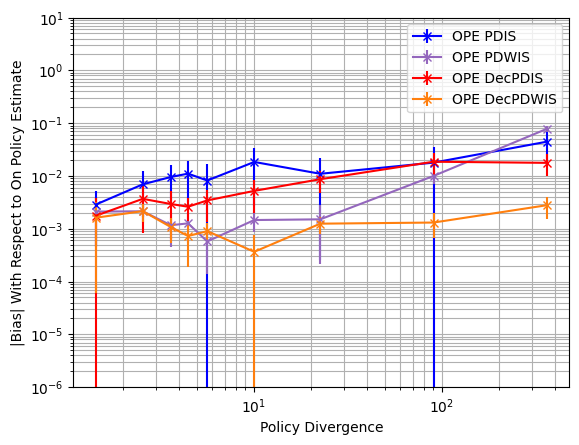

In [ ]:
biases_1000_means = np.array([
    [0.0, 0.0028687199999998777, 0.00286871999999989, 0.0021155469987182074, 0.0017603999999998917, 0.0017603999999998917, 0.0016162055274640999],
    [0.0, 0.006927920000000425, 0.006927920000000425, 0.002136470790469593, 0.0036804000000000186, 0.0036804000000000186, 0.002155639048395442],
    [0.0, 0.009550000000000135, 0.009550000000000135, 0.001164719521386736, 0.0029376000000002496, 0.0029376000000002496, 0.001075563704738399],
    [0.0, 0.011047978867999998, 0.011047978867999998, 0.0012627497064, 0.00261, 0.00261, 0.0007272761597599999],
    [0.0, 0.0081887705, 0.0081887705, 0.0005741990772, 0.0034354999999999998, 0.0034354999999999998, 0.0008998583719999999],
    [0.0, 0.018384189394, 0.018384189394, 0.0014603279260000002, 0.005207333999999999, 0.005207333999999999, 0.00036553917546000006],
    [0.0, 0.010979564, 0.010979564, 0.0015062740000000002, 0.008664, 0.008664, 0.001246712],
    [0.0, 0.017857112, 0.017857112, 0.010000536, 0.018580000000000003, 0.018580000000000003, 0.001308874],
    [0.0, 0.04443, 0.04443, 0.07773367, 0.017681999999999996, 0.017681999999999996, 0.002786128]
])

biases_1000_stds = np.array([
    [0.0, 0.00239515184186726, 0.0023951518418672667, 0.0016722634268590993, 0.002028876102673659, 0.002028876102673659, 0.0015561179942837594],
    [0.0, 0.0052687312865237635, 0.0052687312865237635, 0.000870742203541588, 0.002837949231399276, 0.002837949231399276, 0.0008013676671489098],
    [0.0, 0.0063399302617615965, 0.0063399302617615965, 0.0007084508022082055, 0.002285799518767708, 0.002285799518767708, 0.0005417826536418994],
    [0.0, 0.00780549535784909, 0.00780549535784909, 0.0007165690652600911, 0.0011822446936061925, 0.0011822446936061925, 0.0005362714085054195],
    [0.0, 0.008319634439695111, 0.008319634439695111, 0.0004365075681551171, 0.0020809339249481225, 0.0020809339249481225, 0.00036571800152713504],
    [0.0, 0.015733368266157156, 0.015733368266157156, 0.0005800855447062024, 0.003237021265024992, 0.003237021265024992, 0.0004019603577576966],
    [0.0, 0.010726171679988347, 0.010726171679988347, 0.0012889573908954478, 0.003927853930583468, 0.003927853930583468, 0.0004480314363702618],
    [0.0, 0.017964712199536513, 0.017964712199536513, 0.0030113598749641327, 0.00896372634566674, 0.00896372634566674, 0.0006456066349906885],
    [0.0, 0.02896591237989924, 0.02896591237989924, 0.009086462924035954, 0.007824148260353965, 0.007824148260353965, 0.0012672655446337993]
])


plot_graphs(biases_1000_means, biases_1000_stds, 'bias', '1000-episodes', 10**(-6), 10)

100000 episodes

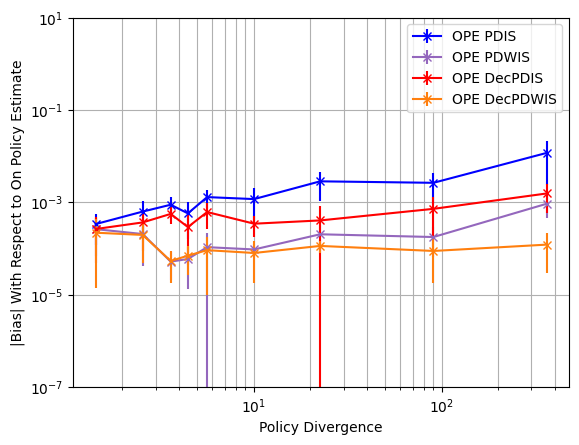

In [ ]:
biases_100000_means = np.array([
    [0.0, 0.00033802239999980953, 0.00033802239999982715, 0.00026275781319170903, 0.0002642319999999478, 0.0002642319999999478, 0.00022014984927623934],
    [0.0, 0.0006299439999999339, 0.0006299439999999339, 0.0002058009931620799, 0.0003670640000000819, 0.0003670640000000819, 0.00019692817662690936],
    [0.0, 0.0008869410000000955, 0.0008869410000000955, 5.208225442605727e-05, 0.000561334000000088, 0.000561334000000088, 5.374638934822297e-05],
    [0.0, 0.0005765612727200001, 0.0005765612727200001, 5.93320922e-05, 0.000291207111104, 0.000291207111104, 7.005312372e-05],
    [0.0, 0.0012978764164, 0.0012978764164, 0.00010703555526999999, 0.0006161879999999999, 0.0006161879999999999, 9.208686200000001e-05],
    [0.0, 0.0011742230158, 0.0011742230158, 9.543857504000001e-05, 0.00034457333339999997, 0.00034457333339999997, 8.009043184399999e-05],
    [0.0, 0.0028474608734000003, 0.0028474608734000003, 0.00020331982428, 0.00040560399999999995, 0.00040560399999999995, 0.00011381409731999999],
    [0.0, 0.0026443457785999998, 0.0026443457785999998, 0.00017731131396000002, 0.0007224099999999999, 0.0007224099999999999, 8.855645488e-05],
    [0.0, 0.01172146, 0.01172146, 0.000929955178, 0.0015534200000000002, 0.0015534200000000002, 0.00012140525058]
])

biases_100000_stds = np.array([
    [0.0, 0.0002179498545572048, 0.00021794985455718985, 0.00019279907253017502, 0.00021462784482910154, 0.00021462784482910154, 0.00020605026141051782],
    [0.0, 0.00042759961683809565, 0.00042759961683809565, 0.00016355859047533668, 0.00028024107747433313, 0.00028024107747433313, 0.00014921037003813231],
    [0.0, 0.0004417185070531001, 0.0004417185070531001, 3.088214400599959e-05, 0.00022186750592198084, 0.00022186750592198084, 3.544311877708429e-05],
    [0.0, 0.00041817867401813596, 0.00041817867401813596, 4.607819915203502e-05, 0.0002482212222899755, 0.0002482212222899755, 4.3502661151112595e-05],
    [0.0, 0.0005701378342482128, 0.0005701378342482128, 0.00010982976914874255, 0.0003556180881064685, 0.0003556180881064685, 8.213099833171263e-05],
    [0.0, 0.0008570978890992275, 0.0008570978890992275, 2.967470308388249e-05, 0.0001644825154429059, 0.0001644825154429059, 6.235768494225286e-05],
    [0.0, 0.001783514708568757, 0.001783514708568757, 0.00011275342886335356, 0.0004255863082431106, 0.0004255863082431106, 3.448867622018987e-05],
    [0.0, 0.0017289953588978191, 0.0017289953588978191, 0.00011253098076002057, 0.0005643454105421608, 0.0005643454105421608, 7.100070333571904e-05],
    [0.0, 0.009390452949373636, 0.009390452949373636, 0.00047833608037870656, 0.0009704858729523064, 0.0009704858729523064, 9.177480971354329e-05]
])

plot_graphs(biases_100000_means, biases_100000_stds, 'bias', '100000-episodes', 10**(-7), 10)

#### Variance

1000 episodes

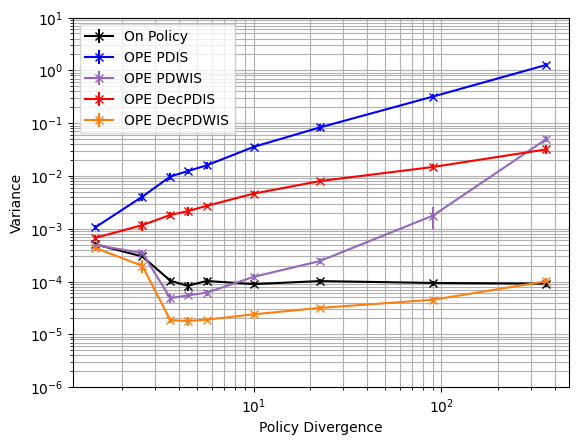

In [ ]:
vars_1000_means = np.array([
    [0.0005081057000000012, 0.0010620967772159995, 0.0010620967772159995, 0.0004889501836428908, 0.0006717380255999994, 0.0006717380255999994, 0.00043252236020078295],
    [0.0002983943800000001, 0.004038952443904, 0.004038952443904, 0.00034824642848560965, 0.0011688578560000002, 0.0011688578560000002, 0.00019795783143897067],
    [0.0001037229400000001, 0.009746409157075997, 0.009746409157075997, 4.862573104306994e-05, 0.0018261310628, 0.0018261310628, 1.856229741042526e-05],
    [8.285363999999999e-05, 0.01230888476, 0.01230888476, 5.4409833e-05, 0.002146700942, 0.002146700942, 1.785868432e-05],
    [0.0001023985, 0.01586728506, 0.01586728506, 6.159123745999999e-05, 0.0027131284380000004, 0.0027131284380000004, 1.8969482960000003e-05],
    [8.930856e-05, 0.03552762828, 0.03552762828, 0.00012278060432, 0.004628243418000001, 0.004628243418000001, 2.392763332e-05],
    [0.00010199426, 0.08278180288, 0.08278180288, 0.0002436205808, 0.007988167386, 0.007988167386, 3.160142554e-05],
    [9.387228e-05, 0.31882388240000004, 0.31882388240000004, 0.0017754811660000002, 0.01477566864, 0.01477566864, 4.51856363e-05],
    [9.1095e-05, 1.265207766, 1.265207766, 0.0496621435, 0.0318158325, 0.0318158325, 0.00010087595208],
])

vars_1000_stds = np.array([
    [6.321946577904625e-05, 0.00010199909293326349, 0.00010199909293326349, 4.674951768883348e-05, 7.356241259287966e-05, 7.356241259287966e-05, 4.959531671766188e-05],
    [2.506070097713934e-05, 0.0007298430412194917, 0.0007298430412194917, 5.385168309719912e-05, 0.0002468295563648766, 0.0002468295563648766, 5.293699963369436e-05],
    [1.2900095708730178e-05, 0.001417731239607418, 0.001417731239607418, 8.674137844242778e-06, 0.0002300757756515347, 0.0002300757756515347, 2.1332033420399294e-06],
    [1.6375280830397997e-05, 0.0012262770775456411, 0.0012262770775456411, 5.060545269086542e-06, 0.00041181725981311637, 0.00041181725981311637, 3.377188412118352e-06],
    [1.54310008472555e-05, 0.0021797792740732465, 0.0021797792740732465, 8.87924738927816e-06, 0.00019782209648966584, 0.00019782209648966584, 1.4467276801581242e-06],
    [9.484886098124743e-06, 0.003459121979830044, 0.003459121979830044, 1.6262602598785193e-05, 0.0005501861127971515, 0.0005501861127971515, 2.424645718368535e-06],
    [1.0568257020455169e-05, 0.011390480841182035, 0.011390480841182035, 3.1301415408366984e-05, 0.0006644639148282009, 0.0006644639148282009, 2.5244712800197957e-06],
    [9.811783607357025e-06, 0.038560907008999286, 0.038560907008999286, 0.0007877278613538821, 0.0018614410268098464, 0.0018614410268098464, 6.557496552096681e-06],
    [1.3391900777260861e-05, 0.10752082039675936, 0.10752082039675936, 0.006401975685766945, 0.006122621914890597, 0.006122621914890597, 1.7727271930254652e-05]
])


plot_graphs(vars_1000_means, vars_1000_stds, 'var', '1000-episodes', 10**(-6), 10**1)

100000 episodes

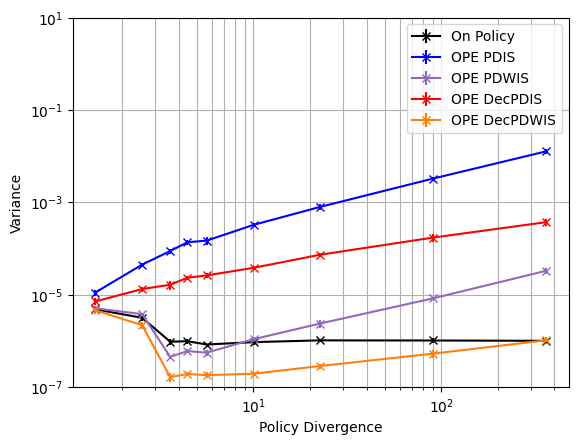

In [ ]:
vars_100000_means = np.array([
    [4.825322651999986e-06, 1.1128997973196777e-05, 1.1128997973196777e-05, 5.081670023997046e-06, 7.145010964799918e-06, 7.145010964799918e-06, 4.6127382449667815e-06],
    [3.1662479439999904e-06, 4.4810289946623825e-05, 4.4810289946623825e-05, 3.8031762173214125e-06, 1.3277787289600015e-05, 1.3277787289600015e-05, 2.1896162406096064e-06],
    [9.617208840000055e-07, 8.819806506090568e-05, 8.819806506090568e-05, 4.531228893892393e-07, 1.6446911870259902e-05, 1.6446911870259902e-05, 1.6457742592739537e-07],
    [9.8519821e-07, 0.0001366029036, 0.0001366029036, 6.021298168e-07, 2.329623184e-05, 2.329623184e-05, 1.92451018e-07],
    [8.36400144e-07, 0.00014808966140000002, 0.00014808966140000002, 5.566434994e-07, 2.6165368640000003e-05, 2.6165368640000003e-05, 1.81815082e-07],
    [9.413382919999999e-07, 0.0003251894306, 0.0003251894306, 1.0889686244e-06, 3.82065505e-05, 3.82065505e-05, 1.9506857219999998e-07],
    [1.028149212e-06, 0.000790954595, 0.000790954595, 2.368562448e-06, 7.311727532e-05, 7.311727532e-05, 2.85597982e-07],
    [1.021503224e-06, 0.0032634309300000005, 0.0032634309300000005, 8.331153844e-06, 0.0001723267418, 0.0001723267418, 5.303728236e-07],
    [1.005493416e-06, 0.012669892499999998, 0.012669892499999998, 3.294631102e-05, 0.00037190967920000003, 0.00037190967920000003, 1.0313950247999999e-06]
])

vars_100000_stds = np.array([
    [4.5187118816901563e-07, 1.6749894073544037e-06, 1.6749894073544037e-06, 7.486108297618735e-07, 1.1919811301515036e-06, 1.1919811301515036e-06, 7.778767184214051e-07],
    [4.411603787821225e-07, 3.283442010869216e-06, 3.283442010869216e-06, 1.7244963192030635e-07, 1.71344335975982e-06, 1.71344335975982e-06, 3.8321253450027744e-07],
    [1.399247236722852e-07, 1.0578354154150833e-05, 1.0578354154150833e-05, 2.6665771151721417e-08, 3.5483707502444255e-06, 3.5483707502444255e-06, 3.554838370511206e-08],
    [1.2846105561510645e-07, 1.69733185996515e-05, 1.69733185996515e-05, 6.504609717211443e-08, 1.8676964516143778e-06, 1.8676964516143778e-06, 1.5455345495055916e-08],
    [3.370274928828426e-08, 2.8531904542070757e-05, 2.8531904542070757e-05, 8.14878497370652e-08, 3.6610998931176617e-06, 3.6610998931176617e-06, 2.5525019439517645e-08],
    [1.2114470928302126e-07, 3.3913601810596364e-05, 3.3913601810596364e-05, 1.0474030408116658e-07, 3.516464145306616e-06, 3.516464145306616e-06, 1.8054072494894266e-08],
    [6.257991004132285e-08, 0.00012408376105879713, 0.00012408376105879713, 4.308998711854391e-07, 8.591958086692426e-06, 8.591958086692426e-06, 3.398531998493241e-08],
    [1.3994712492945434e-07, 0.00026061131960897644, 0.00026061131960897644, 3.9923061650829734e-07, 3.1457595072839034e-05, 3.1457595072839034e-05, 9.821698359323267e-08],
    [1.0349328645398476e-07, 0.0013910093715805481, 0.0013910093715805481, 4.861268523120077e-06, 5.9816600906854574e-05, 5.9816600906854574e-05, 1.6671495969393463e-07]
])

plot_graphs(vars_100000_means, vars_100000_stds, 'var', '100000-episodes', 10**(-7), 10)

#### MSE

1000 episodes

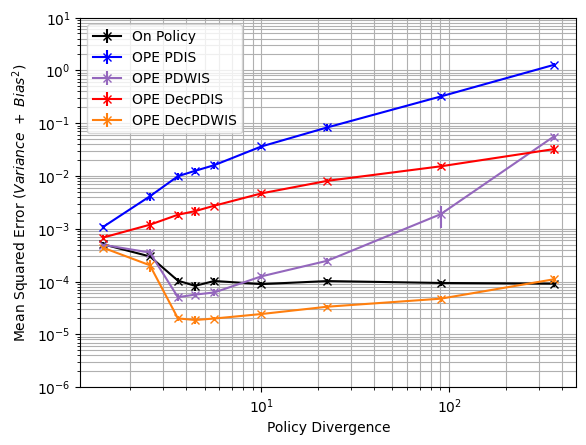

In [ ]:
MSEs_1000_means = np.array([
    [0.0005081057000000012, 0.0010760630839999987, 0.0010760630839999987, 0.0004962221877154869, 0.0006789533719999991, 0.0006789533719999991, 0.00043755598371992215],
    [0.0002983943800000001, 0.0041147080487999995, 0.0041147080487999995, 0.00035356912790916793, 0.0011904571560000003, 0.0011904571560000003, 0.00020324680128388953],
    [0.0001037229400000001, 0.009877806372799999, 0.009877806372799999, 5.048420514571874e-05, 0.0018399854360000001, 0.0018399854360000001, 2.0012663137163106e-05],
    [8.285363999999999e-05, 0.01249186838, 0.01249186838, 5.6517844640000006e-05, 0.002154910742, 0.002154910742, 1.8675204419999997e-05],
    [0.0001023985, 0.01600355736, 0.01600355736, 6.211148354000001e-05, 0.0027292613879999995, 0.0027292613879999995, 1.991298012e-05],
    [8.930856e-05, 0.03611314564, 0.03611314564, 0.0001252496624, 0.004665838045999999, 0.004665838045999999, 2.4222822940000002e-05],
    [0.00010199426, 0.08301740434, 0.08301740434, 0.0002475508558, 0.008078660318, 0.008078660318, 3.3356449460000004e-05],
    [9.387228e-05, 0.31946548960000004, 0.31946548960000004, 0.0018845602320000001, 0.015201233419999998, 0.015201233419999998, 4.731560052e-05],
    [9.1095e-05, 1.268020814, 1.268020814, 0.05578723082, 0.03218970291999999, 0.03218970291999999, 0.00011024442612]
])

MSEs_1000_stds = np.array([
    [6.321946577904625e-05, 9.195270871991071e-05, 9.195270871991071e-05, 4.249384951654431e-05, 6.886635726571032e-05, 6.886635726571032e-05, 4.6954874008671106e-05],
    [2.506070097713934e-05, 0.0007275130857730442, 0.0007275130857730442, 5.4502327925057586e-05, 0.0002465635572369078, 0.0002465635572369078, 5.427572397033761e-05],
    [1.2900095708730178e-05, 0.001374990298597353, 0.001374990298597353, 7.1692813135665435e-06, 0.0002167713178756949, 0.0002167713178756949, 2.038641024471408e-06],
    [1.6375280830397997e-05, 0.0014023294822622528, 0.0014023294822622528, 5.813657454394391e-06, 0.000414956328416948, 0.000414956328416948, 3.2477223926436135e-06],
    [1.54310008472555e-05, 0.0022738216142319545, 0.0022738216142319545, 8.76660804280755e-06, 0.0001844750199966673, 0.0001844750199966673, 9.393568455447425e-07],
    [9.484886098124743e-06, 0.003079294171510418, 0.003079294171510418, 1.457760274357692e-05, 0.0005345485531874452, 0.0005345485531874452, 2.332264231353192e-06],
    [1.0568257020455169e-05, 0.011322162367954898, 0.011322162367954898, 3.189646694432687e-05, 0.0006441219754666495, 0.0006441219754666495, 2.4418377377823747e-06],
    [9.811783607357025e-06, 0.03920422535108237, 0.03920422535108237, 0.0008559723895410127, 0.0016276892273854656, 0.0016276892273854656, 5.894220350252937e-06],
    [1.3391900777260861e-05, 0.10836588984698269, 0.10836588984698269, 0.007769965494190011, 0.006279212168276191, 0.006279212168276191, 1.9152570522457066e-05]
])

plot_graphs(MSEs_1000_means, MSEs_1000_stds, 'MSE','1000-episodes', 10**(-6), 10)

100000 episodes

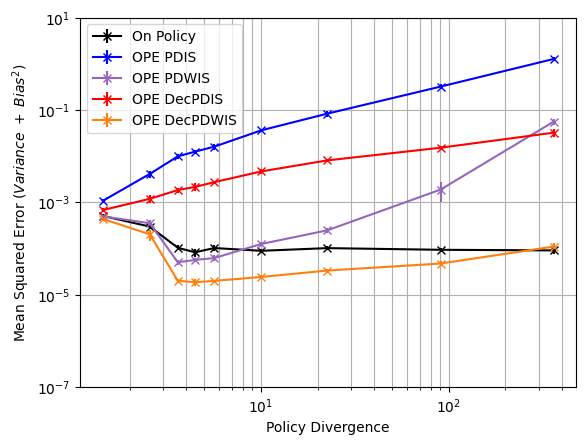

In [ ]:
MSEs_100000_means = np.array([
    [4.825322651999986e-06, 1.1290759255199919e-05, 1.1290759255199919e-05, 5.1878831747588315e-06, 7.260894626399875e-06, 7.260894626399875e-06, 4.703660911330475e-06],
    [3.1662479439999904e-06, 4.5389960822079826e-05, 4.5389960822079826e-05, 3.872281678626212e-06, 1.349105833120005e-05, 1.349105833120005e-05, 2.2506606818861272e-06],
    [9.617208840000055e-07, 8.917984463786005e-05, 8.917984463786005e-05, 4.5678915743374706e-07, 1.681123292000004e-05, 1.681123292000004e-05, 1.6872231496401267e-07],
    [9.8519821e-07, 0.0001371101978, 0.0001371101978, 6.077731755999999e-07, 2.3442646619999997e-05, 2.3442646619999997e-05, 1.9925069e-07],
    [8.36400144e-07, 0.0001500991992, 0.0001500991992, 5.801622986e-07, 2.6671519780000002e-05, 2.6671519780000002e-05, 1.970410162e-07],
    [9.413382919999999e-07, 0.0003273028472, 0.0003273028472, 1.098957734e-06, 3.8352335800000004e-05, 3.8352335800000004e-05, 2.053715308e-07],
    [1.028149212e-06, 0.0008022435476, 0.0008022435476, 2.42261482e-06, 7.346291606e-05, 7.346291606e-05, 2.9974092019999995e-07],
    [1.021503224e-06, 0.0032734129099999997, 0.0032734129099999997, 8.37525664e-06, 0.0001731671038, 0.0001731671038, 5.432562012e-07],
    [1.005493416e-06, 0.01289546574, 0.01289546574, 3.4039932699999995e-05, 0.0003752646358, 0.0003752646358, 1.0545560217999998e-06]
])

MSEs_100000_stds = np.array([
    [4.5187118816901563e-07, 1.7195752854956678e-06, 1.7195752854956678e-06, 7.851592872216118e-07, 1.1651411318374902e-06, 1.1651411318374902e-06, 7.522506174209901e-07],
    [4.411603787821225e-07, 3.3670766908127237e-06, 3.3670766908127237e-06, 2.1422877282069597e-07, 1.7173158426879232e-06, 1.7173158426879232e-06, 3.968561484978098e-07],
    [1.399247236722852e-07, 9.927058801776963e-06, 9.927058801776963e-06, 2.7177037635943682e-08, 3.5590753382978948e-06, 3.5590753382978948e-06, 3.721642638560167e-08],
    [1.2846105561510645e-07, 1.6834443881542313e-05, 1.6834443881542313e-05, 6.657236569855881e-08, 1.8934515437468273e-06, 1.8934515437468273e-06, 1.8324675560612e-08],
    [3.370274928828426e-08, 2.9795861519114652e-05, 2.9795861519114652e-05, 1.1123380629549609e-07, 3.87537181517267e-06, 3.87537181517267e-06, 4.174665094276124e-08],
    [1.2114470928302126e-07, 3.5440643063890765e-05, 3.5440643063890765e-05, 1.0574545981261675e-07, 3.5972212209023492e-06, 3.5972212209023492e-06, 9.585911987858463e-09],
    [6.257991004132285e-08, 0.00011756316538337133, 0.00011756316538337133, 4.0894495796417934e-07, 8.6220636657524e-06, 8.6220636657524e-06, 3.61834429838138e-08],
    [1.3994712492945434e-07, 0.00026049554507722947, 0.00026049554507722947, 4.0327147541503327e-07, 3.107834766906997e-05, 3.107834766906997e-05, 9.338525368134008e-08],
    [1.0349328645398476e-07, 0.00130937784270366, 0.00130937784270366, 4.915101762935475e-06, 5.944802425052917e-05, 5.944802425052917e-05, 1.7166336320211483e-07]
])

plot_graphs(MSEs_1000_means, MSEs_1000_stds, 'MSE','100000-episodes', 10**(-7), 10**1)

#### ESS

100 runs, 1000 episodes

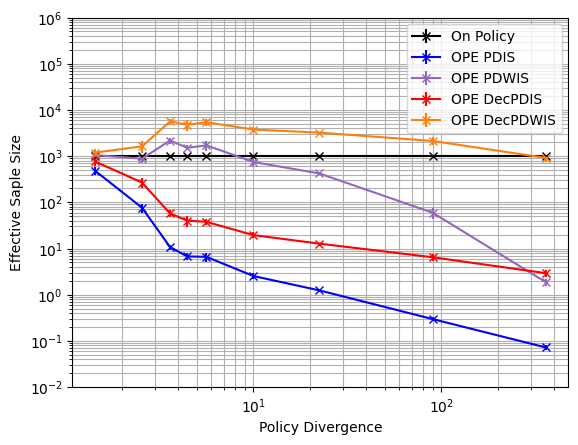

In [ ]:
ESS_1000_means = np.array([
    [1000.0, 484.17550631175146, 484.17550631175146, 1052.320403327778, 767.8552679961202, 767.8552679961202, 1194.0253394512067],
    [1000.0, 76.55875961863579, 76.55875961863579, 878.9088333528504, 268.222139639273, 268.222139639273, 1624.1329661838026],
    [1000.0, 10.762454168054884, 10.762454168054884, 2176.0489074598377, 57.46040498802366, 57.46040498802366, 5633.0191124941375],
    [1000.0, 6.7536642574515415, 6.7536642574515415, 1514.7543823126805, 40.103570721904205, 40.103570721904205, 4799.822212279667],
    [1000.0, 6.60431961586071, 6.60431961586071, 1710.9512528342434, 37.80774540471951, 37.80774540471951, 5418.429566891382],
    [1000.0, 2.5381239585555346, 2.5381239585555346, 746.3356813671778, 19.508067801133983, 19.508067801133983, 3761.359952961559],
    [1000.0, 1.2401198820820523, 1.2401198820820523, 420.8590170410762, 12.751082932805767, 12.751082932805767, 3224.336864584942],
    [1000.0, 0.29658799553945026, 0.29658799553945026, 59.384036435650685, 6.4641785026613, 6.4641785026613, 2127.0069092030517],
    [1000.0, 0.07219374472718962, 0.07219374472718962, 1.863316031310994, 2.9264426854133356, 2.9264426854133356, 915.5151394077832]
])

ESS_1000_stds = np.array([
    [5.084229945850415e-14, 87.45819578272811, 87.45819578272811, 193.31802807131672, 147.94012314717577, 147.94012314717577, 235.27167301932204],
    [8.806144583576081e-14, 16.74449476814894, 16.74449476814894, 164.3553850313498, 67.80924225534956, 67.80924225534956, 476.59078265822603],
    [0.0, 1.4416939121037389, 1.4416939121037389, 347.97212541012203, 9.242945363977176, 9.242945363977176, 819.2603890619581],
    [0.0, 1.1750731149682303, 1.1750731149682303, 187.27188578575505, 10.90471815069842, 10.90471815069842, 1219.2147833198085],
    [0.0, 1.5164889414314728, 1.5164889414314728, 429.23047051803195, 5.730743443372556, 5.730743443372556, 887.4208351773708],
    [0.0, 0.38594676311444764, 0.38594676311444764, 168.0455585145577, 2.7510641099267317, 2.7510641099267317, 494.6564124847311],
    [0.0, 0.1009583677294775, 0.1009583677294775, 34.38249937835336, 0.5178165860383795, 0.5178165860383795, 178.0769645071463],
    [0.0, 0.02890874206039136, 0.02890874206039136, 14.95699083742869, 1.171046963990216, 1.171046963990216, 424.18667363930143],
    [0.0, 0.010026687430404224, 0.010026687430404224, 0.32613351665002754, 0.5048150568049601, 0.5048150568049601, 129.56468234180844]
])


plot_graphs(ESS_1000_means, ESS_1000_stds, 'ESS', '1000-episodes', 10**(-2), 10**6)

100 runs, 100000 episodes

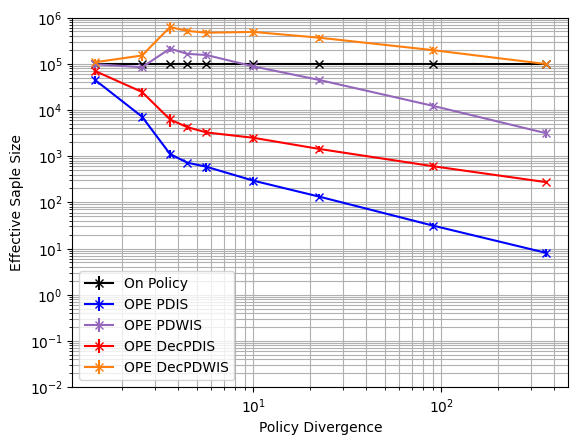

In [ ]:
ESS_100000_means = np.array([
    [100000.0, 44553.51483602528, 44553.51483602528, 97520.56695923042, 69552.44777408153, 69552.44777408153, 107751.5184562304],
    [100000.0, 7165.505441211765, 7165.505441211765, 83874.3630544086, 24509.837948084943, 24509.837948084943, 150654.33934576812],
    [100000.0, 1112.1507991820836, 1112.1507991820836, 212606.40393109634, 6213.822219642947, 6213.822219642947, 621060.8019474361],
    [100000.0, 721.4184037402914, 721.4184037402914, 163509.539273789, 4238.686415318495, 4238.686415318495, 513184.0811153529],
    [100000.0, 588.1873451088017, 588.1873451088017, 154234.34725498786, 3256.1647646611245, 3256.1647646611245, 468651.7919955277],
    [100000.0, 294.13164422321125, 294.13164422321125, 87528.59427762675, 2490.870136671832, 2490.870136671832, 487931.81136606075],
    [100000.0, 132.35645773300294, 132.35645773300294, 44408.179217528916, 1427.2600510096188, 1427.2600510096188, 365518.6738795064],
    [100000.0, 31.4195566051806, 31.4195566051806, 12276.710984790221, 605.6406892781972, 605.6406892781972, 197015.32942407375],
    [100000.0, 8.072064767119175, 8.072064767119175, 3138.917307413006, 273.51104528126126, 273.51104528126126, 98641.37625501966]
])

ESS_100000_stds = np.array([
    [9.203439287865707e-12, 8485.121677136523, 8485.121677136523, 18608.84241304122, 12893.968959704896, 12893.968959704896, 19922.177730307492],
    [6.507814330688531e-12, 1448.633259526067, 1448.633259526067, 14844.238378531752, 5723.871278667344, 5723.871278667344, 38853.71264554653],
    [0.0, 223.34762196417023, 223.34762196417023, 29996.310838219822, 1839.1901098220108, 1839.1901098220108, 184053.97128382747],
    [0.0, 25.347236134324845, 25.347236134324845, 9561.213307624472, 530.6250556488146, 530.6250556488146, 64922.88386877304],
    [0.0, 126.5263912191601, 126.5263912191601, 28011.375873782785, 438.631477870729, 438.631477870729, 63315.9120213305],
    [0.0, 54.16209084517528, 54.16209084517528, 15043.596403316864, 427.4040683986419, 427.4040683986419, 84007.65592352427],
    [0.0, 15.908339729468729, 15.908339729468729, 5632.629676656245, 209.15718592369842, 209.15718592369842, 54017.98739632389],
    [0.0, 4.676391435079848, 4.676391435079848, 1757.89573126814, 105.14250497810713, 105.14250497810713, 35016.20882252855],
    [0.0, 1.4741916405517799, 1.4741916405517799, 674.7108788400487, 20.57947495148109, 20.57947495148109, 7472.781081179856]
])

plot_graphs(ESS_100000_means, ESS_100000_stds, 'ESS', '100000-episodes', 10**(-2), 10**6)

## Varying the Action Space Interaction Reward $\beta$

We will rewrite the reward information stored in the local MDP config based on how we vary $\beta$.

In [ ]:
# Set up global information
MAIN_REWARD_PATH = 'configs/1-step-MDP/R.csv'

HORIZONTAL_REWARD_PATH = 'configs/1-step-MDP/factorisation/horizontal/R.csv'

VERTICAL_REWARD_PATH = 'configs/1-step-MDP/factorisation/vertical/R.csv'

### $\beta = -4$

**Note**: Restart the runtime before running all code in this section

**Rewrite Rewards of the MDP Based on $\beta$**

In [ ]:
import pandas as pd

beta = -4
alpha = 1

# Modify and write everything
main_data = [['state', 'up,right', 'terminal', (1+alpha+beta)],
             ['state', 'up,left', 'terminal', alpha],
             ['state', 'down,right', 'terminal', 1],
             ['state', 'down,left', 'terminal', 0]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'next_state', 'reward'])
main_reward_df.to_csv(MAIN_REWARD_PATH)

horizontal_data = [['state', 'right', 'terminal', 1],
                   ['state', 'left', 'terminal', 0]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'next_state', 'reward'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH)

vertical_data = [['state', 'up', 'terminal', 1],
                 ['state', 'down', 'terminal', 0]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'next_state', 'reward'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH)

**Generate Data Set**

Delete all exising data set files from cloned repository (so there is no confusion) with pre-existing files.

In [ ]:
import os, shutil
folder = './datasets'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

/content/Factored-Action-Spaces-Empirical-Simulation/load_discrete_MDP.py:217: UserWarning: Theorem 1 is not satisfied in rewards of (state,up,right,terminal). Main MDP reward: -2.0, factored reward sum: 2.0
  warnings.warn(f'Theorem 1 is not satisfied in rewards of ({state},{action},{next_state}). Main MDP reward: {main_MDP_reward}, factored reward sum: {factored_reward_sum}')
Policy divergence: 1.44
Start state: state, start state no: 0


**Run Estimates on Collected Data Sets**

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 1.44
VERSION_NUMBER =1

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means = np.zeros((9, 7))
biases = np.zeros((9, 7))
vars = np.zeros((9, 7))
MSEs = np.zeros((9, 7))

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 1000)

Mean on policy Q estimate: -0.23945. Variance of on policy Q estimate: 0.0011243475
Mean off policy IS estimate: -0.24502079999999996. Bias1: 0.005570799999999977. Bias2: 0.005570799999999959. Variance: 0.0021867882393599995. MSE: 0.0022178220519999993
Mean off policy PDIS estimate: -0.24502079999999996. Bias1: 0.005570799999999977. Bias2: 0.005570799999999959 Variance: 0.0021867882393599995. MSE: 0.0022178220519999993
Mean off policy PDWIS estimate: -0.24467586110850462. Bias1: 0.005225861108504689. Bias2: 0.00522586110850462. Variance: 0.0020363625389289795. MSE: 0.0020636721632543613
Mean off policy DecIS estimate: 1.1999039999999999. Bias1: 1.4393539999999998. Bias2: 1.4393539999999998. Variance: 0.0007694115839999987. MSE: 2.0725093488999993
Mean off policy DecPDIS estimate: 1.1999039999999999. Bias1: 1.4393539999999998. Bias2: 1.4393539999999998. Variance: 0.0007694115839999987. MSE: 2.0725093488999993
Mean off policy DecPDWIS estimate: 1.1997269477489825. Bias1: 1.43917694774898

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 100000)

Mean on policy Q estimate: -0.2400297. Variance of on policy Q estimate: 1.907513691000001e-05
Mean off policy IS estimate: -0.23955254399999998. Bias1: 0.0004771560000000433. Bias2: 0.0004771560000000341. Variance: 2.618412115046396e-05. MSE: 2.6411798998800002e-05
Mean off policy PDIS estimate: -0.23955254399999998. Bias1: 0.0004771560000000433. Bias2: 0.0004771560000000341 Variance: 2.618412115046396e-05. MSE: 2.6411798998800002e-05
Mean off policy PDWIS estimate: -0.23957069361486572. Bias1: 0.00045900638513432854. Bias2: 0.00045900638513429737. Variance: 2.450484146363457e-05. MSE: 2.4715528325228655e-05
Mean off policy DecIS estimate: 1.1997439199999997. Bias1: 1.4397736199999998. Bias2: 1.4397736199999998. Variance: 8.36349759359995e-06. MSE: 2.0729564403454974
Mean off policy DecPDIS estimate: 1.1997439199999997. Bias1: 1.4397736199999998. Bias2: 1.4397736199999998. Variance: 8.36349759359995e-06. MSE: 2.0729564403454974
Mean off policy DecPDWIS estimate: 1.1997930079352437. Bi

Print out values to copy-paste

In [ ]:
print(list(biases[0,:]))
print()
print(list(vars[0,:]))
print()
print(list(MSEs[0,:]))
print()
print(list(biases[1,:]))
print()
print(list(vars[1,:]))
print()
print(list(MSEs[1,:]))

[0.0, 0.005570799999999977, 0.005570799999999977, 0.005225861108504689, 1.4393539999999998, 1.4393539999999998, 1.4391769477489822]

[0.0011243475, 0.0021867882393599995, 0.0021867882393599995, 0.0020363625389289795, 0.0007694115839999987, 0.0007694115839999987, 0.0004918599034571034]

[0.0011243475, 0.0022178220519999993, 0.0022178220519999993, 0.0020636721632543613, 2.0725093488999993, 2.0725093488999993, 2.071722146835534]

[0.0, 0.0004771560000000433, 0.0004771560000000433, 0.00045900638513432854, 1.4397736199999998, 1.4397736199999998, 1.4398227079352437]

[1.907513691000001e-05, 2.618412115046396e-05, 2.618412115046396e-05, 2.450484146363457e-05, 8.36349759359995e-06, 8.36349759359995e-06, 5.3528376884011406e-06]

[1.907513691000001e-05, 2.6411798998800002e-05, 2.6411798998800002e-05, 2.4715528325228655e-05, 2.0729564403454974, 2.0729564403454974, 2.0730947831236666]


Hold values here and print the means and stds out

In [ ]:
biases1000 = np.array([
    [0.0, 0.012884000000000055, 0.012884000000000055, 0.013050419770354944, 1.4425400000000002, 1.4425400000000002, 1.4429239326594745],
    [0.0, 0.0035651999999998926, 0.0035651999999998926, 0.0028828253958860088, 1.443606, 1.443606, 1.4426111980385978],
    [0.0, 0.005173199999999908, 0.005173199999999908, 0.004665190072867463, 1.438986, 1.438986, 1.4381419193799836],
    [0.0, 0.007860800000000008, 0.007860800000000008, 0.007992791198848301, 1.436576, 1.436576, 1.4367014728041798],
    [0.0, 0.005570799999999977, 0.005570799999999977, 0.005225861108504689, 1.4393539999999998, 1.4393539999999998, 1.4391769477489822]
])

vars1000 = np.array([
    [0.0020461284, 0.0029912071679999985, 0.0029912071679999985, 0.0027996608622776033, 0.0009205775999999998, 0.0009205775999999998, 0.0005919069864822493],
    [0.0017205211000000003, 0.0026020759449599997, 0.0026020759449599997, 0.0024151650357429892, 0.0008890295039999999, 0.0008890295039999999, 0.0005647760446468934],
    [0.0015800259, 0.0019742271897599997, 0.0019742271897599997, 0.0018347339510208288, 0.0007381686239999994, 0.0007381686239999994, 0.00047110898516256527],
    [0.0017057784000000002, 0.0026962302873599986, 0.0026962302873599986, 0.0025691268405349816, 0.0006395207039999988, 0.0006395207039999988, 0.00041029956867622854],
    [0.0011243475, 0.0021867882393599995, 0.0021867882393599995, 0.0020363625389289795, 0.0007694115839999987, 0.0007694115839999987, 0.0004918599034571034]
])

MSEs1000 = np.array([
    [0.0020461284, 0.003157204624, 0.003157204624, 0.0029699743184600745, 2.0818422292000007, 2.0818422292000007, 2.0826213824279662],
    [0.0017205211000000003, 0.002614786595999999, 0.002614786595999999, 0.0024234757180061546, 2.08488731274, 2.08488731274, 2.0816918447510058],
    [0.0015800259, 0.0020009891879999987, 0.0020009891879999987, 0.00185649794943681, 2.07141887682, 2.07141887682, 2.068723289263106],
    [0.0017057784000000002, 0.0027580224639999987, 0.0027580224639999987, 0.0026330115516833685, 2.06439012448, 2.06439012448, 2.0645214215263756],
    [0.0011243475, 0.0022178220519999993, 0.0022178220519999993, 0.0020636721632543613, 2.0725093488999993, 2.0725093488999993, 2.071722146835534]
])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.007010799999999968, 0.007010799999999968, 0.006763417509292281, 1.4402124, 1.4402124, 1.4399110941262436]
[0.0, 0.0032415894669128543, 0.0032415894669128543, 0.0035457972392786176, 0.0025455276545345135, 0.0025455276545345135, 0.002463265165666426]
Var:
[0.0016353602600000002, 0.002490105765887999, 0.002490105765887999, 0.0023310098457010766, 0.0007913416031999993, 0.0007913416031999993, 0.0005059902976850079]
[0.00029837475772224835, 0.00036448854076884344, 0.00036448854076884344, 0.000351147368951175, 0.00010256972820926573, 0.00010256972820926573, 6.543780418428603e-05]
MSE:
[0.0016353602600000002, 0.002549764984799999, 0.002549764984799999, 0.0023893263401681534, 2.075009578428, 2.075009578428, 2.0738560169607974]
[0.00029837475772224835, 0.0004069208494600762, 0.0004069208494600762, 0.00039690237437515683, 0.007431982771705711, 0.007431982771705711, 0.007159117210736373]
ESS:
[1000.0, 658.4785470407967, 658.4785470407967, 704.0986572223934, 2085.3978441654085, 2085.3

In [ ]:
biases100000 = np.array([
    [0.0, 0.0004319720000000259, 0.0004319720000000259, 0.0004189860615612866, 1.4397385399999998, 1.4397385399999998, 1.4397723551613153],
    [0.0, 0.0012687079999999572, 0.0012687079999999572, 0.0012379708381169024, 1.43950114, 1.43950114, 1.4394317585605991],
    [0.0, 0.0005265080000000388, 0.0005265080000000388, 0.0004902682681642018, 1.43988326, 1.43988326, 1.4399927239847892],
    [0.0, 0.00040903600000007155, 0.00040903600000007155, 0.0004132026365029567, 1.4398610199999997, 1.4398610199999997, 1.439842201846172],
    [0.0, 0.0004771560000000433, 0.0004771560000000433, 0.00045900638513432854, 1.4397736199999998, 1.4397736199999998, 1.4398227079352437]
])

vars100000 = np.array([
    [1.994352171e-05, 2.6956947926016033e-05, 2.6956947926016033e-05, 2.5141158974454086e-05, 8.055697694399877e-06, 8.055697694399877e-06, 5.15862179139879e-06],
    [1.9482372749999992e-05, 2.4908558478335967e-05, 2.4908558478335967e-05, 2.3112024766535765e-05, 1.0045020830399886e-05, 1.0045020830399886e-05, 6.426530463386184e-06],
    [2.2535604910000007e-05, 2.5683097153535994e-05, 2.5683097153535994e-05, 2.3876058340736786e-05, 9.104538758399873e-06, 9.104538758399873e-06, 5.827243658606794e-06],
    [1.3770651309999996e-05, 2.627930989670394e-05, 2.627930989670394e-05, 2.4672890888019914e-05, 6.092495481599991e-06, 6.092495481599991e-06, 3.898978364019528e-06],
    [1.907513691000001e-05, 2.618412115046396e-05, 2.618412115046396e-05, 2.450484146363457e-05, 8.36349759359995e-06, 8.36349759359995e-06, 5.3528376884011406e-06]
])

MSEs100000 = np.array([
    [1.994352171e-05, 2.7143547734800056e-05, 2.7143547734800056e-05, 2.5316708294236725e-05, 2.072855119259025, 2.072855119259025, 2.072949593308552],
    [1.9482372749999992e-05, 2.651817846759986e-05, 2.651817846759986e-05, 2.464459656256363e-05, 2.0721735770821295, 2.0721735770821295, 2.0719702140833225],
    [2.2535604910000007e-05, 2.5960307827600035e-05, 2.5960307827600035e-05, 2.411642131550551e-05, 2.0732729069669857, 2.0732729069669857, 2.0735848723727917],
    [1.3770651309999996e-05, 2.6446620346e-05, 2.6446620346e-05, 2.484362730683291e-05, 2.0732058494109213, 2.0732058494109213, 2.073149465195597],
    [1.907513691000001e-05, 2.6411798998800002e-05, 2.6411798998800002e-05, 2.4715528325228655e-05, 2.0729564403454974, 2.0729564403454974, 2.0730947831236666]
])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.0006226760000000273, 0.0006226760000000273, 0.0006038868378959352, 1.4397515159999998, 1.4397515159999998, 1.439772349497624]
[0.0, 0.00032551244672481705, 0.00032551244672481705, 0.000318280004419552, 0.00013615631628386036, 0.00013615631628386036, 0.00018546289324069434]
Var:
[1.8961457517999997e-05, 2.600240692101118e-05, 2.600240692101118e-05, 2.4261394886676225e-05, 8.332250071679916e-06, 8.332250071679916e-06, 5.332842393162487e-06]
[2.862436878921719e-06, 6.810737100368571e-07, 6.810737100368571e-07, 7.031523265703426e-07, 1.3133142606666002e-06, 1.3133142606666002e-06, 8.399172447572717e-07]
MSE:
[1.8961457517999997e-05, 2.6496090674959994e-05, 2.6496090674959994e-05, 2.4727376360873485e-05, 2.072892778612912, 2.072892778612912, 2.072949785616786]
[0.00029837475772224835, 0.0004069208494600762, 0.0004069208494600762, 0.00039690237437515683, 0.007431982771705711, 0.007431982771705711, 0.007159117210736373]
ESS:
[100000.0, 73038.89204999879, 73038.89204999879, 78332

### $\beta = -2$

**Note**: Restart the runtime before running all code in this section

**Rewrite Rewards of the MDP Based on $\beta$**

In [ ]:
import pandas as pd

beta = -2
alpha = 1

# Modify and write everything
main_data = [['state', 'up,right', 'terminal', (1+alpha+beta)],
             ['state', 'up,left', 'terminal', alpha],
             ['state', 'down,right', 'terminal', 1],
             ['state', 'down,left', 'terminal', 0]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'next_state', 'reward'])
main_reward_df.to_csv(MAIN_REWARD_PATH)

horizontal_data = [['state', 'right', 'terminal', 1],
                   ['state', 'left', 'terminal', 0]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'next_state', 'reward'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH)

vertical_data = [['state', 'up', 'terminal', 1],
                 ['state', 'down', 'terminal', 0]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'next_state', 'reward'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH)

**Generate Data Set**

Delete all exising data set files from cloned repository (so there is no confusion) with pre-existing files.

In [ ]:
import os, shutil
folder = './datasets'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

/content/Factored-Action-Spaces-Empirical-Simulation/load_discrete_MDP.py:217: UserWarning: Theorem 1 is not satisfied in rewards of (state,up,right,terminal). Main MDP reward: 0.0, factored reward sum: 2.0
  warnings.warn(f'Theorem 1 is not satisfied in rewards of ({state},{action},{next_state}). Main MDP reward: {main_MDP_reward}, factored reward sum: {factored_reward_sum}')
Policy divergence: 1.44
Start state: state, start state no: 0


**Run Estimates on Collected Data Sets**

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 1.44
VERSION_NUMBER =1

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means = np.zeros((9, 7))
biases = np.zeros((9, 7))
vars = np.zeros((9, 7))
MSEs = np.zeros((9, 7))

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 1000)

Mean on policy Q estimate: 0.47991999999999996. Variance of on policy Q estimate: 0.00022853359999999994
Mean off policy IS estimate: 0.4796832. Bias1: 0.00023679999999979772. Bias2: 0.00023679999999998147. Variance: 0.00022210661376000036. MSE: 0.00022216268800000026
Mean off policy PDIS estimate: 0.4796832. Bias1: 0.00023679999999979772. Bias2: 0.00023679999999998147 Variance: 0.00022210661376000036. MSE: 0.00022216268800000026
Mean off policy PDWIS estimate: 0.47879624519326947. Bias1: 0.0011237548067304659. Bias2: 0.0011237548067304926. Variance: 0.0002828854137925846. MSE: 0.0002841482386582344
Mean off policy DecIS estimate: 1.2060359999999999. Bias1: 0.726116. Bias2: 0.726116. Variance: 0.0008526083040000007. MSE: 0.5280970537599999
Mean off policy DecPDIS estimate: 1.2060359999999999. Bias1: 0.726116. Bias2: 0.726116. Variance: 0.0008526083040000007. MSE: 0.5280970537599999
Mean off policy DecPDWIS estimate: 1.2046944186640172. Bias1: 0.7247744186640172. Bias2: 0.72477441866401

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 100000)

Mean on policy Q estimate: 0.47997740000000005. Variance of on policy Q estimate: 2.216149239999996e-06
Mean off policy IS estimate: 0.4797960000000001. Bias1: 0.00018140000000004715. Bias2: 0.00018139999999994272. Variance: 1.5019580159999775e-06. MSE: 1.5348639759999946e-06
Mean off policy PDIS estimate: 0.4797960000000001. Bias1: 0.00018140000000004715. Bias2: 0.00018139999999994272 Variance: 1.5019580159999775e-06. MSE: 1.5348639759999946e-06
Mean off policy PDWIS estimate: 0.4797680880485726. Bias1: 0.0002093119514275189. Bias2: 0.00020931195142742665. Variance: 1.9370634098810233e-06. MSE: 1.9808749028914193e-06
Mean off policy DecIS estimate: 1.20012804. Bias1: 0.7201506399999996. Bias2: 0.72015064. Variance: 9.83125455839995e-06. MSE: 0.5186267755469676
Mean off policy DecPDIS estimate: 1.20012804. Bias1: 0.7201506399999996. Bias2: 0.72015064. Variance: 9.83125455839995e-06. MSE: 0.5186267755469676
Mean off policy DecPDWIS estimate: 1.2001412166782695. Bias1: 0.7201638166782692

Print out values to copy-paste

In [ ]:
print(list(biases[0,:]))
print()
print(list(vars[0,:]))
print()
print(list(MSEs[0,:]))
print()
print(list(biases[1,:]))
print()
print(list(vars[1,:]))
print()
print(list(MSEs[1,:]))

[0.0, 0.001998799999999988, 0.001998799999999988, 0.002618961894918528, 0.718274, 0.718274, 0.7187550705371615]

[0.0002553570999999999, 0.00024957075456, 0.00024957075456, 0.00028292844715052955, 0.0007771184639999988, 0.0007771184639999988, 0.0004983612206873703]

[0.0002553570999999999, 0.00025356595599999995, 0.00025356595599999995, 0.0002897874085575648, 0.51669465754, 0.51669465754, 0.5171072126435674]

[0.0, 9.564399999992681e-05, 9.564399999992681e-05, 0.00011367667714225435, 0.7199885, 0.7199885, 0.7199612423528785]

[2.3279547499999987e-06, 2.2951996784640127e-06, 2.2951996784640127e-06, 2.5524709032992853e-06, 7.05574512000006e-06, 7.05574512000006e-06, 4.515864367691595e-06]

[2.3279547499999987e-06, 2.3043474531999986e-06, 2.3043474531999986e-06, 2.5653932902253896e-06, 0.5183904958773701, 0.5183904958773701, 0.5183487063546679]


Hold values here and print the means and stds out

In [ ]:
biases1000 = np.array([
    [0.0, 0.0007291999999999839, 0.0007291999999999839, 0.0014865327277398508, 0.7161859999999999, 0.7161859999999999, 0.7168521863581689],
    [0.0, 9.199999998825125e-06, 9.199999998825125e-06, 0.0006377839650632786, 0.7159819999999999, 0.7159819999999999, 0.7165213710419854],
    [0.0, 0.003188000000000008, 0.003188000000000008, 0.0034430916274413334, 0.7204519999999999, 0.7204519999999999, 0.7203747447562259],
    [0.0, 0.0003776000000000303, 0.0003776000000000303, 0.0006712096163478448, 0.7225839999999999, 0.7225839999999999, 0.7220173442749894],
    [0.0, 0.001998799999999988, 0.001998799999999988, 0.002618961894918528, 0.718274, 0.718274, 0.7187550705371615]
])

vars1000 = np.array([
    [0.00021134909999999992, 0.00019585575936000005, 0.00019585575936000005, 0.00023795745749437844, 0.0006101641439999998, 0.0006101641439999998, 0.0003918519022357754],
    [0.00022756989999999998, 0.00025429671936000027, 0.00025429671936000027, 0.00028302617695389145, 0.0005486348160000006, 0.0005486348160000006, 0.00035256634487563403],
    [0.00024141959999999995, 0.00022441881600000047, 0.00022441881600000047, 0.00028529364314460305, 0.0006571100160000008, 0.0006571100160000008, 0.00042104927712729485],
    [0.00023473039999999994, 0.00022001946624000018, 0.00022001946624000018, 0.0002569964839020693, 0.0006618176639999981, 0.0006618176639999981, 0.00042173977846733256],
    [0.0002553570999999999, 0.00024957075456, 0.00024957075456, 0.00028292844715052955, 0.0007771184639999988, 0.0007771184639999988, 0.0004983612206873703]
])

MSEs1000 = np.array([
    [0.00021134909999999992, 0.00019638749200000003, 0.00019638749200000003, 0.00024016723704502012, 0.5135325507399998, 0.5135325507399998, 0.5142689089887228],
    [0.00022756989999999998, 0.00025429680400000025, 0.00025429680400000025, 0.0002834329453399833, 0.5131788591399998, 0.5131788591399998, 0.5137554415047623],
    [0.00024141959999999995, 0.00023458216000000052, 0.00023458216000000052, 0.00029714852309955966, 0.5197081943199998, 0.5197081943199998, 0.5193608221597248],
    [0.00023473039999999994, 0.0002201620480000002, 0.0002201620480000002, 0.0002574470062511471, 0.5227894547199998, 0.5227894547199998, 0.5217307852123759],
    [0.0002553570999999999, 0.00025356595599999995, 0.00025356595599999995, 0.0002897874085575648, 0.51669465754, 0.51669465754, 0.5171072126435674]
])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.001260559999999767, 0.001260559999999767, 0.001771515966302167, 0.7186956, 0.7186956, 0.7189041433937062]
[0.0, 0.0011737024249785732, 0.0011737024249785732, 0.0011035911882110777, 0.002531563121867591, 0.002531563121867591, 0.0020863864726862824]
Var:
[0.0002340852199999999, 0.00022883230310400017, 0.00022883230310400017, 0.00026924044172909435, 0.0006509690207999997, 0.0006509690207999997, 0.0004171137046786814]
[1.4601936948966718e-05, 2.1274948946403166e-05, 2.1274948946403166e-05, 1.8781122808244417e-05, 7.510847401419953e-05, 7.510847401419953e-05, 4.783841232103539e-05]
MSE:
[0.0002340852199999999, 0.0002317988920000002, 0.0002317988920000002, 0.000273596624058655, 0.5171807432919999, 0.5171807432919999, 0.5172446341018306]
[1.4601936948966718e-05, 2.180408717896718e-05, 2.180408717896718e-05, 2.1409907701382422e-05, 0.003671684016968516, 0.003671684016968516, 0.0030216582622271874]
ESS:
[1000.0, 1027.9613647227961, 1027.9613647227961, 870.8729278948844, 362.367984

In [ ]:
biases100000 = np.array([
    [0.0, 0.00023206400000000995, 0.00023206400000000995, 0.00024874913291820036, 0.7201055199999998, 0.7201055199999998, 0.7200974480332735],
    [0.0, 0.0005619440000000089, 0.0005619440000000089, 0.0005531275211499853, 0.7196009199999999, 0.7196009199999999, 0.7196234470091158],
    [0.0, 0.00026124400000008993, 0.00026124400000008993, 0.00024005249230324527, 0.7204815399999999, 0.7204815399999999, 0.7204581360307333],
    [0.0, 3.835200000004365e-05, 3.835200000004365e-05, 6.45203057581574e-05, 0.7207286399999999, 0.7207286399999999, 0.7205997916036204],
    [0.0, 9.564399999992681e-05, 9.564399999992681e-05, 0.00011367667714225435, 0.7199885, 0.7199885, 0.7199612423528785]
])

vars100000 = np.array([
    [2.5842530400000003e-06, 2.3240995799040075e-06, 2.3240995799040075e-06, 2.7712466757012995e-06, 6.0809708736000115e-06, 6.0809708736000115e-06, 3.892757174538256e-06],
    [2.253699239999996e-06, 1.7851254128640085e-06, 1.7851254128640085e-06, 2.2848080366493935e-06, 7.621263417599969e-06, 7.621263417599969e-06, 4.878520189381192e-06],
    [3.093377710000005e-06, 2.453039115263999e-06, 2.453039115263999e-06, 2.9340373263321037e-06, 6.12567145439999e-06, 6.12567145439999e-06, 3.919568983451494e-06],
    [2.577904959999993e-06, 2.5480530984959815e-06, 2.5480530984959815e-06, 3.0735606823687757e-06, 7.768737734399995e-06, 7.768737734399995e-06, 4.971573937610291e-06],
    [2.3279547499999987e-06, 2.2951996784640127e-06, 2.2951996784640127e-06, 2.5524709032992853e-06, 7.05574512000006e-06, 7.05574512000006e-06, 4.515864367691595e-06]
])

MSEs100000 = np.array([
    [2.5842530400000003e-06, 2.377953280000012e-06, 2.377953280000012e-06, 2.833122806828856e-06, 0.5185580409053437, 0.5185580409053437, 0.5185442274212074],
    [2.253699239999996e-06, 2.1009064720000185e-06, 2.1009064720000185e-06, 2.590758091302921e-06, 0.5178331053282638, 0.5178331053282638, 0.5178627840054711],
    [3.093377710000005e-06, 2.521287542800046e-06, 2.521287542800046e-06, 2.9916625253931033e-06, 0.5190997751522258, 0.5190997751522258, 0.519063845341862],
    [2.577904959999993e-06, 2.549523974399985e-06, 2.549523974399985e-06, 3.077723552223902e-06, 0.5194575412539839, 0.5194575412539839, 0.5192690312331188],
    [2.3279547499999987e-06, 2.3043474531999986e-06, 2.3043474531999986e-06, 2.5653932902253896e-06, 0.5183904958773701, 0.5183904958773701, 0.5183487063546679]
])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.0002378496000000158, 0.0002378496000000158, 0.00024402522585436856, 0.7201810239999998, 0.7201810239999998, 0.7201480130059243]
[0.0, 0.00018201081083672654, 0.00018201081083672654, 0.00017017349227005724, 0.0003922958437506062, 0.0003922958437506062, 0.00035011134519147497]
Var:
[2.5674379399999985e-06, 2.2811033769984016e-06, 2.2811033769984016e-06, 2.7232247248701717e-06, 6.930477720000005e-06, 6.930477720000005e-06, 4.435656930534566e-06]
[2.9420711002068506e-07, 2.6414600961846023e-07, 2.6414600961846023e-07, 2.7958877084202626e-07, 7.162306416906244e-07, 7.162306416906244e-07, 4.5844411909628163e-07]
MSE:
[2.5674379399999985e-06, 2.370803744480012e-06, 2.370803744480012e-06, 2.8117320531948343e-06, 0.5186677917034375, 0.5186677917034375, 0.5186177188712655]
[2.9420711002068506e-07, 1.6241821716818484e-07, 1.6241821716818484e-07, 2.0644432406718232e-07, 0.0005649696647347751, 0.0005649696647347751, 0.0005041690191552114]
ESS:
[100000.0, 113229.01556116878, 113229.015

### $\beta = -1$

**Note**: Restart the runtime before running all code in this section

**Rewrite Rewards of the MDP Based on $\beta$**

In [ ]:
import pandas as pd

beta = -1
alpha = 1

# Modify and write everything
main_data = [['state', 'up,right', 'terminal', (1+alpha+beta)],
             ['state', 'up,left', 'terminal', alpha],
             ['state', 'down,right', 'terminal', 1],
             ['state', 'down,left', 'terminal', 0]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'next_state', 'reward'])
main_reward_df.to_csv(MAIN_REWARD_PATH)

horizontal_data = [['state', 'right', 'terminal', 1],
                   ['state', 'left', 'terminal', 0]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'next_state', 'reward'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH)

vertical_data = [['state', 'up', 'terminal', 1],
                 ['state', 'down', 'terminal', 0]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'next_state', 'reward'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH)

**Generate Data Set**

Delete all exising data set files from cloned repository (so there is no confusion) with pre-existing files.

In [ ]:
import os, shutil
folder = './datasets'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

/content/Factored-Action-Spaces-Empirical-Simulation/load_discrete_MDP.py:217: UserWarning: Theorem 1 is not satisfied in rewards of (state,up,right,terminal). Main MDP reward: 1.0, factored reward sum: 2.0
  warnings.warn(f'Theorem 1 is not satisfied in rewards of ({state},{action},{next_state}). Main MDP reward: {main_MDP_reward}, factored reward sum: {factored_reward_sum}')
Policy divergence: 1.44
Start state: state, start state no: 0


**Run Estimates on Collected Data Sets**

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 1.44
VERSION_NUMBER =1

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means = np.zeros((9, 7))
biases = np.zeros((9, 7))
vars = np.zeros((9, 7))
MSEs = np.zeros((9, 7))

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 1000)

Mean on policy Q estimate: 0.83824. Variance of on policy Q estimate: 0.00012936240000000016
Mean off policy IS estimate: 0.8409792. Bias1: 0.0027392000000000505. Bias2: 0.0027392000000000527. Variance: 0.0002904879513600003. MSE: 0.0002979911680000006
Mean off policy PDIS estimate: 0.8409792. Bias1: 0.0027392000000000505. Bias2: 0.0027392000000000527 Variance: 0.0002904879513600003. MSE: 0.0002979911680000006
Mean off policy PDWIS estimate: 0.8406885702802006. Bias1: 0.002448570280200706. Bias2: 0.0024485702802006237. Variance: 0.00010667384125732003. MSE: 0.0001126693376744022
Mean off policy DecIS estimate: 1.2010919999999998. Bias1: 0.3628519999999999. Bias2: 0.36285199999999984. Variance: 0.000732242735999999. MSE: 0.13239381663999994
Mean off policy DecPDIS estimate: 1.2010919999999998. Bias1: 0.3628519999999999. Bias2: 0.36285199999999984. Variance: 0.000732242735999999. MSE: 0.13239381663999994
Mean off policy DecPDWIS estimate: 1.2004692934711978. Bias1: 0.3622292934711976. Bi

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 100000)

Mean on policy Q estimate: 0.8399985999999999. Variance of on policy Q estimate: 1.3492740400000112e-06
Mean off policy IS estimate: 0.8399919359999999. Bias1: 6.6639999998785525e-06. Bias2: 6.664000000045078e-06. Variance: 3.3340704215040013e-06. MSE: 3.3341148303999996e-06
Mean off policy PDIS estimate: 0.8399919359999999. Bias1: 6.6639999998785525e-06. Bias2: 6.664000000045078e-06 Variance: 3.3340704215040013e-06. MSE: 3.3341148303999996e-06
Mean off policy PDWIS estimate: 0.8400463641783857. Bias1: 4.77641783858971e-05. Bias2: 4.776417838581182e-05. Variance: 1.3071678703829994e-06. MSE: 1.3094492871198792e-06
Mean off policy DecIS estimate: 1.1998715999999998. Bias1: 0.35987299999999994. Bias2: 0.3598729999999999. Variance: 8.056265760000028e-06. MSE: 0.12951663239475997
Mean off policy DecPDIS estimate: 1.1998715999999998. Bias1: 0.35987299999999994. Bias2: 0.3598729999999999. Variance: 8.056265760000028e-06. MSE: 0.12951663239475997
Mean off policy DecPDWIS estimate: 1.199840534

Print out values to copy-paste

In [ ]:
print(list(biases[0,:]))
print()
print(list(vars[0,:]))
print()
print(list(MSEs[0,:]))
print()
print(list(biases[1,:]))
print()
print(list(vars[1,:]))
print()
print(list(MSEs[1,:]))

[0.0, 0.0014300000000000632, 0.0014300000000000632, 0.00041542151839302086, 0.36274999999999996, 0.36274999999999996, 0.3618737299004249]

[0.0001457571000000002, 0.00023900544000000004, 0.00023900544000000004, 8.865141053673616e-05, 0.0006260399999999998, 0.0006260399999999998, 0.000399834169142448]

[0.0001457571000000002, 0.00024105034000000022, 0.00024105034000000022, 8.882398557468012e-05, 0.13221360249999997, 0.13221360249999997, 0.1313524305611881]

[0.0, 0.00015013600000020552, 0.00015013600000020552, 0.00017268627586019872, 0.3600968800000001, 0.3600968800000001, 0.36010481131007516]

[7.223632400000007e-07, 3.187218242303958e-06, 3.187218242303958e-06, 1.0835619577463057e-06, 8.49261396960002e-06, 8.49261396960002e-06, 5.4339679734356466e-06]

[7.223632400000007e-07, 3.2097590608000195e-06, 3.2097590608000195e-06, 1.1133825076167704e-06, 0.12967825559970408, 0.12967825559970408, 0.12968090909663826]


Hold values here and print the means and stds out

In [ ]:
biases1000 = np.array([
    [0.0, 0.0037856000000001627, 0.0037856000000001627, 0.003638199047296622, 0.363752, 0.363752, 0.36345087307935725],
    [0.0, 0.0008347999999998608, 0.0008347999999998608, 0.0007227514907752129, 0.359086, 0.359086, 0.3590949209135821],
    [0.0, 0.0007356000000001982, 0.0007356000000001982, 0.00022646061617413385, 0.3621060000000001, 0.3621060000000001, 0.3612961892852763],
    [0.0, 0.0036780000000001104, 0.0036780000000001104, 0.002531753616908086, 0.365094, 0.365094, 0.3640990513673678],
    [0.0, 0.0014300000000000632, 0.0014300000000000632, 0.00041542151839302086, 0.36274999999999996, 0.36274999999999996, 0.3618737299004249]
])

vars1000 = np.array([
    [0.00015914, 0.00024874712063999995, 0.00024874712063999995, 8.950473061704736e-05, 0.0006504888959999997, 0.0006504888959999997, 0.00041633088411829287],
    [0.0001302899000000001, 0.00025301661696000035, 0.00025301661696000035, 8.989322250766303e-05, 0.000666082224, 0.000666082224, 0.00042550302338862945],
    [0.00012114510000000018, 0.00026825681664000006, 0.00026825681664000006, 9.431605153017105e-05, 0.0007251395039999995, 0.0007251395039999995, 0.0004620040072951536],
    [0.0001284299000000002, 0.00023910451199999995, 0.00023910451199999995, 9.327469108400669e-05, 0.0006013491839999996, 0.0006013491839999996, 0.00038375659310904556],
    [0.0001457571000000002, 0.00023900544000000004, 0.00023900544000000004, 8.865141053673616e-05, 0.0006260399999999998, 0.0006260399999999998, 0.000399834169142448]
])

MSEs1000 = np.array([
    [0.00015914, 0.0002630778880000012, 0.0002630778880000012, 0.00010274122292479741, 0.13296600640000003, 0.13296600640000003, 0.13251286802626536],
    [0.0001302899000000001, 0.0002537135080000001, 0.0002537135080000001, 9.041559222508082e-05, 0.12960883762000003, 0.12960883762000003, 0.1293746652493204],
    [0.00012114510000000018, 0.00026879792400000035, 0.00026879792400000035, 9.436733594084902e-05, 0.13184589474000005, 0.13184589474000005, 0.13099694039935733],
    [0.0001284299000000002, 0.00025263219600000076, 0.00025263219600000076, 9.968446746073386e-05, 0.13389497801999997, 0.13389497801999997, 0.1329518757997262],
    [0.0001457571000000002, 0.00024105034000000022, 0.00024105034000000022, 8.882398557468012e-05, 0.13221360249999997, 0.13221360249999997, 0.1313524305611881]
])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.002092800000000079, 0.002092800000000079, 0.0015069172579094152, 0.36255760000000004, 0.36255760000000004, 0.3619629529092017]
[0.0, 0.0013595801234205088, 0.0013595801234205088, 0.0013445073253493857, 0.0020076296072731995, 0.0020076296072731995, 0.0017581220127805993]
Var:
[0.00013695240000000014, 0.0002496261012480001, 0.0002496261012480001, 9.112802125512486e-05, 0.0006538199615999998, 0.0006538199615999998, 0.0004174857354107138]
[1.3687256713015892e-05, 1.0796981479734674e-05, 1.0796981479734674e-05, 2.238978761921773e-06, 4.188757566102261e-05, 4.188757566102261e-05, 2.6445112787562484e-05]
MSE:
[0.00013695240000000014, 0.00025585437120000055, 0.00025585437120000055, 9.520652082522824e-05, 0.13210586385600004, 0.13210586385600004, 0.13143775600717147]
[1.3687256713015892e-05, 9.527222072330079e-06, 9.527222072330079e-06, 5.3144656579200615e-06, 0.0014321386991336487, 0.0014321386991336487, 0.0012574869308872704]
ESS:
[1000.0, 550.6581197550805, 550.6581197550805, 1

In [ ]:
biases100000 = np.array([
    [0.0, 0.00017786800000007833, 0.00017786800000007833, 0.00013125901805177532, 0.3597436999999998, 0.3597436999999998, 0.3597719634749011],
    [0.0, 3.71039999999812e-05, 3.71039999999812e-05, 5.463599430436339e-06, 0.35990219999999984, 0.35990219999999984, 0.3599185931331726],
    [0.0, 0.0002029120000000108, 0.0002029120000000108, 0.0001102670332759542, 0.36034287999999987, 0.36034287999999987, 0.3602782046585031],
    [0.0, 3.8240000000141976e-05, 3.8240000000141976e-05, 6.930919235718145e-05, 0.3599642, 0.3599642, 0.35997551068810696],
    [0.0, 0.00015013600000020552, 0.00015013600000020552, 0.00017268627586019872, 0.3600968800000001, 0.3600968800000001, 0.36010481131007516]
])

vars100000 = np.array([
    [1.878817789999987e-06, 3.616169976575955e-06, 3.616169976575955e-06, 1.2993194161458626e-06, 9.189508319999889e-06, 9.189508319999889e-06, 5.878986699367486e-06],
    [1.1295139999999982e-06, 2.9889586851839904e-06, 2.9889586851839904e-06, 1.0779469511434531e-06, 7.698359160000016e-06, 7.698359160000016e-06, 4.927420461513281e-06],
    [1.0327433599999964e-06, 2.8189102210560066e-06, 2.8189102210560066e-06, 8.905020917726795e-07, 8.077890297599983e-06, 8.077890297599983e-06, 5.1661255036709605e-06],
    [1.2775038400000032e-06, 2.5053147647999796e-06, 2.5053147647999796e-06, 8.91904548904612e-07, 6.544668599999963e-06, 6.544668599999963e-06, 4.1877567622911934e-06],
    [7.223632400000007e-07, 3.187218242303958e-06, 3.187218242303958e-06, 1.0835619577463057e-06, 8.49261396960002e-06, 8.49261396960002e-06, 5.4339679734356466e-06]
])

MSEs100000 = np.array([
    [1.878817789999987e-06, 3.647807001999983e-06, 3.647807001999983e-06, 1.3165483459657789e-06, 0.12942471919800982, 0.12942471919800982, 0.12944174468928496],
    [1.1295139999999982e-06, 2.990335391999989e-06, 2.990335391999989e-06, 1.0779768020621894e-06, 0.1295372919239999, 0.1295372919239999, 0.12954632110342376],
    [1.0327433599999964e-06, 2.860083500800011e-06, 2.860083500800011e-06, 9.026609104001599e-07, 0.12985506905699193, 0.12985506905699193, 0.12980555087745788],
    [1.2775038400000032e-06, 2.5067770623999904e-06, 2.5067770623999904e-06, 8.967083130498168e-07, 0.12958076995024, 0.12958076995024, 0.12958655605192568],
    [7.223632400000007e-07, 3.2097590608000195e-06, 3.2097590608000195e-06, 1.1133825076167704e-06, 0.12967825559970408, 0.12967825559970408, 0.12968090909663826]
])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.00012125200000008356, 0.00012125200000008356, 9.77970237951092e-05, 0.36000997199999996, 0.36000997199999996, 0.3600098166529518]
[0.0, 7.025651650914967e-05, 7.025651650914967e-05, 5.695721914893069e-05, 0.00020149014610153186, 0.00020149014610153186, 0.0001715394243312255]
Var:
[1.208188445999997e-06, 3.023314377983978e-06, 3.023314377983978e-06, 1.0486469931425824e-06, 8.000608069439976e-06, 8.000608069439976e-06, 5.118851480055713e-06]
[3.8145645054688123e-07, 3.713831471073634e-07, 3.713831471073634e-07, 1.513223113763843e-07, 8.800727579347068e-07, 8.800727579347068e-07, 5.626583328550607e-07]
MSE:
[1.208188445999997e-06, 3.042952403599999e-06, 3.042952403599999e-06, 1.061455375818943e-06, 0.12961522114578913, 0.12961522114578913, 0.1296122163637461]
[3.8145645054688123e-07, 3.7877886111127785e-07, 3.7877886111127785e-07, 1.5517672821585455e-07, 0.00014494909691326093, 0.00014494909691326093, 0.0001234164936089322]
ESS:
[100000.0, 40007.59109678431, 40007.5910967843

### $\beta = -0.5$

**Note**: Restart the runtime before running all code in this section

**Rewrite Rewards of the MDP Based on $\beta$**

In [ ]:
import pandas as pd

beta = -0.5
alpha = 1

# Modify and write everything
main_data = [['state', 'up,right', 'terminal', (1+alpha+beta)],
             ['state', 'up,left', 'terminal', alpha],
             ['state', 'down,right', 'terminal', 1],
             ['state', 'down,left', 'terminal', 0]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'next_state', 'reward'])
main_reward_df.to_csv(MAIN_REWARD_PATH)

horizontal_data = [['state', 'right', 'terminal', 1],
                   ['state', 'left', 'terminal', 0]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'next_state', 'reward'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH)

vertical_data = [['state', 'up', 'terminal', 1],
                 ['state', 'down', 'terminal', 0]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'next_state', 'reward'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH)

**Generate Data Set**

Delete all exising data set files from cloned repository (so there is no confusion) with pre-existing files.

In [ ]:
import os, shutil
folder = './datasets'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

/content/Factored-Action-Spaces-Empirical-Simulation/load_discrete_MDP.py:217: UserWarning: Theorem 1 is not satisfied in rewards of (state,up,right,terminal). Main MDP reward: 1.5, factored reward sum: 2.0
  warnings.warn(f'Theorem 1 is not satisfied in rewards of ({state},{action},{next_state}). Main MDP reward: {main_MDP_reward}, factored reward sum: {factored_reward_sum}')
Policy divergence: 1.44
Start state: state, start state no: 0


**Run Estimates on Collected Data Sets**

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 1.44
VERSION_NUMBER =1

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means = np.zeros((9, 7))
biases = np.zeros((9, 7))
vars = np.zeros((9, 7))
MSEs = np.zeros((9, 7))

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 1000)

Mean on policy Q estimate: 1.0212249999999998. Variance of on policy Q estimate: 0.00031234187500000013
Mean off policy IS estimate: 1.0196208000000002. Bias1: 0.0016041999999996017. Bias2: 0.0016041999999996115. Variance: 0.00045885332736000077. MSE: 0.0004614267849999995
Mean off policy PDIS estimate: 1.0196208000000002. Bias1: 0.0016041999999996017. Bias2: 0.0016041999999996115 Variance: 0.00045885332736000077. MSE: 0.0004614267849999995
Mean off policy PDWIS estimate: 1.0196419111100004. Bias1: 0.001583088889999663. Bias2: 0.0015830888899994733. Variance: 0.00017706291685058012. MSE: 0.0001795690872842205
Mean off policy DecIS estimate: 1.19952. Bias1: 0.17829500000000012. Bias2: 0.1782950000000001. Variance: 0.0005579423999999997. MSE: 0.03234704942500004
Mean off policy DecPDIS estimate: 1.19952. Bias1: 0.17829500000000012. Bias2: 0.1782950000000001. Variance: 0.0005579423999999997. MSE: 0.03234704942500004
Mean off policy DecPDWIS estimate: 1.199587487703277. Bias1: 0.1783624877

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 100000)

Mean on policy Q estimate: 1.0197414999999999. Variance of on policy Q estimate: 2.431980750000002e-06
Mean off policy IS estimate: 1.0198160640000002. Bias1: 7.456400000032232e-05. Bias2: 7.456400000038776e-05. Variance: 6.467082683903909e-06. MSE: 6.472642473999957e-06
Mean off policy PDIS estimate: 1.0198160640000002. Bias1: 7.456400000032232e-05. Bias2: 7.456400000038776e-05 Variance: 6.467082683903909e-06. MSE: 6.472642473999957e-06
Mean off policy PDWIS estimate: 1.0198876157585268. Bias1: 0.00014611575852693898. Bias2: 0.00014611575852696568. Variance: 2.502773531117643e-06. MSE: 2.5241233460075457e-06
Mean off policy DecIS estimate: 1.19980872. Bias1: 0.18006722000000003. Bias2: 0.1800672200000002. Variance: 7.992716601599865e-06. MSE: 0.03243219643513001
Mean off policy DecPDIS estimate: 1.19980872. Bias1: 0.18006722000000003. Bias2: 0.1800672200000002. Variance: 7.992716601599865e-06. MSE: 0.03243219643513001
Mean off policy DecPDWIS estimate: 1.1998265286836534. Bias1: 0.180

Print out values to copy-paste

In [ ]:
print(list(biases[0,:]))
print()
print(list(vars[0,:]))
print()
print(list(MSEs[0,:]))
print()
print(list(biases[1,:]))
print()
print(list(vars[1,:]))
print()
print(list(MSEs[1,:]))

[0.0, 0.005711000000000231, 0.005711000000000231, 0.0043005897917157655, 0.186071, 0.186071, 0.1851730321589669]

[0.0002627032750000001, 0.0005203784160000007, 0.0005203784160000007, 0.00019797700834543633, 0.0006229628640000004, 0.0006229628640000004, 0.0003986804217622529]

[0.0002627032750000001, 0.0005529939370000033, 0.0005529939370000033, 0.00021647208090204618, 0.03524537990499999, 0.03524537990499999, 0.03468773226070805]

[0.0, 0.0004517000000003504, 0.0004517000000003504, 0.0003275711890054848, 0.18047990000000008, 0.18047990000000008, 0.18040827943502305]

[2.85345789e-06, 5.628575159999956e-06, 5.628575159999956e-06, 2.157853554316025e-06, 6.851177280000036e-06, 6.851177280000036e-06, 4.381321940891605e-06]

[2.85345789e-06, 5.832608050000273e-06, 5.832608050000273e-06, 2.265156438182492e-06, 0.032579845481290025, 0.032579845481290025, 0.032551528610646245]


Hold values here and print the means and stds out

In [ ]:
biases1000 = np.array([
    [0.0, 0.0027540000000002432, 0.0027540000000002432, 0.001358470368064683, 0.18294599999999994, 0.18294599999999994, 0.1820507946388147],
    [0.0, 0.0036598000000001517, 0.0036598000000001517, 0.002376355426194513, 0.1834509999999999, 0.1834509999999999, 0.18276906455294745],
    [0.0, 0.0018620000000002291, 0.0018620000000002291, 0.0005734847103953603, 0.182138, 0.182138, 0.1812886975030982],
    [0.0, 0.0011419999999997782, 0.0011419999999997782, 0.0017095459745628749, 0.17908599999999994, 0.17908599999999994, 0.17859421094798944],
    [0.0, 0.005711000000000231, 0.005711000000000231, 0.0043005897917157655, 0.186071, 0.186071, 0.1851730321589669],
])

vars1000 = np.array([
    [0.0002879961000000002, 0.000816478128000001, 0.000816478128000001, 0.0003111944804192932, 0.0009959574239999985, 0.0009959574239999985, 0.0006340816715872219],
    [0.0002473022750000002, 0.0006363878169600011, 0.0006363878169600011, 0.0002466683829304071, 0.0007936259039999999, 0.0007936259039999999, 0.0005075569228622293],
    [0.00019508089999999988, 0.00047123020800000047, 0.00047123020800000047, 0.00017945086507832505, 0.0005742228960000002, 0.0005742228960000002, 0.00036579696143192083],
    [0.0002605610999999996, 0.0006311178720000001, 0.0006311178720000001, 0.00024213921320307352, 0.0007801165439999995, 0.0007801165439999995, 0.0004964417527602944],
    [0.0002627032750000001, 0.0005203784160000007, 0.0005203784160000007, 0.00019797700834543633, 0.0006229628640000004, 0.0006229628640000004, 0.0003986804217622529]
])

MSEs1000 = np.array([
    [0.0002879961000000002, 0.0008240626440000024, 0.0008240626440000024, 0.000313039922160203, 0.03446519633999998, 0.03446519633999998, 0.03377657350021111],
    [0.0002473022750000002, 0.0006497819530000023, 0.0006497819530000023, 0.0002523154480420112, 0.03444789530499996, 0.03444789530499996, 0.0339120878804217],
    [0.00019508089999999988, 0.0004746972520000013, 0.0004746972520000013, 0.0001797797497913823, 0.033748473939999996, 0.033748473939999996, 0.03323138880380177],
    [0.0002605610999999996, 0.0006324220359999996, 0.0006324220359999996, 0.00024506176064221765, 0.032851911939999985, 0.032851911939999985, 0.032392333936895244],
    [0.0002627032750000001, 0.0005529939370000033, 0.0005529939370000033, 0.00021647208090204618, 0.03524537990499999, 0.03524537990499999, 0.03468773226070805]
])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.0030257600000001264, 0.0030257600000001264, 0.0020636892541866392, 0.18273839999999997, 0.18273839999999997, 0.18197515996036334]
[0.0, 0.0015867742846417444, 0.0015867742846417444, 0.0012605510598224963, 0.00225200467139836, 0.00225200467139836, 0.002133749687044793]
Var:
[0.00025072873, 0.0006151184881920007, 0.0006151184881920007, 0.000235485989995307, 0.0007533771263999997, 0.0007533771263999997, 0.00048051154608078387]
[3.0780980075581645e-05, 0.00011910800781445515, 0.00011910800781445515, 4.571202411173291e-05, 0.00014851550723283912, 0.00014851550723283912, 9.426004050132955e-05]
MSE:
[0.00025072873, 0.0006267915644000017, 0.0006267915644000017, 0.00024133379230757208, 0.03415177148599998, 0.03415177148599998, 0.03360002327640758]
[3.0780980075581645e-05, 0.00011666611221710025, 0.00011666611221710025, 4.400742758469934e-05, 0.0008042620940127273, 0.0008042620940127273, 0.0007623739303382085]
ESS:
[1000.0, 414.60053552138436, 414.60053552138436, 1083.6281695469895

In [ ]:
biases100000 = np.array([
    [0.0, 0.00035201400000023353, 0.00035201400000023353, 0.00021846488198975779, 0.18039422999999993, 0.18039422999999993, 0.18031355363289217],
    [0.0, 5.503800000032266e-05, 5.503800000032266e-05, 6.030423165357331e-05, 0.18001395, 0.18001395, 0.18002882199318548],
    [0.0, 8.195399999990671e-05, 8.195399999990671e-05, 9.501703677936107e-05, 0.1799063099999998, 0.1799063099999998, 0.17990232062383663],
    [0.0, 0.0006066560000002702, 0.0006066560000002702, 0.0005206718865897786, 0.18065492, 0.18065492, 0.18059541249012132],
    [0.0, 0.0004517000000003504, 0.0004517000000003504, 0.0003275711890054848, 0.18047990000000008, 0.18047990000000008, 0.18040827943502305]
])

vars100000 = np.array([
    [2.872634547499997e-06, 5.227366696703942e-06, 5.227366696703942e-06, 2.0403028100388034e-06, 6.595787217600054e-06, 6.595787217600054e-06, 4.219876571334038e-06],
    [2.308121147500022e-06, 5.700805016255918e-06, 5.700805016255918e-06, 2.2091848392601726e-06, 7.077549239999995e-06, 7.077549239999995e-06, 4.529367981187896e-06],
    [2.718488447499979e-06, 5.475929045184038e-06, 5.475929045184038e-06, 2.0973792892654552e-06, 6.635602310399927e-06, 6.635602310399927e-06, 4.247033250047815e-06],
    [2.4968567599999856e-06, 5.37871873766397e-06, 5.37871873766397e-06, 2.0785838203264915e-06, 6.635452305600034e-06, 6.635452305600034e-06, 4.24715616770698e-06],
    [2.85345789e-06, 5.628575159999956e-06, 5.628575159999956e-06, 2.157853554316025e-06, 6.851177280000036e-06, 6.851177280000036e-06, 4.381321940891605e-06]
])

MSEs100000 = np.array([
    [2.872634547499997e-06, 5.351280552900107e-06, 5.351280552900107e-06, 2.0880297147016022e-06, 0.03254867400451048, 0.03254867400451048, 0.03251719750029322],
    [2.308121147500022e-06, 5.703834197699954e-06, 5.703834197699954e-06, 2.2128214396155005e-06, 0.0324120997438425, 0.0324120997438425, 0.03241490611623526],
    [2.718488447499979e-06, 5.482645503300023e-06, 5.482645503300023e-06, 2.1064075265437857e-06, 0.03237291598012643, 0.03237291598012643, 0.03236909199909176],
    [2.4968567599999856e-06, 5.746750240000298e-06, 5.746750240000298e-06, 2.3496830338114507e-06, 0.032642835572512, 0.032642835572512, 0.03261895016864478],
    [2.85345789e-06, 5.832608050000273e-06, 5.832608050000273e-06, 2.265156438182492e-06, 0.032579845481290025, 0.032579845481290025, 0.032551528610646245]
])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.00030947240000021674, 0.00030947240000021674, 0.0002444058452035911, 0.18028986199999997, 0.18028986199999997, 0.1802496776350117]
[0.0, 0.00021300612962229907, 0.00021300612962229907, 0.0001674053486597574, 0.00028408239392126053, 0.00028408239392126053, 0.00025227024075331737]
Var:
[2.6499117584999967e-06, 5.4822789311615655e-06, 5.4822789311615655e-06, 2.116660862641389e-06, 6.759113670720009e-06, 6.759113670720009e-06, 4.324951182233666e-06]
[2.1724911276980167e-07, 1.70236023475858e-07, 1.70236023475858e-07, 5.984933837114006e-08, 1.8281118104565262e-07, 1.8281118104565262e-07, 1.167286018278295e-07]
MSE:
[2.6499117584999967e-06, 5.623423708780131e-06, 5.623423708780131e-06, 2.2044196305709666e-06, 0.032511274156456285, 0.032511274156456285, 0.032494334878982255]
[2.1724911276980167e-07, 1.7850141124000514e-07, 1.7850141124000514e-07, 9.799386875410156e-08, 0.00010235988520228905, 0.00010235988520228905, 9.090379544036532e-05]
ESS:
[100000.0, 48440.53585836807, 48440

### $\beta = 0.5$

**Note**: Restart the runtime before running all code in this section

**Rewrite Rewards of the MDP Based on $\beta$**

In [ ]:
import pandas as pd

beta = 0.5
alpha = 1

# Modify and write everything
main_data = [['state', 'up,right', 'terminal', (1+alpha+beta)],
             ['state', 'up,left', 'terminal', alpha],
             ['state', 'down,right', 'terminal', 1],
             ['state', 'down,left', 'terminal', 0]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'next_state', 'reward'])
main_reward_df.to_csv(MAIN_REWARD_PATH)

horizontal_data = [['state', 'right', 'terminal', 1],
                   ['state', 'left', 'terminal', 0]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'next_state', 'reward'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH)

vertical_data = [['state', 'up', 'terminal', 1],
                 ['state', 'down', 'terminal', 0]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'next_state', 'reward'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH)

**Generate Data Set**

Delete all exising data set files from cloned repository (so there is no confusion) with pre-existing files.

In [ ]:
import os, shutil
folder = './datasets'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

/content/Factored-Action-Spaces-Empirical-Simulation/load_discrete_MDP.py:217: UserWarning: Theorem 1 is not satisfied in rewards of (state,up,right,terminal). Main MDP reward: 2.5, factored reward sum: 2.0
  warnings.warn(f'Theorem 1 is not satisfied in rewards of ({state},{action},{next_state}). Main MDP reward: {main_MDP_reward}, factored reward sum: {factored_reward_sum}')
Policy divergence: 1.44
Start state: state, start state no: 0


**Run Estimates on Collected Data Sets**

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 1.44
VERSION_NUMBER =1

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

/content/Factored-Action-Spaces-Empirical-Simulation/load_discrete_MDP.py:217: UserWarning: Theorem 1 is not satisfied in rewards of (state,up,right,terminal). Main MDP reward: 2.5, factored reward sum: 2.0
  warnings.warn(f'Theorem 1 is not satisfied in rewards of ({state},{action},{next_state}). Main MDP reward: {main_MDP_reward}, factored reward sum: {factored_reward_sum}')


In [ ]:
means = np.zeros((9, 7))
biases = np.zeros((9, 7))
vars = np.zeros((9, 7))
MSEs = np.zeros((9, 7))

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 1000)

Mean on policy Q estimate: 1.3772649999999995. Variance of on policy Q estimate: 0.0008615122749999996
Mean off policy IS estimate: 1.3732848000000002. Bias1: 0.003980199999999347. Bias2: 0.003980199999999323. Variance: 0.0019341918489600015. MSE: 0.0019500338409999963
Mean off policy PDIS estimate: 1.3732848000000002. Bias1: 0.003980199999999347. Bias2: 0.003980199999999323 Variance: 0.0019341918489600015. MSE: 0.0019500338409999963
Mean off policy PDWIS estimate: 1.3751417830782504. Bias1: 0.0021232169217494197. Bias2: 0.002123216921749105. Variance: 0.0009881775044764988. MSE: 0.0009926855545733019
Mean off policy DecIS estimate: 1.195176. Bias1: 0.18208899999999958. Bias2: 0.1820889999999995. Variance: 0.0007691322239999998. MSE: 0.033925536144999845
Mean off policy DecPDIS estimate: 1.195176. Bias1: 0.18208899999999958. Bias2: 0.1820889999999995. Variance: 0.0007691322239999998. MSE: 0.033925536144999845
Mean off policy DecPDWIS estimate: 1.1959564791610826. Bias1: 0.1813085208389

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 100000)

Mean on policy Q estimate: 1.3802613000000001. Variance of on policy Q estimate: 8.146140310000021e-06
Mean off policy IS estimate: 1.379846088. Bias1: 0.00041521199999996594. Bias2: 0.00041521200000005365. Variance: 1.5100853950655935e-05. MSE: 1.5273254955599907e-05
Mean off policy PDIS estimate: 1.379846088. Bias1: 0.00041521199999996594. Bias2: 0.00041521200000005365 Variance: 1.5100853950655935e-05. MSE: 1.5273254955599907e-05
Mean off policy PDWIS estimate: 1.3798900012521995. Bias1: 0.0003712987478005887. Bias2: 0.0003712987478006191. Variance: 7.681277518700603e-06. MSE: 7.819140278818888e-06
Mean off policy DecIS estimate: 1.1999014799999999. Bias1: 0.18035982000000025. Bias2: 0.18035982000000028. Variance: 6.334797009599904e-06. MSE: 0.032535999467442095
Mean off policy DecPDIS estimate: 1.1999014799999999. Bias1: 0.18035982000000025. Bias2: 0.18035982000000028. Variance: 6.334797009599904e-06. MSE: 0.032535999467442095
Mean off policy DecPDWIS estimate: 1.1999192284212197. B

Print out values to copy-paste

In [ ]:
print(list(biases[0,:]))
print()
print(list(vars[0,:]))
print()
print(list(MSEs[0,:]))
print()
print(list(biases[1,:]))
print()
print(list(vars[1,:])
print()
print(MSEs[1,:])

[0.         0.0039802  0.0039802  0.00212322 0.182089   0.182089
 0.18130852]

[0.00086151 0.00193419 0.00193419 0.00098818 0.00076913 0.00076913
 0.00049446]

[0.00086151 0.00195003 0.00195003 0.00099269 0.03392554 0.03392554
 0.03336724]

[0.         0.00041521 0.00041521 0.0003713  0.18035982 0.18035982
 0.18034207]

[8.14614031e-06 1.51008540e-05 1.51008540e-05 7.68127752e-06
 6.33479701e-06 6.33479701e-06 4.05370443e-06]

[8.14614031e-06 1.52732550e-05 1.52732550e-05 7.81914028e-06
 3.25359995e-02 3.25359995e-02 3.25273165e-02]


Hold values here and print the means and stds out

In [ ]:
def ESS_on_list(lst, N):
  on_policy_var  = lst[0]
  ESS_list = np.zeros(len(lst))
  ESS_list[0] = N
  for id in range(1, len(lst)):
    ESS_list[id] = (N * on_policy_var)/lst[id]
  return ESS_list

In [ ]:
biases1000 = np.array([[0., 0.0023478, 0.0023478, 0.00184888, 0.181443, 0.181443, 0.1813005 ],
                       [0., 0.0028146, 0.0028146, 0.00315949, 0.174399, 0.174399, 0.17445462],
                       [0., 0.0029976, 0.0029976, 0.00183212, 0.178284, 0.178284, 0.17886511],
                       [0.00000000e+00, 1.17400000e-04, 1.17400000e-04, 8.91344952e-05, 1.79477000e-01, 1.79477000e-01, 1.79563099e-01],
                       [0., 0.0039802, 0.0039802, 0.00212322, 0.182089, 0.182089, 0.18130852]])

vars1000 = np.array([[0.00098416, 0.00173233, 0.00173233, 0.00089453, 0.00065794, 0.00065794, 0.00042352],
                     [0.00086634, 0.00197199, 0.00197199, 0.00101487, 0.00073772, 0.00073772, 0.00047354],
                     [0.00101302, 0.00234423, 0.00234423, 0.00120279, 0.00088366, 0.00088366, 0.00056518],
                     [0.00077091, 0.00188852, 0.00188852, 0.00096165, 0.00075756, 0.00075756, 0.00048495],
                     [0.00086151, 0.00193419, 0.00193419, 0.00098818, 0.00076913, 0.00076913, 0.00049446]])

MSEs1000 = np.array([[0.00098416, 0.00173784, 0.00173784, 0.00089795, 0.0335795, 0.0335795, 0.0332934 ],
                     [0.00086634, 0.00197991, 0.00197991, 0.00102485, 0.03115273, 0.03115273, 0.03090795],
                     [0.00101302, 0.00235322, 0.00235322, 0.00120615, 0.03266885, 0.03266885, 0.03255791],
                     [0.00077091, 0.00188853, 0.00188853, 0.00096166, 0.03296955, 0.03296955, 0.03272786],
                     [0.00086151, 0.00195003, 0.00195003, 0.00099269, 0.03392554, 0.03392554, 0.03336724]])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.00245152, 0.00245152, 0.00181056889904, 0.17913839999999998, 0.17913839999999998, 0.1790983698]
[0.0, 0.0012826353346138564, 0.0012826353346138564, 0.0009881910184453176, 0.002732170682808817, 0.002732170682808817, 0.0025127250901338482]
Var:
[0.0008991879999999999, 0.001974252, 0.001974252, 0.001012404, 0.0007612020000000001, 0.0007612020000000001, 0.00048833]
[8.846675429787167e-05, 0.00020217320835362932, 0.00020217320835362932, 0.00010325692298340097, 7.250727422817659e-05, 7.250727422817659e-05, 4.554998133918388e-05]
MSE:
[0.0008991879999999999, 0.001981906, 0.001981906, 0.00101666, 0.032859234, 0.032859234, 0.032570872]
[8.846675429787167e-05, 0.00020355905271935218, 0.00020355905271935218, 0.00010360034864806198, 0.0009608707702620568, 0.0009608707702620568, 0.0008884111127040227]
ESS:
[1000.0, 458.6378695466457, 458.6378695466457, 893.9075137355696, 1190.858305101646, 1190.858305101646, 1855.5276912145832]
[0.0, 56.17567124154567, 56.17567124154567, 105.685050180

In [ ]:
biases100000 = np.array([[0., 0.00032547, 0.00032547, 0.0003625, 0.17982419, 0.17982419, 0.17979591],
                         [0., 0.00106848, 0.00106848, 0.00087304, 0.17919072, 0.17919072, 0.17927306],
                         [0., 0.00032259, 0.00032259, 0.00034443, 0.17968336, 0.17968336, 0.17967248],
                         [0.00000000e+00, 1.42136000e-04, 1.42136000e-04, 2.19864622e-05, 1.79843800e-01, 1.79843800e-01, 1.79928735e-01],
                         [0., 0.00041521, 0.00041521, 0.0003713, 0.18035982, 0.18035982, 0.18034207]])

vars100000 = np.array([[6.21029365e-06, 1.74437926e-05, 1.74437926e-05, 8.93050031e-06, 6.86845578e-06, 6.86845578e-06, 4.39466242e-06],
                       [7.84082526e-06, 1.75189561e-05, 1.75189561e-05, 8.72308850e-06, 7.27285657e-06, 7.27285657e-06, 4.65312888e-06],
                       [6.29076600e-06, 1.61336927e-05, 1.61336927e-05, 8.24855221e-06, 6.27681623e-06, 6.27681623e-06, 4.01748851e-06],
                       [8.88060346e-06, 1.22150779e-05, 1.22150779e-05, 6.33521660e-06, 4.58392752e-06, 4.58392752e-06, 2.93279091e-06],
                       [8.14614031e-06, 1.51008540e-05, 1.51008540e-05, 7.68127752e-06, 6.33479701e-06, 6.33479701e-06, 4.05370443e-06]])

MSEs100000 = np.array([[6.21029365e-06, 1.75497260e-05, 1.75497260e-05, 9.06190511e-06, 3.23436078e-02, 3.23436078e-02, 3.23309641e-02],
                       [7.84082526e-06, 1.86606056e-05, 1.86606056e-05, 9.48528489e-06, 3.21165870e-02, 3.21165870e-02, 3.21434849e-02],
                       [6.29076600e-06, 1.62377583e-05, 1.62377583e-05, 8.36718367e-06, 3.22923867e-02, 3.22923867e-02, 3.22862159e-02],
                       [8.88060346e-06, 1.22352806e-05, 1.22352806e-05, 6.33570000e-06, 3.23483763e-02, 3.23483763e-02, 3.23772824e-02],
                       [8.14614031e-06, 1.52732550e-05, 1.52732550e-05, 7.81914028e-06, 3.25359995e-02, 3.25359995e-02, 3.25273165e-02]])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.0004547771999999999, 0.0004547771999999999, 0.00039465129243999994, 0.17978037799999996, 0.17978037799999996, 0.17980245100000003]
[0.0, 0.0003194166613678128, 0.0003194166613678128, 0.00027270350122331026, 0.00037384593673865424, 0.00037384593673865424, 0.0003476568394897425]
Var:
[7.4737257359999995e-06, 1.568247466e-05, 1.568247466e-05, 7.983727028e-06, 6.267370622e-06, 6.267370622e-06, 4.01035503e-06]
[1.0546907341081126e-06, 1.951390558973221e-06, 1.951390558973221e-06, 9.297558547191382e-07, 9.177060067117292e-07, 9.177060067117292e-07, 5.871839374473862e-07]
MSE:
[7.4737257359999995e-06, 1.59913251e-05, 1.59913251e-05, 8.21384279e-06, 0.03232739146000001, 0.03232739146000001, 0.03233305276]
[1.0546907341081126e-06, 2.201721872960232e-06, 2.201721872960232e-06, 1.0993178383674714e-06, 0.00013407796323334587, 0.00013407796323334587, 0.00012476272619140133]
ESS:
[100000.0, 49199.267189411024, 49199.267189411024, 96384.30177387198, 124155.26782371868, 124155.2678237186

### $\beta = 1$

**Note**: Restart the runtime before running all code in this section

**Rewrite Rewards of the MDP Based on $\beta$**

In [ ]:
import pandas as pd

beta = 1
alpha = 1

# Modify and write everything
main_data = [['state', 'up,right', 'terminal', (1+alpha+beta)],
             ['state', 'up,left', 'terminal', alpha],
             ['state', 'down,right', 'terminal', 1],
             ['state', 'down,left', 'terminal', 0]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'next_state', 'reward'])
main_reward_df.to_csv(MAIN_REWARD_PATH)

horizontal_data = [['state', 'right', 'terminal', 1],
                   ['state', 'left', 'terminal', 0]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'next_state', 'reward'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH)

vertical_data = [['state', 'up', 'terminal', 1],
                 ['state', 'down', 'terminal', 0]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'next_state', 'reward'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH)

**Generate Data Set**

Delete all exising data set files from cloned repository (so there is no confusion) with pre-existing files.

In [ ]:
import os, shutil
folder = './datasets'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

/content/Factored-Action-Spaces-Empirical-Simulation/load_discrete_MDP.py:217: UserWarning: Theorem 1 is not satisfied in rewards of (state,up,right,terminal). Main MDP reward: 3.0, factored reward sum: 2.0
  warnings.warn(f'Theorem 1 is not satisfied in rewards of ({state},{action},{next_state}). Main MDP reward: {main_MDP_reward}, factored reward sum: {factored_reward_sum}')
Policy divergence: 1.44
Start state: state, start state no: 0


**Run Estimates on Collected Data Sets**

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 1.44
VERSION_NUMBER =1

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means = np.zeros((9, 7))
biases = np.zeros((9, 7))
vars = np.zeros((9, 7))
MSEs = np.zeros((9, 7))

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 1000)

Mean on policy Q estimate: 1.55729. Variance of on policy Q estimate: 0.0013592459000000012
Mean off policy IS estimate: 1.5688992000000002. Bias1: 0.01160920000000027. Bias2: 0.011609200000000097. Variance: 0.00232742900736. MSE: 0.0024622025320000063
Mean off policy PDIS estimate: 1.5688992000000002. Bias1: 0.01160920000000027. Bias2: 0.011609200000000097 Variance: 0.00232742900736. MSE: 0.0024622025320000063
Mean off policy PDWIS estimate: 1.5665595896823168. Bias1: 0.009269589682316908. Bias2: 0.009269589682316726. Variance: 0.0012776008756334284. MSE: 0.0013635261685119445
Mean off policy DecIS estimate: 1.2033839999999998. Bias1: 0.3539060000000001. Bias2: 0.3539060000000003. Variance: 0.0006088717439999993. MSE: 0.1258583285800001
Mean off policy DecPDIS estimate: 1.2033839999999998. Bias1: 0.3539060000000001. Bias2: 0.3539060000000003. Variance: 0.0006088717439999993. MSE: 0.1258583285800001
Mean off policy DecPDWIS estimate: 1.2025608402120058. Bias1: 0.3547291597879944. Bias2

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 100000)

Mean on policy Q estimate: 1.5598676000000002. Variance of on policy Q estimate: 1.4009584239999982e-05
Mean off policy IS estimate: 1.5594970560000005. Bias1: 0.0003705439999999686. Bias2: 0.0003705439999996951. Variance: 2.9478905201663973e-05. MSE: 2.961620805759995e-05
Mean off policy PDIS estimate: 1.5594970560000005. Bias1: 0.0003705439999999686. Bias2: 0.0003705439999996951 Variance: 2.9478905201663973e-05. MSE: 2.961620805759995e-05
Mean off policy PDWIS estimate: 1.5596646231103184. Bias1: 0.0002029768896819367. Bias2: 0.00020297688968184957. Variance: 1.579783396507565e-05. MSE: 1.58390335828206e-05
Mean off policy DecIS estimate: 1.1996425199999998. Bias1: 0.36022508000000036. Bias2: 0.3602250800000004. Variance: 8.17474836960005e-06. MSE: 0.12977028300937626
Mean off policy DecPDIS estimate: 1.1996425199999998. Bias1: 0.36022508000000036. Bias2: 0.3602250800000004. Variance: 8.17474836960005e-06. MSE: 0.12977028300937626
Mean off policy DecPDWIS estimate: 1.1997117703836546

Print out values to copy-paste

In [ ]:
print(list(biases[0,:]))
print()
print(list(vars[0,:]))
print()
print(list(MSEs[0,:]))
print()
print(list(biases[1,:]))
print()
print(list(vars[1,:]))
print()
print(list(MSEs[1,:]))

[0.0, 0.01160920000000027, 0.01160920000000027, 0.009269589682316908, 0.3539060000000001, 0.3539060000000001, 0.3547291597879944]

[0.0013592459000000012, 0.00232742900736, 0.00232742900736, 0.0012776008756334284, 0.0006088717439999993, 0.0006088717439999993, 0.00038836405013294525]

[0.0013592459000000012, 0.0024622025320000063, 0.0024622025320000063, 0.0013635261685119445, 0.1258583285800001, 0.1258583285800001, 0.1262211408540294]

[0.0, 0.0003705439999999686, 0.0003705439999999686, 0.0002029768896819367, 0.36022508000000036, 0.36022508000000036, 0.3601558296163457]

[1.4009584239999982e-05, 2.9478905201663973e-05, 2.9478905201663973e-05, 1.579783396507565e-05, 8.17474836960005e-06, 8.17474836960005e-06, 5.233908259381194e-06]

[1.4009584239999982e-05, 2.961620805759995e-05, 2.961620805759995e-05, 1.58390335828206e-05, 0.12977028300937626, 0.12977028300937626, 0.12971745551489758]


Hold values here and print the means and stds out

In [ ]:
biases1000 = np.array([[0.0, 0.002883999999999662, 0.002883999999999662, 0.0020136234903984826, 0.36106000000000016, 0.36106000000000016, 0.360795825489367],
                       [0.0, 0.005673200000000387, 0.005673200000000387, 0.005010454970533624, 0.355666, 0.355666, 0.3559728602860776],
                       [0.0, 7.840000000079511e-05, 7.840000000079511e-05, 0.0007476453488544319, 0.35780800000000024, 0.35780800000000024, 0.3575867648797504],
                       [0.0, 0.004031200000000068, 0.004031200000000068, 0.0036185619221628393, 0.36546400000000046, 0.36546400000000046, 0.3652822518144093],
                       [0.0, 0.01160920000000027, 0.01160920000000027, 0.009269589682316908, 0.3539060000000001, 0.3539060000000001, 0.3547291597879944]])

vars1000 = np.array([[0.0011307516000000008, 0.0025412400000000036, 0.0025412400000000036, 0.0013759178381714866, 0.0006908399999999991, 0.0006908399999999991, 0.00044236720526826396],
                     [0.0011618059000000009, 0.0020626656537600014, 0.0020626656537600014, 0.0011232833631868112, 0.0005917098239999995, 0.0005917098239999995, 0.0003781481940602708],
                     [0.0011588744, 0.0021653409254400006, 0.0021653409254400006, 0.001166468003549, 0.0006252629759999996, 0.0006252629759999996, 0.00039983016027619835],
                     [0.0012939436000000007, 0.0021089655705600007, 0.0021089655705600007, 0.0011256085713242624, 0.0006229513440000001, 0.0006229513440000001, 0.0003996369270440274],
                     [0.0013592459000000012, 0.00232742900736, 0.00232742900736, 0.0012776008756334284, 0.0006088717439999993, 0.0006088717439999993, 0.00038836405013294525]])

MSEs1000 = np.array([[0.0011307516000000008, 0.0025495574560000017, 0.0025495574560000017, 0.0013799725177325712, 0.1310551636000001, 0.1310551636000001, 0.13061599489582204],
                     [0.0011618059000000009, 0.002094850852000006, 0.002094850852000006, 0.0011483880221985563, 0.12709001338, 0.12709001338, 0.1270948254543116],
                     [0.0011588744, 0.0021653470720000008, 0.0021653470720000008, 0.0011670269771166637, 0.12865182784000015, 0.12865182784000015, 0.12826812457744208],
                     [0.0012939436000000007, 0.0021252161440000012, 0.0021252161440000012, 0.0011387025617087892, 0.13418688664000034, 0.13418688664000034, 0.13383076041764957],
                     [0.0013592459000000012, 0.0024622025320000063, 0.0024622025320000063, 0.0013635261685119445, 0.1258583285800001, 0.1258583285800001, 0.1262211408540294]])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.004855200000000237, 0.004855200000000237, 0.004131975082853257, 0.3587808000000002, 0.3587808000000002, 0.3588733724515198]
[0.0, 0.0038384388409872555, 0.0038384388409872555, 0.002945216629619469, 0.004105408842003568, 0.004105408842003568, 0.003795059652678358]
Var:
[0.0012209242800000008, 0.0022411282314240013, 0.0022411282314240013, 0.0012137757303729978, 0.0006279271775999995, 0.0006279271775999995, 0.0004016693073563411]
[8.937670203459981e-05, 0.00017468513037257406, 0.00017468513037257406, 9.85535892393478e-05, 3.365913357169394e-05, 3.365913357169394e-05, 2.1881976906270944e-05]
MSE:
[0.0012209242800000008, 0.0022794348112000033, 0.0022794348112000033, 0.0012395232494537048, 0.12936844400800013, 0.12936844400800013, 0.12920616923985095]
[8.937670203459981e-05, 0.00018827688681451743, 0.00018827688681451743, 0.00010847015361103264, 0.002969448014586062, 0.002969448014586062, 0.0027430839132471644]
ESS:
[1000.0, 548.1927403450054, 548.1927403450054, 1012.6112172414

In [ ]:
biases100000 = np.array([[0.0, 0.0001728519999995086, 0.0001728519999995086, 0.00011555678476899077, 0.3598707399999999, 0.3598707399999999, 0.35985923321780944],
                         [0.0, 0.00011970800000025899, 0.00011970800000025899, 0.00012773001232879762, 0.35979394000000015, 0.35979394000000015, 0.35979528829225393],
                         [0.0, 4.2235999999342974e-05, 4.2235999999342974e-05, 0.00013016827947728293, 0.3601812199999997, 0.3601812199999997, 0.36021534946090633],
                         [0.0, 0.00013841199999948146, 0.00013841199999948146, 0.0001579593843568234, 0.3602013399999999, 0.3602013399999999, 0.3602076971714414],
                         [0.0, 0.0003705439999999686, 0.0003705439999999686, 0.0002029768896819367, 0.36022508000000036, 0.36022508000000036, 0.3601558296163457]])

vars100000 = np.array([[1.2677394750000057e-05, 2.483136811929611e-05, 2.483136811929611e-05, 1.3531437348193894e-05, 6.349946342400068e-06, 6.349946342400068e-06, 4.064247778367629e-06],
                       [1.369772579000007e-05, 2.5803254439935508e-05, 2.5803254439935508e-05, 1.4042097279138487e-05, 6.835749638399889e-06, 6.835749638399889e-06, 4.3735295925518914e-06],
                       [1.0863277389999953e-05, 2.6363349621503977e-05, 2.6363349621503977e-05, 1.4106567877463468e-05, 7.38802049759992e-06, 7.38802049759992e-06, 4.727966875860296e-06],
                       [1.124669978999998e-05, 2.574303745305606e-05, 2.574303745305606e-05, 1.4026247880291806e-05, 6.739284326399991e-06, 6.739284326399991e-06, 4.312061240853356e-06],
                       [1.4009584239999982e-05, 2.9478905201663973e-05, 2.9478905201663973e-05, 1.579783396507565e-05, 8.17474836960005e-06, 8.17474836960005e-06, 5.233908259381194e-06]])

MSEs100000 = np.array([[1.2677394750000057e-05, 2.486124593319994e-05, 2.486124593319994e-05, 1.3544790718700041e-05, 0.12951329945448994, 0.12951329945448994, 0.12950273197988815],
                       [1.369772579000007e-05, 2.581758444519957e-05, 2.581758444519957e-05, 1.4058412235188002e-05, 0.1294585150103621, 0.1294585150103621, 0.12945702300689865],
                       [1.0863277389999953e-05, 2.636513350119992e-05, 2.636513350119992e-05, 1.4123511658445544e-05, 0.12973789926118579, 0.12973789926118579, 0.12975982595411872],
                       [1.124669978999998e-05, 2.5762195334799915e-05, 2.5762195334799915e-05, 1.4051199047398193e-05, 0.12975174462212194, 0.12975174462212194, 0.1297538971627937],
                       [1.4009584239999982e-05, 2.961620805759995e-05, 2.961620805759995e-05, 1.58390335828206e-05, 0.12977028300937626, 0.12977028300937626, 0.12971745551489758]])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.00016875039999971213, 0.00016875039999971213, 0.0001468782701227663, 0.360054464, 0.360054464, 0.36004667955175135]
[0.0, 0.00010960743500634947, 0.00010960743500634947, 3.129460406458583e-05, 0.00018350843311411104, 0.00018350843311411104, 0.00018145172480079028]
Var:
[1.2498936392000009e-05, 2.6443982967091123e-05, 2.6443982967091123e-05, 1.4300836870032662e-05, 7.097549834879983e-06, 7.097549834879983e-06, 4.542342749402873e-06]
[1.2644743734197836e-06, 1.5949695302927297e-06, 1.5949695302927297e-06, 7.762810905116398e-07, 6.325400206335766e-07, 6.325400206335766e-07, 4.056652381828355e-07]
MSE:
[1.2498936392000009e-05, 2.6484473454399857e-05, 2.6484473454399857e-05, 1.4323389448510477e-05, 0.1296463482715072, 0.1296463482715072, 0.12963818672371935]
[1.2644743734197836e-06, 1.6384930800913624e-06, 1.6384930800913624e-06, 7.858301079661129e-07, 0.00013253913790786708, 0.00013253913790786708, 0.0001308715624239689]
ESS:
[100000.0, 47311.52313688165, 47311.52313688165, 8

### $\beta = 2$

**Note**: Restart the runtime before running all code in this section

**Rewrite Rewards of the MDP Based on $\beta$**

In [ ]:
import pandas as pd

beta = 2
alpha = 1

# Load everything
MAIN_REWARD_PATH = 'configs/1-step-MDP/R.csv'
main_reward_df = pd.read_csv(MAIN_REWARD_PATH)

HORIZONTAL_REWARD_PATH = 'configs/1-step-MDP/factorisation/horizontal/R.csv'
horizontal_reward_df = pd.read_csv(HORIZONTAL_REWARD_PATH)

VERTICAL_REWARD_PATH = 'configs/1-step-MDP/factorisation/vertical/R.csv'
vertical_reward_df = pd.read_csv(VERTICAL_REWARD_PATH)

# Modify and write everything
main_data = [['state', 'up,right', 'terminal', (1+alpha+beta)],
             ['state', 'up,left', 'terminal', alpha],
             ['state', 'down,right', 'terminal', 1],
             ['state', 'down,left', 'terminal', 0]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'next_state', 'reward'])
main_reward_df.to_csv(MAIN_REWARD_PATH)

horizontal_data = [['state', 'right', 'terminal', 1],
                   ['state', 'left', 'terminal', 0]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'next_state', 'reward'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH)

vertical_data = [['state', 'up', 'terminal', 1],
                 ['state', 'down', 'terminal', 0]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'next_state', 'reward'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH)

**Generate Data Set**

Delete all exising data set files from cloned repository (so there is no confusion) with pre-existing files.

In [ ]:
import os, shutil
folders = ['./datasets']
for folder in folders:
  for filename in os.listdir(folder):
      file_path = os.path.join(folder, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

/content/Factored-Action-Spaces-Empirical-Simulation/load_discrete_MDP.py:217: UserWarning: Theorem 1 is not satisfied in rewards of (state,up,right,terminal). Main MDP reward: 4.0, factored reward sum: 2.0
  warnings.warn(f'Theorem 1 is not satisfied in rewards of ({state},{action},{next_state}). Main MDP reward: {main_MDP_reward}, factored reward sum: {factored_reward_sum}')
Policy divergence: 1.44
Start state: state, start state no: 0


**Run Estimates on Collected Data Sets**

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 1.44
VERSION_NUMBER =1

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

/content/Factored-Action-Spaces-Empirical-Simulation/load_discrete_MDP.py:217: UserWarning: Theorem 1 is not satisfied in rewards of (state,up,right,terminal). Main MDP reward: 4.0, factored reward sum: 2.0
  warnings.warn(f'Theorem 1 is not satisfied in rewards of ({state},{action},{next_state}). Main MDP reward: {main_MDP_reward}, factored reward sum: {factored_reward_sum}')


In [ ]:
means = np.zeros((9, 7))
biases = np.zeros((9, 7))
vars = np.zeros((9, 7))
MSEs = np.zeros((9, 7))

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 1000)

Mean on policy Q estimate: 1.9169600000000002. Variance of on policy Q estimate: 0.002215218400000003
Mean off policy IS estimate: 1.9205184. Bias1: 0.0035583999999997677. Bias2: 0.0035583999999997395. Variance: 0.005279172157439994. MSE: 0.005291834367999992
Mean off policy PDIS estimate: 1.9205184. Bias1: 0.0035583999999997677. Bias2: 0.0035583999999997395 Variance: 0.005279172157439994. MSE: 0.005291834367999992
Mean off policy PDWIS estimate: 1.9201276549349626. Bias1: 0.0031676549349626236. Bias2: 0.003167654934962405. Variance: 0.0031923797564121703. MSE: 0.0032024137941991633
Mean off policy DecIS estimate: 1.1997360000000001. Bias1: 0.7172240000000003. Bias2: 0.7172240000000001. Variance: 0.0007183175039999997. MSE: 0.5151285836800004
Mean off policy DecPDIS estimate: 1.1997360000000001. Bias1: 0.7172240000000003. Bias2: 0.7172240000000001. Variance: 0.0007183175039999997. MSE: 0.5151285836800004
Mean off policy DecPDWIS estimate: 1.1995872964903267. Bias1: 0.7173727035096735. 

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 100000)

Mean on policy Q estimate: 1.9195529999999996. Variance of on policy Q estimate: 2.6449890999999886e-05
Mean off policy IS estimate: 1.920131616. Bias1: 0.0005786160000004596. Bias2: 0.0005786160000003093. Variance: 4.759501694054424e-05. MSE: 4.792981341600077e-05
Mean off policy PDIS estimate: 1.920131616. Bias1: 0.0005786160000004596. Bias2: 0.0005786160000003093 Variance: 4.759501694054424e-05. MSE: 4.792981341600077e-05
Mean off policy PDWIS estimate: 1.9201267909725679. Bias1: 0.0005737909725680288. Bias2: 0.0005737909725682666. Variance: 2.717544709340223e-05. MSE: 2.7504683173602795e-05
Mean off policy DecIS estimate: 1.19997732. Bias1: 0.7195756799999997. Bias2: 0.7195756799999997. Variance: 8.466085137600112e-06. MSE: 0.5177976253325995
Mean off policy DecPDIS estimate: 1.19997732. Bias1: 0.7195756799999997. Bias2: 0.7195756799999997. Variance: 8.466085137600112e-06. MSE: 0.5177976253325995
Mean off policy DecPDWIS estimate: 1.1999796482947884. Bias1: 0.7195733517052111. Bias

Print out values to copy-paste

In [ ]:
print(list(biases[0,:]))
print()
print(list(vars[0,:]))
print()
print(list(MSEs[0,:]))
print()
print(list(biases[1,:]))
print()
print(list(vars[1,:]))
print()
print(list(MSEs[1,:]))

[0.0, 0.0035583999999997677, 0.0035583999999997677, 0.0031676549349626236, 0.7172240000000003, 0.7172240000000003, 0.7173727035096735]

[0.002215218400000003, 0.005279172157439994, 0.005279172157439994, 0.0031923797564121703, 0.0007183175039999997, 0.0007183175039999997, 0.0004610028360824282]

[0.002215218400000003, 0.005291834367999992, 0.005291834367999992, 0.0032024137941991633, 0.5151285836800004, 0.5151285836800004, 0.5150845985768604]

[0.0, 0.0005786160000004596, 0.0005786160000004596, 0.0005737909725680288, 0.7195756799999997, 0.7195756799999997, 0.7195733517052111]

[2.6449890999999886e-05, 4.759501694054424e-05, 4.759501694054424e-05, 2.717544709340223e-05, 8.466085137600112e-06, 8.466085137600112e-06, 5.417745194789313e-06]

[2.6449890999999886e-05, 4.792981341600077e-05, 4.792981341600077e-05, 2.7504683173602795e-05, 0.5177976253325995, 0.5177976253325995, 0.5177912262294662]


Hold values here and print the means and stds out

In [ ]:
biases1000 = np.array([[0.0, 0.024825600000000104, 0.024825600000000104, 0.02101963106339705, 0.703284, 0.703284, 0.7044993264418691],
                       [0.0, 0.0019960000000000537, 0.0019960000000000537, 0.001731552203315949, 0.7247080000000002, 0.7247080000000002, 0.7245411748307894],
                       [0.0, 0.001845999999999571, 0.001845999999999571, 0.0035118446634721827, 0.724246, 0.724246, 0.7248229826421633],
                       [0.0, 0.013339600000000276, 0.013339600000000276, 0.011205233573368537, 0.7115299999999998, 0.7115299999999998, 0.7121802836241626],
                       [0.0, 0.0035583999999997677, 0.0035583999999997677, 0.0031676549349626236, 0.7172240000000003, 0.7172240000000003, 0.7173727035096735]])

vars1000 = np.array([[0.0023286223999999995, 0.005798355056639993, 0.005798355056639993, 0.003402544054580956, 0.000783753263999999, 0.000783753263999999, 0.0004979816398857588],
                     [0.002747520400000001, 0.005595374591999998, 0.005595374591999998, 0.0033552316290277884, 0.0007651128960000001, 0.0007651128960000001, 0.0004898667804037617],
                     [0.0024575251000000004, 0.005426380799999996, 0.005426380799999996, 0.0030944724988558954, 0.0008931594240000003, 0.0008931594240000003, 0.0005705016448936132],
                     [0.0023634931000000004, 0.00541890653184, 0.00541890653184, 0.0031394270075778452, 0.0007804907999999998, 0.0007804907999999998, 0.0004993534245915686],
                     [0.002215218400000003, 0.005279172157439994, 0.005279172157439994, 0.0031923797564121703, 0.0007183175039999997, 0.0007183175039999997, 0.0004610028360824282]])

MSEs1000 = np.array([[0.0023286223999999995, 0.006414665471999998, 0.006414665471999998, 0.0038443689446222822, 0.49539213792, 0.49539213792, 0.4968172825969329],
                     [0.002747520400000001, 0.005599358607999998, 0.005599358607999998, 0.0033582299020605967, 0.5259667981600004, 0.5259667981600004, 0.5254497808055842],
                     [0.0024575251000000004, 0.005429788515999994, 0.005429788515999994, 0.0031068055517962535, 0.52542542794, 0.52542542794, 0.5259388578111753],
                     [0.0023634931000000004, 0.005596851460000008, 0.005596851460000008, 0.0032649842670115906, 0.5070554316999997, 0.5070554316999997, 0.5077001098075844],
                     [0.002215218400000003, 0.005291834367999992, 0.005291834367999992, 0.0032024137941991633, 0.5151285836800004, 0.5151285836800004, 0.5150845985768604]])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.009113119999999954, 0.009113119999999954, 0.008127183287703269, 0.7161984, 0.7161984, 0.7166832942097316]
[0.0, 0.008933806640038877, 0.008933806640038877, 0.007245577579125276, 0.008084611298015576, 0.008084611298015576, 0.007709763624350139]
Var:
[0.002422475880000001, 0.005503637827583996, 0.005503637827583996, 0.003236810989290931, 0.0007881667775999999, 0.0007881667775999999, 0.0005037412651714261]
[0.00018006970587260224, 0.00017821714671194207, 0.00017821714671194207, 0.00012100323719211837, 5.746696096325801e-05, 5.746696096325801e-05, 3.613433098204422e-05]
MSE:
[0.002422475880000001, 0.005666499684799997, 0.005666499684799997, 0.0033553604919379773, 0.51379367588, 0.51379367588, 0.5141981259196275]
[0.00018006970587260224, 0.00039128432669754666, 0.00039128432669754666, 0.00025786725769711777, 0.01156965924119019, 0.01156965924119019, 0.011041270622481208]
ESS:
[1000.0, 440.2582096165091, 440.2582096165091, 748.8339635199156, 3085.145168542934, 3085.145168542934

In [ ]:
biases100000 = np.array([[0.0, 0.00016247600000023898, 0.00016247600000023898, 0.000442490650464552, 0.7191956199999999, 0.7191956199999999, 0.7191092446903322],
                         [0.0, 0.00025083600000049396, 0.00025083600000049396, 0.0003031197789166765, 0.7197425399999998, 0.7197425399999998, 0.7197230895137459],
                         [0.0, 0.0011064119999999716, 0.0011064119999999716, 0.0010376660049025862, 0.7208357400000002, 0.7208357400000002, 0.7208182553689948],
                         [0.0, 0.0005596480000001901, 0.0005596480000001901, 0.00042442366837654015, 0.71988092, 0.71988092, 0.7199189295920481],
                         [0.0, 0.0005786160000004596, 0.0005786160000004596, 0.0005737909725680288, 0.7195756799999997, 0.7195756799999997, 0.7195733517052111]])

vars100000 = np.array([[2.2645406110000033e-05, 5.224622435942404e-05, 5.224622435942404e-05, 3.084486582708061e-05, 7.4386310976000185e-06, 7.4386310976000185e-06, 4.761901350123902e-06],
                       [2.5626848749999995e-05, 5.2418650005503915e-05, 5.2418650005503915e-05, 3.1002933810406265e-05, 7.4718624383999265e-06, 7.4718624383999265e-06, 4.78102097721626e-06],
                       [2.2789518750000084e-05, 4.133605216665615e-05, 4.133605216665615e-05, 2.459298251797726e-05, 6.100168262399946e-06, 6.100168262399946e-06, 3.903193692715136e-06],
                       [2.5825921360000014e-05, 5.46491707176955e-05, 5.46491707176955e-05, 3.238030340892989e-05, 7.357240785600074e-06, 7.357240785600074e-06, 4.7075784506650335e-06],
                       [2.6449890999999886e-05, 4.759501694054424e-05, 4.759501694054424e-05, 2.717544709340223e-05, 8.466085137600112e-06, 8.466085137600112e-06, 5.417745194789313e-06]])

MSEs100000 = np.array([[2.2645406110000033e-05, 5.2272622810000116e-05, 5.2272622810000116e-05, 3.104066380282915e-05, 0.5172497784582819, 0.5172497784582819, 0.5171228677004502],
                       [2.5626848749999995e-05, 5.248156870440016e-05, 5.248156870440016e-05, 3.109481541077676e-05, 0.5180367957480897, 0.5180367957480897, 0.5180061066001886],
                       [2.2789518750000084e-05, 4.256019968040009e-05, 4.256019968040009e-05, 2.5669733255707754e-05, 0.5196102642296102, 0.5196102642296102, 0.5195828604668941],
                       [2.5825921360000014e-05, 5.496237660159971e-05, 5.496237660159971e-05, 3.256043885920809e-05, 0.518235896220832, 0.518235896220832, 0.5182879727634109],
                       [2.6449890999999886e-05, 4.792981341600077e-05, 4.792981341600077e-05, 2.7504683173602795e-05, 0.5177976253325995, 0.5177976253325995, 0.5177912262294662]])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.0005315976000002708, 0.0005315976000002708, 0.0005562982150456768, 0.7198460999999999, 0.7198460999999999, 0.7198285741740664]
[0.0, 0.000331205972454232, 0.000331205972454232, 0.0002555242939578407, 0.000545449473810476, 0.000545449473810476, 0.0005623759236479406]
Var:
[2.4667517194000002e-05, 4.964902283796477e-05, 4.964902283796477e-05, 2.919930653155925e-05, 7.366797544320016e-06, 7.366797544320016e-06, 4.714287933101929e-06]
[1.6158517891291704e-06, 4.748519575996134e-06, 4.748519575996134e-06, 2.877287119264914e-06, 7.522064840905032e-07, 7.522064840905032e-07, 4.81558166709108e-07]
MSE:
[2.4667517194000002e-05, 5.004131624248017e-05, 5.004131624248017e-05, 2.957406690042491e-05, 0.5181860719978827, 0.5181860719978827, 0.518158206752082]
[1.6158517891291704e-06, 4.372092069843026e-06, 4.372092069843026e-06, 2.5654695554690217e-06, 0.0007849364011084635, 0.0007849364011084635, 0.0008094706340372248]
ESS:
[100000.0, 50039.04143075867, 50039.04143075867, 85166.3021641

### $\beta = 4$

**Note**: Restart the runtime before running all code in this section

**Rewrite Rewards of the MDP Based on $\beta$**

In [ ]:
import pandas as pd

beta = 4
alpha = 1

# Modify and write everything
main_data = [['state', 'up,right', 'terminal', (1+alpha+beta)],
             ['state', 'up,left', 'terminal', alpha],
             ['state', 'down,right', 'terminal', 1],
             ['state', 'down,left', 'terminal', 0]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'next_state', 'reward'])
main_reward_df.to_csv(MAIN_REWARD_PATH)

horizontal_data = [['state', 'right', 'terminal', 1],
                   ['state', 'left', 'terminal', 0]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'next_state', 'reward'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH)

vertical_data = [['state', 'up', 'terminal', 1],
                 ['state', 'down', 'terminal', 0]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'next_state', 'reward'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH)

**Generate Data Set**

Delete all exising data set files from cloned repository (so there is no confusion) with pre-existing files.

In [ ]:
import os, shutil
folder = './datasets'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

/content/Factored-Action-Spaces-Empirical-Simulation/load_discrete_MDP.py:217: UserWarning: Theorem 1 is not satisfied in rewards of (state,up,right,terminal). Main MDP reward: 6.0, factored reward sum: 2.0
  warnings.warn(f'Theorem 1 is not satisfied in rewards of ({state},{action},{next_state}). Main MDP reward: {main_MDP_reward}, factored reward sum: {factored_reward_sum}')
Policy divergence: 1.44
Start state: state, start state no: 0


**Run Estimates on Collected Data Sets**

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 1.44
VERSION_NUMBER =1

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_PDWIS = np.zeros(RUNS)
  estimates_OPE_DecIS = np.zeros(RUNS)
  estimates_OPE_DecPDIS = np.zeros(RUNS)
  estimates_OPE_DecPDWIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDWIS estimate
      estimates_OPE_PDWIS[run] = pe.off_policy_PDWIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_DecIS[run], _ = pe.off_policy_DecIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_DecPDIS[run], _ = pe.off_policy_DecPDIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDWIS estimate
      estimates_OPE_DecPDWIS[run], _ = pe.off_policy_DecPDWIS_estimator(fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_PDWIS = mean_squared_error(estimates_OPE_PDWIS, [mean_on_policy]*RUNS)
  mean_OPE_PDWIS = np.mean(estimates_OPE_PDWIS)
  var_OPE_PDWIS = np.var(estimates_OPE_PDWIS, ddof=0)
  bias1_OPE_PDWIS = np.sqrt(MSE_OPE_PDWIS - var_OPE_PDWIS)
  bias2_OPE_PDWIS = abs(mean_OPE_PDWIS - mean_on_policy)
  print(f'Mean off policy PDWIS estimate: {mean_OPE_PDWIS}. Bias1: {bias1_OPE_PDWIS}. Bias2: {bias2_OPE_PDWIS}. Variance: {var_OPE_PDWIS}. MSE: {MSE_OPE_PDWIS}')

  MSE_OPE_DecIS = mean_squared_error(estimates_OPE_DecIS, [mean_on_policy]*RUNS)
  mean_OPE_DecIS = np.mean(estimates_OPE_DecIS)
  var_OPE_DecIS = np.var(estimates_OPE_DecIS, ddof=0)
  bias1_OPE_DecIS = np.sqrt(MSE_OPE_DecIS - var_OPE_DecIS)
  bias2_OPE_DecIS = abs(mean_OPE_DecIS - mean_on_policy)
  print(f'Mean off policy DecIS estimate: {mean_OPE_DecIS}. Bias1: {bias1_OPE_DecIS}. Bias2: {bias2_OPE_DecIS}. Variance: {var_OPE_DecIS}. MSE: {MSE_OPE_DecIS}')

  MSE_OPE_DecPDIS = mean_squared_error(estimates_OPE_DecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDIS = np.mean(estimates_OPE_DecPDIS)
  var_OPE_DecPDIS = np.var(estimates_OPE_DecPDIS, ddof=0)
  bias1_OPE_DecPDIS = np.sqrt(MSE_OPE_DecPDIS - var_OPE_DecPDIS)
  bias2_OPE_DecPDIS = abs(mean_OPE_DecPDIS - mean_on_policy)
  print(f'Mean off policy DecPDIS estimate: {mean_OPE_DecPDIS}. Bias1: {bias1_OPE_DecPDIS}. Bias2: {bias2_OPE_DecPDIS}. Variance: {var_OPE_DecPDIS}. MSE: {MSE_OPE_DecPDIS}')

  MSE_OPE_DecPDWIS = mean_squared_error(estimates_OPE_DecPDWIS, [mean_on_policy]*RUNS)
  mean_OPE_DecPDWIS = np.mean(estimates_OPE_DecPDWIS)
  var_OPE_DecPDWIS = np.var(estimates_OPE_DecPDWIS, ddof=0)
  bias1_OPE_DecPDWIS = np.sqrt(MSE_OPE_DecPDWIS - var_OPE_DecPDWIS)
  bias2_OPE_DecPDWIS = abs(mean_OPE_DecPDWIS - mean_on_policy)
  print(f'Mean off policy DecPDWIS estimate: {mean_OPE_DecPDWIS}. Bias1: {bias1_OPE_DecPDWIS}. Bias2: {bias2_OPE_DecPDWIS}. Variance: {var_OPE_DecPDWIS}. MSE: {MSE_OPE_DecPDWIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_PDWIS, mean_OPE_DecIS, mean_OPE_DecPDIS, mean_OPE_DecPDWIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_PDWIS, MSE_OPE_DecIS, MSE_OPE_DecPDIS, MSE_OPE_DecPDWIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_PDWIS, var_OPE_DecIS, var_OPE_DecPDIS, var_OPE_DecPDWIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_PDWIS, bias1_OPE_DecIS, bias1_OPE_DecPDIS, bias1_OPE_DecPDWIS])
  return means, biases, vars, MSEs

In [ ]:
means = np.zeros((9, 7))
biases = np.zeros((9, 7))
vars = np.zeros((9, 7))
MSEs = np.zeros((9, 7))

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 1000)

Mean on policy Q estimate: 2.6381000000000006. Variance of on policy Q estimate: 0.006436589999999999
Mean off policy IS estimate: 2.6319648000000004. Bias1: 0.00613520000000041. Bias2: 0.006135200000000118. Variance: 0.011356686120959995. MSE: 0.0113943268
Mean off policy PDIS estimate: 2.6319648000000004. Bias1: 0.00613520000000041. Bias2: 0.006135200000000118 Variance: 0.011356686120959995. MSE: 0.0113943268
Mean off policy PDWIS estimate: 2.6337085804059215. Bias1: 0.004391419594078317. Bias2: 0.004391419594079071. Variance: 0.007411976742769809. MSE: 0.007431261308821064
Mean off policy DecIS estimate: 1.1970959999999997. Bias1: 1.4410040000000006. Bias2: 1.4410040000000008. Variance: 0.0006219411839999996. MSE: 2.0771144692000014
Mean off policy DecPDIS estimate: 1.1970959999999997. Bias1: 1.4410040000000006. Bias2: 1.4410040000000008. Variance: 0.0006219411839999996. MSE: 2.0771144692000014
Mean off policy DecPDWIS estimate: 1.1975018375498285. Bias1: 1.440598162450172. Bias2: 1

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 100000)

Mean on policy Q estimate: 2.6394149999999996. Variance of on policy Q estimate: 5.56940850000003e-05
Mean off policy IS estimate: 2.6400770880000004. Bias1: 0.000662088000000732. Bias2: 0.0006620880000007823. Variance: 0.00011373808334745696. MSE: 0.00011417644386720193
Mean off policy PDIS estimate: 2.6400770880000004. Bias1: 0.000662088000000732. Bias2: 0.0006620880000007823 Variance: 0.00011373808334745696. MSE: 0.00011417644386720193
Mean off policy PDWIS estimate: 2.6400690993055873. Bias1: 0.0006540993055873971. Bias2: 0.0006540993055876854. Variance: 6.99084833874609e-05. MSE: 7.033632928903082e-05
Mean off policy DecIS estimate: 1.1999938799999998. Bias1: 1.4394211199999998. Bias2: 1.4394211199999998. Variance: 7.971795345599948e-06. MSE: 2.071941132497399
Mean off policy DecPDIS estimate: 1.1999938799999998. Bias1: 1.4394211199999998. Bias2: 1.4394211199999998. Variance: 7.971795345599948e-06. MSE: 2.071941132497399
Mean off policy DecPDWIS estimate: 1.1999930423812049. Bias1

Print out values to copy-paste

In [ ]:
print(list(biases[0,:]))
print()
print(list(vars[0,:]))
print()
print(list(MSEs[0,:]))
print()
print(list(biases[1,:]))
print()
print(list(vars[1,:]))
print()
print(list(MSEs[1,:]))

[0.0, 0.00613520000000041, 0.00613520000000041, 0.004391419594078317, 1.4410040000000006, 1.4410040000000006, 1.440598162450172]

[0.006436589999999999, 0.011356686120959995, 0.011356686120959995, 0.007411976742769809, 0.0006219411839999996, 0.0006219411839999996, 0.0003984625491195408]

[0.006436589999999999, 0.0113943268, 0.0113943268, 0.007431261308821064, 2.0771144692000014, 2.0771144692000014, 2.075721528203932]

[0.0, 0.000662088000000732, 0.000662088000000732, 0.0006540993055873971, 1.4394211199999998, 1.4394211199999998, 1.439421957618795]

[5.56940850000003e-05, 0.00011373808334745696, 0.00011373808334745696, 6.99084833874609e-05, 7.971795345599948e-06, 7.971795345599948e-06, 5.099960503008064e-06]

[5.56940850000003e-05, 0.00011417644386720193, 0.00011417644386720193, 7.033632928903082e-05, 2.071941132497399, 2.071941132497399, 2.071940672035627]


Hold values here and print the means and stds out

In [ ]:
biases1000 = np.array([
    [0.0, 0.012382000000000287, 0.012382000000000287, 0.009207046183498697, 1.4422700000000004, 1.4422700000000004, 1.4429046741359937],
    [0.0, 0.009845199999999223, 0.009845199999999223, 0.008267903417594714, 1.4416539999999998, 1.4416539999999998, 1.441317620404055],
    [0.0, 0.004380399999999289, 0.004380399999999289, 0.004594142950376426, 1.43929, 1.43929, 1.4393981464544334],
    [0.0, 0.010507200000000237, 0.010507200000000237, 0.01175904662950527, 1.4256600000000001, 1.4256600000000001, 1.4253647142759778],
    [0.0, 0.00613520000000041, 0.00613520000000041, 0.004391419594078317, 1.4410040000000006, 1.4410040000000006, 1.440598162450172]
])

vars1000 = np.array([
    [0.006090777900000002, 0.009565498368000008, 0.009565498368000008, 0.006121273788253141, 0.0006125580000000005, 0.0006125580000000005, 0.00039274062303046206],
    [0.006312265100000002, 0.014576903976959998, 0.014576903976959998, 0.009300402880999125, 0.0009033366239999993, 0.0009033366239999993, 0.0005807381271272822],
    [0.006321513099999998, 0.01410253737984001, 0.01410253737984001, 0.009028531842220003, 0.0008276939999999993, 0.0008276939999999993, 0.0005309083809427455],
    [0.0066216376, 0.011544851036160007, 0.011544851036160007, 0.007479454440425196, 0.0007016651999999987, 0.0007016651999999987, 0.0004481629462145077],
    [0.006436589999999999, 0.011356686120959995, 0.011356686120959995, 0.007411976742769809, 0.0006219411839999996, 0.0006219411839999996, 0.0003984625491195408]
])

MSEs1000 = np.array([
    [0.006090777900000002, 0.009718812292000015, 0.009718812292000015, 0.006206043487678219, 2.0807553109000008, 2.0807553109000008, 2.0823666392665285],
    [0.006312265100000002, 0.014673831939999982, 0.014673831939999982, 0.0093687611079218, 2.0792695923399993, 2.0792695923399993, 2.077977221014335],
    [0.006321513099999998, 0.014121725284000004, 0.014121725284000004, 0.009049637991668497, 2.0723833980999995, 2.0723833980999995, 2.072397932397401],
    [0.0066216376, 0.011655252288000012, 0.011655252288000012, 0.0076177296180600755, 2.0332081008000005, 2.0332081008000005, 2.0321127316492538],
    [0.006436589999999999, 0.0113943268, 0.0113943268, 0.007431261308821064, 2.0771144692000014, 2.0771144692000014, 2.075721528203932]
])

ESS1000 = np.zeros((5,7))
for i in range(5):
  ESS1000[i,:] = ESS_on_list(vars1000[i,:], 1000)

print('Bias:')
print(list(np.mean(biases1000, axis=0)))
print(list(np.std(biases1000, axis=0)))
print('Var:')
print(list(np.mean(vars1000, axis=0)))
print(list(np.std(vars1000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs1000, axis=0)))
print(list(np.std(MSEs1000, axis=0)))
print('ESS:')
print(list(np.mean(ESS1000, axis=0)))
print(list(np.std(ESS1000, axis=0)))

Bias:
[0.0, 0.008649999999999889, 0.008649999999999889, 0.007643911755010684, 1.4379756000000001, 1.4379756000000001, 1.4379166635441263]
[0.0, 0.0029447995544690363, 0.0029447995544690363, 0.0028159149451085085, 0.006237713606763324, 0.006237713606763324, 0.006377827461675452]
Var:
[0.00635655674, 0.012229295376384005, 0.012229295376384005, 0.007868327938933455, 0.0007334390015999995, 0.0007334390015999995, 0.0004702025252869077]
[0.0001734943128258968, 0.0018625803185045248, 0.0018625803185045248, 0.0011669266433144024, 0.00011471945010856259, 0.00011471945010856259, 7.421055681301861e-05]
MSE:
[0.00635655674, 0.012312789720800002, 0.012312789720800002, 0.00793468670282993, 2.0685461742680005, 2.0685461742680005, 2.06811521050629]
[0.0001734943128258968, 0.0018358331485293503, 0.0018358331485293503, 0.0011525443212329158, 0.017893988452293706, 0.017893988452293706, 0.018290646421241365]
ESS:
[1000.0, 531.6708393081474, 531.6708393081474, 825.5223389739278, 8870.926941127069, 8870.926

In [ ]:
biases100000 = np.array([
    [0.0, 0.0009962079999993195, 0.0009962079999993195, 0.0008588128304153031, 1.4402239599999997, 1.4402239599999997, 1.4401985497224739],
    [0.0, 6.322399999909102e-05, 6.322399999909102e-05, 4.1346417413711174e-05, 1.4405513599999993, 1.4405513599999993, 1.4405366875259042],
    [0.0, 0.0010311840000014887, 0.0010311840000014887, 0.0008075494756216215, 1.4389687199999992, 1.4389687199999992, 1.4390311444521207],
    [0.0, 0.0008824079999990013, 0.0008824079999990013, 0.0005802468870470241, 1.4396102399999995, 1.4396102399999995, 1.4395482135950006],
    [0.0, 0.000662088000000732, 0.000662088000000732, 0.0006540993055873971, 1.4394211199999998, 1.4394211199999998, 1.439421957618795]
])

vars100000 = np.array([
    [6.322716576000011e-05, 0.00016130325354393526, 0.00016130325354393526, 0.00010490522612321533, 8.436949214399929e-06, 8.436949214399929e-06, 5.401371940833005e-06],
    [6.879985363999988e-05, 0.00010958615045222454, 0.00010958615045222454, 7.203942347641494e-05, 6.3792836783999e-06, 6.3792836783999e-06, 4.082978226669469e-06],
    [6.833426943999996e-05, 0.00010944907484774297, 0.00010944907484774297, 6.88977552744913e-05, 7.571719065599984e-06, 7.571719065599984e-06, 4.84574941183785e-06],
    [6.285429803999979e-05, 0.0001096330823055364, 0.0001096330823055364, 7.233859544096442e-05, 6.4324490544000095e-06, 6.4324490544000095e-06, 4.1189855576466104e-06],
    [5.56940850000003e-05, 0.00011373808334745696, 0.00011373808334745696, 6.99084833874609e-05, 7.971795345599948e-06, 7.971795345599948e-06, 5.099960503008064e-06]
])

MSEs100000 = np.array([
    [6.322716576000011e-05, 0.0001622956839231979, 0.0001622956839231979, 0.00010564278560090127, 2.0742534919072955, 2.0742534919072955, 2.074177263994658],
    [6.879985363999988e-05, 0.00010959014772640042, 0.00010959014772640042, 7.204113300264789e-05, 2.075194600081526, 2.075194600081526, 2.075150031086331],
    [6.833426943999996e-05, 0.00011051241528960204, 0.00011051241528960204, 6.954989143006806e-05, 2.0706385488575014, 2.0706385488575014, 2.070815480452592],
    [6.285429803999979e-05, 0.00011041172618399863, 0.00011041172618399863, 7.267528189089218e-05, 2.0724840755619103, 2.0724840755619103, 2.0723031782501153],
    [5.56940850000003e-05, 0.00011417644386720193, 0.00011417644386720193, 7.033632928903082e-05, 2.071941132497399, 2.071941132497399, 2.071940672035627]
])

ESS100000 = np.zeros((5,7))
for i in range(5):
  ESS100000[i,:] = ESS_on_list(vars100000[i,:], 100000)

print('Bias:')
print(list(np.mean(biases100000, axis=0)))
print(list(np.std(biases100000, axis=0)))
print('Var:')
print(list(np.mean(vars100000, axis=0)))
print(list(np.std(vars100000, axis=0)))
print('MSE:')
print(list(np.mean(MSEs100000, axis=0)))
print(list(np.std(MSEs100000, axis=0)))
print('ESS:')
print(list(np.mean(ESS100000, axis=0)))
print(list(np.std(ESS100000, axis=0)))

Bias:
[0.0, 0.0007270223999999265, 0.0007270223999999265, 0.0005884109832170113, 1.4397550799999994, 1.4397550799999994, 1.4397473105828589]
[0.0, 0.00035607994692106454, 0.00035607994692106454, 0.0002914790164458757, 0.0005665298314475898, 0.0005665298314475898, 0.0005449992308156139]
Var:
[6.378193437600001e-05, 0.00012074192889937921, 0.00012074192889937921, 7.761789674050938e-05, 7.358439271679954e-06, 7.358439271679954e-06, 4.709809127999e-06]
[4.743097156773612e-06, 2.0345325396637636e-05, 2.0345325396637636e-05, 1.370448577981247e-05, 8.247522293155365e-07, 8.247522293155365e-07, 5.274365270688159e-07]
MSE:
[6.378193437600001e-05, 0.00012139728339808018, 0.00012139728339808018, 7.804908424270805e-05, 2.0729023697811266, 2.0729023697811266, 2.072877325163865]
[4.743097156773612e-06, 2.0510441062326864e-05, 2.0510441062326864e-05, 1.3842748657014477e-05, 0.0016311764523553555, 0.0016311764523553555, 0.0015692801246703332]
ESS:
[100000.0, 54142.49086723401, 54142.49086723401, 84302

## Plot Graphs
<a id='vs_beta_ep_1e3_1e5'></a>

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def plot_graphs(means, stds, label, extralabel, low_ylim, up_ylim):
  BETAS = [-4, -2, -1, -0.5, 0, 0.5, 1, 2, 4]

  colours = {
      'On Policy': 'k',
      'OPE PDIS': 'b',
      'OPE PDWIS': 'tab:purple',
      'OPE DecPDIS': 'r',
      'OPE DecPDWIS': 'tab:orange'
  }

  ylabels = {
      'bias': '$|Bias|$ With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error ($Variance \ + \ Bias^2$)',
      'ESS': 'Effective Sample Size'
  }

  xlabel = 'beta'

  legend_list = ['OPE PDIS', 'OPE PDWIS', 'OPE DecPDIS', 'OPE DecPDWIS']
  legend_indices = [2, 3, 5, 6]

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
    legend_indices.insert(0, 0)

  for i in range(len(legend_list)):
    legend = legend_list[i]
    ind = legend_indices[i]
    plt.errorbar(BETAS, means[:, ind], yerr=stds[:, ind], color=colours[legend], marker='x')
  plt.yscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel(xlabel)
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-{extralabel}-vs-beta.pdf', dpi=300)
  plt.show()


### Bias vs $\beta$

#### 1000 episodes

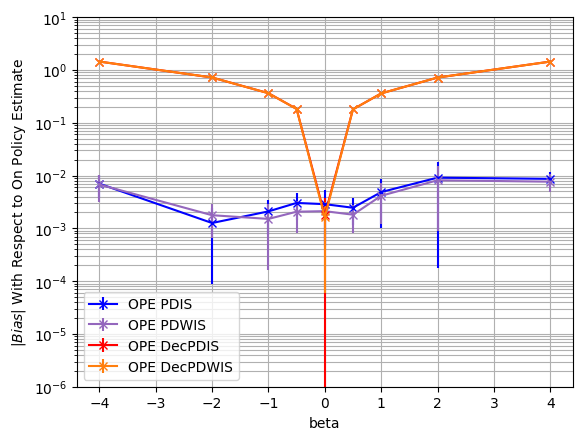

In [ ]:
biases_1000_means = np.array([
   [0.0, 0.007010799999999968, 0.007010799999999968, 0.006763417509292281, 1.4402124, 1.4402124, 1.4399110941262436],
   [0.0, 0.001260559999999767, 0.001260559999999767, 0.001771515966302167, 0.7186956, 0.7186956, 0.7189041433937062],
   [0.0, 0.002092800000000079, 0.002092800000000079, 0.0015069172579094152, 0.36255760000000004, 0.36255760000000004, 0.3619629529092017],
   [0.0, 0.0030257600000001264, 0.0030257600000001264, 0.0020636892541866392, 0.18273839999999997, 0.18273839999999997, 0.18197515996036334],
   [0.0, 0.0028687199999998777, 0.00286871999999989, 0.0021155469987182074, 0.0017603999999998917, 0.0017603999999998917, 0.0016162055274640999],
   [0.0, 0.00245152, 0.00245152, 0.00181056889904, 0.17913839999999998, 0.17913839999999998, 0.1790983698],
   [0.0, 0.004855200000000237, 0.004855200000000237, 0.004131975082853257, 0.3587808000000002, 0.3587808000000002, 0.3588733724515198],
   [0.0, 0.009113119999999954, 0.009113119999999954, 0.008127183287703269, 0.7161984, 0.7161984, 0.7166832942097316],
   [0.0, 0.008649999999999889, 0.008649999999999889, 0.007643911755010684, 1.4379756000000001, 1.4379756000000001, 1.4379166635441263]
])

biases_1000_stds = np.array([
    [0.0, 0.0032415894669128543, 0.0032415894669128543, 0.0035457972392786176, 0.0025455276545345135, 0.0025455276545345135, 0.002463265165666426],
    [0.0, 0.0011737024249785732, 0.0011737024249785732, 0.0011035911882110777, 0.002531563121867591, 0.002531563121867591, 0.0020863864726862824],
    [0.0, 0.0013595801234205088, 0.0013595801234205088, 0.0013445073253493857, 0.0020076296072731995, 0.0020076296072731995, 0.0017581220127805993],
    [0.0, 0.0015867742846417444, 0.0015867742846417444, 0.0012605510598224963, 0.00225200467139836, 0.00225200467139836, 0.002133749687044793],
    [0.0, 0.00239515184186726, 0.0023951518418672667, 0.0016722634268590993, 0.002028876102673659, 0.002028876102673659, 0.0015561179942837594],
    [0.0, 0.0012826353346138564, 0.0012826353346138564, 0.0009881910184453176, 0.002732170682808817, 0.002732170682808817, 0.0025127250901338482],
    [0.0, 0.0038384388409872555, 0.0038384388409872555, 0.002945216629619469, 0.004105408842003568, 0.004105408842003568, 0.003795059652678358],
    [0.0, 0.008933806640038877, 0.008933806640038877, 0.007245577579125276, 0.008084611298015576, 0.008084611298015576, 0.007709763624350139],
    [0.0, 0.0029447995544690363, 0.0029447995544690363, 0.0028159149451085085, 0.006237713606763324, 0.006237713606763324, 0.006377827461675452]

])

plot_graphs(biases_1000_means, biases_1000_stds, 'bias', '1000-episodes', 10**(-6), 10**(1))

#### 100000 episodes

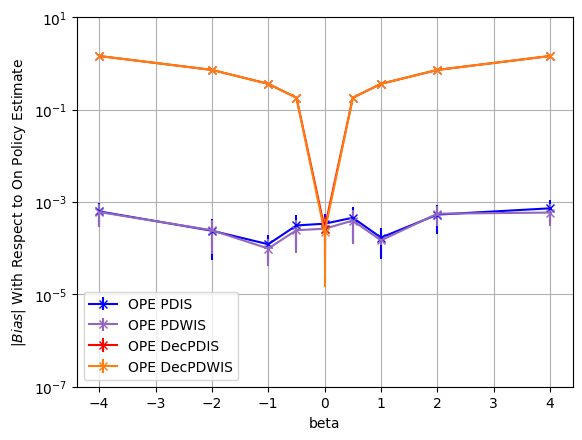

In [ ]:
biases_100000_means = np.array([
    [0.0, 0.0006226760000000273, 0.0006226760000000273, 0.0006038868378959352, 1.4397515159999998, 1.4397515159999998, 1.439772349497624],
    [0.0, 0.0002378496000000158, 0.0002378496000000158, 0.00024402522585436856, 0.7201810239999998, 0.7201810239999998, 0.7201480130059243],
    [0.0, 0.00012125200000008356, 0.00012125200000008356, 9.77970237951092e-05, 0.36000997199999996, 0.36000997199999996, 0.3600098166529518],
    [0.0, 0.00030947240000021674, 0.00030947240000021674, 0.0002444058452035911, 0.18028986199999997, 0.18028986199999997, 0.1802496776350117],
    [0.0, 0.00033802239999980953, 0.00033802239999982715, 0.00026275781319170903, 0.0002642319999999478, 0.0002642319999999478, 0.00022014984927623934],
    [0.0, 0.0004547771999999999, 0.0004547771999999999, 0.00039465129243999994, 0.17978037799999996, 0.17978037799999996, 0.17980245100000003],
    [0.0, 0.00016875039999971213, 0.00016875039999971213, 0.0001468782701227663, 0.360054464, 0.360054464, 0.36004667955175135],
    [0.0, 0.0005315976000002708, 0.0005315976000002708, 0.0005562982150456768, 0.7198460999999999, 0.7198460999999999, 0.7198285741740664],
    [0.0, 0.0007270223999999265, 0.0007270223999999265, 0.0005884109832170113, 1.4397550799999994, 1.4397550799999994, 1.4397473105828589]
])

biases_100000_stds = np.array([
    [0.0, 0.00032551244672481705, 0.00032551244672481705, 0.000318280004419552, 0.00013615631628386036, 0.00013615631628386036, 0.00018546289324069434],
    [0.0, 0.00018201081083672654, 0.00018201081083672654, 0.00017017349227005724, 0.0003922958437506062, 0.0003922958437506062, 0.00035011134519147497],
    [0.0, 7.025651650914967e-05, 7.025651650914967e-05, 5.695721914893069e-05, 0.00020149014610153186, 0.00020149014610153186, 0.0001715394243312255],
    [0.0, 0.00021300612962229907, 0.00021300612962229907, 0.0001674053486597574, 0.00028408239392126053, 0.00028408239392126053, 0.00025227024075331737],
    [0.0, 0.0002179498545572048, 0.00021794985455718985, 0.00019279907253017502, 0.00021462784482910154, 0.00021462784482910154, 0.00020605026141051782],
    [0.0, 0.0003194166613678128, 0.0003194166613678128, 0.00027270350122331026, 0.00037384593673865424, 0.00037384593673865424, 0.0003476568394897425],
    [0.0, 0.00010960743500634947, 0.00010960743500634947, 3.129460406458583e-05, 0.00018350843311411104, 0.00018350843311411104, 0.00018145172480079028],
    [0.0, 0.000331205972454232, 0.000331205972454232, 0.0002555242939578407, 0.000545449473810476, 0.000545449473810476, 0.0005623759236479406],
    [0.0, 0.00035607994692106454, 0.00035607994692106454, 0.0002914790164458757, 0.0005665298314475898, 0.0005665298314475898, 0.0005449992308156139]
])

plot_graphs(biases_100000_means, biases_100000_stds, 'bias', '100000-episodes', 10**(-7), 10**1)

### Variance vs $\beta$

#### 1000 episodes

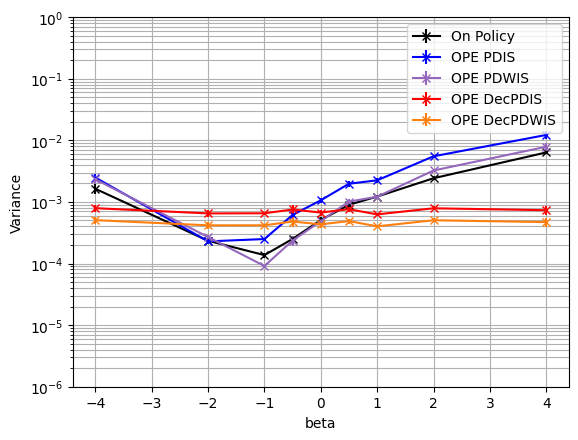

In [ ]:
vars_1000_means = np.array([
    [0.0016353602600000002, 0.002490105765887999, 0.002490105765887999, 0.0023310098457010766, 0.0007913416031999993, 0.0007913416031999993, 0.0005059902976850079],
    [0.0002340852199999999, 0.00022883230310400017, 0.00022883230310400017, 0.00026924044172909435, 0.0006509690207999997, 0.0006509690207999997, 0.0004171137046786814],
    [0.00013695240000000014, 0.0002496261012480001, 0.0002496261012480001, 9.112802125512486e-05, 0.0006538199615999998, 0.0006538199615999998, 0.0004174857354107138],
    [0.00025072873, 0.0006151184881920007, 0.0006151184881920007, 0.000235485989995307, 0.0007533771263999997, 0.0007533771263999997, 0.00048051154608078387],
    [0.0005081057000000012, 0.0010620967772159995, 0.0010620967772159995, 0.0004889501836428908, 0.0006717380255999994, 0.0006717380255999994, 0.00043252236020078295],
    [0.0008991879999999999, 0.001974252, 0.001974252, 0.001012404, 0.0007612020000000001, 0.0007612020000000001, 0.00048833],
    [0.0012209242800000008, 0.0022411282314240013, 0.0022411282314240013, 0.0012137757303729978, 0.0006279271775999995, 0.0006279271775999995, 0.0004016693073563411],
    [0.002422475880000001, 0.005503637827583996, 0.005503637827583996, 0.003236810989290931, 0.0007881667775999999, 0.0007881667775999999, 0.0005037412651714261],
    [0.00635655674, 0.012229295376384005, 0.012229295376384005, 0.007868327938933455, 0.0007334390015999995, 0.0007334390015999995, 0.0004702025252869077]
])

vars_1000_stds = np.array([
    [0.00029837475772224835, 0.00036448854076884344, 0.00036448854076884344, 0.000351147368951175, 0.00010256972820926573, 0.00010256972820926573, 6.543780418428603e-05],
    [1.4601936948966718e-05, 2.1274948946403166e-05, 2.1274948946403166e-05, 1.8781122808244417e-05, 7.510847401419953e-05, 7.510847401419953e-05, 4.783841232103539e-05],
    [1.3687256713015892e-05, 1.0796981479734674e-05, 1.0796981479734674e-05, 2.238978761921773e-06, 4.188757566102261e-05, 4.188757566102261e-05, 2.6445112787562484e-05],
    [3.0780980075581645e-05, 0.00011910800781445515, 0.00011910800781445515, 4.571202411173291e-05, 0.00014851550723283912, 0.00014851550723283912, 9.426004050132955e-05],
    [6.321946577904625e-05, 0.00010199909293326349, 0.00010199909293326349, 4.674951768883348e-05, 7.356241259287966e-05, 7.356241259287966e-05, 4.959531671766188e-05],
    [8.846675429787167e-05, 0.00020217320835362932, 0.00020217320835362932, 0.00010325692298340097, 7.250727422817659e-05, 7.250727422817659e-05, 4.554998133918388e-05],
    [8.937670203459981e-05, 0.00017468513037257406, 0.00017468513037257406, 9.85535892393478e-05, 3.365913357169394e-05, 3.365913357169394e-05, 2.1881976906270944e-05],
    [0.00018006970587260224, 0.00017821714671194207, 0.00017821714671194207, 0.00012100323719211837, 5.746696096325801e-05, 5.746696096325801e-05, 3.613433098204422e-05],
    [0.0001734943128258968, 0.0018625803185045248, 0.0018625803185045248, 0.0011669266433144024, 0.00011471945010856259, 0.00011471945010856259, 7.421055681301861e-05]
])

plot_graphs(vars_1000_means, vars_1000_stds, 'var', '1000-episodes', 10**(-6), 10**0)

#### 100000 episodes

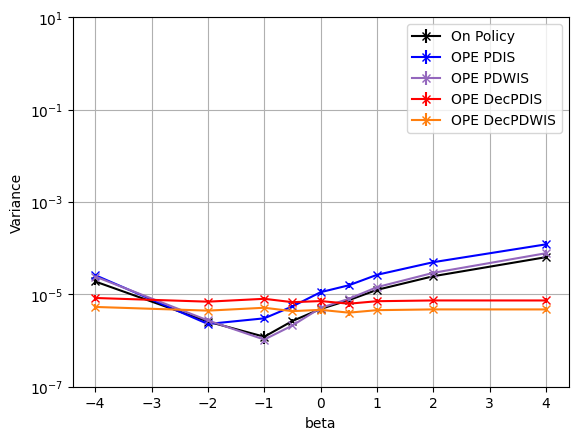

In [ ]:
vars_100000_means = np.array([
    [1.8961457517999997e-05, 2.600240692101118e-05, 2.600240692101118e-05, 2.4261394886676225e-05, 8.332250071679916e-06, 8.332250071679916e-06, 5.332842393162487e-06],
    [2.5674379399999985e-06, 2.2811033769984016e-06, 2.2811033769984016e-06, 2.7232247248701717e-06, 6.930477720000005e-06, 6.930477720000005e-06, 4.435656930534566e-06],
    [1.208188445999997e-06, 3.023314377983978e-06, 3.023314377983978e-06, 1.0486469931425824e-06, 8.000608069439976e-06, 8.000608069439976e-06, 5.118851480055713e-06],
    [2.6499117584999967e-06, 5.4822789311615655e-06, 5.4822789311615655e-06, 2.116660862641389e-06, 6.759113670720009e-06, 6.759113670720009e-06, 4.324951182233666e-06],
    [4.825322651999986e-06, 1.1128997973196777e-05, 1.1128997973196777e-05, 5.081670023997046e-06, 7.145010964799918e-06, 7.145010964799918e-06, 4.6127382449667815e-06],
    [7.4737257359999995e-06, 1.568247466e-05, 1.568247466e-05, 7.983727028e-06, 6.267370622e-06, 6.267370622e-06, 4.01035503e-06],
    [1.2498936392000009e-05, 2.6443982967091123e-05, 2.6443982967091123e-05, 1.4300836870032662e-05, 7.097549834879983e-06, 7.097549834879983e-06, 4.542342749402873e-06],
    [2.4667517194000002e-05, 4.964902283796477e-05, 4.964902283796477e-05, 2.919930653155925e-05, 7.366797544320016e-06, 7.366797544320016e-06, 4.714287933101929e-06],
    [6.378193437600001e-05, 0.00012074192889937921, 0.00012074192889937921, 7.761789674050938e-05, 7.358439271679954e-06, 7.358439271679954e-06, 4.709809127999e-06]
])

vars_100000_stds = np.array([
    [2.862436878921719e-06, 6.810737100368571e-07, 6.810737100368571e-07, 7.031523265703426e-07, 1.3133142606666002e-06, 1.3133142606666002e-06, 8.399172447572717e-07],
    [2.9420711002068506e-07, 2.6414600961846023e-07, 2.6414600961846023e-07, 2.7958877084202626e-07, 7.162306416906244e-07, 7.162306416906244e-07, 4.5844411909628163e-07],
    [3.8145645054688123e-07, 3.713831471073634e-07, 3.713831471073634e-07, 1.513223113763843e-07, 8.800727579347068e-07, 8.800727579347068e-07, 5.626583328550607e-07],
    [2.1724911276980167e-07, 1.70236023475858e-07, 1.70236023475858e-07, 5.984933837114006e-08, 1.8281118104565262e-07, 1.8281118104565262e-07, 1.167286018278295e-07],
    [4.5187118816901563e-07, 1.6749894073544037e-06, 1.6749894073544037e-06, 7.486108297618735e-07, 1.1919811301515036e-06, 1.1919811301515036e-06, 7.778767184214051e-07],
    [1.0546907341081126e-06, 1.951390558973221e-06, 1.951390558973221e-06, 9.297558547191382e-07, 9.177060067117292e-07, 9.177060067117292e-07, 5.871839374473862e-07],
    [1.2644743734197836e-06, 1.5949695302927297e-06, 1.5949695302927297e-06, 7.762810905116398e-07, 6.325400206335766e-07, 6.325400206335766e-07, 4.056652381828355e-07],
    [1.6158517891291704e-06, 4.748519575996134e-06, 4.748519575996134e-06, 2.877287119264914e-06, 7.522064840905032e-07, 7.522064840905032e-07, 4.81558166709108e-07],
    [4.743097156773612e-06, 2.0345325396637636e-05, 2.0345325396637636e-05, 1.370448577981247e-05, 8.247522293155365e-07, 8.247522293155365e-07, 5.274365270688159e-07]
])

plot_graphs(vars_100000_means, vars_100000_stds,'var', '100000-episodes', 10**(-7), 10**(1))

### MSE vs $\beta$

#### 1000 episodes

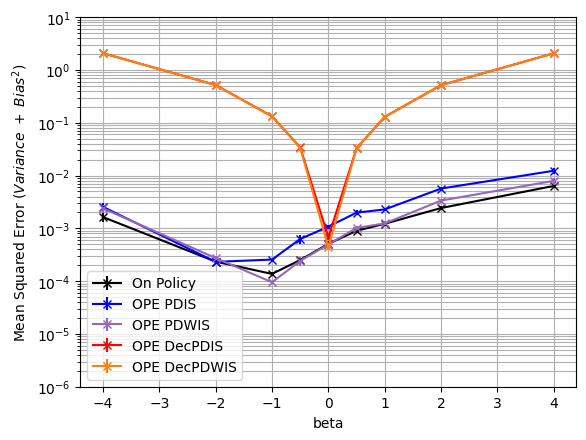

In [ ]:
MSEs_1000_means = np.array([
   [0.0016353602600000002, 0.002549764984799999, 0.002549764984799999, 0.0023893263401681534, 2.075009578428, 2.075009578428, 2.0738560169607974],
   [0.0002340852199999999, 0.0002317988920000002, 0.0002317988920000002, 0.000273596624058655, 0.5171807432919999, 0.5171807432919999, 0.5172446341018306],
   [0.00013695240000000014, 0.00025585437120000055, 0.00025585437120000055, 9.520652082522824e-05, 0.13210586385600004, 0.13210586385600004, 0.13143775600717147],
   [0.00025072873, 0.0006267915644000017, 0.0006267915644000017, 0.00024133379230757208, 0.03415177148599998, 0.03415177148599998, 0.03360002327640758],
   [0.0005081057000000012, 0.0010760630839999987, 0.0010760630839999987, 0.0004962221877154869, 0.0006789533719999991, 0.0006789533719999991, 0.00043755598371992215],
   [0.0008991879999999999, 0.001981906, 0.001981906, 0.00101666, 0.032859234, 0.032859234, 0.032570872],
   [0.0012209242800000008, 0.0022794348112000033, 0.0022794348112000033, 0.0012395232494537048, 0.12936844400800013, 0.12936844400800013, 0.12920616923985095],
   [0.002422475880000001, 0.005666499684799997, 0.005666499684799997, 0.0033553604919379773, 0.51379367588, 0.51379367588, 0.5141981259196275],
   [0.00635655674, 0.012312789720800002, 0.012312789720800002, 0.00793468670282993, 2.0685461742680005, 2.0685461742680005, 2.06811521050629]
])

MSEs_1000_stds = np.array([
    [0.00029837475772224835, 0.0004069208494600762, 0.0004069208494600762, 0.00039690237437515683, 0.007431982771705711, 0.007431982771705711, 0.007159117210736373],
    [1.4601936948966718e-05, 2.180408717896718e-05, 2.180408717896718e-05, 2.1409907701382422e-05, 0.003671684016968516, 0.003671684016968516, 0.0030216582622271874],
    [1.3687256713015892e-05, 9.527222072330079e-06, 9.527222072330079e-06, 5.3144656579200615e-06, 0.0014321386991336487, 0.0014321386991336487, 0.0012574869308872704],
    [3.0780980075581645e-05, 0.00011666611221710025, 0.00011666611221710025, 4.400742758469934e-05, 0.0008042620940127273, 0.0008042620940127273, 0.0007623739303382085],
    [6.321946577904625e-05, 9.195270871991071e-05, 9.195270871991071e-05, 4.249384951654431e-05, 6.886635726571032e-05, 6.886635726571032e-05, 4.6954874008671106e-05],
    [8.846675429787167e-05, 0.00020355905271935218, 0.00020355905271935218, 0.00010360034864806198, 0.0009608707702620568, 0.0009608707702620568, 0.0008884111127040227],
    [8.937670203459981e-05, 0.00018827688681451743, 0.00018827688681451743, 0.00010847015361103264, 0.002969448014586062, 0.002969448014586062, 0.0027430839132471644],
    [0.00018006970587260224, 0.00039128432669754666, 0.00039128432669754666, 0.00025786725769711777, 0.01156965924119019, 0.01156965924119019, 0.011041270622481208],
    [0.0001734943128258968, 0.0018358331485293503, 0.0018358331485293503, 0.0011525443212329158, 0.017893988452293706, 0.017893988452293706, 0.018290646421241365]
])
plot_graphs(MSEs_1000_means, MSEs_1000_stds, 'MSE', '1000-episodes', 10**(-6), 10)

#### 100000 episodes

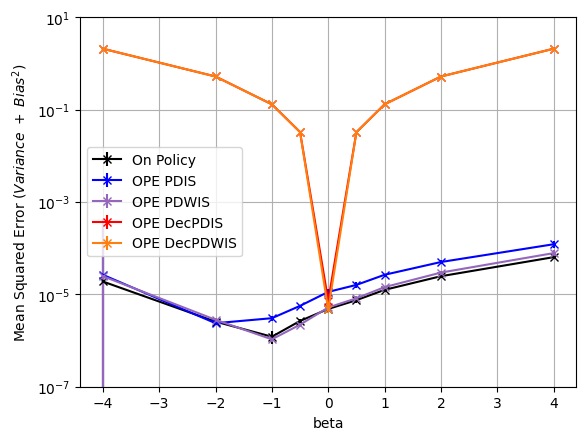

In [ ]:
MSEs_100000_means = np.array([
   [1.8961457517999997e-05, 2.6496090674959994e-05, 2.6496090674959994e-05, 2.4727376360873485e-05, 2.072892778612912, 2.072892778612912, 2.072949785616786],
   [2.5674379399999985e-06, 2.370803744480012e-06, 2.370803744480012e-06, 2.8117320531948343e-06, 0.5186677917034375, 0.5186677917034375, 0.5186177188712655],
   [1.208188445999997e-06, 3.042952403599999e-06, 3.042952403599999e-06, 1.061455375818943e-06, 0.12961522114578913, 0.12961522114578913, 0.1296122163637461],
   [2.6499117584999967e-06, 5.623423708780131e-06, 5.623423708780131e-06, 2.2044196305709666e-06, 0.032511274156456285, 0.032511274156456285, 0.032494334878982255],
   [4.825322651999986e-06, 1.1290759255199919e-05, 1.1290759255199919e-05, 5.1878831747588315e-06, 7.260894626399875e-06, 7.260894626399875e-06, 4.703660911330475e-06],
   [7.4737257359999995e-06, 1.59913251e-05, 1.59913251e-05, 8.21384279e-06, 0.03232739146000001, 0.03232739146000001, 0.03233305276],
   [1.2498936392000009e-05, 2.6484473454399857e-05, 2.6484473454399857e-05, 1.4323389448510477e-05, 0.1296463482715072, 0.1296463482715072, 0.12963818672371935],
   [2.4667517194000002e-05, 5.004131624248017e-05, 5.004131624248017e-05, 2.957406690042491e-05, 0.5181860719978827, 0.5181860719978827, 0.518158206752082],
   [6.378193437600001e-05, 0.00012139728339808018, 0.00012139728339808018, 7.804908424270805e-05, 2.0729023697811266, 2.0729023697811266, 2.072877325163865]
])

MSEs_100000_stds = np.array([
    [0.00029837475772224835, 0.0004069208494600762, 0.0004069208494600762, 0.00039690237437515683, 0.007431982771705711, 0.007431982771705711, 0.007159117210736373],
    [2.9420711002068506e-07, 1.6241821716818484e-07, 1.6241821716818484e-07, 2.0644432406718232e-07, 0.0005649696647347751, 0.0005649696647347751, 0.0005041690191552114],
    [3.8145645054688123e-07, 3.7877886111127785e-07, 3.7877886111127785e-07, 1.5517672821585455e-07, 0.00014494909691326093, 0.00014494909691326093, 0.0001234164936089322],
    [2.1724911276980167e-07, 1.7850141124000514e-07, 1.7850141124000514e-07, 9.799386875410156e-08, 0.00010235988520228905, 0.00010235988520228905, 9.090379544036532e-05],
    [4.5187118816901563e-07, 1.7195752854956678e-06, 1.7195752854956678e-06, 7.851592872216118e-07, 1.1651411318374902e-06, 1.1651411318374902e-06, 7.522506174209901e-07],
    [1.0546907341081126e-06, 2.201721872960232e-06, 2.201721872960232e-06, 1.0993178383674714e-06, 0.00013407796323334587, 0.00013407796323334587, 0.00012476272619140133],
    [1.2644743734197836e-06, 1.6384930800913624e-06, 1.6384930800913624e-06, 7.858301079661129e-07, 0.00013253913790786708, 0.00013253913790786708, 0.0001308715624239689],
    [1.6158517891291704e-06, 4.372092069843026e-06, 4.372092069843026e-06, 2.5654695554690217e-06, 0.0007849364011084635, 0.0007849364011084635, 0.0008094706340372248],
    [4.743097156773612e-06, 2.0510441062326864e-05, 2.0510441062326864e-05, 1.3842748657014477e-05, 0.0016311764523553555, 0.0016311764523553555, 0.0015692801246703332]
])

plot_graphs(MSEs_100000_means, MSEs_100000_stds, 'MSE', '100000-episodes', 10**(-7), 10)

### ESS

##### 1000 episodes

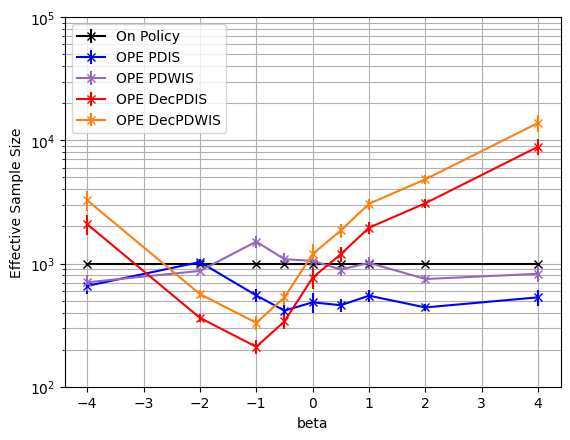

In [ ]:
ESSs_1000_means = np.array([
   [1000.0, 658.4785470407967, 658.4785470407967, 704.0986572223934, 2085.3978441654085, 2085.3978441654085, 3260.073993721751],
   [1000.0, 1027.9613647227961, 1027.9613647227961, 870.8729278948844, 362.3679849440783, 362.3679849440783, 565.4345243002952],
   [1000.0, 550.6581197550805, 550.6581197550805, 1506.5820848527576, 210.74223322861636, 210.74223322861636, 329.9743068835804],
   [1000.0, 414.60053552138436, 414.60053552138436, 1083.6281695469895, 339.2417008508972, 339.2417008508972, 531.7055147467829],
   [1000.0, 484.17550631175146, 484.17550631175146, 1052.320403327778, 767.8552679961202, 767.8552679961202, 1194.0253394512067],
   [1000.0, 458.6378695466457, 458.6378695466457, 893.9075137355696, 1190.858305101646, 1190.858305101646, 1855.5276912145832],
   [1000.0, 548.1927403450054, 548.1927403450054, 1012.6112172414844, 1952.63773429368, 1952.63773429368, 3052.9271540244044],
   [1000.0, 440.2582096165091, 440.2582096165091, 748.8339635199156, 3085.145168542934, 3085.145168542934, 4826.162014514534],
   [1000.0, 531.6708393081474, 531.6708393081474, 825.5223389739278, 8870.926941127069, 8870.926941127069, 13842.677374510162]
])

ESSs_1000_stds = np.array([
    [0.0, 91.95471481569817, 91.95471481569817, 100.16143090463005, 393.0593952618797, 393.0593952618797, 607.8422558855018],
    [0.0, 69.48612168645589, 69.48612168645589, 40.44807858500169, 29.082857462708972, 29.082857462708972, 44.81060932551641],
    [0.0, 67.40091811638443, 67.40091811638443, 180.01477531458363, 27.502540849044703, 27.502540849044703, 42.67415140625606],
    [0.0, 50.29685288625391, 50.29685288625391, 134.80241083258747, 44.94030877823129, 44.94030877823129, 69.60056746036634],
    [5.084229945850415e-14, 87.45819578272811, 87.45819578272811, 193.31802807131672, 147.94012314717577, 147.94012314717577, 235.27167301932204],
    [0.0, 56.17567124154567, 56.17567124154567, 105.68505018059147, 161.41113972033773, 161.41113972033773, 247.95337629506722],
    [0.0, 57.630824887293656, 57.630824887293656, 108.27913797454866, 201.73848158304025, 201.73848158304025, 317.81652405975814],
    [0.0, 30.57784925255957, 30.57784925255957, 53.19508991361423, 276.9316505580512, 276.9316505580512, 427.2794536290395],
    [0.0, 78.3769658840599, 78.3769658840599, 119.50689253763191, 1320.8551084713054, 1320.8551084713054, 2077.0936832405937]
])

plot_graphs(ESSs_1000_means, ESSs_1000_stds, 'ESS', '1000-episodes', 10**(2), 10**5)

##### 100000 episodes

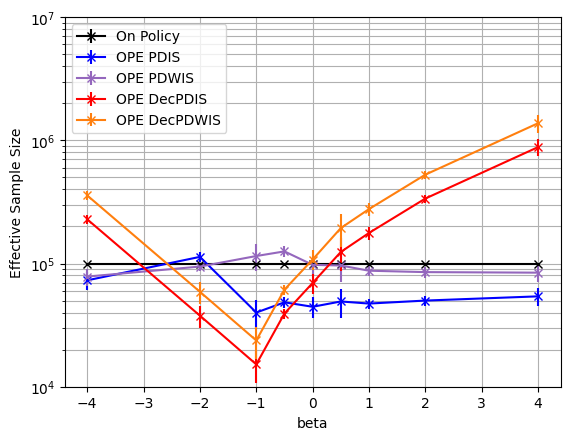

In [ ]:
ESSs_100000_means = np.array([
   [100000.0, 73038.89204999879, 73038.89204999879, 78332.51265408177, 228628.80195609722, 228628.80195609722, 357206.22402710386],
   [100000.0, 113229.01556116878, 113229.01556116878, 94479.82082897106, 37748.79534594573, 37748.79534594573, 58981.483084588755],
   [100000.0, 40007.59109678431, 40007.59109678431, 115051.19656460213, 15185.549783332166, 15185.549783332166, 23734.210907890396],
   [100000.0, 48440.53585836807, 48440.53585836807, 125449.08516366319, 39282.171528037674, 39282.171528037674, 61391.744009600676],
   [100000.0, 44553.51483602528, 44553.51483602528, 97520.56695923042, 69552.44777408153, 69552.44777408153, 107751.5184562304],
   [100000.0, 49199.267189411024, 49199.267189411024, 96384.30177387198, 124155.26782371868, 124155.26782371868, 194032.96347725304],
   [100000.0, 47311.52313688165, 47311.52313688165, 87421.66678360457, 177065.49686021206, 177065.49686021206, 276675.2959499238],
   [100000.0, 50039.04143075867, 50039.04143075867, 85166.30216417088, 336889.03738284047, 336889.03738284047, 526449.2005663652],
   [100000.0, 54142.49086723401, 54142.49086723401, 84302.42132614288, 881234.6760328388, 881234.6760328388, 1376764.3389414297]
])

ESSs_100000_stds = np.array([
    [0.0, 11575.050780025174, 11575.050780025174, 12661.950631170406, 19623.154958836945, 19623.154958836945, 30575.3513193738],
    [0.0, 11172.166617077502, 11172.166617077502, 7238.061282201746, 7686.816148807661, 7686.816148807661, 12016.013975304455],
    [0.0, 10774.869967421895, 10774.869967421895, 28687.286266219675, 4406.727800128279, 4406.727800128279, 6887.201338329551],
    [0.0, 4822.550963954471, 4822.550963954471, 12385.66526778215, 3844.6706175300205, 3844.6706175300205, 6017.914893447002],
    [9.203439287865707e-12, 8485.121677136523, 8485.121677136523, 18608.84241304122, 12893.968959704896, 12893.968959704896, 19922.177730307492],
    [0.0, 13294.59029768341, 13294.59029768341, 25215.063551031082, 36983.8748796984, 36983.8748796984, 57813.92271389477],
    [0.0, 4422.494552127997, 4422.494552127997, 7800.217204765825, 20451.13262877621, 20451.13262877621, 31966.38767431926],
    [0.0, 4700.037369903416, 4700.037369903416, 8692.427088376611, 25440.361224636457, 25440.361224636457, 39829.407210824415],
    [0.0, 8985.513992499, 8985.513992499, 13802.594277072321, 140910.6949442048, 140910.6949442048, 219994.9745334571]
])

plot_graphs(ESSs_100000_means, ESSs_100000_stds, 'ESS', '100000-episodes', 10**(4), 10**7)

## Varying Coverage

**Note**: Restart the runtime before running all code in this section

### Generate Data Set

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

Policy divergence: 10.027777777777779
Start state: state, start state no: 0

^C


In [ ]:
!python generate_dataset.py 1-step-MDP 1000 1

Policy divergence: 1.44
Start state: state, start state no: 0


In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH = 'configs/1-step-MDP/evaluation-policy.csv'

HORIZONTAL_REWARD_PATH = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'

VERTICAL_REWARD_PATH = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write everything
main_data = [['state', 'up,right', 0.64],
             ['state', 'up,left', 0.16],
             ['state', 'down,right', 0.16],
             ['state', 'down,left', 0.04]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH)

horizontal_data = [['state', 'right', 0.8],
                   ['state', 'left', 0.2]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH)

vertical_data = [['state', 'up', 0.8],
                 ['state', 'down', 0.2]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH)

!python generate_dataset.py 1-step-MDP 1000 1

Policy divergence: 2.56
Start state: state, start state no: 0


In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH = 'configs/1-step-MDP/evaluation-policy.csv'

HORIZONTAL_REWARD_PATH = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'

VERTICAL_REWARD_PATH = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write everything
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH)

!python generate_dataset.py 1-step-MDP 1000 1

Policy divergence: 3.61
Start state: state, start state no: 0


In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.2025],
             ['state', 'up,left', 0.2475],
             ['state', 'down,right', 0.2475],
             ['state', 'down,left', 0.3025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.45],
                   ['state', 'left', 0.55]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.45],
                 ['state', 'down', 0.55]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

!python generate_dataset.py 1-step-MDP 1000 1

Policy divergence: 4.4567901234567895
Start state: state, start state no: 0


In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.16],
             ['state', 'up,left', 0.24],
             ['state', 'down,right', 0.24],
             ['state', 'down,left', 0.36]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.4],
                   ['state', 'left', 0.6]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.4],
                 ['state', 'down', 0.6]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

!python generate_dataset.py 1-step-MDP 1000 1

Policy divergence: 5.640625
Start state: state, start state no: 0


In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.16],
             ['state', 'up,left', 0.24],
             ['state', 'down,right', 0.24],
             ['state', 'down,left', 0.36]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.4],
                   ['state', 'left', 0.6]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.4],
                 ['state', 'down', 0.6]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

!python generate_dataset.py 1-step-MDP 1000 1

Policy divergence: 5.640625
Start state: state, start state no: 0


In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.09],
             ['state', 'up,left', 0.21],
             ['state', 'down,right', 0.21],
             ['state', 'down,left', 0.49]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.3],
                   ['state', 'left', 0.7]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.3],
                 ['state', 'down', 0.7]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

!python generate_dataset.py 1-step-MDP 1000 1

Policy divergence: 10.027777777777779
Start state: state, start state no: 0


In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.04],
             ['state', 'up,left', 0.16],
             ['state', 'down,right', 0.16],
             ['state', 'down,left', 0.64]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.2],
                   ['state', 'left', 0.8]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.2],
                 ['state', 'down', 0.8]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

!python generate_dataset.py 1-step-MDP 1000 1

Policy divergence: 22.5625
Start state: state, start state no: 0


In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.01],
             ['state', 'up,left', 0.09],
             ['state', 'down,right', 0.09],
             ['state', 'down,left', 0.81]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.1],
                   ['state', 'left', 0.9]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.1],
                 ['state', 'down', 0.9]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

!python generate_dataset.py 1-step-MDP 1000 1

Policy divergence: 90.25
Start state: state, start state no: 0


In [ ]:
import pandas as pd

# Set up global information
MAIN_REWARD_PATH_B = 'configs/1-step-MDP/behaviour-policy.csv'
HORIZONTAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/horizontal/behaviour-policy.csv'
VERTICAL_REWARD_PATH_B = 'configs/1-step-MDP/factorisation/vertical/behaviour-policy.csv'

MAIN_REWARD_PATH_E = 'configs/1-step-MDP/evaluation-policy.csv'
HORIZONTAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/horizontal/evaluation-policy.csv'
VERTICAL_REWARD_PATH_E = 'configs/1-step-MDP/factorisation/vertical/evaluation-policy.csv'

# Modify and write evaluation policy
main_data = [['state', 'up,right', 0.9025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.0025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_E)

horizontal_data = [['state', 'right', 0.95],
                   ['state', 'left', 0.05]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_E)

vertical_data = [['state', 'up', 0.95],
                 ['state', 'down', 0.05]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_E)

# Modify and write behaviour policy
main_data = [['state', 'up,right', 0.0025],
             ['state', 'up,left', 0.0475],
             ['state', 'down,right', 0.0475],
             ['state', 'down,left', 0.9025]]

main_reward_df = pd.DataFrame(main_data, columns=['state', 'action', 'probability'])
main_reward_df.to_csv(MAIN_REWARD_PATH_B)

horizontal_data = [['state', 'right', 0.05],
                   ['state', 'left', 0.95]]
horizontal_reward_df = pd.DataFrame(horizontal_data, columns=['state', 'action', 'probability'])
horizontal_reward_df.to_csv(HORIZONTAL_REWARD_PATH_B)

vertical_data = [['state', 'up', 0.05],
                 ['state', 'down', 0.95]]
vertical_reward_df = pd.DataFrame(vertical_data, columns=['state', 'action', 'probability'])
vertical_reward_df.to_csv(VERTICAL_REWARD_PATH_B)

!python generate_dataset.py 1-step-MDP 1000 1

Policy divergence: 361.0
Start state: state, start state no: 0


### Run Estimates on Collected Data Sets

In [ ]:
import sys
MDP_NAME = '1-step-MDP'
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_datasets import load_MDP_transitions
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_coverage(NUM_EPISODES, NO_TRAJECTORIES=10000000, SHORTER_D=1.44):

  MDP_NAME = '1-step-MDP'
  START_STATE_NO = 0
  TRAJECTORY_LENGTH = 1
  VERSION_NUMBER =1
  nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

  hashgen = lambda arr : 10000*arr[0] + 1000*arr[1] + 100*arr[2] + 10*arr[3] + arr[4]

  # Reshape data for processing
  N, T = nf_transitions_b.shape[0], nf_transitions_b.shape[1]
  D = f_transitions_b.shape[2]

  hash_arr_nf = np.zeros((NUM_EPISODES,2))
  hash_arr_f = np.zeros((NUM_EPISODES,D,2))

  for n in range(NUM_EPISODES):
    hash_arr_nf[n, :] = np.array([hashgen(nf_transitions_b[n, 0, :]), n])
    hash_arr_nf = hash_arr_nf[hash_arr_nf[:, 0].argsort()]
    for d in range(D):
      hash_arr_f[n, d, :] = np.array([hashgen(f_transitions_b[n, 0, d, :]), n])
      hash_arr_f[:, d, :] = hash_arr_f[:, d, :][hash_arr_f[:,d, 0].argsort()]

  def search_hash_nf(hash, arr):
    for n in range(NUM_EPISODES):
      if hash_arr_nf[n, 0] > hash:
        return False
      if hash_arr_nf[n, 0] == hash:
        if (nf_transitions_b[int(hash_arr_nf[n, 1]), 0, :] == arr).all():
          return True

  def search_hash_f(hash, arr, d):
    for n in range(NUM_EPISODES):
      if hash_arr_f[n, d, 0] > hash:
        return False
      if hash_arr_f[n, d, 0] == hash:
        if (f_transitions_b[int(hash_arr_f[n, d, 1]), 0, d, :] == arr).all():
          return True

  nf_covered_trs = 0
  f_covered_trs = np.zeros(D)

  for n in range(NUM_EPISODES):
      nf_tr_e = nf_transitions_e[n, 0, :]
      if search_hash_nf(hashgen(nf_tr_e), nf_tr_e):
        nf_covered_trs += 1

      for d in range(D):
        f_tr_e = f_transitions_e[n, 0, d, :]
        if search_hash_f(hashgen(f_tr_e), f_tr_e, d):
          f_covered_trs[d] += 1

  print(nf_covered_trs/NUM_EPISODES)
  print(f_covered_trs/NUM_EPISODES)

  return nf_covered_trs/NUM_EPISODES, f_covered_trs/NUM_EPISODES

#### Varying episodes

In [ ]:
nf_coverages = np.zeros(9)
f_coverages = np.zeros((9,2))

evaluate_coverage(10)
gc.collect()
evaluate_coverage(50)
gc.collect()
evaluate_coverage(100)
gc.collect()
evaluate_coverage(500)
gc.collect()
evaluate_coverage(1000)
gc.collect()
evaluate_coverage(5000)
gc.collect()
evaluate_coverage(10000)
gc.collect()
evaluate_coverage(50000)
gc.collect()
evaluate_coverage(100000)
gc.collect()

#### Varying Policy Divergence

In [ ]:
evaluate_coverage(50, 1000, 1.44)
gc.collect()
evaluate_coverage(50, 1000, 2.56)
gc.collect()
evaluate_coverage(50, 1000, 3.61)
gc.collect()
evaluate_coverage(50, 1000, 4.46)
gc.collect()
evaluate_coverage(50, 1000, 5.64)
gc.collect()
evaluate_coverage(50, 1000, 10.03)
gc.collect()
evaluate_coverage(50, 1000, 22.56)
gc.collect()
evaluate_coverage(50, 1000, 90.25)
gc.collect()
evaluate_coverage(50, 1000, 361.0)
gc.collect()

0.84
[1. 1.]
1.0
[1. 1.]
1.0
[1. 1.]
1.0
[1. 1.]
1.0
[1. 1.]
1.0
[1. 1.]
1.0
[1. 1.]
0.1
[1. 1.]
0.1
[0.1 1. ]


44

### Plot Graphs
<a id='coverage'></a>

In [ ]:
import pickle
import matplotlib.pyplot as plt

def plot_graphs(nf_coverages, f_coverages, label, low_ylim, up_ylim):
  EPISODES = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

  legend_list = ['Non Factored Space', 'Factored Space 1', 'Factored Space 2']

  xlabels = {
      'N': 'Number of Episodes',
      'PD': 'Policy Divergence'
  }

  plt.figure()
  plt.plot(EPISODES, nf_coverages, color='r')
  plt.plot(EPISODES, f_coverages[:, 0], color='b')
  plt.plot(EPISODES, f_coverages[:, 1], color='g')
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel(xlabels[label])
  plt.ylabel('Fraction of Trajectories Covered in $\pi_e$')
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'coverage-vs-{label}.pdf', dpi=300)
  plt.show()


##### Plot Against N

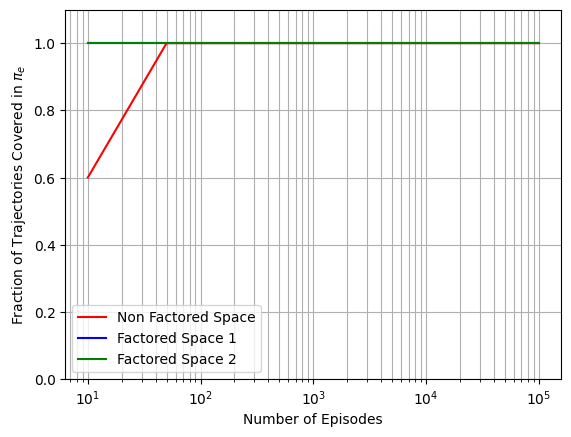

In [ ]:
nf_coverages = [0.6, 1, 1, 1, 1, 1, 1, 1, 1]
f_coverages = np.full((9,2), 1)

plot_graphs(nf_coverages, f_coverages, 'N', 0, 1.1)

##### Plot Against Policy Divergence

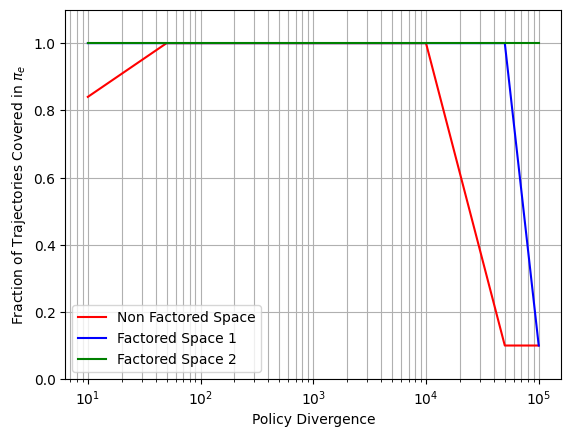

In [ ]:
nf_coverages = [0.84, 1, 1, 1, 1, 1, 1, 0.1, 0.1]
f_coverages = np.array([[1., 1.], [1., 1.], [1., 1.], [1., 1.], [1., 1.], [1., 1.], [1., 1.], [1., 1.], [0.1, 1. ]])

plot_graphs(nf_coverages, f_coverages, 'PD', 0, 1.1)